In [1]:
import math
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
import tqdm
import copy
from util import *

In [2]:
torch.__version__

'1.13.1'

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("device:", device)

device: cuda:0


## Fetch data

In [4]:
def generate_hdgm_cov_matrix(n_clusters, d):
    mu_mx = np.zeros([n_clusters, d])
    for i in range(n_clusters):
        mu_mx[i] = mu_mx[i] + 0.5*i
    sigma_mx_1 = np.eye(d)
    sigma_mx_2 = [np.eye(d), np.eye(d)]
    sigma_mx_2[0][0, 1] = 0.5
    sigma_mx_2[0][1, 0] = 0.5
    sigma_mx_2[1][0, 1] = -0.5
    sigma_mx_2[1][1, 0] = -0.5

    return mu_mx, sigma_mx_1, sigma_mx_2 

def sample_hdgm_semi_t2(n_train, n_test, d=10, n_clusters=2, kk=0):
    mu_mx, sigma_mx_1, sigma_mx_2 = generate_hdgm_cov_matrix(n_clusters, d)
    
    n = n_train + n_test

    s1 = np.zeros([n*n_clusters, d])
    s2 = np.zeros([n*n_clusters, d])

    np.random.seed(seed=1102*kk)
    # tr_idx = np.random.choice(n, n_train, replace=False)
    # tr_idx = np.tile(tr_idx, n_clusters)
    # for i in range(n_clusters):
    #     tr_idx[i*n_train:(i+1)*n_train] = tr_idx[i*n_train:(i+1)*n_train] + i*n

    tr_idx = np.random.choice(n*n_clusters, n_train*n_clusters, replace=False)
    
    te_idx = np.delete(np.arange(n*n_clusters), tr_idx)

    for i in range(n_clusters):
        np.random.seed(seed=1102*kk + i + n)
        s1[i*n:(i+1)*n, :] = np.random.multivariate_normal(mu_mx[i], sigma_mx_1, n)
        np.random.seed(seed=819*kk + i + n + 1)
        s2[i*n:(i+1)*n, :] = np.random.multivariate_normal(mu_mx[i], sigma_mx_2[i], n)

    return s1[tr_idx], s1[te_idx], s2[tr_idx], s2[te_idx]
    # return s1, None, s2, None

def sample_hdgm_semi_t1(n_train, n_test, d=10, n_clusters=2, kk=0):
    mu_mx, sigma_mx_1, _ = generate_hdgm_cov_matrix(n_clusters, d)

    n = n_train + n_test

    s1 = np.zeros([n*n_clusters, d])
    s2 = np.zeros([n*n_clusters, d])

    np.random.seed(seed=1102*kk)
    # tr_idx = np.random.choice(n, n_train, replace=False)
    # tr_idx = np.tile(tr_idx, n_clusters)
    # for i in range(n_clusters):
    #     tr_idx[i*n_train:(i+1)*n_train] = tr_idx[i*n_train:(i+1)*n_train] + i*n

    tr_idx = np.random.choice(n*n_clusters, n_train*n_clusters, replace=False)

    te_idx = np.delete(np.arange(n*n_clusters), tr_idx)

    for i in range(n_clusters):
        np.random.seed(seed=1102*kk + i + n)
        s1[i*n:(i+1)*n, :] = np.random.multivariate_normal(mu_mx[i], sigma_mx_1, n)
        np.random.seed(seed=819*kk + i + n + 1)
        s2[i*n:(i+1)*n, :] = np.random.multivariate_normal(mu_mx[i], sigma_mx_1, n)

    return s1[tr_idx], s1[te_idx], s2[tr_idx], s2[te_idx]

In [5]:
s1, a, s2, b = sample_hdgm_semi_t2(n_train=1000, n_test=0, d=10, n_clusters=2, kk=3)
# c = np.concatenate([s1, a], axis=0)
# d = np.concatenate([s2, b], axis=0)

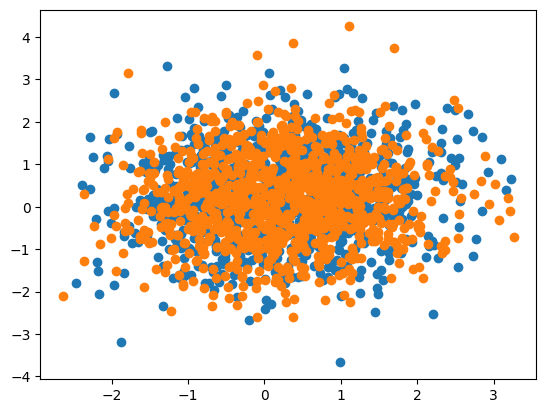

In [6]:
plt.plot(s1[:1000, 0], s1[:1000, 1], 'o')
plt.plot(s1[1000:, 0], s1[1000:, 1], 'o')

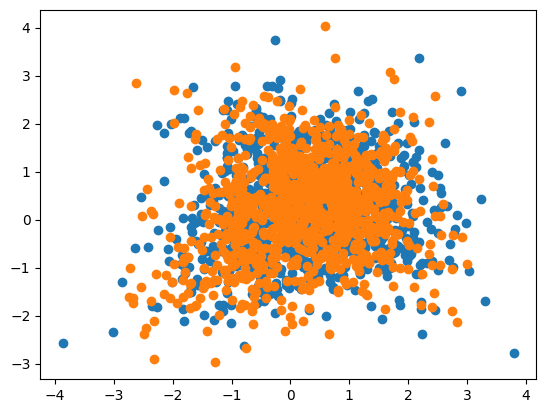

In [7]:
plt.plot(s2[:1000, 0], s2[:1000, 1], 'o')
plt.plot(s2[1000:, 0], s2[1000:, 1], 'o')

In [8]:
np.mean(s1[1000:])

0.2299097799250804

## Experiment

In [6]:
# Select device, compatible with CUDA (nvidia gpu), MPS (mac gpu), and CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("device:", device)

# Setup seeds
np.random.seed(1102)
torch.manual_seed(1102)
torch.cuda.manual_seed(1102)
torch.backends.cudnn.deterministic = True

# Setup for experiments
dtype = torch.float
alpha = 0.05  # test threshold
batch_size = 1024  # batch size

x_in = 10  # number of neurons in the input layer, i.e., dimension of data
H = 30  # number of neurons in the hidden layer
x_out = 30  # number of neurons in the output layer

# learning_rate = 0.00005
learning_rate = 0.00001

N_EPOCH = 1000  # number of training epochs
N_TRAIL = 100  # number of trails
N_TEST = 100  # number of test sets
N_TEST_F = 100.0  # number of test sets (float)0
N_PER = 100  # permutation times

device: cuda:0


In [17]:
# baseline_result = []
# for n in n_list:
#     n_train = n
#     n_test = n

#     summary = []
#     for kk in range(N_TRAIL):
#         s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(n_train, n_test, kk=kk)

#         S = np.concatenate((s1_tr, s2_tr), axis=0)
#         S = MatConvert(S, device, dtype)

#         y = torch.concat(
#             (torch.zeros(n_train*2), torch.ones(n_train*2))).to(device, dtype).long()

#         model_C2ST_L, w_C2ST_L, b_C2ST_L = C2ST_NN_fit(
#             S, y, x_in, H, x_out, N_EPOCH, batch_size, device, dtype, lr_c2st=0.001)

#         # perform test
#         H_C2ST_L = np.zeros(N_TEST)
#         S_test = np.concatenate((s1_te, s2_te), axis=0)
#         S_test = MatConvert(S_test, device, dtype)

#         for k in range(N_TEST):
#             H_C2ST_L[k], _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
#         print("Test Power of C2ST-L: ", H_C2ST_L.sum() / N_TEST_F)
#         summary.append(H_C2ST_L.sum() / N_TEST_F)

#         # h1, _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
#         # summary.append(h1)
#     baseline_result.append(summary)

# with open('result/c2st_HDGM_baseline_result.pkl', 'wb') as file:
#     # Use pickle.dump() to write the list to the file
#     pickle.dump(baseline_result, file)

In [13]:
# np.mean(np.array(baseline_result), axis=1)

array([0.05, 0.44, 0.99, 1.  , 1.  , 1.  ])

In [7]:
n_list = [200, 300, 400, 500, 600, 750, 850, 1000, 1200]

In [140]:
# n_train = 800
# n_test = 800

# summary = []
# for kk in tqdm.trange(100):
#     s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(
#         n_train, n_test, kk=kk)

#     S = np.concatenate((s1_tr, s2_tr), axis=0)
#     S = MatConvert(S, device, dtype)

#     y = torch.concat(
#         (torch.zeros(n_train*2), torch.ones(n_train*2))).to(device, dtype).long()

#     model_C2ST_L, w_C2ST_L, b_C2ST_L = C2ST_NN_fit(
#         S, y, x_in, H, x_out, N_EPOCH, batch_size, device, dtype, lr_c2st=0.001)

#     # perform test
#     H_C2ST_L = np.zeros(N_TEST)
#     S_test = np.concatenate((s1_te, s2_te), axis=0)
#     S_test = MatConvert(S_test, device, dtype)

#     for k in range(N_TEST):
#         # s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t1(
#         #     n_train, n_test, kk=k+10086)
#         # S_test = np.concatenate((s1_te, s2_te), axis=0)
#         # S_test = MatConvert(S_test, device, dtype)
#         H_C2ST_L[k], _, _ = TST_LCE(
#             S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
#     print("Test Power of C2ST-L: ", H_C2ST_L.sum() / N_TEST_F)
#     summary.append(H_C2ST_L.sum() / N_TEST_F)

#     # h1, _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
#     # summary.append(h1)

  0%|          | 0/20 [00:00<?, ?it/s]

0.756163477897644


In [139]:
# np.mean(summary)

0.95

In [13]:
baseline_result_t2 = []
for n in n_list:
    n_train = n
    n_test = n

    summary = []
    for kk in tqdm.trange(100):
        s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(
            n_train, n_test, kk=kk)

        S = np.concatenate((s1_tr, s2_tr), axis=0)
        S = MatConvert(S, device, dtype)

        y = torch.concat(
            (torch.zeros(n_train*2), torch.ones(n_train*2))).to(device, dtype).long()

        model_C2ST_L, w_C2ST_L, b_C2ST_L = C2ST_NN_fit(
            S, y, x_in, H, x_out, N_EPOCH, batch_size, device, dtype, lr_c2st=0.001)

        # perform test
        H_C2ST_L = np.zeros(N_TEST)
        S_test = np.concatenate((s1_te, s2_te), axis=0)
        S_test = MatConvert(S_test, device, dtype)

        # s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t1(
        #     n_train, 0, kk=10086)
        # S_test = np.concatenate((s1_tr, s2_tr), axis=0)
        # S_test = MatConvert(S_test, device, dtype)
        for k in range(N_TEST):
            H_C2ST_L[k], _, _ = TST_LCE(
                S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        print("Test Power of C2ST-L: ", H_C2ST_L.sum() / N_TEST_F)
        summary.append(H_C2ST_L.sum() / N_TEST_F)

        # h1, _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        # summary.append(h1)
    baseline_result_t2.append(summary)
    print("Test power at training size = ", n, " : ", np.mean(summary))

with open('result/c2st_HDGM_baseline_result.pkl', 'wb') as file:
    # Use pickle.dump() to write the list to the file
    pickle.dump(baseline_result_t2, file)

  0%|          | 0/100 [00:00<?, ?it/s]

1.2557107210159302
0.6841068267822266
0.6722928881645203
0.6499317288398743
0.6307708621025085


  1%|          | 1/100 [00:06<10:48,  6.55s/it]

Test Power of C2ST-L:  0.0
1.2576401233673096
0.6826689839363098
0.6673362255096436
0.6500388383865356
0.6172217726707458


  2%|▏         | 2/100 [00:13<10:43,  6.56s/it]

Test Power of C2ST-L:  0.0
1.260329246520996
0.6870220899581909
0.6782405972480774
0.6508544087409973
0.6153247952461243


  3%|▎         | 3/100 [00:19<10:34,  6.54s/it]

Test Power of C2ST-L:  0.0
1.2599014043807983
0.6858665943145752
0.6627328991889954
0.6415806412696838
0.6047468781471252


  4%|▍         | 4/100 [00:26<10:34,  6.61s/it]

Test Power of C2ST-L:  0.0
1.259250521659851
0.6833226084709167
0.6719865202903748
0.6512168049812317
0.6199381351470947


  5%|▌         | 5/100 [00:32<10:28,  6.61s/it]

Test Power of C2ST-L:  0.0
1.256803274154663
0.6857035756111145
0.6780456304550171
0.6607820391654968
0.6498037576675415


  6%|▌         | 6/100 [00:39<10:21,  6.61s/it]

Test Power of C2ST-L:  0.0
1.2581058740615845
0.6794548630714417
0.6669542789459229
0.6450868844985962
0.604524552822113


  7%|▋         | 7/100 [00:46<10:17,  6.64s/it]

Test Power of C2ST-L:  0.0
1.2624597549438477
0.6831170916557312
0.6701103448867798
0.6499143838882446
0.5894853472709656


  8%|▊         | 8/100 [00:53<10:20,  6.75s/it]

Test Power of C2ST-L:  0.0
1.2590631246566772
0.6764891743659973
0.6635729074478149
0.6431423425674438
0.6029794216156006


  9%|▉         | 9/100 [00:59<10:04,  6.64s/it]

Test Power of C2ST-L:  1.0
1.2617095708847046
0.6822873950004578
0.6583402156829834
0.639475405216217
0.6031553149223328


 10%|█         | 10/100 [01:06<09:59,  6.66s/it]

Test Power of C2ST-L:  0.0
1.2581161260604858
0.6847776770591736
0.6737729907035828
0.6442089676856995
0.6175634860992432


 11%|█         | 11/100 [01:12<09:47,  6.60s/it]

Test Power of C2ST-L:  0.0
1.260144829750061
0.6844322085380554
0.6737926006317139
0.6534241437911987
0.6336734890937805


 12%|█▏        | 12/100 [01:19<09:37,  6.57s/it]

Test Power of C2ST-L:  0.0
1.2570351362228394
0.6844266653060913
0.6704174876213074
0.6497961282730103
0.6133909225463867


 13%|█▎        | 13/100 [01:25<09:29,  6.54s/it]

Test Power of C2ST-L:  0.0
1.2585939168930054
0.6851010918617249
0.6790103912353516
0.6632608771324158
0.6397611498832703


 14%|█▍        | 14/100 [01:32<09:20,  6.52s/it]

Test Power of C2ST-L:  1.0
1.2603660821914673
0.6808692216873169
0.6675333976745605
0.6450210809707642
0.6122090816497803


 15%|█▌        | 15/100 [01:38<09:11,  6.49s/it]

Test Power of C2ST-L:  1.0
1.255364179611206
0.6802108883857727
0.6730531454086304
0.644855260848999
0.5831798315048218


 16%|█▌        | 16/100 [01:45<09:06,  6.51s/it]

Test Power of C2ST-L:  0.0
1.2583465576171875
0.6848060488700867
0.6688103675842285
0.644909679889679
0.6285355687141418


 17%|█▋        | 17/100 [01:51<08:58,  6.49s/it]

Test Power of C2ST-L:  0.0
1.2591116428375244
0.6843224167823792
0.6620272994041443
0.6310407519340515
0.5771809220314026


 18%|█▊        | 18/100 [01:58<08:53,  6.51s/it]

Test Power of C2ST-L:  0.0
1.2593573331832886
0.6854932904243469
0.6746644377708435
0.6419639587402344
0.6064708828926086


 19%|█▉        | 19/100 [02:04<08:46,  6.50s/it]

Test Power of C2ST-L:  0.0
1.254287600517273
0.6865389943122864
0.667300820350647
0.6475146412849426
0.6078587770462036


 20%|██        | 20/100 [02:11<08:40,  6.51s/it]

Test Power of C2ST-L:  0.0
1.2615149021148682
0.6848800778388977
0.6770508289337158
0.6533684730529785
0.6113274097442627


 21%|██        | 21/100 [02:17<08:34,  6.51s/it]

Test Power of C2ST-L:  0.0
1.2555979490280151
0.6830485463142395
0.666903555393219
0.6472285985946655
0.6013039946556091


 22%|██▏       | 22/100 [02:24<08:28,  6.52s/it]

Test Power of C2ST-L:  1.0
1.260576844215393
0.6814476847648621
0.6652405261993408
0.6438269019126892
0.6100032329559326


 23%|██▎       | 23/100 [02:30<08:21,  6.52s/it]

Test Power of C2ST-L:  0.0
1.255694031715393
0.6750973463058472
0.656851053237915
0.6333930492401123
0.5938814282417297


 24%|██▍       | 24/100 [02:37<08:15,  6.53s/it]

Test Power of C2ST-L:  0.0
1.2561715841293335
0.6874899864196777
0.6716094017028809
0.6431102156639099
0.6142690181732178


 25%|██▌       | 25/100 [02:43<08:07,  6.50s/it]

Test Power of C2ST-L:  0.0
1.2578037977218628
0.6856520175933838
0.6670519113540649
0.6472494006156921
0.6015775203704834


 26%|██▌       | 26/100 [02:50<08:03,  6.53s/it]

Test Power of C2ST-L:  0.0
1.257805585861206
0.6872803568840027
0.6828449964523315
0.6635943055152893
0.6411893367767334


 27%|██▋       | 27/100 [02:56<07:54,  6.51s/it]

Test Power of C2ST-L:  1.0
1.2558460235595703
0.6830245852470398
0.6703900098800659
0.6475541591644287
0.6171460151672363


 28%|██▊       | 28/100 [03:03<07:49,  6.52s/it]

Test Power of C2ST-L:  0.0
1.2566895484924316
0.6766040921211243
0.6606319546699524
0.6396773457527161
0.6092807054519653


 29%|██▉       | 29/100 [03:09<07:42,  6.51s/it]

Test Power of C2ST-L:  0.0
1.2580448389053345
0.6878293752670288
0.6756175756454468
0.649385929107666
0.6247272491455078


 30%|███       | 30/100 [03:16<07:35,  6.50s/it]

Test Power of C2ST-L:  0.0
1.2524175643920898
0.6853334307670593
0.6699267625808716
0.6397854685783386
0.6006948351860046


 31%|███       | 31/100 [03:22<07:27,  6.49s/it]

Test Power of C2ST-L:  0.0
1.2583966255187988
0.681944727897644
0.6619822978973389
0.6374919414520264
0.570807933807373


 32%|███▏      | 32/100 [03:29<07:22,  6.51s/it]

Test Power of C2ST-L:  0.0
1.2626701593399048
0.686475396156311
0.6681989431381226
0.6441442370414734
0.619263768196106


 33%|███▎      | 33/100 [03:35<07:12,  6.46s/it]

Test Power of C2ST-L:  1.0
1.258739709854126
0.6822688579559326
0.6690158843994141
0.6443370580673218
0.6191384196281433


 34%|███▍      | 34/100 [03:42<07:08,  6.49s/it]

Test Power of C2ST-L:  0.0
1.257006049156189
0.6834800839424133
0.6759954690933228
0.6601983904838562
0.6349497437477112


 35%|███▌      | 35/100 [03:48<07:01,  6.48s/it]

Test Power of C2ST-L:  0.0
1.2577848434448242
0.686137318611145
0.6777182221412659
0.6451146602630615
0.6052541136741638


 36%|███▌      | 36/100 [03:55<06:56,  6.50s/it]

Test Power of C2ST-L:  0.0
1.2549395561218262
0.6776992678642273
0.6636808514595032
0.6392543911933899
0.5742650628089905


 37%|███▋      | 37/100 [04:01<06:48,  6.49s/it]

Test Power of C2ST-L:  0.0
1.2544798851013184
0.6835552453994751
0.6652460694313049
0.6380298733711243
0.5567288398742676


 38%|███▊      | 38/100 [04:08<06:48,  6.59s/it]

Test Power of C2ST-L:  1.0
1.2556495666503906
0.6751759052276611
0.6611125469207764
0.6374232172966003
0.6167576313018799


 39%|███▉      | 39/100 [04:15<06:42,  6.60s/it]

Test Power of C2ST-L:  0.0
1.2585221529006958
0.6844465732574463
0.6734389662742615
0.6467817425727844
0.6185548305511475


 40%|████      | 40/100 [04:21<06:33,  6.57s/it]

Test Power of C2ST-L:  0.0
1.2586973905563354
0.6734250783920288
0.6615177392959595
0.6442160606384277
0.6153334975242615


 41%|████      | 41/100 [04:28<06:24,  6.52s/it]

Test Power of C2ST-L:  0.0
1.2598013877868652
0.6815840005874634
0.666063129901886
0.6368381381034851
0.6017954349517822


 42%|████▏     | 42/100 [04:34<06:18,  6.52s/it]

Test Power of C2ST-L:  0.0
1.2551571130752563
0.6841662526130676
0.6716971397399902
0.6441693305969238
0.5741334557533264


 43%|████▎     | 43/100 [04:41<06:10,  6.49s/it]

Test Power of C2ST-L:  0.0
1.2569409608840942
0.6861504912376404
0.6699169874191284
0.6317924857139587
0.5744056105613708


 44%|████▍     | 44/100 [04:47<06:03,  6.49s/it]

Test Power of C2ST-L:  1.0
1.2627296447753906
0.6824101805686951
0.6648113131523132
0.6315207481384277
0.5755898356437683


 45%|████▌     | 45/100 [04:53<05:56,  6.47s/it]

Test Power of C2ST-L:  0.0
1.2609896659851074
0.6799938082695007
0.6712299585342407
0.6526024341583252
0.6181210875511169


 46%|████▌     | 46/100 [05:00<05:50,  6.49s/it]

Test Power of C2ST-L:  0.0
1.2580227851867676
0.6859481334686279
0.6764030456542969
0.657511293888092
0.6312201023101807


 47%|████▋     | 47/100 [05:06<05:43,  6.48s/it]

Test Power of C2ST-L:  0.0
1.259016752243042
0.687176525592804
0.659874677658081
0.6299330592155457
0.576012134552002


 48%|████▊     | 48/100 [05:13<05:38,  6.50s/it]

Test Power of C2ST-L:  0.0
1.2559860944747925
0.6859169006347656
0.6732807159423828
0.6500017642974854
0.6125808954238892


 49%|████▉     | 49/100 [05:19<05:30,  6.48s/it]

Test Power of C2ST-L:  0.0
1.2572693824768066
0.6837432384490967
0.6685425043106079
0.6437318325042725
0.5904144048690796


 50%|█████     | 50/100 [05:26<05:24,  6.49s/it]

Test Power of C2ST-L:  0.0
1.2624338865280151
0.6872100234031677
0.674670934677124
0.6485536694526672
0.5970925092697144


 51%|█████     | 51/100 [05:32<05:17,  6.47s/it]

Test Power of C2ST-L:  0.0
1.2549242973327637
0.6814420223236084
0.671481192111969
0.6523860096931458
0.6054624915122986


 52%|█████▏    | 52/100 [05:39<05:15,  6.56s/it]

Test Power of C2ST-L:  0.0
1.256262183189392
0.6863635778427124
0.6757234930992126
0.6545654535293579
0.6373682618141174


 53%|█████▎    | 53/100 [05:46<05:08,  6.57s/it]

Test Power of C2ST-L:  0.0
1.2589563131332397
0.6820653676986694
0.6727912425994873
0.6469022631645203
0.6043965816497803


 54%|█████▍    | 54/100 [05:52<05:01,  6.56s/it]

Test Power of C2ST-L:  0.0
1.2598657608032227
0.6869853734970093
0.6718022227287292
0.6468538045883179
0.6013594269752502


 55%|█████▌    | 55/100 [05:59<04:55,  6.57s/it]

Test Power of C2ST-L:  0.0
1.2578903436660767
0.6877349615097046
0.6808051466941833
0.6580806970596313
0.6118298172950745


 56%|█████▌    | 56/100 [06:06<04:49,  6.58s/it]

Test Power of C2ST-L:  1.0
1.2602084875106812
0.6833308339118958
0.6689839959144592
0.647983729839325
0.6194257140159607


 57%|█████▋    | 57/100 [06:12<04:42,  6.57s/it]

Test Power of C2ST-L:  0.0
1.263424277305603
0.6837246417999268
0.6615897417068481
0.6396637558937073
0.6015415787696838


 58%|█████▊    | 58/100 [06:19<04:35,  6.57s/it]

Test Power of C2ST-L:  0.0
1.2596951723098755
0.6835024952888489
0.670219898223877
0.6506396532058716
0.6080171465873718


 59%|█████▉    | 59/100 [06:25<04:28,  6.56s/it]

Test Power of C2ST-L:  0.0
1.2629196643829346
0.68467116355896
0.6772862076759338
0.6593234539031982
0.6295402646064758


 60%|██████    | 60/100 [06:32<04:21,  6.53s/it]

Test Power of C2ST-L:  0.0
1.2577424049377441
0.6850569844245911
0.6738632917404175
0.6513671875
0.607022225856781


 61%|██████    | 61/100 [06:38<04:15,  6.54s/it]

Test Power of C2ST-L:  1.0
1.2612992525100708
0.685344398021698
0.6705034375190735
0.6413561105728149
0.6106411218643188


 62%|██████▏   | 62/100 [06:45<04:08,  6.55s/it]

Test Power of C2ST-L:  0.0
1.2592514753341675
0.6834179759025574
0.6672977209091187
0.643271267414093
0.5826468467712402


 63%|██████▎   | 63/100 [06:51<04:01,  6.52s/it]

Test Power of C2ST-L:  0.0
1.261802315711975
0.6864018440246582
0.6737678647041321
0.6376156210899353
0.6162981390953064


 64%|██████▍   | 64/100 [06:58<03:55,  6.54s/it]

Test Power of C2ST-L:  0.0
1.2528314590454102
0.6830962300300598
0.6659067273139954
0.6406925320625305
0.572989821434021


 65%|██████▌   | 65/100 [07:04<03:48,  6.53s/it]

Test Power of C2ST-L:  0.0
1.2621387243270874
0.6861002445220947
0.6756771206855774
0.6569259166717529
0.6339603662490845


 66%|██████▌   | 66/100 [07:11<03:42,  6.54s/it]

Test Power of C2ST-L:  0.0
1.2597432136535645
0.6829035878181458
0.6696343421936035
0.6470587253570557
0.6079565286636353


 67%|██████▋   | 67/100 [07:17<03:36,  6.55s/it]

Test Power of C2ST-L:  0.0
1.254285454750061
0.6761350035667419
0.6559096574783325
0.6316309571266174
0.59099280834198


 68%|██████▊   | 68/100 [07:24<03:29,  6.56s/it]

Test Power of C2ST-L:  0.0
1.256184697151184
0.6792672872543335
0.6706638932228088
0.652126669883728
0.6129898428916931


 69%|██████▉   | 69/100 [07:31<03:23,  6.56s/it]

Test Power of C2ST-L:  0.0
1.25838303565979
0.6795375943183899
0.6588153839111328
0.6365752816200256
0.5993984341621399


 70%|███████   | 70/100 [07:37<03:16,  6.56s/it]

Test Power of C2ST-L:  0.0
1.2600691318511963
0.6887400150299072
0.6819893717765808
0.6663474440574646
0.6246618032455444


 71%|███████   | 71/100 [07:44<03:10,  6.56s/it]

Test Power of C2ST-L:  0.0
1.2595146894454956
0.6871386766433716
0.6735220551490784
0.6517102122306824
0.6137928366661072


 72%|███████▏  | 72/100 [07:50<03:03,  6.56s/it]

Test Power of C2ST-L:  0.0
1.2586535215377808
0.6853785514831543
0.6736273765563965
0.6512220501899719
0.619530439376831


 73%|███████▎  | 73/100 [07:57<02:56,  6.55s/it]

Test Power of C2ST-L:  0.0
1.2585504055023193
0.6839746236801147
0.6684447526931763
0.6477659344673157
0.5900148153305054


 74%|███████▍  | 74/100 [08:03<02:50,  6.54s/it]

Test Power of C2ST-L:  0.0
1.2560715675354004
0.6810405254364014
0.6684039831161499
0.6458671689033508
0.614557683467865


 75%|███████▌  | 75/100 [08:10<02:43,  6.56s/it]

Test Power of C2ST-L:  0.0
1.2589093446731567
0.6858839988708496
0.6672289371490479
0.6336501836776733
0.6034233570098877


 76%|███████▌  | 76/100 [08:16<02:37,  6.56s/it]

Test Power of C2ST-L:  0.0
1.2542214393615723
0.6790512204170227
0.6559113264083862
0.6311617493629456
0.5861504077911377


 77%|███████▋  | 77/100 [08:23<02:30,  6.56s/it]

Test Power of C2ST-L:  0.0
1.2617615461349487
0.6844789385795593
0.6737737059593201
0.6441020965576172
0.6249600052833557


 78%|███████▊  | 78/100 [08:30<02:24,  6.56s/it]

Test Power of C2ST-L:  0.0
1.2592284679412842
0.689197838306427
0.6799319982528687
0.6615694165229797
0.6328314542770386


 79%|███████▉  | 79/100 [08:36<02:18,  6.59s/it]

Test Power of C2ST-L:  0.0
1.2602722644805908
0.6809777617454529
0.6597224473953247
0.6330684423446655
0.6047348976135254


 80%|████████  | 80/100 [08:43<02:11,  6.57s/it]

Test Power of C2ST-L:  0.0
1.2604273557662964
0.6879428029060364
0.6748695969581604
0.6537848114967346
0.6070651412010193


 81%|████████  | 81/100 [08:49<02:05,  6.59s/it]

Test Power of C2ST-L:  0.0
1.2587112188339233
0.6863496899604797
0.6779934167861938
0.6504960656166077
0.617543637752533


 82%|████████▏ | 82/100 [08:56<01:57,  6.56s/it]

Test Power of C2ST-L:  0.0
1.2625410556793213
0.6817978024482727
0.661223828792572
0.6327481269836426
0.5916608572006226


 83%|████████▎ | 83/100 [09:03<01:51,  6.58s/it]

Test Power of C2ST-L:  0.0
1.2569632530212402
0.6833868622779846
0.6693241596221924
0.635732889175415
0.5741329193115234


 84%|████████▍ | 84/100 [09:09<01:44,  6.56s/it]

Test Power of C2ST-L:  0.0
1.2579703330993652
0.6830101013183594
0.6623489856719971
0.6388336420059204
0.598168134689331


 85%|████████▌ | 85/100 [09:16<01:38,  6.58s/it]

Test Power of C2ST-L:  1.0
1.2555780410766602
0.6840697526931763
0.6674738526344299
0.6504573822021484
0.6067551970481873


 86%|████████▌ | 86/100 [09:22<01:31,  6.56s/it]

Test Power of C2ST-L:  0.0
1.2591711282730103
0.6859201192855835
0.6651377081871033
0.6330229043960571
0.5710275173187256


 87%|████████▋ | 87/100 [09:29<01:25,  6.58s/it]

Test Power of C2ST-L:  1.0
1.257041573524475
0.6843088269233704
0.6737586259841919
0.6590993404388428
0.6264397501945496


 88%|████████▊ | 88/100 [09:35<01:18,  6.53s/it]

Test Power of C2ST-L:  0.0
1.261305332183838
0.6869809031486511
0.6768978238105774
0.6612755656242371
0.6257994771003723


 89%|████████▉ | 89/100 [09:42<01:12,  6.56s/it]

Test Power of C2ST-L:  0.0
1.258519172668457
0.684614360332489
0.6681702136993408
0.6401194930076599
0.6128180027008057


 90%|█████████ | 90/100 [09:48<01:05,  6.54s/it]

Test Power of C2ST-L:  0.0
1.2606449127197266
0.6845839619636536
0.6740562319755554
0.6547420620918274
0.6272587180137634


 91%|█████████ | 91/100 [09:55<00:59,  6.58s/it]

Test Power of C2ST-L:  0.0
1.2570711374282837
0.6808586716651917
0.66930091381073
0.6456856727600098
0.6067478060722351


 92%|█████████▏| 92/100 [10:02<00:52,  6.57s/it]

Test Power of C2ST-L:  1.0
1.2575172185897827
0.6875504851341248
0.6707850694656372
0.6422592997550964
0.5833353996276855


 93%|█████████▎| 93/100 [10:08<00:46,  6.60s/it]

Test Power of C2ST-L:  0.0
1.261275291442871
0.6835850477218628
0.6681118011474609
0.6434906721115112
0.592832088470459


 94%|█████████▍| 94/100 [10:15<00:39,  6.59s/it]

Test Power of C2ST-L:  0.0
1.2580662965774536
0.6896384954452515
0.6829482316970825
0.6625381708145142
0.6287047266960144


 95%|█████████▌| 95/100 [10:21<00:32,  6.59s/it]

Test Power of C2ST-L:  0.0
1.2581396102905273
0.6833927035331726
0.6676202416419983
0.641724169254303
0.596152126789093


 96%|█████████▌| 96/100 [10:28<00:26,  6.58s/it]

Test Power of C2ST-L:  0.0
1.2570922374725342
0.6866970658302307
0.6787940859794617
0.6595344543457031
0.598258912563324


 97%|█████████▋| 97/100 [10:34<00:19,  6.55s/it]

Test Power of C2ST-L:  0.0
1.2569589614868164
0.684629499912262
0.6733003854751587
0.6473512053489685
0.5984203219413757


 98%|█████████▊| 98/100 [10:41<00:13,  6.53s/it]

Test Power of C2ST-L:  0.0
1.2611327171325684
0.6811395883560181
0.6692529320716858
0.6485490202903748
0.6289558410644531


 99%|█████████▉| 99/100 [10:47<00:06,  6.53s/it]

Test Power of C2ST-L:  0.0
1.2582504749298096
0.6853631734848022
0.6786089539527893
0.6597467064857483
0.6171148419380188


100%|██████████| 100/100 [10:54<00:00,  6.54s/it]


Test Power of C2ST-L:  0.0
Test power at training size =  200  :  0.13


  0%|          | 0/100 [00:00<?, ?it/s]

0.8794165253639221
0.6904513239860535
0.6800009608268738
0.6780889630317688
0.6730771660804749


  1%|          | 1/100 [00:08<14:43,  8.93s/it]

Test Power of C2ST-L:  0.0
0.8796350359916687
0.6888401508331299
0.6806185245513916
0.6756179928779602
0.6714591383934021


  2%|▏         | 2/100 [00:17<14:33,  8.91s/it]

Test Power of C2ST-L:  0.0
0.8792953491210938
0.6902709007263184
0.6778069138526917
0.673714280128479
0.6657660007476807


  3%|▎         | 3/100 [00:26<14:20,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8786609768867493
0.688958466053009
0.6790654063224792
0.6708529591560364
0.6662777662277222


  4%|▍         | 4/100 [00:35<14:11,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8803503513336182
0.6880581974983215
0.6721394062042236
0.6642012000083923
0.6614356637001038


  5%|▌         | 5/100 [00:44<14:07,  8.92s/it]

Test Power of C2ST-L:  0.0
0.8809798955917358
0.6899974942207336
0.6832621693611145
0.6789076328277588
0.6658843755722046


  6%|▌         | 6/100 [00:53<13:58,  8.92s/it]

Test Power of C2ST-L:  0.0
0.8808997869491577
0.6869818568229675
0.669974148273468
0.6683902740478516
0.6620725393295288


  7%|▋         | 7/100 [01:02<13:45,  8.88s/it]

Test Power of C2ST-L:  0.0
0.8838899731636047
0.6873103380203247
0.6811854243278503
0.6771938800811768
0.6688166260719299


  8%|▊         | 8/100 [01:11<13:36,  8.88s/it]

Test Power of C2ST-L:  1.0
0.8834556937217712
0.6897332072257996
0.6686779260635376
0.6604307293891907
0.6578256487846375


  9%|▉         | 9/100 [01:20<13:29,  8.89s/it]

Test Power of C2ST-L:  0.0
0.8838815093040466
0.6915159821510315
0.6793209910392761
0.6702747344970703
0.6675773859024048


 10%|█         | 10/100 [01:28<13:21,  8.91s/it]

Test Power of C2ST-L:  0.0
0.8839111328125
0.6907856464385986
0.6842437386512756
0.6828832030296326
0.6770785450935364


 11%|█         | 11/100 [01:37<13:08,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8806034326553345
0.6896653771400452
0.6699356436729431
0.6617354154586792
0.6582103967666626


 12%|█▏        | 12/100 [01:46<12:59,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8807927370071411
0.6894182562828064
0.6782506108283997
0.6686323881149292
0.6565858721733093


 13%|█▎        | 13/100 [01:55<12:51,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8809788227081299
0.6895490884780884
0.6794882416725159
0.671854555606842
0.6698442101478577


 14%|█▍        | 14/100 [02:04<12:42,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8809481859207153
0.6902207732200623
0.6746135354042053
0.6708168983459473
0.6672746539115906


 15%|█▌        | 15/100 [02:13<12:32,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8808383345603943
0.6887336373329163
0.6758047938346863
0.6694449782371521
0.6638166308403015


 16%|█▌        | 16/100 [02:21<12:21,  8.82s/it]

Test Power of C2ST-L:  0.0
0.8835614919662476
0.6913168430328369
0.6813036203384399
0.6748964786529541
0.6663957238197327


 17%|█▋        | 17/100 [02:30<12:12,  8.83s/it]

Test Power of C2ST-L:  0.0
0.8797102570533752
0.6903077960014343
0.6805625557899475
0.6799821853637695
0.6729720830917358


 18%|█▊        | 18/100 [02:39<12:02,  8.81s/it]

Test Power of C2ST-L:  0.0
0.8797546625137329
0.6892377138137817
0.6696060299873352
0.6641730070114136
0.6623522043228149


 19%|█▉        | 19/100 [02:48<11:58,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8806077837944031
0.6879357695579529
0.670661449432373
0.6645386219024658
0.6641783714294434


 20%|██        | 20/100 [02:57<11:50,  8.89s/it]

Test Power of C2ST-L:  0.0
0.878420889377594
0.6881930828094482
0.6761462688446045
0.6732659935951233
0.6662890911102295


 21%|██        | 21/100 [03:06<11:40,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8804964423179626
0.6895328164100647
0.6786635518074036
0.6686344742774963
0.6560802459716797


 22%|██▏       | 22/100 [03:15<11:31,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8795732855796814
0.6900095343589783
0.6701245307922363
0.6625231504440308
0.6603843569755554


 23%|██▎       | 23/100 [03:24<11:23,  8.88s/it]

Test Power of C2ST-L:  0.0
0.8794358372688293
0.6832655072212219
0.6659992933273315
0.6596896648406982
0.6564587354660034


 24%|██▍       | 24/100 [03:32<11:15,  8.89s/it]

Test Power of C2ST-L:  0.0
0.8820029497146606
0.6897833347320557
0.6770316958427429
0.6704890131950378
0.6702879071235657


 25%|██▌       | 25/100 [03:41<11:04,  8.85s/it]

Test Power of C2ST-L:  0.0
0.883591890335083
0.6870949268341064
0.6736714839935303
0.6701014041900635
0.6669657826423645


 26%|██▌       | 26/100 [03:50<10:54,  8.85s/it]

Test Power of C2ST-L:  0.0
0.879782497882843
0.6892361640930176
0.6773781776428223
0.673175573348999
0.6696834564208984


 27%|██▋       | 27/100 [03:59<10:44,  8.82s/it]

Test Power of C2ST-L:  0.0
0.882649838924408
0.6899617314338684
0.6767226457595825
0.6711952686309814
0.6619558930397034


 28%|██▊       | 28/100 [04:08<10:35,  8.83s/it]

Test Power of C2ST-L:  0.0
0.8807042241096497
0.6878395676612854
0.671927809715271
0.665779709815979
0.663110077381134


 29%|██▉       | 29/100 [04:17<10:27,  8.83s/it]

Test Power of C2ST-L:  0.0
0.8824893236160278
0.6915873885154724
0.6822468638420105
0.6809788346290588
0.6725940704345703


 30%|███       | 30/100 [04:25<10:18,  8.83s/it]

Test Power of C2ST-L:  0.0
0.8816739916801453
0.6896440982818604
0.6785559058189392
0.674340546131134
0.6637691259384155


 31%|███       | 31/100 [04:34<10:09,  8.83s/it]

Test Power of C2ST-L:  0.0
0.8812025785446167
0.6895943880081177
0.6727494597434998
0.6684738397598267
0.6663928031921387


 32%|███▏      | 32/100 [04:43<10:00,  8.82s/it]

Test Power of C2ST-L:  0.0
0.8811911940574646
0.6868880987167358
0.6696405410766602
0.6542921662330627
0.651112973690033


 33%|███▎      | 33/100 [04:52<09:53,  8.85s/it]

Test Power of C2ST-L:  0.0
0.8803904056549072
0.68720942735672
0.6723208427429199
0.6604587435722351
0.6587324738502502


 34%|███▍      | 34/100 [05:01<09:44,  8.85s/it]

Test Power of C2ST-L:  0.0
0.8819640874862671
0.6890408992767334
0.671254575252533
0.661396861076355
0.6574453115463257


 35%|███▌      | 35/100 [05:10<09:33,  8.82s/it]

Test Power of C2ST-L:  0.0
0.880657434463501
0.6904575228691101
0.6816167235374451
0.6783509254455566
0.6712779998779297


 36%|███▌      | 36/100 [05:18<09:24,  8.82s/it]

Test Power of C2ST-L:  0.0
0.8815096020698547
0.691739022731781
0.6815482378005981
0.6746701598167419
0.6674812436103821


 37%|███▋      | 37/100 [05:27<09:15,  8.82s/it]

Test Power of C2ST-L:  0.0
0.8819363117218018
0.6843582391738892
0.6746430993080139
0.6658682823181152
0.6590955853462219


 38%|███▊      | 38/100 [05:36<09:09,  8.87s/it]

Test Power of C2ST-L:  0.0
0.878880500793457
0.6872235536575317
0.6722990274429321
0.6654337644577026
0.6588185429573059


 39%|███▉      | 39/100 [05:45<09:00,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8811221122741699
0.6898859739303589
0.6777874231338501
0.6675049662590027
0.6614391803741455


 40%|████      | 40/100 [05:54<08:49,  8.82s/it]

Test Power of C2ST-L:  0.0
0.8800092339515686
0.683256983757019
0.6727186441421509
0.6663788557052612
0.6658326983451843


 41%|████      | 41/100 [06:03<08:40,  8.82s/it]

Test Power of C2ST-L:  0.0
0.8815399408340454
0.6903632879257202
0.6686586737632751
0.6622859835624695
0.6527079343795776


 42%|████▏     | 42/100 [06:12<08:34,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8829905390739441
0.6850633025169373
0.6629848480224609
0.6636085510253906
0.6559877395629883


 43%|████▎     | 43/100 [06:20<08:25,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8807753324508667
0.6878719329833984
0.6727805137634277
0.669513463973999
0.6666698455810547


 44%|████▍     | 44/100 [06:29<08:14,  8.82s/it]

Test Power of C2ST-L:  0.0
0.8783231377601624
0.6887906193733215
0.679361879825592
0.6747028827667236
0.6704779267311096


 45%|████▌     | 45/100 [06:38<08:03,  8.80s/it]

Test Power of C2ST-L:  0.0
0.8820966482162476
0.6895670294761658
0.67209792137146
0.6628672480583191
0.6470737457275391


 46%|████▌     | 46/100 [06:47<07:56,  8.83s/it]

Test Power of C2ST-L:  0.0
0.8807859420776367
0.6853246092796326
0.6698544025421143
0.6599812507629395
0.6590548157691956


 47%|████▋     | 47/100 [06:56<07:50,  8.88s/it]

Test Power of C2ST-L:  0.0
0.879867672920227
0.689858078956604
0.6771848797798157
0.6715639233589172
0.6665109992027283


 48%|████▊     | 48/100 [07:05<07:42,  8.89s/it]

Test Power of C2ST-L:  0.0
0.8814782500267029
0.6857807636260986
0.6670803427696228
0.6637123823165894
0.6608049273490906


 49%|████▉     | 49/100 [07:13<07:32,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8804821968078613
0.6848850250244141
0.6701433062553406
0.6666120886802673
0.6593376994132996


 50%|█████     | 50/100 [07:22<07:23,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8791717290878296
0.6875596642494202
0.6775530576705933
0.675710916519165
0.6732408404350281


 51%|█████     | 51/100 [07:31<07:15,  8.89s/it]

Test Power of C2ST-L:  0.0
0.8810226321220398
0.6865602731704712
0.6677917242050171
0.6611407399177551
0.6582577228546143


 52%|█████▏    | 52/100 [07:40<07:06,  8.89s/it]

Test Power of C2ST-L:  0.0
0.8783832788467407
0.6861810088157654
0.680756688117981
0.6797096729278564
0.6726407408714294


 53%|█████▎    | 53/100 [07:49<06:56,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8818747997283936
0.6892476677894592
0.6736118793487549
0.6695619225502014
0.6655097007751465


 54%|█████▍    | 54/100 [07:58<06:46,  8.84s/it]

Test Power of C2ST-L:  0.0
0.8804773688316345
0.6890444755554199
0.6751054525375366
0.6620616316795349
0.6489524841308594


 55%|█████▌    | 55/100 [08:07<06:38,  8.85s/it]

Test Power of C2ST-L:  0.0
0.8786881566047668
0.689909040927887
0.675320565700531
0.6741029620170593
0.6679720282554626


 56%|█████▌    | 56/100 [08:16<06:30,  8.89s/it]

Test Power of C2ST-L:  0.0
0.8800289630889893
0.6885942816734314
0.6690534949302673
0.6683364510536194
0.6609053015708923


 57%|█████▋    | 57/100 [08:24<06:21,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8760338425636292
0.6896962523460388
0.6798104643821716
0.6802671551704407
0.675251841545105


 58%|█████▊    | 58/100 [08:33<06:11,  8.85s/it]

Test Power of C2ST-L:  0.0
0.8823868036270142
0.6878558397293091
0.6739891171455383
0.6642882227897644
0.6599079370498657


 59%|█████▉    | 59/100 [08:42<06:03,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8813469409942627
0.6889589428901672
0.6789523363113403
0.6799156665802002
0.664996862411499


 60%|██████    | 60/100 [08:51<05:54,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8799949884414673
0.687346875667572
0.6778494715690613
0.6705008745193481
0.6632192730903625


 61%|██████    | 61/100 [09:00<05:46,  8.90s/it]

Test Power of C2ST-L:  0.0
0.877286970615387
0.6911234259605408
0.6817846894264221
0.6790102124214172
0.6713364124298096


 62%|██████▏   | 62/100 [09:09<05:37,  8.88s/it]

Test Power of C2ST-L:  0.0
0.8779070973396301
0.6903328895568848
0.6693012118339539
0.6683757305145264
0.6656360626220703


 63%|██████▎   | 63/100 [09:18<05:27,  8.85s/it]

Test Power of C2ST-L:  0.0
0.8790044188499451
0.68914794921875
0.6802761554718018
0.6761026978492737
0.667374312877655


 64%|██████▍   | 64/100 [09:26<05:19,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8786186575889587
0.689761757850647
0.6789642572402954
0.6697561144828796
0.6659303307533264


 65%|██████▌   | 65/100 [09:35<05:10,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8825372457504272
0.6876680254936218
0.6684768795967102
0.6618308424949646
0.6590887904167175


 66%|██████▌   | 66/100 [09:44<05:01,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8790814280509949
0.6897768974304199
0.6753705143928528
0.6761041879653931
0.6677332520484924


 67%|██████▋   | 67/100 [09:53<04:51,  8.84s/it]

Test Power of C2ST-L:  0.0
0.8776152729988098
0.687073826789856
0.6725389361381531
0.6714211702346802
0.6653109192848206


 68%|██████▊   | 68/100 [10:02<04:41,  8.79s/it]

Test Power of C2ST-L:  0.0
0.8840312957763672
0.6841145753860474
0.6779937744140625
0.6760433316230774
0.6698960661888123


 69%|██████▉   | 69/100 [10:10<04:33,  8.81s/it]

Test Power of C2ST-L:  0.0
0.880553662776947
0.6858275532722473
0.6683362722396851
0.660322368144989
0.6599016785621643


 70%|███████   | 70/100 [10:19<04:26,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8816316723823547
0.6890846490859985
0.6793622970581055
0.6729108095169067
0.6666237711906433


 71%|███████   | 71/100 [10:28<04:18,  8.90s/it]

Test Power of C2ST-L:  0.0
0.8828165531158447
0.6918095350265503
0.6757016181945801
0.6618222594261169
0.659410297870636


 72%|███████▏  | 72/100 [10:37<04:08,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8794138431549072
0.6847807765007019
0.670779287815094
0.668656051158905
0.6591358780860901


 73%|███████▎  | 73/100 [10:46<03:56,  8.75s/it]

Test Power of C2ST-L:  0.0
0.8798111081123352
0.689083993434906
0.6855171322822571
0.6849024891853333
0.6784396171569824


 74%|███████▍  | 74/100 [10:55<03:49,  8.81s/it]

Test Power of C2ST-L:  0.0
0.8829787373542786
0.6852075457572937
0.6755511164665222
0.6754997968673706
0.6689445376396179


 75%|███████▌  | 75/100 [11:04<03:41,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8805477023124695
0.6878160834312439
0.6742770075798035
0.6691592335700989
0.6662970185279846


 76%|███████▌  | 76/100 [11:13<03:32,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8814459443092346
0.6882566213607788
0.6717339754104614
0.6670246124267578
0.6660779714584351


 77%|███████▋  | 77/100 [11:21<03:23,  8.83s/it]

Test Power of C2ST-L:  0.0
0.8805391192436218
0.685009241104126
0.6694711446762085
0.663263201713562
0.6524443030357361


 78%|███████▊  | 78/100 [11:30<03:15,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8796347975730896
0.6886658668518066
0.6712056994438171
0.6605760455131531
0.656149685382843


 79%|███████▉  | 79/100 [11:39<03:07,  8.91s/it]

Test Power of C2ST-L:  0.0
0.8826623558998108
0.6896465420722961
0.6784211993217468
0.6647749543190002
0.6596469879150391


 80%|████████  | 80/100 [11:48<02:57,  8.89s/it]

Test Power of C2ST-L:  0.0
0.8797027468681335
0.6912804245948792
0.6749950647354126
0.6669347882270813
0.6615536212921143


 81%|████████  | 81/100 [11:57<02:48,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8811562061309814
0.6902633905410767
0.6828123927116394
0.6859826445579529
0.676196277141571


 82%|████████▏ | 82/100 [12:06<02:39,  8.84s/it]

Test Power of C2ST-L:  1.0
0.883546769618988
0.690072238445282
0.6812655925750732
0.6695514917373657
0.6673862934112549


 83%|████████▎ | 83/100 [12:15<02:30,  8.83s/it]

Test Power of C2ST-L:  0.0
0.8784677982330322
0.6895375847816467
0.6792957186698914
0.6783223748207092
0.6736287474632263


 84%|████████▍ | 84/100 [12:24<02:22,  8.89s/it]

Test Power of C2ST-L:  0.0
0.8823965191841125
0.6885954141616821
0.6711903214454651
0.6602444648742676
0.6577568650245667


 85%|████████▌ | 85/100 [12:32<02:13,  8.89s/it]

Test Power of C2ST-L:  0.0
0.8805475831031799
0.6858276128768921
0.6771561503410339
0.6723247170448303
0.6644861102104187


 86%|████████▌ | 86/100 [12:41<02:04,  8.88s/it]

Test Power of C2ST-L:  0.0
0.8813770413398743
0.6912383437156677
0.6832013130187988
0.676636815071106
0.6657388806343079


 87%|████████▋ | 87/100 [12:50<01:55,  8.89s/it]

Test Power of C2ST-L:  0.0
0.8815655708312988
0.6903445720672607
0.6780107617378235
0.6775344014167786
0.6711204648017883


 88%|████████▊ | 88/100 [12:59<01:46,  8.89s/it]

Test Power of C2ST-L:  0.0
0.8793222308158875
0.6860311627388
0.6701011061668396
0.6666202545166016
0.6597946882247925


 89%|████████▉ | 89/100 [13:08<01:38,  8.93s/it]

Test Power of C2ST-L:  0.0
0.8804101347923279
0.6895837783813477
0.6762879490852356
0.6723423600196838
0.667326807975769


 90%|█████████ | 90/100 [13:17<01:29,  8.93s/it]

Test Power of C2ST-L:  0.0
0.8805789351463318
0.6877810955047607
0.672930896282196
0.6660242676734924
0.6635034680366516


 91%|█████████ | 91/100 [13:26<01:20,  8.92s/it]

Test Power of C2ST-L:  0.0
0.8798446655273438
0.6846318244934082
0.6723579168319702
0.6706347465515137
0.6643331050872803


 92%|█████████▏| 92/100 [13:35<01:11,  8.91s/it]

Test Power of C2ST-L:  0.0
0.8776606321334839
0.6873680353164673
0.6745243072509766
0.6715738773345947
0.6666250824928284


 93%|█████████▎| 93/100 [13:44<01:02,  8.94s/it]

Test Power of C2ST-L:  0.0
0.878957211971283
0.6830418705940247
0.666847825050354
0.66151362657547
0.6586287021636963


 94%|█████████▍| 94/100 [13:53<00:53,  8.92s/it]

Test Power of C2ST-L:  0.0
0.8825950026512146
0.6855477094650269
0.6697497963905334
0.6587504148483276
0.6499437093734741


 95%|█████████▌| 95/100 [14:02<00:44,  8.90s/it]

Test Power of C2ST-L:  0.0
0.8799006938934326
0.6877020001411438
0.6762886643409729
0.668456494808197
0.6619442105293274


 96%|█████████▌| 96/100 [14:10<00:35,  8.86s/it]

Test Power of C2ST-L:  0.0
0.8849210739135742
0.6883642077445984
0.6808054447174072
0.6747676730155945
0.6648008823394775


 97%|█████████▋| 97/100 [14:19<00:26,  8.87s/it]

Test Power of C2ST-L:  0.0
0.8813965916633606
0.6910406947135925
0.6766268610954285
0.6670200824737549
0.6652243733406067


 98%|█████████▊| 98/100 [14:28<00:17,  8.90s/it]

Test Power of C2ST-L:  0.0
0.8820136785507202
0.6865171194076538
0.6706494092941284
0.6621001362800598
0.657085120677948


 99%|█████████▉| 99/100 [14:37<00:08,  8.89s/it]

Test Power of C2ST-L:  0.0
0.8828237652778625
0.6891241669654846
0.6764711737632751
0.672286868095398
0.6685782074928284


100%|██████████| 100/100 [14:46<00:00,  8.86s/it]


Test Power of C2ST-L:  0.0
Test power at training size =  300  :  0.02


  0%|          | 0/100 [00:00<?, ?it/s]

0.8783725500106812
0.6894016265869141
0.6799259185791016
0.6744101047515869
0.6692754626274109


  1%|          | 1/100 [00:10<17:17, 10.47s/it]

Test Power of C2ST-L:  0.0
0.8822259306907654
0.6849566698074341
0.6707203388214111
0.6635470390319824
0.6547670960426331


  2%|▏         | 2/100 [00:20<17:08, 10.49s/it]

Test Power of C2ST-L:  0.0
0.8807339668273926
0.686643660068512
0.6807699799537659
0.675234854221344
0.6673774719238281


  3%|▎         | 3/100 [00:31<16:58, 10.50s/it]

Test Power of C2ST-L:  1.0
0.8796752691268921
0.6879667043685913
0.6764621734619141
0.6646785140037537
0.657484233379364


  4%|▍         | 4/100 [00:41<16:45, 10.48s/it]

Test Power of C2ST-L:  0.0
0.8815229535102844
0.6896820068359375
0.6778979301452637
0.6568022966384888
0.6488364934921265


  5%|▌         | 5/100 [00:52<16:33, 10.45s/it]

Test Power of C2ST-L:  1.0
0.8820582628250122
0.6866772174835205
0.6770910024642944
0.670244574546814
0.6632354855537415


  6%|▌         | 6/100 [01:02<16:22, 10.45s/it]

Test Power of C2ST-L:  0.0
0.8792986869812012
0.687659740447998
0.6770889163017273
0.6705554723739624
0.6653775572776794


  7%|▋         | 7/100 [01:13<16:12, 10.46s/it]

Test Power of C2ST-L:  0.0
0.8803490400314331
0.6872950196266174
0.6771191358566284
0.6704426407814026
0.6658370494842529


  8%|▊         | 8/100 [01:23<16:02, 10.47s/it]

Test Power of C2ST-L:  0.0
0.882264256477356
0.6848954558372498
0.6767049431800842
0.6720926761627197
0.6657218933105469


  9%|▉         | 9/100 [01:34<15:51, 10.46s/it]

Test Power of C2ST-L:  1.0
0.8826918601989746
0.6868610382080078
0.6763839721679688
0.6719827055931091
0.6686031818389893


 10%|█         | 10/100 [01:44<15:44, 10.49s/it]

Test Power of C2ST-L:  0.0
0.8799888491630554
0.6872931122779846
0.6748784780502319
0.6682270169258118
0.661774218082428


 11%|█         | 11/100 [01:55<15:31, 10.47s/it]

Test Power of C2ST-L:  0.0
0.8783693909645081
0.6878889203071594
0.677695095539093
0.672865092754364
0.6659979820251465


 12%|█▏        | 12/100 [02:05<15:22, 10.48s/it]

Test Power of C2ST-L:  0.0
0.8817539215087891
0.6875178813934326
0.675824761390686
0.6699941754341125
0.6627988219261169


 13%|█▎        | 13/100 [02:16<15:12, 10.49s/it]

Test Power of C2ST-L:  0.0
0.8813451528549194
0.6851567625999451
0.6742008924484253
0.6690987944602966
0.6664219498634338


 14%|█▍        | 14/100 [02:26<15:02, 10.49s/it]

Test Power of C2ST-L:  0.0
0.8820053339004517
0.6838976144790649
0.6706962585449219
0.6664708852767944
0.6635531783103943


 15%|█▌        | 15/100 [02:37<14:51, 10.49s/it]

Test Power of C2ST-L:  0.0
0.8813827633857727
0.6896523833274841
0.6821929812431335
0.67670077085495
0.6738098859786987


 16%|█▌        | 16/100 [02:47<14:38, 10.46s/it]

Test Power of C2ST-L:  0.0
0.8831844925880432
0.6846967935562134
0.6686551570892334
0.6580592393875122
0.6478624939918518


 17%|█▋        | 17/100 [02:58<14:28, 10.46s/it]

Test Power of C2ST-L:  0.0
0.8815485239028931
0.6850648522377014
0.6760484576225281
0.6711972951889038
0.6713036298751831


 18%|█▊        | 18/100 [03:08<14:17, 10.46s/it]

Test Power of C2ST-L:  0.0
0.880571722984314
0.6850402355194092
0.6772457361221313
0.6729001402854919
0.6633867025375366


 19%|█▉        | 19/100 [03:18<14:06, 10.45s/it]

Test Power of C2ST-L:  1.0
0.8790867328643799
0.6875986456871033
0.6797696948051453
0.6746106743812561
0.6655736565589905


 20%|██        | 20/100 [03:29<13:54, 10.44s/it]

Test Power of C2ST-L:  0.0
0.8817688822746277
0.6861525177955627
0.6749188899993896
0.6697788834571838
0.6621327996253967


 21%|██        | 21/100 [03:39<13:45, 10.45s/it]

Test Power of C2ST-L:  1.0
0.8802214860916138
0.6891828775405884
0.6774300932884216
0.6721349358558655
0.6650411486625671


 22%|██▏       | 22/100 [03:50<13:34, 10.44s/it]

Test Power of C2ST-L:  1.0
0.882567822933197
0.6855661869049072
0.678388237953186
0.6661536693572998
0.6588466167449951


 23%|██▎       | 23/100 [04:00<13:25, 10.46s/it]

Test Power of C2ST-L:  0.0
0.8820064067840576
0.687123715877533
0.6764205098152161
0.6703911423683167
0.6673715710639954


 24%|██▍       | 24/100 [04:11<13:14, 10.45s/it]

Test Power of C2ST-L:  1.0
0.8809405565261841
0.6873753070831299
0.677539050579071
0.6676818132400513
0.658774197101593


 25%|██▌       | 25/100 [04:21<13:04, 10.46s/it]

Test Power of C2ST-L:  1.0
0.8799877166748047
0.6888371109962463
0.6776174902915955
0.6656559705734253
0.6585424542427063


 26%|██▌       | 26/100 [04:32<12:53, 10.45s/it]

Test Power of C2ST-L:  0.0
0.8823137879371643
0.6877642869949341
0.6755713820457458
0.6694351434707642
0.6650167107582092


 27%|██▋       | 27/100 [04:42<12:43, 10.46s/it]

Test Power of C2ST-L:  0.0
0.8813580274581909
0.6869349479675293
0.6758275628089905
0.6700618267059326
0.6673576831817627


 28%|██▊       | 28/100 [04:53<12:32, 10.46s/it]

Test Power of C2ST-L:  0.0
0.8835943341255188
0.6873310208320618
0.6743858456611633
0.6691443920135498
0.6671608090400696


 29%|██▉       | 29/100 [05:03<12:22, 10.46s/it]

Test Power of C2ST-L:  0.0
0.8831493258476257
0.688068151473999
0.6828495860099792
0.6755829453468323
0.6649053692817688


 30%|███       | 30/100 [05:13<12:13, 10.47s/it]

Test Power of C2ST-L:  0.0
0.8805838823318481
0.6853785514831543
0.6745524406433105
0.6692858934402466
0.6668527126312256


 31%|███       | 31/100 [05:24<12:01, 10.46s/it]

Test Power of C2ST-L:  0.0
0.8828676342964172
0.6873634457588196
0.6764835119247437
0.6689515113830566
0.6582098603248596


 32%|███▏      | 32/100 [05:34<11:52, 10.47s/it]

Test Power of C2ST-L:  1.0
0.8800129890441895
0.6858818531036377
0.6740995049476624
0.6693234443664551
0.6702873706817627


 33%|███▎      | 33/100 [05:45<11:39, 10.44s/it]

Test Power of C2ST-L:  0.0
0.8798925876617432
0.6878594160079956
0.6764875054359436
0.6709806323051453
0.6671720743179321


 34%|███▍      | 34/100 [05:55<11:30, 10.46s/it]

Test Power of C2ST-L:  0.0
0.8805305361747742
0.6842852234840393
0.6716384887695312
0.6669519543647766
0.6649314761161804


 35%|███▌      | 35/100 [06:06<11:20, 10.46s/it]

Test Power of C2ST-L:  0.0
0.8798750042915344
0.6863604187965393
0.6744130849838257
0.6625093817710876
0.6558945178985596


 36%|███▌      | 36/100 [06:16<11:08, 10.44s/it]

Test Power of C2ST-L:  1.0
0.8818285465240479
0.6870283484458923
0.6758768558502197
0.6671881079673767
0.6580333709716797


 37%|███▋      | 37/100 [06:27<10:58, 10.45s/it]

Test Power of C2ST-L:  0.0
0.8819010853767395
0.688524067401886
0.6789223551750183
0.6755855679512024
0.6740904450416565


 38%|███▊      | 38/100 [06:37<10:49, 10.47s/it]

Test Power of C2ST-L:  0.0
0.8818503618240356
0.6867051720619202
0.6752265095710754
0.6674723029136658
0.6566466689109802


 39%|███▉      | 39/100 [06:48<10:37, 10.46s/it]

Test Power of C2ST-L:  1.0
0.8814073204994202
0.6859245300292969
0.6740927696228027
0.6696220636367798
0.6657505631446838


 40%|████      | 40/100 [06:58<10:27, 10.45s/it]

Test Power of C2ST-L:  0.0
0.8802874684333801
0.6875326633453369
0.6729495525360107
0.6665046811103821
0.6593642234802246


 41%|████      | 41/100 [07:09<10:18, 10.49s/it]

Test Power of C2ST-L:  0.0
0.8804048299789429
0.6840811967849731
0.6705130934715271
0.6640537977218628
0.6575642228126526


 42%|████▏     | 42/100 [07:19<10:07, 10.47s/it]

Test Power of C2ST-L:  1.0
0.8812849521636963
0.6909281015396118
0.6821308732032776
0.673271119594574
0.6655287742614746


 43%|████▎     | 43/100 [07:30<09:58, 10.50s/it]

Test Power of C2ST-L:  0.0
0.8824764490127563
0.6870602369308472
0.6756265163421631
0.6618041396141052
0.6562279462814331


 44%|████▍     | 44/100 [07:40<09:47, 10.49s/it]

Test Power of C2ST-L:  0.0
0.8791838884353638
0.6859079599380493
0.6744150519371033
0.6613743305206299
0.651336133480072


 45%|████▌     | 45/100 [07:51<09:38, 10.51s/it]

Test Power of C2ST-L:  1.0
0.8843406438827515
0.6859065294265747
0.6709856390953064
0.6637817621231079
0.6581036448478699


 46%|████▌     | 46/100 [08:01<09:27, 10.50s/it]

Test Power of C2ST-L:  0.0
0.8793528079986572
0.6875147223472595
0.6782341003417969
0.6739875078201294
0.6674218773841858


 47%|████▋     | 47/100 [08:12<09:15, 10.48s/it]

Test Power of C2ST-L:  0.0
0.8827421069145203
0.6880555152893066
0.6736741662025452
0.6678415536880493
0.6636538505554199


 48%|████▊     | 48/100 [08:22<09:04, 10.48s/it]

Test Power of C2ST-L:  0.0
0.8830341100692749
0.6885865926742554
0.6772493124008179
0.6707528829574585
0.6554118990898132


 49%|████▉     | 49/100 [08:32<08:51, 10.42s/it]

Test Power of C2ST-L:  1.0
0.8807886242866516
0.686797559261322
0.6726205945014954
0.6664111614227295
0.6622942090034485


 50%|█████     | 50/100 [08:43<08:38, 10.36s/it]

Test Power of C2ST-L:  0.0
0.880862832069397
0.6887575387954712
0.6719847917556763
0.6610897779464722
0.6543223857879639


 51%|█████     | 51/100 [08:53<08:25, 10.32s/it]

Test Power of C2ST-L:  0.0
0.8816433548927307
0.6868872046470642
0.679646909236908
0.6757016777992249
0.6672804355621338


 52%|█████▏    | 52/100 [09:03<08:15, 10.32s/it]

Test Power of C2ST-L:  1.0
0.8812323808670044
0.68719482421875
0.6803815960884094
0.6705154180526733
0.6629167795181274


 53%|█████▎    | 53/100 [09:13<08:03, 10.29s/it]

Test Power of C2ST-L:  0.0
0.8852260112762451
0.6802765130996704
0.6697419881820679
0.664832353591919
0.658663809299469


 54%|█████▍    | 54/100 [09:24<07:52, 10.28s/it]

Test Power of C2ST-L:  0.0
0.8808194994926453
0.6841932535171509
0.6763936877250671
0.672865092754364
0.6688543558120728


 55%|█████▌    | 55/100 [09:34<07:42, 10.27s/it]

Test Power of C2ST-L:  0.0
0.8807891607284546
0.6869210600852966
0.6743308305740356
0.6684010028839111
0.6648862957954407


 56%|█████▌    | 56/100 [09:44<07:31, 10.27s/it]

Test Power of C2ST-L:  1.0
0.882832407951355
0.684581458568573
0.6662481427192688
0.6605333685874939
0.6548840999603271


 57%|█████▋    | 57/100 [09:54<07:21, 10.26s/it]

Test Power of C2ST-L:  0.0
0.882999062538147
0.6860604882240295
0.6736963391304016
0.6679001450538635
0.6648813486099243


 58%|█████▊    | 58/100 [10:05<07:10, 10.26s/it]

Test Power of C2ST-L:  1.0
0.8802716732025146
0.6885062456130981
0.6792146563529968
0.6736979484558105
0.6717177629470825


 59%|█████▉    | 59/100 [10:15<07:00, 10.26s/it]

Test Power of C2ST-L:  0.0
0.8841342329978943
0.6853921413421631
0.6719151139259338
0.661812424659729
0.6434239149093628


 60%|██████    | 60/100 [10:25<06:50, 10.27s/it]

Test Power of C2ST-L:  1.0
0.8834401965141296
0.6892722249031067
0.6761857867240906
0.669575035572052
0.6630445122718811


 61%|██████    | 61/100 [10:35<06:40, 10.27s/it]

Test Power of C2ST-L:  1.0
0.8795967102050781
0.6849242448806763
0.6764771938323975
0.6739460229873657
0.6736676692962646


 62%|██████▏   | 62/100 [10:46<06:29, 10.25s/it]

Test Power of C2ST-L:  0.0
0.8802038431167603
0.686077356338501
0.6748133301734924
0.6703677177429199
0.6654984951019287


 63%|██████▎   | 63/100 [10:56<06:20, 10.27s/it]

Test Power of C2ST-L:  0.0
0.8823073506355286
0.6884578466415405
0.6740299463272095
0.6668632626533508
0.6598341464996338


 64%|██████▍   | 64/100 [11:06<06:09, 10.25s/it]

Test Power of C2ST-L:  1.0
0.8799493312835693
0.6883054375648499
0.6782327890396118
0.6711603403091431
0.6644181609153748


 65%|██████▌   | 65/100 [11:16<05:58, 10.26s/it]

Test Power of C2ST-L:  1.0
0.8793618083000183
0.6866686940193176
0.6679306626319885
0.6604244709014893
0.655468761920929


 66%|██████▌   | 66/100 [11:27<05:48, 10.25s/it]

Test Power of C2ST-L:  1.0
0.8798266649246216
0.6850116848945618
0.6732036471366882
0.6685741543769836
0.6646115183830261


 67%|██████▋   | 67/100 [11:37<05:38, 10.26s/it]

Test Power of C2ST-L:  0.0
0.8819011449813843
0.6861461400985718
0.6764675378799438
0.671962559223175
0.6675841808319092


 68%|██████▊   | 68/100 [11:47<05:27, 10.25s/it]

Test Power of C2ST-L:  0.0
0.8798997402191162
0.6863123178482056
0.6709042191505432
0.6630910634994507
0.6497859954833984


 69%|██████▉   | 69/100 [11:57<05:17, 10.25s/it]

Test Power of C2ST-L:  1.0
0.8812447190284729
0.6877738833427429
0.6751229166984558
0.6709568500518799
0.6662048101425171


 70%|███████   | 70/100 [12:08<05:07, 10.25s/it]

Test Power of C2ST-L:  0.0
0.8788936734199524
0.6829372644424438
0.6670887470245361
0.6589614748954773
0.6548680067062378


 71%|███████   | 71/100 [12:18<04:56, 10.23s/it]

Test Power of C2ST-L:  0.0
0.8816726803779602
0.685759425163269
0.673189640045166
0.6664568185806274
0.6598690748214722


 72%|███████▏  | 72/100 [12:28<04:46, 10.24s/it]

Test Power of C2ST-L:  1.0
0.8825451731681824
0.6898236274719238
0.6764196157455444
0.6704242825508118
0.6651756763458252


 73%|███████▎  | 73/100 [12:38<04:36, 10.24s/it]

Test Power of C2ST-L:  0.0
0.8817166686058044
0.6873214244842529
0.6730409264564514
0.6682462096214294
0.6650144457817078


 74%|███████▍  | 74/100 [12:49<04:26, 10.26s/it]

Test Power of C2ST-L:  0.0
0.883075475692749
0.6886732578277588
0.6704784631729126
0.6624176502227783
0.6554672122001648


 75%|███████▌  | 75/100 [12:59<04:16, 10.25s/it]

Test Power of C2ST-L:  0.0
0.8805207014083862
0.6868473291397095
0.6696135997772217
0.6591602563858032
0.6514843106269836


 76%|███████▌  | 76/100 [13:09<04:06, 10.25s/it]

Test Power of C2ST-L:  0.0
0.8819895386695862
0.689382016658783
0.6799737811088562
0.6730446815490723
0.671691358089447


 77%|███████▋  | 77/100 [13:19<03:56, 10.26s/it]

Test Power of C2ST-L:  0.0
0.8824836611747742
0.6910529136657715
0.6818819642066956
0.6753803491592407
0.6688087582588196


 78%|███████▊  | 78/100 [13:30<03:45, 10.27s/it]

Test Power of C2ST-L:  0.0
0.8811586499214172
0.6878253817558289
0.6797646880149841
0.672465443611145
0.6649913191795349


 79%|███████▉  | 79/100 [13:40<03:35, 10.25s/it]

Test Power of C2ST-L:  0.0
0.881652295589447
0.6868712902069092
0.6692671775817871
0.661965548992157
0.6565864682197571


 80%|████████  | 80/100 [13:50<03:25, 10.27s/it]

Test Power of C2ST-L:  0.0
0.8817675709724426
0.6849259734153748
0.6731960773468018
0.6664202809333801
0.6497012376785278


 81%|████████  | 81/100 [14:00<03:15, 10.27s/it]

Test Power of C2ST-L:  0.0
0.8825027942657471
0.6843627095222473
0.6715930700302124
0.66642165184021
0.6640278100967407


 82%|████████▏ | 82/100 [14:11<03:04, 10.26s/it]

Test Power of C2ST-L:  1.0
0.8804248571395874
0.6896937489509583
0.6805114150047302
0.6739213466644287
0.6688892245292664


 83%|████████▎ | 83/100 [14:21<02:54, 10.28s/it]

Test Power of C2ST-L:  0.0
0.8818399906158447
0.685180127620697
0.6754867434501648
0.6689774990081787
0.6634858846664429


 84%|████████▍ | 84/100 [14:31<02:44, 10.26s/it]

Test Power of C2ST-L:  0.0
0.8827263116836548
0.6860138177871704
0.6764145493507385
0.670043408870697
0.6656026244163513


 85%|████████▌ | 85/100 [14:41<02:33, 10.26s/it]

Test Power of C2ST-L:  0.0
0.8790042996406555
0.6853182911872864
0.6696932315826416
0.6621532440185547
0.6575444936752319


 86%|████████▌ | 86/100 [14:52<02:23, 10.26s/it]

Test Power of C2ST-L:  0.0
0.8799768686294556
0.6839868426322937
0.665012001991272
0.6544568538665771
0.6511306762695312


 87%|████████▋ | 87/100 [15:02<02:13, 10.26s/it]

Test Power of C2ST-L:  0.0
0.8837000131607056
0.6831179261207581
0.6703264713287354
0.6654194593429565
0.6610110402107239


 88%|████████▊ | 88/100 [15:12<02:03, 10.26s/it]

Test Power of C2ST-L:  0.0
0.8825929760932922
0.6891797780990601
0.6749246716499329
0.6705793738365173
0.6691109538078308


 89%|████████▉ | 89/100 [15:22<01:52, 10.25s/it]

Test Power of C2ST-L:  0.0
0.8824024796485901
0.6862785220146179
0.6715686917304993
0.6653416156768799
0.6617660522460938


 90%|█████████ | 90/100 [15:33<01:42, 10.25s/it]

Test Power of C2ST-L:  0.0
0.8847012519836426
0.6898854970932007
0.6804227232933044
0.6761736273765564
0.675731360912323


 91%|█████████ | 91/100 [15:43<01:32, 10.25s/it]

Test Power of C2ST-L:  0.0
0.880767822265625
0.6856613159179688
0.6769276261329651
0.6736322045326233
0.6729565262794495


 92%|█████████▏| 92/100 [15:53<01:22, 10.26s/it]

Test Power of C2ST-L:  0.0
0.8821368217468262
0.6870787143707275
0.6708627343177795
0.6616403460502625
0.6524835824966431


 93%|█████████▎| 93/100 [16:03<01:11, 10.25s/it]

Test Power of C2ST-L:  1.0
0.8807247877120972
0.6887920498847961
0.676066517829895
0.6702020168304443
0.6655553579330444


 94%|█████████▍| 94/100 [16:14<01:01, 10.26s/it]

Test Power of C2ST-L:  0.0
0.8823130130767822
0.6882326602935791
0.6746128797531128
0.6687467694282532
0.6654336452484131


 95%|█████████▌| 95/100 [16:24<00:51, 10.25s/it]

Test Power of C2ST-L:  0.0
0.8815817832946777
0.6879652142524719
0.6721519231796265
0.6684817671775818
0.6665135025978088


 96%|█████████▌| 96/100 [16:34<00:41, 10.25s/it]

Test Power of C2ST-L:  0.0
0.879311740398407
0.689113974571228
0.6819450259208679
0.6736875176429749
0.6657369136810303


 97%|█████████▋| 97/100 [16:44<00:30, 10.25s/it]

Test Power of C2ST-L:  1.0
0.8807986378669739
0.6900841593742371
0.6772831082344055
0.6709406971931458
0.6623010039329529


 98%|█████████▊| 98/100 [16:55<00:20, 10.25s/it]

Test Power of C2ST-L:  0.0
0.8792779445648193
0.6872156262397766
0.6779545545578003
0.6720952391624451
0.6647260189056396


 99%|█████████▉| 99/100 [17:05<00:10, 10.24s/it]

Test Power of C2ST-L:  0.0
0.879194438457489
0.6839311718940735
0.6725276708602905
0.6676070690155029
0.662245512008667


100%|██████████| 100/100 [17:15<00:00, 10.36s/it]


Test Power of C2ST-L:  0.0
Test power at training size =  400  :  0.27


  0%|          | 0/100 [00:00<?, ?it/s]

0.8853713870048523
0.6885526776313782
0.6818937659263611
0.6782190203666687
0.674910843372345


  1%|          | 1/100 [00:11<19:28, 11.80s/it]

Test Power of C2ST-L:  0.0
0.8815615773200989
0.6877719759941101
0.6780352592468262
0.6746970415115356
0.6688109040260315


  2%|▏         | 2/100 [00:23<19:15, 11.79s/it]

Test Power of C2ST-L:  0.0
0.8843746185302734
0.6894505023956299
0.683851957321167
0.678279459476471
0.6664326786994934


  3%|▎         | 3/100 [00:35<19:04, 11.80s/it]

Test Power of C2ST-L:  1.0
0.882996141910553
0.6885512471199036
0.6823024153709412
0.6755449175834656
0.6690531969070435


  4%|▍         | 4/100 [00:47<18:53, 11.81s/it]

Test Power of C2ST-L:  0.0
0.883881151676178
0.6885554194450378
0.6799767017364502
0.6744816899299622
0.6657693386077881


  5%|▌         | 5/100 [00:59<18:40, 11.80s/it]

Test Power of C2ST-L:  1.0
0.8827338814735413
0.68787682056427
0.6738948822021484
0.6698241829872131
0.6579354405403137


  6%|▌         | 6/100 [01:10<18:28, 11.79s/it]

Test Power of C2ST-L:  0.0
0.8847630023956299
0.685815691947937
0.6742002964019775
0.6690520644187927
0.6571596264839172


  7%|▋         | 7/100 [01:22<18:19, 11.82s/it]

Test Power of C2ST-L:  1.0
0.8845719695091248
0.6891147494316101
0.6779449582099915
0.6747156381607056
0.6686348915100098


  8%|▊         | 8/100 [01:34<18:07, 11.82s/it]

Test Power of C2ST-L:  0.0
0.8834167718887329
0.6878498196601868
0.6779249310493469
0.6747356653213501
0.6661162972450256


  9%|▉         | 9/100 [01:46<17:55, 11.82s/it]

Test Power of C2ST-L:  0.0
0.882469654083252
0.6867755055427551
0.6679025292396545
0.6645439863204956
0.6591734886169434


 10%|█         | 10/100 [01:58<17:42, 11.81s/it]

Test Power of C2ST-L:  1.0
0.8851662874221802
0.6869302988052368
0.6755194664001465
0.6610559225082397
0.6497129201889038


 11%|█         | 11/100 [02:09<17:30, 11.81s/it]

Test Power of C2ST-L:  1.0
0.88680100440979
0.6887888312339783
0.6793094277381897
0.6750730276107788
0.668628454208374


 12%|█▏        | 12/100 [02:21<17:19, 11.82s/it]

Test Power of C2ST-L:  1.0
0.8842259645462036
0.6892356276512146
0.6819436550140381
0.6694991588592529
0.6553091406822205


 13%|█▎        | 13/100 [02:33<17:08, 11.82s/it]

Test Power of C2ST-L:  1.0
0.8827155232429504
0.6870330572128296
0.6759814023971558
0.6715686321258545
0.6609538793563843


 14%|█▍        | 14/100 [02:45<16:54, 11.80s/it]

Test Power of C2ST-L:  1.0
0.8848084807395935
0.690295398235321
0.676071286201477
0.6706668138504028
0.6650447249412537


 15%|█▌        | 15/100 [02:57<16:43, 11.81s/it]

Test Power of C2ST-L:  0.0
0.8823981285095215
0.6880303621292114
0.6770197153091431
0.6736586689949036
0.6667007803916931


 16%|█▌        | 16/100 [03:08<16:30, 11.79s/it]

Test Power of C2ST-L:  1.0
0.8875797986984253
0.6876720786094666
0.6785223484039307
0.6737974882125854
0.6676792502403259


 17%|█▋        | 17/100 [03:20<16:22, 11.83s/it]

Test Power of C2ST-L:  0.0
0.8833947777748108
0.6890589594841003
0.6803622245788574
0.6759157180786133
0.6675552725791931


 18%|█▊        | 18/100 [03:32<16:08, 11.81s/it]

Test Power of C2ST-L:  0.0
0.8825584053993225
0.6892685890197754
0.6801146864891052
0.6730353236198425
0.6557143926620483


 19%|█▉        | 19/100 [03:44<15:56, 11.80s/it]

Test Power of C2ST-L:  1.0
0.884324312210083
0.689312219619751
0.6820124387741089
0.6751655340194702
0.6619930267333984


 20%|██        | 20/100 [03:56<15:45, 11.82s/it]

Test Power of C2ST-L:  1.0
0.8854256868362427
0.6884856224060059
0.6810072064399719
0.677891731262207
0.6737578511238098


 21%|██        | 21/100 [04:07<15:32, 11.80s/it]

Test Power of C2ST-L:  0.0
0.8834422826766968
0.6866152286529541
0.6800638437271118
0.6771498918533325
0.6603806018829346


 22%|██▏       | 22/100 [04:19<15:21, 11.81s/it]

Test Power of C2ST-L:  1.0
0.885243833065033
0.6892262697219849
0.6803062558174133
0.6732373237609863
0.6677013039588928


 23%|██▎       | 23/100 [04:31<15:07, 11.79s/it]

Test Power of C2ST-L:  0.0
0.8831981420516968
0.6875224113464355
0.6826937198638916
0.6775832176208496
0.6741728186607361


 24%|██▍       | 24/100 [04:43<14:57, 11.81s/it]

Test Power of C2ST-L:  0.0
0.8860604166984558
0.6859354376792908
0.6790676116943359
0.6743913888931274
0.6659242510795593


 25%|██▌       | 25/100 [04:55<14:44, 11.80s/it]

Test Power of C2ST-L:  0.0
0.8847697973251343
0.6878557801246643
0.6811577081680298
0.6781238317489624
0.6723456382751465


 26%|██▌       | 26/100 [05:06<14:32, 11.79s/it]

Test Power of C2ST-L:  0.0
0.8831521272659302
0.6857558488845825
0.6716693043708801
0.6656739711761475
0.6516727209091187


 27%|██▋       | 27/100 [05:18<14:20, 11.79s/it]

Test Power of C2ST-L:  1.0
0.8850088119506836
0.687617838382721
0.6784277558326721
0.6737023591995239
0.6651407480239868


 28%|██▊       | 28/100 [05:30<14:11, 11.83s/it]

Test Power of C2ST-L:  1.0
0.8830946087837219
0.6890130639076233
0.6810526847839355
0.6711472272872925
0.6547592878341675


 29%|██▉       | 29/100 [05:42<13:58, 11.81s/it]

Test Power of C2ST-L:  0.0
0.882411539554596
0.6876445412635803
0.6786819696426392
0.673558235168457
0.6567579507827759


 30%|███       | 30/100 [05:54<13:46, 11.80s/it]

Test Power of C2ST-L:  1.0
0.885012149810791
0.686445951461792
0.6771169900894165
0.6733840107917786
0.6616031527519226


 31%|███       | 31/100 [06:06<13:34, 11.81s/it]

Test Power of C2ST-L:  0.0
0.8824757933616638
0.6886426210403442
0.6791960000991821
0.6726238131523132
0.6617141962051392


 32%|███▏      | 32/100 [06:17<13:22, 11.81s/it]

Test Power of C2ST-L:  1.0
0.8843672871589661
0.6890889406204224
0.678645133972168
0.6745763421058655
0.6692278981208801


 33%|███▎      | 33/100 [06:29<13:10, 11.80s/it]

Test Power of C2ST-L:  1.0
0.8832472562789917
0.6890097856521606
0.6830195188522339
0.6804093718528748
0.67568039894104


 34%|███▍      | 34/100 [06:41<12:58, 11.80s/it]

Test Power of C2ST-L:  0.0
0.8844304084777832
0.6894466876983643
0.6776246428489685
0.6739645004272461
0.6664093136787415


 35%|███▌      | 35/100 [06:53<12:46, 11.79s/it]

Test Power of C2ST-L:  0.0
0.8823485970497131
0.690584659576416
0.686492919921875
0.6824559569358826
0.6767855882644653


 36%|███▌      | 36/100 [07:05<12:35, 11.81s/it]

Test Power of C2ST-L:  1.0
0.8854531049728394
0.6876430511474609
0.6786338090896606
0.6759627461433411
0.6648980379104614


 37%|███▋      | 37/100 [07:16<12:24, 11.82s/it]

Test Power of C2ST-L:  1.0
0.8849238753318787
0.6899282932281494
0.6793451309204102
0.6717692017555237
0.6665158271789551


 38%|███▊      | 38/100 [07:28<12:12, 11.81s/it]

Test Power of C2ST-L:  1.0
0.8835288882255554
0.6873577237129211
0.6773716807365417
0.6724939346313477
0.6665005683898926


 39%|███▉      | 39/100 [07:40<12:00, 11.81s/it]

Test Power of C2ST-L:  1.0
0.8847514986991882
0.6909248232841492
0.683465838432312
0.6804036498069763
0.6772432327270508


 40%|████      | 40/100 [07:52<11:47, 11.80s/it]

Test Power of C2ST-L:  0.0
0.8834071159362793
0.6893205642700195
0.6800340414047241
0.6761967539787292
0.6686849594116211


 41%|████      | 41/100 [08:04<11:36, 11.81s/it]

Test Power of C2ST-L:  0.0
0.8830258250236511
0.6861233115196228
0.6795352697372437
0.6757591366767883
0.6716926097869873


 42%|████▏     | 42/100 [08:15<11:25, 11.81s/it]

Test Power of C2ST-L:  0.0
0.8841489553451538
0.6859022378921509
0.668077826499939
0.6653523445129395
0.6591292023658752


 43%|████▎     | 43/100 [08:27<11:12, 11.80s/it]

Test Power of C2ST-L:  0.0
0.8851450681686401
0.6887117624282837
0.6836623549461365
0.6786225438117981
0.666767954826355


 44%|████▍     | 44/100 [08:39<11:02, 11.82s/it]

Test Power of C2ST-L:  1.0
0.8850577473640442
0.686141312122345
0.6773194074630737
0.6720426678657532
0.6567936539649963


 45%|████▌     | 45/100 [08:51<10:49, 11.81s/it]

Test Power of C2ST-L:  1.0
0.8860899209976196
0.6886772513389587
0.6777427196502686
0.6747943162918091
0.6682594418525696


 46%|████▌     | 46/100 [09:03<10:37, 11.80s/it]

Test Power of C2ST-L:  0.0
0.8842468857765198
0.6873559355735779
0.6750927567481995
0.6700632572174072
0.6516562700271606


 47%|████▋     | 47/100 [09:14<10:25, 11.80s/it]

Test Power of C2ST-L:  1.0
0.8842435479164124
0.6883605718612671
0.6784043908119202
0.6728736162185669
0.6590075492858887


 48%|████▊     | 48/100 [09:26<10:13, 11.80s/it]

Test Power of C2ST-L:  0.0
0.8882911801338196
0.6856880784034729
0.6759530305862427
0.6720690727233887
0.664920449256897


 49%|████▉     | 49/100 [09:38<10:02, 11.81s/it]

Test Power of C2ST-L:  0.0
0.8839417099952698
0.6871756315231323
0.6776167154312134
0.6731107831001282
0.6700776219367981


 50%|█████     | 50/100 [09:50<09:49, 11.79s/it]

Test Power of C2ST-L:  0.0
0.8832558393478394
0.6897968053817749
0.6798865795135498
0.6768308877944946
0.6719850897789001


 51%|█████     | 51/100 [10:02<09:38, 11.81s/it]

Test Power of C2ST-L:  1.0
0.8845179080963135
0.6865571141242981
0.6732802987098694
0.6675818562507629
0.6558666229248047


 52%|█████▏    | 52/100 [10:13<09:26, 11.80s/it]

Test Power of C2ST-L:  0.0
0.8840739727020264
0.6885608434677124
0.6786476969718933
0.6740180850028992
0.6651899218559265


 53%|█████▎    | 53/100 [10:25<09:15, 11.81s/it]

Test Power of C2ST-L:  0.0
0.8853059411048889
0.6856861710548401
0.673998236656189
0.6698209047317505
0.6639622449874878


 54%|█████▍    | 54/100 [10:37<09:03, 11.82s/it]

Test Power of C2ST-L:  0.0
0.8853833079338074
0.690540075302124
0.6818001866340637
0.6779714822769165
0.6729762554168701


 55%|█████▌    | 55/100 [10:49<08:51, 11.81s/it]

Test Power of C2ST-L:  1.0
0.8868098258972168
0.6877597570419312
0.6762953996658325
0.6685878038406372
0.6555275917053223


 56%|█████▌    | 56/100 [11:01<08:39, 11.81s/it]

Test Power of C2ST-L:  0.0
0.8829850554466248
0.6869245171546936
0.6807105541229248
0.6754986643791199
0.6654724478721619


 57%|█████▋    | 57/100 [11:12<08:27, 11.80s/it]

Test Power of C2ST-L:  1.0
0.8840706944465637
0.6861150860786438
0.6753988862037659
0.6690749526023865
0.6565238237380981


 58%|█████▊    | 58/100 [11:24<08:17, 11.84s/it]

Test Power of C2ST-L:  0.0
0.8869556188583374
0.6891697645187378
0.6772774457931519
0.6738436818122864
0.6636478900909424


 59%|█████▉    | 59/100 [11:36<08:04, 11.83s/it]

Test Power of C2ST-L:  0.0
0.8837888240814209
0.6879125237464905
0.6751739382743835
0.6660492420196533
0.6513856649398804


 60%|██████    | 60/100 [11:48<07:53, 11.83s/it]

Test Power of C2ST-L:  0.0
0.8847867250442505
0.6880558729171753
0.6772709488868713
0.6724897027015686
0.6640310287475586


 61%|██████    | 61/100 [12:00<07:41, 11.82s/it]

Test Power of C2ST-L:  0.0
0.8846452832221985
0.6882396340370178
0.6777235865592957
0.6711397767066956
0.6574295163154602


 62%|██████▏   | 62/100 [12:12<07:29, 11.82s/it]

Test Power of C2ST-L:  1.0
0.8857653141021729
0.68779456615448
0.6810401678085327
0.6723439693450928
0.6558794379234314


 63%|██████▎   | 63/100 [12:23<07:17, 11.83s/it]

Test Power of C2ST-L:  0.0
0.8832368850708008
0.6903810501098633
0.6815994381904602
0.6773002743721008
0.6736489534378052


 64%|██████▍   | 64/100 [12:35<07:06, 11.86s/it]

Test Power of C2ST-L:  0.0
0.882012128829956
0.6856536269187927
0.6757299304008484
0.6721860766410828
0.6651428937911987


 65%|██████▌   | 65/100 [12:47<06:54, 11.84s/it]

Test Power of C2ST-L:  1.0
0.8839165568351746
0.6885935664176941
0.6802138686180115
0.6714254021644592
0.6603143811225891


 66%|██████▌   | 66/100 [12:59<06:42, 11.84s/it]

Test Power of C2ST-L:  1.0
0.8836538791656494
0.6890572309494019
0.6791136264801025
0.6725948452949524
0.6664912104606628


 67%|██████▋   | 67/100 [13:11<06:30, 11.82s/it]

Test Power of C2ST-L:  0.0
0.8825200200080872
0.6866233348846436
0.6773116588592529
0.6738831400871277
0.6670852899551392


 68%|██████▊   | 68/100 [13:23<06:18, 11.83s/it]

Test Power of C2ST-L:  1.0
0.8850558996200562
0.688332200050354
0.6778961420059204
0.671894907951355
0.6617412567138672


 69%|██████▉   | 69/100 [13:34<06:06, 11.82s/it]

Test Power of C2ST-L:  0.0
0.8858093619346619
0.6900767087936401
0.6811144351959229
0.6756585836410522
0.6668702363967896


 70%|███████   | 70/100 [13:46<05:55, 11.84s/it]

Test Power of C2ST-L:  1.0
0.8845018148422241
0.6878490447998047
0.6780585646629333
0.6737063527107239
0.6684388518333435


 71%|███████   | 71/100 [13:58<05:42, 11.83s/it]

Test Power of C2ST-L:  0.0
0.8836671113967896
0.6893520951271057
0.6768420338630676
0.6724222898483276
0.6575659513473511


 72%|███████▏  | 72/100 [14:10<05:31, 11.83s/it]

Test Power of C2ST-L:  1.0
0.883007824420929
0.6834585666656494
0.6736725568771362
0.6686146259307861
0.6605954766273499


 73%|███████▎  | 73/100 [14:22<05:19, 11.83s/it]

Test Power of C2ST-L:  1.0
0.8859186172485352
0.6889343857765198
0.6772317290306091
0.6697817444801331
0.6581906676292419


 74%|███████▍  | 74/100 [14:34<05:07, 11.82s/it]

Test Power of C2ST-L:  0.0
0.8858616352081299
0.6892625093460083
0.6765790581703186
0.6685033440589905
0.6575173139572144


 75%|███████▌  | 75/100 [14:45<04:55, 11.82s/it]

Test Power of C2ST-L:  1.0
0.8878020644187927
0.6851338744163513
0.6786932945251465
0.6734150648117065
0.6646921038627625


 76%|███████▌  | 76/100 [14:57<04:43, 11.82s/it]

Test Power of C2ST-L:  0.0
0.883120059967041
0.689285933971405
0.6819460988044739
0.6767786145210266
0.6686453819274902


 77%|███████▋  | 77/100 [15:09<04:31, 11.82s/it]

Test Power of C2ST-L:  0.0
0.8825718760490417
0.6844021677970886
0.6746044754981995
0.6722606420516968
0.6694843173027039


 78%|███████▊  | 78/100 [15:21<04:19, 11.82s/it]

Test Power of C2ST-L:  0.0
0.8831685185432434
0.6891983151435852
0.6800107359886169
0.6736446619033813
0.6671193242073059


 79%|███████▉  | 79/100 [15:33<04:08, 11.82s/it]

Test Power of C2ST-L:  0.0
0.8827458024024963
0.689210832118988
0.6813244819641113
0.6778349280357361
0.6738113760948181


 80%|████████  | 80/100 [15:45<03:56, 11.82s/it]

Test Power of C2ST-L:  0.0
0.8860291242599487
0.6889091730117798
0.6817033290863037
0.6723297238349915
0.6554310917854309


 81%|████████  | 81/100 [15:56<03:44, 11.83s/it]

Test Power of C2ST-L:  1.0
0.8848992586135864
0.6868430972099304
0.6696040630340576
0.6617675423622131
0.6506718397140503


 82%|████████▏ | 82/100 [16:08<03:33, 11.85s/it]

Test Power of C2ST-L:  1.0
0.886303722858429
0.6848915815353394
0.6766543984413147
0.6709424257278442
0.6636321544647217


 83%|████████▎ | 83/100 [16:20<03:21, 11.85s/it]

Test Power of C2ST-L:  0.0
0.8839223384857178
0.6881075501441956
0.6778377890586853
0.670689582824707
0.6556849479675293


 84%|████████▍ | 84/100 [16:32<03:09, 11.84s/it]

Test Power of C2ST-L:  1.0
0.8861615061759949
0.6907751560211182
0.6833407878875732
0.6748517751693726
0.660474419593811


 85%|████████▌ | 85/100 [16:44<02:57, 11.86s/it]

Test Power of C2ST-L:  1.0
0.8834567070007324
0.6903336048126221
0.6822963953018188
0.6720117330551147
0.6570479869842529


 86%|████████▌ | 86/100 [16:56<02:45, 11.86s/it]

Test Power of C2ST-L:  0.0
0.8847980499267578
0.6867548227310181
0.6739238500595093
0.6705129742622375
0.6676996946334839


 87%|████████▋ | 87/100 [17:07<02:33, 11.81s/it]

Test Power of C2ST-L:  0.0
0.884416937828064
0.6842982769012451
0.6748217344284058
0.6712257862091064
0.6652495861053467


 88%|████████▊ | 88/100 [17:19<02:21, 11.77s/it]

Test Power of C2ST-L:  1.0
0.8843847513198853
0.6836336255073547
0.6703106164932251
0.6658509969711304
0.6586615443229675


 89%|████████▉ | 89/100 [17:31<02:09, 11.76s/it]

Test Power of C2ST-L:  1.0
0.8876217603683472
0.687006950378418
0.6814041137695312
0.6771034002304077
0.6684594750404358


 90%|█████████ | 90/100 [17:42<01:57, 11.73s/it]

Test Power of C2ST-L:  1.0
0.8837684392929077
0.6894479393959045
0.6802727580070496
0.6751213669776917
0.6604149341583252


 91%|█████████ | 91/100 [17:54<01:45, 11.71s/it]

Test Power of C2ST-L:  0.0
0.8849409818649292
0.6882982850074768
0.6818876266479492
0.6778073906898499
0.6694284677505493


 92%|█████████▏| 92/100 [18:06<01:33, 11.70s/it]

Test Power of C2ST-L:  0.0
0.883271336555481
0.6880475282669067
0.6802487373352051
0.6775385737419128
0.671796977519989


 93%|█████████▎| 93/100 [18:17<01:21, 11.69s/it]

Test Power of C2ST-L:  0.0
0.8814582228660583
0.6893115639686584
0.6828922629356384
0.6789303421974182
0.6716673970222473


 94%|█████████▍| 94/100 [18:29<01:10, 11.70s/it]

Test Power of C2ST-L:  0.0
0.8852682113647461
0.6905491352081299
0.6825880408287048
0.6793073415756226
0.6757146120071411


 95%|█████████▌| 95/100 [18:41<00:58, 11.70s/it]

Test Power of C2ST-L:  0.0
0.883493185043335
0.6886001229286194
0.6799257397651672
0.6733661890029907
0.6673764586448669


 96%|█████████▌| 96/100 [18:53<00:46, 11.71s/it]

Test Power of C2ST-L:  0.0
0.8812490105628967
0.6878899335861206
0.6806731820106506
0.6770609617233276
0.6704846024513245


 97%|█████████▋| 97/100 [19:04<00:35, 11.70s/it]

Test Power of C2ST-L:  0.0
0.8868093490600586
0.6904320120811462
0.6863476037979126
0.6831197738647461
0.6796184778213501


 98%|█████████▊| 98/100 [19:16<00:23, 11.72s/it]

Test Power of C2ST-L:  0.0
0.8829447627067566
0.6859247088432312
0.6745494604110718
0.6671695709228516
0.648019015789032


 99%|█████████▉| 99/100 [19:28<00:11, 11.71s/it]

Test Power of C2ST-L:  1.0
0.8859784603118896
0.6856702566146851
0.6785224676132202
0.6750614047050476
0.6605390906333923


100%|██████████| 100/100 [19:40<00:00, 11.80s/it]


Test Power of C2ST-L:  0.0
Test power at training size =  500  :  0.43


  0%|          | 0/100 [00:00<?, ?it/s]

0.7004445791244507
0.6901727914810181
0.6824848651885986
0.6756700873374939
0.666395902633667


  1%|          | 1/100 [00:13<22:36, 13.70s/it]

Test Power of C2ST-L:  0.0
0.7011297345161438
0.6894749999046326
0.6852174401283264
0.6774598360061646
0.6661795377731323


  2%|▏         | 2/100 [00:27<22:23, 13.71s/it]

Test Power of C2ST-L:  1.0
0.7023664116859436
0.6909279227256775
0.6862553954124451
0.6802765130996704
0.6666829586029053


  3%|▎         | 3/100 [00:41<22:08, 13.70s/it]

Test Power of C2ST-L:  1.0
0.7016043066978455
0.689383864402771
0.6863847374916077
0.6793128252029419
0.6742724776268005


  4%|▍         | 4/100 [00:54<21:57, 13.72s/it]

Test Power of C2ST-L:  0.0
0.703691840171814
0.6892051696777344
0.6817777752876282
0.6746162176132202
0.669489860534668


  5%|▌         | 5/100 [01:08<21:40, 13.69s/it]

Test Power of C2ST-L:  1.0
0.7014550566673279
0.6872221827507019
0.6839863061904907
0.6805605292320251
0.6750271916389465


  6%|▌         | 6/100 [01:22<21:37, 13.80s/it]

Test Power of C2ST-L:  0.0
0.7001559734344482
0.6894118189811707
0.6843679547309875
0.6772844195365906
0.6651710867881775


  7%|▋         | 7/100 [01:36<21:26, 13.83s/it]

Test Power of C2ST-L:  1.0
0.7023440003395081
0.6879664063453674
0.6822906136512756
0.6751265525817871
0.6668634414672852


  8%|▊         | 8/100 [01:50<21:17, 13.88s/it]

Test Power of C2ST-L:  1.0
0.7021929621696472
0.6898871660232544
0.6846637725830078
0.6748596429824829
0.6585677266120911


  9%|▉         | 9/100 [02:04<21:01, 13.86s/it]

Test Power of C2ST-L:  1.0
0.7020177245140076
0.6886069774627686
0.6840509176254272
0.6816680431365967
0.6771102547645569


 10%|█         | 10/100 [02:18<20:53, 13.93s/it]

Test Power of C2ST-L:  0.0
0.7004234790802002
0.6876469850540161
0.6826807260513306
0.6760029196739197
0.6677975654602051


 11%|█         | 11/100 [02:32<20:35, 13.88s/it]

Test Power of C2ST-L:  1.0
0.7006891965866089
0.6900078058242798
0.6862683892250061
0.6822545528411865
0.6756048202514648


 12%|█▏        | 12/100 [02:46<20:25, 13.92s/it]

Test Power of C2ST-L:  1.0
0.7023899555206299
0.6886692643165588
0.6826650500297546
0.6800945401191711
0.6765012145042419


 13%|█▎        | 13/100 [02:59<20:09, 13.91s/it]

Test Power of C2ST-L:  0.0
0.7026450634002686
0.686224639415741
0.683940589427948
0.6795178651809692
0.6665591597557068


 14%|█▍        | 14/100 [03:13<19:57, 13.93s/it]

Test Power of C2ST-L:  1.0
0.701748251914978
0.6922730803489685
0.688723623752594
0.6803855299949646
0.668303370475769


 15%|█▌        | 15/100 [03:27<19:40, 13.89s/it]

Test Power of C2ST-L:  1.0
0.7024113535881042
0.6871359944343567
0.6778913736343384
0.6747570037841797
0.6717857122421265


 16%|█▌        | 16/100 [03:41<19:29, 13.93s/it]

Test Power of C2ST-L:  0.0
0.7012354135513306
0.6884341835975647
0.6839788556098938
0.6823350787162781
0.6769615411758423


 17%|█▋        | 17/100 [03:55<19:14, 13.91s/it]

Test Power of C2ST-L:  0.0
0.7010650038719177
0.6872414350509644
0.68174809217453
0.678540050983429
0.6757318377494812


 18%|█▊        | 18/100 [04:09<19:02, 13.94s/it]

Test Power of C2ST-L:  0.0
0.7010825872421265
0.6876322627067566
0.6806808114051819
0.6717284917831421
0.6613499522209167


 19%|█▉        | 19/100 [04:23<18:45, 13.90s/it]

Test Power of C2ST-L:  1.0
0.7035055160522461
0.6900802850723267
0.6855850219726562
0.6822801828384399
0.6778684854507446


 20%|██        | 20/100 [04:37<18:33, 13.92s/it]

Test Power of C2ST-L:  0.0
0.6988691687583923
0.6890430450439453
0.6817232370376587
0.6705032587051392
0.6643040180206299


 21%|██        | 21/100 [04:51<18:17, 13.89s/it]

Test Power of C2ST-L:  1.0
0.7008103132247925
0.6896217465400696
0.6849319934844971
0.678772509098053
0.672457754611969


 22%|██▏       | 22/100 [05:05<18:06, 13.93s/it]

Test Power of C2ST-L:  1.0
0.7008775472640991
0.684155285358429
0.6761881113052368
0.6673531532287598
0.6617859601974487


 23%|██▎       | 23/100 [05:19<17:49, 13.89s/it]

Test Power of C2ST-L:  1.0
0.7015785574913025
0.6882312297821045
0.683436930179596
0.6756941676139832
0.6703294515609741


 24%|██▍       | 24/100 [05:33<17:38, 13.92s/it]

Test Power of C2ST-L:  0.0
0.7033005356788635
0.6875944137573242
0.6815452575683594
0.676256000995636
0.6723579168319702


 25%|██▌       | 25/100 [05:46<17:21, 13.88s/it]

Test Power of C2ST-L:  0.0
0.7028943300247192
0.6906349658966064
0.685269296169281
0.6787832379341125
0.660845160484314


 26%|██▌       | 26/100 [06:00<17:09, 13.91s/it]

Test Power of C2ST-L:  1.0
0.7004529237747192
0.6894330978393555
0.6842578053474426
0.6782549023628235
0.6656213998794556


 27%|██▋       | 27/100 [06:14<16:52, 13.87s/it]

Test Power of C2ST-L:  1.0
0.7019352316856384
0.6893409490585327
0.6840134859085083
0.6795260906219482
0.6728373765945435


 28%|██▊       | 28/100 [06:28<16:41, 13.91s/it]

Test Power of C2ST-L:  0.0
0.7014570236206055
0.6829712986946106
0.6737706065177917
0.6713799238204956
0.6674661040306091


 29%|██▉       | 29/100 [06:42<16:25, 13.88s/it]

Test Power of C2ST-L:  1.0
0.7009344100952148
0.6893060207366943
0.6850885152816772
0.6795063614845276
0.6719856262207031


 30%|███       | 30/100 [06:56<16:14, 13.92s/it]

Test Power of C2ST-L:  1.0
0.7036423087120056
0.6877858638763428
0.6832067370414734
0.6798359155654907
0.6753241419792175


 31%|███       | 31/100 [07:10<15:57, 13.88s/it]

Test Power of C2ST-L:  0.0
0.6998167037963867
0.6881314516067505
0.6809898018836975
0.668769121170044
0.6580138206481934


 32%|███▏      | 32/100 [07:24<15:45, 13.91s/it]

Test Power of C2ST-L:  0.0
0.7013943791389465
0.688599705696106
0.6838433742523193
0.6760956645011902
0.6703362464904785


 33%|███▎      | 33/100 [07:37<15:29, 13.87s/it]

Test Power of C2ST-L:  1.0
0.7023926377296448
0.6897527575492859
0.6851622462272644
0.6762642860412598
0.6696776151657104


 34%|███▍      | 34/100 [07:51<15:18, 13.91s/it]

Test Power of C2ST-L:  1.0
0.702067494392395
0.6865975260734558
0.6779215931892395
0.6685466170310974
0.6627727150917053


 35%|███▌      | 35/100 [08:05<15:02, 13.88s/it]

Test Power of C2ST-L:  1.0
0.701145589351654
0.6876091361045837
0.6813832521438599
0.6732719540596008
0.6660196781158447


 36%|███▌      | 36/100 [08:19<14:49, 13.90s/it]

Test Power of C2ST-L:  1.0
0.7008468508720398
0.6901570558547974
0.6841945648193359
0.6762207746505737
0.668795645236969


 37%|███▋      | 37/100 [08:33<14:33, 13.87s/it]

Test Power of C2ST-L:  1.0
0.6982454657554626
0.6866349577903748
0.6822840571403503
0.6715158820152283
0.6627785563468933


 38%|███▊      | 38/100 [08:47<14:21, 13.90s/it]

Test Power of C2ST-L:  1.0
0.7001330256462097
0.6854054927825928
0.6807339787483215
0.678069531917572
0.6742467880249023


 39%|███▉      | 39/100 [09:01<14:06, 13.87s/it]

Test Power of C2ST-L:  0.0
0.7013264894485474
0.6884052753448486
0.678937554359436
0.6732383370399475
0.6622053384780884


 40%|████      | 40/100 [09:15<13:55, 13.92s/it]

Test Power of C2ST-L:  1.0
0.7033089995384216
0.6878949403762817
0.6833155155181885
0.6802242398262024
0.6683153510093689


 41%|████      | 41/100 [09:29<13:38, 13.87s/it]

Test Power of C2ST-L:  1.0
0.7011715769767761
0.6874072551727295
0.6827153563499451
0.6744412183761597
0.6631099581718445


 42%|████▏     | 42/100 [09:43<13:26, 13.90s/it]

Test Power of C2ST-L:  1.0
0.7004837393760681
0.6856627464294434
0.6813912987709045
0.6784451007843018
0.6739875674247742


 43%|████▎     | 43/100 [09:56<13:10, 13.86s/it]

Test Power of C2ST-L:  0.0
0.7003673315048218
0.6859761476516724
0.6753073930740356
0.6654019355773926
0.6553030014038086


 44%|████▍     | 44/100 [10:10<12:58, 13.90s/it]

Test Power of C2ST-L:  1.0
0.7006304860115051
0.6853386163711548
0.679664671421051
0.6749305725097656
0.6700709462165833


 45%|████▌     | 45/100 [10:24<12:42, 13.86s/it]

Test Power of C2ST-L:  0.0
0.7007609009742737
0.6865796446800232
0.6780225038528442
0.6744616627693176
0.6670244336128235


 46%|████▌     | 46/100 [10:38<12:30, 13.89s/it]

Test Power of C2ST-L:  1.0
0.7008956670761108
0.6866446137428284
0.679507315158844
0.6748186945915222
0.6671634316444397


 47%|████▋     | 47/100 [10:52<12:14, 13.86s/it]

Test Power of C2ST-L:  1.0
0.7021438479423523
0.6890274882316589
0.6838852167129517
0.6771746277809143
0.6696303486824036


 48%|████▊     | 48/100 [11:06<12:02, 13.90s/it]

Test Power of C2ST-L:  0.0
0.7011775970458984
0.6807430386543274
0.6774345636367798
0.6725536584854126
0.6649656891822815


 49%|████▉     | 49/100 [11:20<11:46, 13.86s/it]

Test Power of C2ST-L:  0.0
0.700442910194397
0.6860865354537964
0.6770308613777161
0.6715685725212097
0.6642221808433533


 50%|█████     | 50/100 [11:34<11:35, 13.90s/it]

Test Power of C2ST-L:  1.0
0.7004291415214539
0.6850793957710266
0.6754689812660217
0.668026864528656
0.6526832580566406


 51%|█████     | 51/100 [11:47<11:19, 13.87s/it]

Test Power of C2ST-L:  1.0
0.7009025812149048
0.6888609528541565
0.6843525171279907
0.6787666082382202
0.6717080473899841


 52%|█████▏    | 52/100 [12:01<11:06, 13.89s/it]

Test Power of C2ST-L:  1.0
0.7014573812484741
0.6872496604919434
0.6795573830604553
0.674529492855072
0.6683071255683899


 53%|█████▎    | 53/100 [12:15<10:51, 13.85s/it]

Test Power of C2ST-L:  1.0
0.7025445103645325
0.6881900429725647
0.6844366788864136
0.6792020797729492
0.6694495677947998


 54%|█████▍    | 54/100 [12:29<10:37, 13.86s/it]

Test Power of C2ST-L:  1.0
0.7020286321640015
0.6872071027755737
0.6811954975128174
0.668018102645874
0.6556602716445923


 55%|█████▌    | 55/100 [12:43<10:22, 13.83s/it]

Test Power of C2ST-L:  1.0
0.7031962275505066
0.6886566877365112
0.6824745535850525
0.676710844039917
0.6719684600830078


 56%|█████▌    | 56/100 [12:57<10:09, 13.85s/it]

Test Power of C2ST-L:  1.0
0.7012658715248108
0.6890703439712524
0.6839160919189453
0.6800845861434937
0.677471935749054


 57%|█████▋    | 57/100 [13:10<09:53, 13.81s/it]

Test Power of C2ST-L:  0.0
0.7021564245223999
0.6881179213523865
0.6820712089538574
0.6730080842971802
0.6674107909202576


 58%|█████▊    | 58/100 [13:24<09:41, 13.84s/it]

Test Power of C2ST-L:  1.0
0.7019512057304382
0.6861047148704529
0.6820777654647827
0.678051769733429
0.6724593639373779


 59%|█████▉    | 59/100 [13:38<09:26, 13.81s/it]

Test Power of C2ST-L:  0.0
0.7024838924407959
0.6872742772102356
0.6819806694984436
0.676973283290863
0.6729429960250854


 60%|██████    | 60/100 [13:52<09:13, 13.84s/it]

Test Power of C2ST-L:  0.0
0.7003903985023499
0.6877009868621826
0.681646466255188
0.6771456599235535
0.6719337701797485


 61%|██████    | 61/100 [14:06<08:58, 13.80s/it]

Test Power of C2ST-L:  0.0
0.7035679221153259
0.6826969981193542
0.6790012121200562
0.6722204089164734
0.6538793444633484


 62%|██████▏   | 62/100 [14:19<08:45, 13.83s/it]

Test Power of C2ST-L:  1.0
0.7014747262001038
0.6873165965080261
0.6801551580429077
0.674285352230072
0.6642602682113647


 63%|██████▎   | 63/100 [14:33<08:30, 13.79s/it]

Test Power of C2ST-L:  0.0
0.7033058404922485
0.6877498030662537
0.6825753450393677
0.6789394617080688
0.6722713112831116


 64%|██████▍   | 64/100 [14:47<08:17, 13.82s/it]

Test Power of C2ST-L:  0.0
0.6998393535614014
0.687552273273468
0.6825195550918579
0.6799421906471252
0.6680581569671631


 65%|██████▌   | 65/100 [15:01<08:02, 13.79s/it]

Test Power of C2ST-L:  1.0
0.7024041414260864
0.6895015239715576
0.6838708519935608
0.6792593598365784
0.6685252785682678


 66%|██████▌   | 66/100 [15:15<07:49, 13.81s/it]

Test Power of C2ST-L:  1.0
0.7027445435523987
0.68606036901474
0.6773887872695923
0.6696921586990356
0.6605321168899536


 67%|██████▋   | 67/100 [15:28<07:35, 13.79s/it]

Test Power of C2ST-L:  0.0
0.7004637122154236
0.6900424361228943
0.684004545211792
0.6751201152801514
0.6633358001708984


 68%|██████▊   | 68/100 [15:42<07:22, 13.83s/it]

Test Power of C2ST-L:  0.0
0.702218234539032
0.6866713762283325
0.6789353489875793
0.6664592623710632
0.6564770936965942


 69%|██████▉   | 69/100 [15:56<07:07, 13.79s/it]

Test Power of C2ST-L:  1.0
0.7002644538879395
0.6887215971946716
0.675868034362793
0.6711868047714233
0.6642155647277832


 70%|███████   | 70/100 [16:10<06:54, 13.83s/it]

Test Power of C2ST-L:  1.0
0.7033917307853699
0.6888031959533691
0.6863728165626526
0.6807345747947693
0.6726018190383911


 71%|███████   | 71/100 [16:24<06:39, 13.79s/it]

Test Power of C2ST-L:  1.0
0.7016038298606873
0.6882806420326233
0.6820659041404724
0.6757984161376953
0.6679593920707703


 72%|███████▏  | 72/100 [16:38<06:27, 13.83s/it]

Test Power of C2ST-L:  0.0
0.7019649744033813
0.6853881478309631
0.6770598888397217
0.6706094741821289
0.6612882614135742


 73%|███████▎  | 73/100 [16:51<06:12, 13.79s/it]

Test Power of C2ST-L:  1.0
0.7006824016571045
0.683733344078064
0.6763014793395996
0.667283296585083
0.6510679125785828


 74%|███████▍  | 74/100 [17:05<05:59, 13.82s/it]

Test Power of C2ST-L:  1.0
0.7019043564796448
0.6885069608688354
0.6834749579429626
0.6762853264808655
0.6701284646987915


 75%|███████▌  | 75/100 [17:19<05:44, 13.78s/it]

Test Power of C2ST-L:  1.0
0.6993827223777771
0.6848272681236267
0.6807164549827576
0.6754171848297119
0.6688535809516907


 76%|███████▌  | 76/100 [17:33<05:31, 13.82s/it]

Test Power of C2ST-L:  1.0
0.7031452059745789
0.6916766166687012
0.6867547035217285
0.6816878318786621
0.6723020672798157


 77%|███████▋  | 77/100 [17:46<05:17, 13.79s/it]

Test Power of C2ST-L:  1.0
0.7022300958633423
0.6875708699226379
0.6828696727752686
0.673932671546936
0.661220371723175


 78%|███████▊  | 78/100 [18:00<05:04, 13.83s/it]

Test Power of C2ST-L:  1.0
0.7022456526756287
0.6893019676208496
0.6816768050193787
0.6698111295700073
0.6628339886665344


 79%|███████▉  | 79/100 [18:14<04:49, 13.80s/it]

Test Power of C2ST-L:  0.0
0.7034710645675659
0.6864973902702332
0.6784629225730896
0.6728405356407166
0.6639396548271179


 80%|████████  | 80/100 [18:28<04:36, 13.83s/it]

Test Power of C2ST-L:  0.0
0.701873242855072
0.689669132232666
0.6833850741386414
0.6787421703338623
0.6743295788764954


 81%|████████  | 81/100 [18:42<04:22, 13.80s/it]

Test Power of C2ST-L:  0.0
0.7015299201011658
0.6894599795341492
0.680850088596344
0.6729788780212402
0.6552776098251343


 82%|████████▏ | 82/100 [18:56<04:08, 13.83s/it]

Test Power of C2ST-L:  1.0
0.7012239098548889
0.6871182918548584
0.6813817620277405
0.6751204133033752
0.6678453087806702


 83%|████████▎ | 83/100 [19:09<03:54, 13.80s/it]

Test Power of C2ST-L:  0.0
0.702694833278656
0.6889424920082092
0.6794511675834656
0.6716212630271912
0.6562345027923584


 84%|████████▍ | 84/100 [19:23<03:41, 13.83s/it]

Test Power of C2ST-L:  1.0
0.702778697013855
0.6905332803726196
0.6849650144577026
0.6795477271080017
0.6642119288444519


 85%|████████▌ | 85/100 [19:37<03:27, 13.80s/it]

Test Power of C2ST-L:  1.0
0.7033981084823608
0.6868985295295715
0.6805112361907959
0.6744886636734009
0.6699430346488953


 86%|████████▌ | 86/100 [19:51<03:13, 13.83s/it]

Test Power of C2ST-L:  0.0
0.6993257999420166
0.6861775517463684
0.6823694109916687
0.6767718195915222
0.6662294268608093


 87%|████████▋ | 87/100 [20:05<02:59, 13.80s/it]

Test Power of C2ST-L:  1.0
0.6999453902244568
0.6882209777832031
0.6832769513130188
0.6729633212089539
0.6682106256484985


 88%|████████▊ | 88/100 [20:19<02:46, 13.84s/it]

Test Power of C2ST-L:  0.0
0.7002086639404297
0.6879010796546936
0.6823899745941162
0.6755304932594299
0.6681135296821594


 89%|████████▉ | 89/100 [20:32<02:31, 13.82s/it]

Test Power of C2ST-L:  1.0
0.7005062103271484
0.6863923072814941
0.6819433569908142
0.6739118099212646
0.6650092601776123


 90%|█████████ | 90/100 [20:46<02:18, 13.85s/it]

Test Power of C2ST-L:  0.0
0.7030876874923706
0.6854533553123474
0.6809506416320801
0.6743478178977966
0.650507926940918


 91%|█████████ | 91/100 [21:00<02:04, 13.81s/it]

Test Power of C2ST-L:  1.0
0.6994346380233765
0.6848143935203552
0.6802453994750977
0.6760197877883911
0.6650239825248718


 92%|█████████▏| 92/100 [21:14<01:50, 13.84s/it]

Test Power of C2ST-L:  1.0
0.7022615075111389
0.6873433589935303
0.6837068796157837
0.6818162798881531
0.6786907911300659


 93%|█████████▎| 93/100 [21:28<01:36, 13.80s/it]

Test Power of C2ST-L:  0.0
0.7026178240776062
0.690035343170166
0.6856454014778137
0.6814930438995361
0.6729596853256226


 94%|█████████▍| 94/100 [21:42<01:23, 13.84s/it]

Test Power of C2ST-L:  1.0
0.7009450197219849
0.6878933310508728
0.6837613582611084
0.6805289387702942
0.6762717962265015


 95%|█████████▌| 95/100 [21:55<01:09, 13.80s/it]

Test Power of C2ST-L:  0.0
0.7015671730041504
0.6887160539627075
0.6835380792617798
0.6773454546928406
0.6688339114189148


 96%|█████████▌| 96/100 [22:09<00:55, 13.84s/it]

Test Power of C2ST-L:  0.0
0.70020991563797
0.6881937384605408
0.6832571625709534
0.6807761192321777
0.6706462502479553


 97%|█████████▋| 97/100 [22:23<00:41, 13.80s/it]

Test Power of C2ST-L:  1.0
0.7009362578392029
0.6899784803390503
0.683565616607666
0.6809121966362
0.6760318279266357


 98%|█████████▊| 98/100 [22:37<00:27, 13.84s/it]

Test Power of C2ST-L:  0.0
0.701443612575531
0.6872251033782959
0.6822197437286377
0.6735658049583435
0.6664227843284607


 99%|█████████▉| 99/100 [22:51<00:13, 13.80s/it]

Test Power of C2ST-L:  1.0
0.7042555809020996
0.6890149712562561
0.6847103238105774
0.6788550615310669
0.6742607355117798


100%|██████████| 100/100 [23:04<00:00, 13.85s/it]


Test Power of C2ST-L:  0.0
Test power at training size =  600  :  0.6


  0%|          | 0/100 [00:00<?, ?it/s]

0.7012972831726074
0.6889247894287109
0.6832128167152405
0.6782641410827637
0.6663991808891296


  1%|          | 1/100 [00:16<26:48, 16.25s/it]

Test Power of C2ST-L:  1.0
0.6997419595718384
0.6878228187561035
0.6850577592849731
0.6800395250320435
0.6727514863014221


  2%|▏         | 2/100 [00:32<26:39, 16.32s/it]

Test Power of C2ST-L:  1.0
0.7009804844856262
0.6890935301780701
0.6832829713821411
0.6772459149360657
0.667523980140686


  3%|▎         | 3/100 [00:48<26:20, 16.30s/it]

Test Power of C2ST-L:  1.0
0.6999141573905945
0.6883051991462708
0.6827234029769897
0.6733142733573914
0.6619338393211365


  4%|▍         | 4/100 [01:05<26:04, 16.29s/it]

Test Power of C2ST-L:  1.0
0.698931097984314
0.689599871635437
0.6807986497879028
0.6750521063804626
0.6688510179519653


  5%|▌         | 5/100 [01:21<25:46, 16.28s/it]

Test Power of C2ST-L:  1.0
0.7001200914382935
0.6872264742851257
0.6814815998077393
0.6672647595405579
0.6511356830596924


  6%|▌         | 6/100 [01:37<25:36, 16.34s/it]

Test Power of C2ST-L:  1.0
0.700624406337738
0.6885309815406799
0.6815793514251709
0.672696590423584
0.6563729047775269


  7%|▋         | 7/100 [01:54<25:18, 16.33s/it]

Test Power of C2ST-L:  1.0
0.6995094418525696
0.6867972612380981
0.6796968579292297
0.6732893586158752
0.6646997928619385


  8%|▊         | 8/100 [02:10<25:02, 16.33s/it]

Test Power of C2ST-L:  1.0
0.7014516592025757
0.6891199350357056
0.6831228733062744
0.6790827512741089
0.6768477559089661


  9%|▉         | 9/100 [02:26<24:43, 16.31s/it]

Test Power of C2ST-L:  1.0
0.6987088322639465
0.6863967180252075
0.682040810585022
0.6763015985488892
0.6630412936210632


 10%|█         | 10/100 [02:43<24:30, 16.34s/it]

Test Power of C2ST-L:  1.0
0.7026637196540833
0.6864441633224487
0.6828030347824097
0.6754354238510132
0.6665239930152893


 11%|█         | 11/100 [02:59<24:13, 16.33s/it]

Test Power of C2ST-L:  1.0
0.7003679275512695
0.6890849471092224
0.6759958267211914
0.6690112948417664
0.658945620059967


 12%|█▏        | 12/100 [03:15<23:55, 16.32s/it]

Test Power of C2ST-L:  1.0
0.7003422975540161
0.6893812417984009
0.6857587695121765
0.6771937012672424
0.6726497411727905


 13%|█▎        | 13/100 [03:32<23:38, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7004229426383972
0.6900134086608887
0.6851012110710144
0.6801289916038513
0.6701945066452026


 14%|█▍        | 14/100 [03:48<23:23, 16.32s/it]

Test Power of C2ST-L:  1.0
0.7033978700637817
0.6884446740150452
0.6836951375007629
0.6763611435890198
0.6698687672615051


 15%|█▌        | 15/100 [04:04<23:06, 16.32s/it]

Test Power of C2ST-L:  1.0
0.7010340094566345
0.6888412237167358
0.6821302771568298
0.6767563223838806
0.6686745882034302


 16%|█▌        | 16/100 [04:21<22:50, 16.31s/it]

Test Power of C2ST-L:  1.0
0.7021145224571228
0.6850735545158386
0.6744436621665955
0.6671000719070435
0.6572999954223633


 17%|█▋        | 17/100 [04:37<22:32, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7010377645492554
0.6884261965751648
0.6842449307441711
0.6796373128890991
0.668347954750061


 18%|█▊        | 18/100 [04:53<22:17, 16.31s/it]

Test Power of C2ST-L:  1.0
0.701450765132904
0.6899248957633972
0.6844038963317871
0.6770064234733582
0.6651914715766907


 19%|█▉        | 19/100 [05:09<22:02, 16.32s/it]

Test Power of C2ST-L:  1.0
0.7028198838233948
0.6896851658821106
0.6839643716812134
0.6786616444587708
0.6740172505378723


 20%|██        | 20/100 [05:26<21:45, 16.31s/it]

Test Power of C2ST-L:  1.0
0.7009282112121582
0.6876408457756042
0.6824303865432739
0.6676830053329468
0.6544545292854309


 21%|██        | 21/100 [05:42<21:28, 16.31s/it]

Test Power of C2ST-L:  1.0
0.701036810874939
0.6888666749000549
0.6817247867584229
0.6745333075523376
0.6607843637466431


 22%|██▏       | 22/100 [05:58<21:10, 16.28s/it]

Test Power of C2ST-L:  1.0
0.6994823217391968
0.6879227757453918
0.6857945322990417
0.6791136264801025
0.6664658784866333


 23%|██▎       | 23/100 [06:15<20:54, 16.29s/it]

Test Power of C2ST-L:  1.0
0.7006115913391113
0.689258873462677
0.6829833984375
0.6736544966697693
0.6653568744659424


 24%|██▍       | 24/100 [06:31<20:38, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7013397812843323
0.689608633518219
0.683408796787262
0.6786625385284424
0.6658928394317627


 25%|██▌       | 25/100 [06:47<20:22, 16.31s/it]

Test Power of C2ST-L:  1.0
0.7027460932731628
0.6896175146102905
0.6841096878051758
0.6781579256057739
0.6751351952552795


 26%|██▌       | 26/100 [07:04<20:05, 16.30s/it]

Test Power of C2ST-L:  0.0
0.7013298273086548
0.6896942257881165
0.6846727728843689
0.6811007857322693
0.6784685850143433


 27%|██▋       | 27/100 [07:20<19:49, 16.30s/it]

Test Power of C2ST-L:  1.0
0.6995289921760559
0.6867611408233643
0.6771423816680908
0.6696505546569824
0.6606013178825378


 28%|██▊       | 28/100 [07:36<19:34, 16.31s/it]

Test Power of C2ST-L:  1.0
0.699235200881958
0.6894418001174927
0.6851335167884827
0.6771893501281738
0.666075587272644


 29%|██▉       | 29/100 [07:52<19:18, 16.32s/it]

Test Power of C2ST-L:  1.0
0.7013569474220276
0.6888163089752197
0.6824449896812439
0.6753135919570923
0.6596701145172119


 30%|███       | 30/100 [08:09<19:00, 16.30s/it]

Test Power of C2ST-L:  1.0
0.6998540163040161
0.6849271655082703
0.6805683970451355
0.6766323447227478
0.6705813407897949


 31%|███       | 31/100 [08:25<18:44, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7021179795265198
0.6887820363044739
0.682637095451355
0.6767318248748779
0.6665610671043396


 32%|███▏      | 32/100 [08:41<18:29, 16.31s/it]

Test Power of C2ST-L:  1.0
0.7032570242881775
0.6898825764656067
0.6850927472114563
0.674124538898468
0.6660230755805969


 33%|███▎      | 33/100 [08:58<18:12, 16.31s/it]

Test Power of C2ST-L:  1.0
0.7010945677757263
0.6893373131752014
0.6824527978897095
0.6768463253974915
0.6698821187019348


 34%|███▍      | 34/100 [09:14<17:55, 16.29s/it]

Test Power of C2ST-L:  1.0
0.7008413076400757
0.6895332932472229
0.6828776597976685
0.6771427989006042
0.6709234118461609


 35%|███▌      | 35/100 [09:30<17:39, 16.29s/it]

Test Power of C2ST-L:  1.0
0.7029234170913696
0.6892865300178528
0.6837897300720215
0.6744323968887329
0.6639328598976135


 36%|███▌      | 36/100 [09:47<17:23, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7001926302909851
0.6882998943328857
0.67882239818573
0.6720222234725952
0.656959593296051


 37%|███▋      | 37/100 [10:03<17:06, 16.30s/it]

Test Power of C2ST-L:  1.0
0.6992780566215515
0.6883649230003357
0.6838962435722351
0.6776199340820312
0.6722185015678406


 38%|███▊      | 38/100 [10:19<16:50, 16.29s/it]

Test Power of C2ST-L:  1.0
0.7005974054336548
0.687232255935669
0.6851373910903931
0.6796113848686218
0.6744976043701172


 39%|███▉      | 39/100 [10:35<16:34, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7005524635314941
0.6904792189598083
0.6853102445602417
0.6769009828567505
0.6645064353942871


 40%|████      | 40/100 [10:52<16:17, 16.29s/it]

Test Power of C2ST-L:  1.0
0.7022653818130493
0.6881141662597656
0.6838897466659546
0.6756934523582458
0.6647233366966248


 41%|████      | 41/100 [11:08<16:00, 16.28s/it]

Test Power of C2ST-L:  1.0
0.7005746960639954
0.691138505935669
0.6848280429840088
0.6784610748291016
0.6744065880775452


 42%|████▏     | 42/100 [11:24<15:45, 16.30s/it]

Test Power of C2ST-L:  1.0
0.6987900137901306
0.689176082611084
0.6849324703216553
0.6772692203521729
0.6686021685600281


 43%|████▎     | 43/100 [11:41<15:29, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7008969783782959
0.6887783408164978
0.6824766397476196
0.6737890839576721
0.6560883522033691


 44%|████▍     | 44/100 [11:57<15:12, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7025545239448547
0.6855999231338501
0.6814791560173035
0.6782987713813782
0.6761030554771423


 45%|████▌     | 45/100 [12:13<14:56, 16.30s/it]

Test Power of C2ST-L:  0.0
0.7015639543533325
0.6876619458198547
0.6864382028579712
0.677285373210907
0.6585788130760193


 46%|████▌     | 46/100 [12:29<14:39, 16.29s/it]

Test Power of C2ST-L:  1.0
0.6993443965911865
0.6885451078414917
0.6848291158676147
0.6808136701583862
0.6713270545005798


 47%|████▋     | 47/100 [12:46<14:23, 16.30s/it]

Test Power of C2ST-L:  0.0
0.6987924575805664
0.6874836683273315
0.6841726899147034
0.6776106953620911
0.6624141931533813


 48%|████▊     | 48/100 [13:02<14:07, 16.29s/it]

Test Power of C2ST-L:  1.0
0.7024439573287964
0.6895318031311035
0.6818519830703735
0.6739946603775024
0.6657768487930298


 49%|████▉     | 49/100 [13:18<13:51, 16.31s/it]

Test Power of C2ST-L:  1.0
0.7003747820854187
0.6898137331008911
0.6844680905342102
0.6680799126625061
0.6614645719528198


 50%|█████     | 50/100 [13:35<13:35, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7011017203330994
0.6916609406471252
0.6888329982757568
0.6844958662986755
0.681893527507782


 51%|█████     | 51/100 [13:51<13:17, 16.28s/it]

Test Power of C2ST-L:  1.0
0.7000476717948914
0.6911569833755493
0.685337245464325
0.6785151362419128
0.6735231280326843


 52%|█████▏    | 52/100 [14:07<13:02, 16.31s/it]

Test Power of C2ST-L:  1.0
0.6982885599136353
0.6873042583465576
0.6856578588485718
0.6767676472663879
0.6667562127113342


 53%|█████▎    | 53/100 [14:24<12:45, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7022885084152222
0.6894827485084534
0.686397135257721
0.681600034236908
0.6783941984176636


 54%|█████▍    | 54/100 [14:40<12:30, 16.32s/it]

Test Power of C2ST-L:  0.0
0.7003074288368225
0.6907215118408203
0.6914109587669373
0.6675503849983215
0.6521701812744141


 55%|█████▌    | 55/100 [14:56<12:14, 16.32s/it]

Test Power of C2ST-L:  1.0
0.7014601826667786
0.6905112862586975
0.6897124648094177
0.6813032031059265
0.6680613160133362


 56%|█████▌    | 56/100 [15:13<11:57, 16.30s/it]

Test Power of C2ST-L:  1.0
0.6996778845787048
0.6887027025222778
0.6824547052383423
0.674297571182251
0.6677206754684448


 57%|█████▋    | 57/100 [15:29<11:40, 16.29s/it]

Test Power of C2ST-L:  1.0
0.7003019452095032
0.688187837600708
0.6804701089859009
0.6749815344810486
0.6661490797996521


 58%|█████▊    | 58/100 [15:45<11:24, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7028710842132568
0.689317524433136
0.6861913800239563
0.678750216960907
0.6671382784843445


 59%|█████▉    | 59/100 [16:01<11:08, 16.30s/it]

Test Power of C2ST-L:  1.0
0.6997106671333313
0.6886026263237
0.6852008700370789
0.6806970834732056
0.6696627736091614


 60%|██████    | 60/100 [16:18<10:51, 16.29s/it]

Test Power of C2ST-L:  1.0
0.7006168365478516
0.6887685656547546
0.6870422959327698
0.6823464632034302
0.6797294020652771


 61%|██████    | 61/100 [16:34<10:35, 16.30s/it]

Test Power of C2ST-L:  1.0
0.700914204120636
0.6873843669891357
0.6840093731880188
0.6775888204574585
0.6681942343711853


 62%|██████▏   | 62/100 [16:50<10:19, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7011256217956543
0.6911638379096985
0.686718761920929
0.6798956990242004
0.6733410358428955


 63%|██████▎   | 63/100 [17:07<10:03, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7017626762390137
0.6890612840652466
0.6852721571922302
0.6787519454956055
0.6657089591026306


 64%|██████▍   | 64/100 [17:23<09:46, 16.29s/it]

Test Power of C2ST-L:  1.0
0.7015625238418579
0.6895743608474731
0.6831761598587036
0.6754944324493408
0.6726768016815186


 65%|██████▌   | 65/100 [17:39<09:30, 16.29s/it]

Test Power of C2ST-L:  1.0
0.7018486261367798
0.688285231590271
0.6806972622871399
0.6737157702445984
0.6629246473312378


 66%|██████▌   | 66/100 [17:56<09:14, 16.30s/it]

Test Power of C2ST-L:  1.0
0.7016933560371399
0.6892141699790955
0.6830798387527466
0.6745446920394897
0.6600325703620911


 67%|██████▋   | 67/100 [18:12<08:58, 16.30s/it]

Test Power of C2ST-L:  1.0
0.700295090675354
0.6898301839828491
0.6882203817367554
0.679147481918335
0.6719870567321777


 68%|██████▊   | 68/100 [18:28<08:41, 16.29s/it]

Test Power of C2ST-L:  1.0
0.7012638449668884
0.6884255409240723
0.6766098737716675
0.6634734869003296
0.6536343693733215


 69%|██████▉   | 69/100 [18:44<08:26, 16.33s/it]

Test Power of C2ST-L:  1.0
0.7005490660667419
0.6896121501922607
0.6846945881843567
0.6764201521873474
0.6662861704826355


 70%|███████   | 70/100 [19:01<08:09, 16.32s/it]

Test Power of C2ST-L:  1.0
0.6998166441917419
0.6890349388122559
0.6839243173599243
0.6776823401451111
0.6713653802871704


 71%|███████   | 71/100 [19:17<07:52, 16.30s/it]

Test Power of C2ST-L:  0.0
0.700675368309021
0.6882772445678711
0.6820929050445557
0.6709096431732178
0.6554967164993286


 72%|███████▏  | 72/100 [19:33<07:36, 16.32s/it]

Test Power of C2ST-L:  1.0
0.7032127380371094
0.68914794921875
0.687336266040802
0.6828170418739319
0.68020099401474


 73%|███████▎  | 73/100 [19:50<07:20, 16.32s/it]

Test Power of C2ST-L:  0.0
0.7015362977981567
0.6878966689109802
0.679861843585968
0.6714227795600891
0.6562573909759521


 74%|███████▍  | 74/100 [20:06<07:04, 16.33s/it]

Test Power of C2ST-L:  1.0
0.7007272839546204
0.6902666687965393
0.6881738901138306
0.6823001503944397
0.6717689037322998


 75%|███████▌  | 75/100 [20:23<06:49, 16.38s/it]

Test Power of C2ST-L:  1.0
0.7012832760810852
0.6875899434089661
0.685280442237854
0.6790065765380859
0.6721753478050232


 76%|███████▌  | 76/100 [20:39<06:32, 16.37s/it]

Test Power of C2ST-L:  1.0
0.7021266222000122
0.685376763343811
0.6812378168106079
0.6748775243759155
0.6710435748100281


 77%|███████▋  | 77/100 [20:55<06:15, 16.34s/it]

Test Power of C2ST-L:  0.0
0.7017396688461304
0.6899610161781311
0.6855760216712952
0.6803474426269531
0.6743617057800293


 78%|███████▊  | 78/100 [21:11<05:59, 16.33s/it]

Test Power of C2ST-L:  1.0
0.7021378874778748
0.6899431943893433
0.6851376295089722
0.6785812973976135
0.6686701774597168


 79%|███████▉  | 79/100 [21:28<05:43, 16.35s/it]

Test Power of C2ST-L:  1.0
0.7026724219322205
0.689492404460907
0.6837329268455505
0.6784092783927917
0.6745029091835022


 80%|████████  | 80/100 [21:44<05:26, 16.35s/it]

Test Power of C2ST-L:  1.0
0.7010865211486816
0.6853533387184143
0.6814723014831543
0.6693745851516724
0.659566342830658


 81%|████████  | 81/100 [22:00<05:10, 16.32s/it]

Test Power of C2ST-L:  1.0
0.7009150981903076
0.6874799132347107
0.6821111440658569
0.6790322065353394
0.6746576428413391


 82%|████████▏ | 82/100 [22:17<04:53, 16.31s/it]

Test Power of C2ST-L:  1.0
0.7021430134773254
0.6894124150276184
0.682369589805603
0.6759909391403198
0.6642886400222778


 83%|████████▎ | 83/100 [22:33<04:37, 16.33s/it]

Test Power of C2ST-L:  1.0
0.7003319263458252
0.6874115467071533
0.6825501918792725
0.6761009097099304
0.6672256588935852


 84%|████████▍ | 84/100 [22:50<04:22, 16.40s/it]

Test Power of C2ST-L:  1.0
0.7005007863044739
0.6905617117881775
0.6873829960823059
0.6811904907226562
0.6744734644889832


 85%|████████▌ | 85/100 [23:06<04:05, 16.36s/it]

Test Power of C2ST-L:  1.0
0.7014591693878174
0.6880922913551331
0.684746265411377
0.6796033978462219
0.6686962246894836


 86%|████████▌ | 86/100 [23:22<03:48, 16.34s/it]

Test Power of C2ST-L:  0.0
0.7004391551017761
0.6867884397506714
0.6835135817527771
0.6784748435020447
0.6742713451385498


 87%|████████▋ | 87/100 [23:39<03:33, 16.39s/it]

Test Power of C2ST-L:  1.0
0.7012969851493835
0.686801016330719
0.680841863155365
0.6732094883918762
0.6637573838233948


 88%|████████▊ | 88/100 [23:55<03:17, 16.43s/it]

Test Power of C2ST-L:  1.0
0.7021297812461853
0.6878225803375244
0.6811147332191467
0.6736907958984375
0.6597670912742615


 89%|████████▉ | 89/100 [24:12<03:00, 16.40s/it]

Test Power of C2ST-L:  1.0
0.7000716328620911
0.6885562539100647
0.6846523284912109
0.6800235509872437
0.6751517057418823


 90%|█████████ | 90/100 [24:28<02:43, 16.37s/it]

Test Power of C2ST-L:  0.0
0.7024428844451904
0.6880377531051636
0.6857598423957825
0.6807437539100647
0.6649102568626404


 91%|█████████ | 91/100 [24:44<02:27, 16.36s/it]

Test Power of C2ST-L:  1.0
0.7012600302696228
0.6870865225791931
0.6780176758766174
0.6703453063964844
0.6625311374664307


 92%|█████████▏| 92/100 [25:01<02:10, 16.35s/it]

Test Power of C2ST-L:  1.0
0.7005456686019897
0.6874440312385559
0.6844365000724792
0.675788938999176
0.659873902797699


 93%|█████████▎| 93/100 [25:17<01:54, 16.34s/it]

Test Power of C2ST-L:  1.0
0.701438307762146
0.689006507396698
0.6836115717887878
0.6758744120597839
0.6735264658927917


 94%|█████████▍| 94/100 [25:33<01:37, 16.32s/it]

Test Power of C2ST-L:  1.0
0.7024039626121521
0.687803328037262
0.6820414066314697
0.6754098534584045
0.6592153906822205


 95%|█████████▌| 95/100 [25:50<01:21, 16.33s/it]

Test Power of C2ST-L:  1.0
0.7009568810462952
0.6903324127197266
0.6867027878761292
0.6812912821769714
0.6749048829078674


 96%|█████████▌| 96/100 [26:06<01:05, 16.33s/it]

Test Power of C2ST-L:  1.0
0.7009662985801697
0.691381573677063
0.6899558305740356
0.6801961064338684
0.6653314828872681


 97%|█████████▋| 97/100 [26:22<00:49, 16.34s/it]

Test Power of C2ST-L:  1.0
0.7022278904914856
0.6893943548202515
0.6859055757522583
0.6765339970588684
0.6631112694740295


 98%|█████████▊| 98/100 [26:39<00:32, 16.33s/it]

Test Power of C2ST-L:  1.0
0.7006732821464539
0.6876643300056458
0.6841863393783569
0.675162672996521
0.65858393907547


 99%|█████████▉| 99/100 [26:55<00:16, 16.32s/it]

Test Power of C2ST-L:  1.0
0.701360821723938
0.688796877861023
0.6822138428688049
0.6744705438613892
0.6678000092506409


100%|██████████| 100/100 [27:11<00:00, 16.32s/it]


Test Power of C2ST-L:  1.0
Test power at training size =  750  :  0.91


  0%|          | 0/100 [00:00<?, ?it/s]

0.7410905361175537
0.6889399290084839
0.6864614486694336
0.6824586391448975
0.6754619479179382


  1%|          | 1/100 [00:18<30:35, 18.54s/it]

Test Power of C2ST-L:  1.0
0.7413400411605835
0.6866739392280579
0.6795619130134583
0.6753160357475281
0.6676085591316223


  2%|▏         | 2/100 [00:37<30:17, 18.55s/it]

Test Power of C2ST-L:  1.0
0.7409979701042175
0.6897885203361511
0.6867038011550903
0.6849924325942993
0.6832770705223083


  3%|▎         | 3/100 [00:55<29:56, 18.52s/it]

Test Power of C2ST-L:  1.0
0.7431313991546631
0.6885038018226624
0.6839999556541443
0.6798807978630066
0.6688082218170166


  4%|▍         | 4/100 [01:14<29:38, 18.52s/it]

Test Power of C2ST-L:  1.0
0.7417023777961731
0.688889741897583
0.6807906031608582
0.6702284812927246
0.6628995537757874


  5%|▌         | 5/100 [01:32<29:20, 18.53s/it]

Test Power of C2ST-L:  1.0
0.7419846057891846
0.6878952383995056
0.6823904514312744
0.6769422888755798
0.6714262366294861


  6%|▌         | 6/100 [01:51<29:01, 18.53s/it]

Test Power of C2ST-L:  1.0
0.7419236898422241
0.6878623366355896
0.6819303631782532
0.6752423644065857
0.6699793338775635


  7%|▋         | 7/100 [02:09<28:45, 18.55s/it]

Test Power of C2ST-L:  1.0
0.7419193983078003
0.6890910267829895
0.6844391226768494
0.6805170178413391
0.6734325885772705


  8%|▊         | 8/100 [02:28<28:26, 18.54s/it]

Test Power of C2ST-L:  1.0
0.7416977286338806
0.6867412328720093
0.678206205368042
0.6696068644523621
0.6605692505836487


  9%|▉         | 9/100 [02:46<28:08, 18.56s/it]

Test Power of C2ST-L:  1.0
0.7431493401527405
0.687877357006073
0.6808640360832214
0.6744092702865601
0.6687849164009094


 10%|█         | 10/100 [03:05<27:49, 18.55s/it]

Test Power of C2ST-L:  1.0
0.7429468631744385
0.6873552203178406
0.6796523928642273
0.6767931580543518
0.6666948199272156


 11%|█         | 11/100 [03:24<27:32, 18.57s/it]

Test Power of C2ST-L:  1.0
0.7430187463760376
0.6876009106636047
0.6821850538253784
0.6775475144386292
0.6736165881156921


 12%|█▏        | 12/100 [03:42<27:14, 18.57s/it]

Test Power of C2ST-L:  1.0
0.7449537515640259
0.6870354413986206
0.675297200679779
0.671173095703125
0.6684752702713013


 13%|█▎        | 13/100 [04:01<26:56, 18.58s/it]

Test Power of C2ST-L:  1.0
0.7433052062988281
0.6883304119110107
0.6852342486381531
0.6831488609313965
0.6810985803604126


 14%|█▍        | 14/100 [04:19<26:36, 18.57s/it]

Test Power of C2ST-L:  1.0
0.7417162656784058
0.6886797547340393
0.6830376982688904
0.680548369884491
0.6801297664642334


 15%|█▌        | 15/100 [04:38<26:18, 18.57s/it]

Test Power of C2ST-L:  0.0
0.7429931163787842
0.6895248889923096
0.6850721836090088
0.6824257373809814
0.6814058423042297


 16%|█▌        | 16/100 [04:56<25:59, 18.57s/it]

Test Power of C2ST-L:  1.0
0.7431376576423645
0.6875528693199158
0.6829022765159607
0.6790646314620972
0.6739522814750671


 17%|█▋        | 17/100 [05:15<25:41, 18.57s/it]

Test Power of C2ST-L:  1.0
0.7422916889190674
0.6862488985061646
0.6734210848808289
0.6665613651275635
0.6599741578102112


 18%|█▊        | 18/100 [05:34<25:23, 18.58s/it]

Test Power of C2ST-L:  1.0
0.7423551082611084
0.6867948770523071
0.6789509654045105
0.6734488606452942
0.6633263230323792


 19%|█▉        | 19/100 [05:52<25:03, 18.56s/it]

Test Power of C2ST-L:  1.0
0.7422922849655151
0.6882590055465698
0.6837732195854187
0.681155800819397
0.6757535338401794


 20%|██        | 20/100 [06:11<24:45, 18.57s/it]

Test Power of C2ST-L:  1.0
0.7436366677284241
0.6881614923477173
0.682283878326416
0.6767612099647522
0.6755911707878113


 21%|██        | 21/100 [06:29<24:27, 18.58s/it]

Test Power of C2ST-L:  1.0
0.7421056628227234
0.6894917488098145
0.683468759059906
0.6740072965621948
0.6678244471549988


 22%|██▏       | 22/100 [06:48<24:09, 18.58s/it]

Test Power of C2ST-L:  1.0
0.7409507632255554
0.6889564394950867
0.6828016042709351
0.6600223183631897
0.6594254970550537


 23%|██▎       | 23/100 [07:06<23:50, 18.57s/it]

Test Power of C2ST-L:  1.0
0.7417020797729492
0.691044270992279
0.6855440735816956
0.6765782237052917
0.6716927289962769


 24%|██▍       | 24/100 [07:25<23:29, 18.54s/it]

Test Power of C2ST-L:  1.0
0.741161048412323
0.6880705952644348
0.6849358081817627
0.6812652349472046
0.6789671182632446


 25%|██▌       | 25/100 [07:43<23:07, 18.50s/it]

Test Power of C2ST-L:  1.0
0.7419693470001221
0.6897764801979065
0.6844930052757263
0.6657580137252808
0.6612859964370728


 26%|██▌       | 26/100 [08:02<22:44, 18.44s/it]

Test Power of C2ST-L:  1.0
0.7430195808410645
0.689058780670166
0.6836052536964417
0.6790031790733337
0.6713094711303711


 27%|██▋       | 27/100 [08:20<22:24, 18.42s/it]

Test Power of C2ST-L:  1.0
0.7412825226783752
0.6896612644195557
0.6867251396179199
0.6722437143325806
0.660964846611023


 28%|██▊       | 28/100 [08:38<22:06, 18.43s/it]

Test Power of C2ST-L:  1.0
0.7403695583343506
0.6891290545463562
0.6832812428474426
0.6710153818130493
0.6648510098457336


 29%|██▉       | 29/100 [08:57<21:49, 18.44s/it]

Test Power of C2ST-L:  1.0
0.7424039840698242
0.6880397200584412
0.6800161600112915
0.6737893223762512
0.6668930053710938


 30%|███       | 30/100 [09:15<21:31, 18.45s/it]

Test Power of C2ST-L:  1.0
0.7434959411621094
0.6898385286331177
0.682141900062561
0.6767528653144836
0.6723118424415588


 31%|███       | 31/100 [09:34<21:13, 18.46s/it]

Test Power of C2ST-L:  1.0
0.7401390075683594
0.6873940825462341
0.6807377934455872
0.6694315671920776
0.6621690988540649


 32%|███▏      | 32/100 [09:52<20:53, 18.44s/it]

Test Power of C2ST-L:  1.0
0.7437138557434082
0.6876621246337891
0.6779037117958069
0.6636062264442444
0.6605339646339417


 33%|███▎      | 33/100 [10:11<20:33, 18.40s/it]

Test Power of C2ST-L:  1.0
0.7422850728034973
0.6870665550231934
0.6805775165557861
0.6760913133621216
0.6706795692443848


 34%|███▍      | 34/100 [10:29<20:12, 18.36s/it]

Test Power of C2ST-L:  1.0
0.7433532476425171
0.6876112222671509
0.6815550327301025
0.6778093576431274
0.6706201434135437


 35%|███▌      | 35/100 [10:47<19:52, 18.35s/it]

Test Power of C2ST-L:  1.0
0.7407001852989197
0.6874449849128723
0.6809657216072083
0.6779834628105164
0.6751143336296082


 36%|███▌      | 36/100 [11:05<19:33, 18.34s/it]

Test Power of C2ST-L:  1.0
0.7438368797302246
0.6893607378005981
0.6797720193862915
0.6620565056800842
0.6571427583694458


 37%|███▋      | 37/100 [11:24<19:18, 18.38s/it]

Test Power of C2ST-L:  1.0
0.7430936694145203
0.6895352005958557
0.6845367550849915
0.6808801889419556
0.6792871356010437


 38%|███▊      | 38/100 [11:42<18:58, 18.36s/it]

Test Power of C2ST-L:  1.0
0.7433204054832458
0.6891689300537109
0.6831769943237305
0.6810559630393982
0.6781350374221802


 39%|███▉      | 39/100 [12:01<18:40, 18.36s/it]

Test Power of C2ST-L:  1.0
0.7429481148719788
0.6876224875450134
0.6822246313095093
0.6789558529853821
0.6773166656494141


 40%|████      | 40/100 [12:19<18:20, 18.33s/it]

Test Power of C2ST-L:  0.0
0.7432128190994263
0.684320867061615
0.6755761504173279
0.6711159348487854
0.6712313890457153


 41%|████      | 41/100 [12:37<18:01, 18.33s/it]

Test Power of C2ST-L:  1.0
0.742161750793457
0.6879858374595642
0.6833629608154297
0.681429386138916
0.6810253858566284


 42%|████▏     | 42/100 [12:56<17:44, 18.35s/it]

Test Power of C2ST-L:  1.0
0.7419517636299133
0.6886045932769775
0.6853756308555603
0.6834012866020203
0.67827308177948


 43%|████▎     | 43/100 [13:14<17:26, 18.36s/it]

Test Power of C2ST-L:  1.0
0.7441115379333496
0.6885176301002502
0.6813569664955139
0.6619280576705933
0.6609022617340088


 44%|████▍     | 44/100 [13:32<17:08, 18.36s/it]

Test Power of C2ST-L:  1.0
0.7443422079086304
0.6881020665168762
0.6829494833946228
0.6812036037445068
0.6783909201622009


 45%|████▌     | 45/100 [13:51<16:48, 18.33s/it]

Test Power of C2ST-L:  1.0
0.7432268857955933
0.6875016093254089
0.6831187605857849
0.6771342754364014
0.674858808517456


 46%|████▌     | 46/100 [14:09<16:29, 18.32s/it]

Test Power of C2ST-L:  1.0
0.7429109215736389
0.6882534027099609
0.6816654801368713
0.6769182085990906
0.6724575161933899


 47%|████▋     | 47/100 [14:27<16:11, 18.34s/it]

Test Power of C2ST-L:  1.0
0.742853581905365
0.6908869743347168
0.6859791278839111
0.6821921467781067
0.679539680480957


 48%|████▊     | 48/100 [14:46<15:53, 18.33s/it]

Test Power of C2ST-L:  1.0
0.7434569597244263
0.6887097954750061
0.6808454394340515
0.6755868792533875
0.6682699918746948


 49%|████▉     | 49/100 [15:04<15:34, 18.32s/it]

Test Power of C2ST-L:  1.0
0.7428710460662842
0.6902268528938293
0.6850386261940002
0.6812195777893066
0.6693989038467407


 50%|█████     | 50/100 [15:22<15:14, 18.30s/it]

Test Power of C2ST-L:  1.0
0.7404448986053467
0.6861506700515747
0.6799845695495605
0.6773004531860352
0.6767034530639648


 51%|█████     | 51/100 [15:40<14:56, 18.30s/it]

Test Power of C2ST-L:  0.0
0.7429248094558716
0.6887401342391968
0.6808571219444275
0.6785762310028076
0.678217887878418


 52%|█████▏    | 52/100 [15:59<14:38, 18.31s/it]

Test Power of C2ST-L:  1.0
0.7417792677879333
0.6886277794837952
0.6840084791183472
0.6819501519203186
0.6801857352256775


 53%|█████▎    | 53/100 [16:17<14:20, 18.30s/it]

Test Power of C2ST-L:  1.0
0.7424508929252625
0.6877514719963074
0.6809802055358887
0.6707593202590942
0.6659658551216125


 54%|█████▍    | 54/100 [16:35<14:01, 18.28s/it]

Test Power of C2ST-L:  1.0
0.7403717637062073
0.6873878240585327
0.68333500623703
0.6714048385620117
0.6669476628303528


 55%|█████▌    | 55/100 [16:54<13:43, 18.29s/it]

Test Power of C2ST-L:  1.0
0.7430602312088013
0.6892734169960022
0.6830688714981079
0.6793314814567566
0.6759938597679138


 56%|█████▌    | 56/100 [17:12<13:25, 18.31s/it]

Test Power of C2ST-L:  1.0
0.7409437894821167
0.6881822347640991
0.6846029162406921
0.681672990322113
0.6800838112831116


 57%|█████▋    | 57/100 [17:30<13:07, 18.32s/it]

Test Power of C2ST-L:  1.0
0.7417041659355164
0.6901248693466187
0.6857706308364868
0.6818837523460388
0.6705252528190613


 58%|█████▊    | 58/100 [17:49<12:49, 18.31s/it]

Test Power of C2ST-L:  1.0
0.7430452108383179
0.6901006698608398
0.6848310232162476
0.6799724102020264
0.6714231371879578


 59%|█████▉    | 59/100 [18:07<12:30, 18.29s/it]

Test Power of C2ST-L:  1.0
0.7438349723815918
0.6913354396820068
0.6882387399673462
0.6862655878067017
0.6849127411842346


 60%|██████    | 60/100 [18:25<12:11, 18.30s/it]

Test Power of C2ST-L:  1.0
0.742598831653595
0.6892865300178528
0.6849241256713867
0.682938814163208
0.6797944903373718


 61%|██████    | 61/100 [18:44<11:55, 18.34s/it]

Test Power of C2ST-L:  1.0
0.7421771883964539
0.6886666417121887
0.6819029450416565
0.6730191707611084
0.6634331345558167


 62%|██████▏   | 62/100 [19:02<11:36, 18.34s/it]

Test Power of C2ST-L:  1.0
0.742986798286438
0.6892862319946289
0.6853660941123962
0.6810601353645325
0.6704612374305725


 63%|██████▎   | 63/100 [19:20<11:18, 18.34s/it]

Test Power of C2ST-L:  1.0
0.7432880997657776
0.689985990524292
0.6821286082267761
0.6778691411018372
0.6746054291725159


 64%|██████▍   | 64/100 [19:39<10:59, 18.33s/it]

Test Power of C2ST-L:  1.0
0.7433468699455261
0.6900684237480164
0.686496376991272
0.6812168955802917
0.6763574481010437


 65%|██████▌   | 65/100 [19:57<10:40, 18.31s/it]

Test Power of C2ST-L:  1.0
0.7445001602172852
0.6901342272758484
0.6848443150520325
0.6780661940574646
0.6722160577774048


 66%|██████▌   | 66/100 [20:15<10:22, 18.30s/it]

Test Power of C2ST-L:  1.0
0.7422821521759033
0.6898722052574158
0.6861618161201477
0.6832841038703918
0.6807703375816345


 67%|██████▋   | 67/100 [20:33<10:04, 18.31s/it]

Test Power of C2ST-L:  1.0
0.7429701089859009
0.683816134929657
0.6792796850204468
0.6770197749137878
0.6714838147163391


 68%|██████▊   | 68/100 [20:52<09:46, 18.33s/it]

Test Power of C2ST-L:  1.0
0.7427734136581421
0.6875870823860168
0.6765918135643005
0.6633062958717346
0.650998055934906


 69%|██████▉   | 69/100 [21:10<09:28, 18.35s/it]

Test Power of C2ST-L:  1.0
0.7425971031188965
0.6885379552841187
0.6821860074996948
0.6800227165222168
0.6741977334022522


 70%|███████   | 70/100 [21:28<09:09, 18.33s/it]

Test Power of C2ST-L:  1.0
0.7421724796295166
0.6886962652206421
0.6831827759742737
0.676605224609375
0.6732109785079956


 71%|███████   | 71/100 [21:47<08:52, 18.35s/it]

Test Power of C2ST-L:  1.0
0.7422391176223755
0.6895390152931213
0.6817424297332764
0.6763190031051636
0.6736238598823547


 72%|███████▏  | 72/100 [22:05<08:34, 18.38s/it]

Test Power of C2ST-L:  1.0
0.743422269821167
0.687407374382019
0.679590106010437
0.6746783256530762
0.6707878112792969


 73%|███████▎  | 73/100 [22:24<08:16, 18.38s/it]

Test Power of C2ST-L:  1.0
0.7417377233505249
0.6879148483276367
0.6796036958694458
0.6754148006439209
0.6708469390869141


 74%|███████▍  | 74/100 [22:42<07:57, 18.36s/it]

Test Power of C2ST-L:  1.0
0.74241703748703
0.6871296167373657
0.6802800893783569
0.674187421798706
0.6656019687652588


 75%|███████▌  | 75/100 [23:00<07:39, 18.37s/it]

Test Power of C2ST-L:  1.0
0.7418783903121948
0.6908215880393982
0.6874684691429138
0.6828704476356506
0.6786843538284302


 76%|███████▌  | 76/100 [23:19<07:20, 18.37s/it]

Test Power of C2ST-L:  1.0
0.7423500418663025
0.6869946718215942
0.6796910762786865
0.6703276038169861
0.6599661707878113


 77%|███████▋  | 77/100 [23:37<07:03, 18.40s/it]

Test Power of C2ST-L:  1.0
0.7412046790122986
0.6880921125411987
0.6822225451469421
0.6775713562965393
0.6731250286102295


 78%|███████▊  | 78/100 [23:56<06:44, 18.40s/it]

Test Power of C2ST-L:  1.0
0.7427051663398743
0.6866937875747681
0.6807143688201904
0.6790809631347656
0.6786320209503174


 79%|███████▉  | 79/100 [24:14<06:25, 18.36s/it]

Test Power of C2ST-L:  1.0
0.7419977784156799
0.6901431679725647
0.6869430541992188
0.6788451671600342
0.6761167049407959


 80%|████████  | 80/100 [24:32<06:06, 18.35s/it]

Test Power of C2ST-L:  1.0
0.7426939606666565
0.6891868710517883
0.6849364042282104
0.6821872591972351
0.6756764650344849


 81%|████████  | 81/100 [24:51<05:48, 18.34s/it]

Test Power of C2ST-L:  1.0
0.742138147354126
0.6899549961090088
0.6825897693634033
0.6736605167388916
0.6684796214103699


 82%|████████▏ | 82/100 [25:09<05:30, 18.34s/it]

Test Power of C2ST-L:  1.0
0.7431453466415405
0.6883795261383057
0.6818638443946838
0.6774110794067383
0.6731404662132263


 83%|████████▎ | 83/100 [25:27<05:11, 18.33s/it]

Test Power of C2ST-L:  1.0
0.741648256778717
0.6878857612609863
0.6802128553390503
0.6768894195556641
0.6761661171913147


 84%|████████▍ | 84/100 [25:46<04:53, 18.34s/it]

Test Power of C2ST-L:  1.0
0.7418498396873474
0.6906467080116272
0.6860759258270264
0.6755041480064392
0.6667628288269043


 85%|████████▌ | 85/100 [26:04<04:34, 18.32s/it]

Test Power of C2ST-L:  1.0
0.7423883676528931
0.6871017813682556
0.6819770336151123
0.6756494641304016
0.673425555229187


 86%|████████▌ | 86/100 [26:22<04:16, 18.34s/it]

Test Power of C2ST-L:  1.0
0.7425128817558289
0.6880226135253906
0.6814923882484436
0.6769903302192688
0.67118901014328


 87%|████████▋ | 87/100 [26:41<03:58, 18.33s/it]

Test Power of C2ST-L:  1.0
0.7413473129272461
0.687938392162323
0.6805845499038696
0.6725655794143677
0.6692498326301575


 88%|████████▊ | 88/100 [26:59<03:39, 18.33s/it]

Test Power of C2ST-L:  1.0
0.7424473166465759
0.687147855758667
0.6796215176582336
0.6662797331809998
0.6603749990463257


 89%|████████▉ | 89/100 [27:17<03:21, 18.32s/it]

Test Power of C2ST-L:  1.0
0.7424637675285339
0.6895678639411926
0.6860510110855103
0.6823132038116455
0.6717579364776611


 90%|█████████ | 90/100 [27:35<03:03, 18.32s/it]

Test Power of C2ST-L:  1.0
0.7430737018585205
0.6888186931610107
0.6839901208877563
0.6782912015914917
0.6716543436050415


 91%|█████████ | 91/100 [27:54<02:45, 18.33s/it]

Test Power of C2ST-L:  1.0
0.7423377633094788
0.6886578798294067
0.6830862760543823
0.6790711283683777
0.6664401888847351


 92%|█████████▏| 92/100 [28:12<02:26, 18.32s/it]

Test Power of C2ST-L:  1.0
0.7430219054222107
0.6871011853218079
0.6793345808982849
0.6774793863296509
0.6747133731842041


 93%|█████████▎| 93/100 [28:31<02:08, 18.34s/it]

Test Power of C2ST-L:  1.0
0.7431236505508423
0.6899988651275635
0.6843804717063904
0.6747685074806213
0.6676799654960632


 94%|█████████▍| 94/100 [28:49<01:50, 18.35s/it]

Test Power of C2ST-L:  1.0
0.7429482340812683
0.6863666772842407
0.6827037930488586
0.6803935170173645
0.6774348020553589


 95%|█████████▌| 95/100 [29:07<01:31, 18.36s/it]

Test Power of C2ST-L:  1.0
0.7430471181869507
0.6890237927436829
0.6826254725456238
0.6781169772148132
0.6784524321556091


 96%|█████████▌| 96/100 [29:26<01:13, 18.36s/it]

Test Power of C2ST-L:  1.0
0.739773154258728
0.6864354610443115
0.6814413666725159
0.6780657768249512
0.6615892648696899


 97%|█████████▋| 97/100 [29:44<00:55, 18.36s/it]

Test Power of C2ST-L:  1.0
0.7426523566246033
0.6885511875152588
0.6800820231437683
0.6703135967254639
0.6590102910995483


 98%|█████████▊| 98/100 [30:02<00:36, 18.37s/it]

Test Power of C2ST-L:  1.0
0.7419032454490662
0.6875820159912109
0.6770601868629456
0.6688673496246338
0.6580716967582703


 99%|█████████▉| 99/100 [30:21<00:18, 18.36s/it]

Test Power of C2ST-L:  1.0
0.7442187070846558
0.6900215148925781
0.6861613392829895
0.6845293641090393
0.6815792322158813


100%|██████████| 100/100 [30:39<00:00, 18.40s/it]


Test Power of C2ST-L:  1.0
Test power at training size =  850  :  0.97


  0%|          | 0/100 [00:00<?, ?it/s]

0.7481784224510193
0.6922315359115601
0.6855919361114502
0.6807847619056702
0.6620191931724548


  1%|          | 1/100 [00:20<33:58, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7480254769325256
0.692038893699646
0.6860849261283875
0.6831240653991699
0.6590854525566101


  2%|▏         | 2/100 [00:41<33:36, 20.57s/it]

Test Power of C2ST-L:  1.0
0.748553991317749
0.6914440989494324
0.6797722578048706
0.6684556603431702
0.6624656319618225


  3%|▎         | 3/100 [01:01<33:08, 20.50s/it]

Test Power of C2ST-L:  1.0
0.7500826120376587
0.6924833655357361
0.687035322189331
0.6725925803184509
0.6651451587677002


  4%|▍         | 4/100 [01:22<32:46, 20.49s/it]

Test Power of C2ST-L:  1.0
0.7478691339492798
0.691161572933197
0.6845064759254456
0.6767654418945312
0.6667923927307129


  5%|▌         | 5/100 [01:42<32:26, 20.49s/it]

Test Power of C2ST-L:  1.0
0.7471745014190674
0.6920966506004333
0.6865030527114868
0.6771100759506226
0.6656460165977478


  6%|▌         | 6/100 [02:03<32:05, 20.49s/it]

Test Power of C2ST-L:  1.0
0.7479791641235352
0.6919857263565063
0.6861288547515869
0.6801387667655945
0.665774405002594


  7%|▋         | 7/100 [02:23<31:44, 20.48s/it]

Test Power of C2ST-L:  1.0
0.7485517263412476
0.6920468211174011
0.6865317225456238
0.682490885257721
0.6631279587745667


  8%|▊         | 8/100 [02:44<31:33, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7459790110588074
0.6907697319984436
0.6843327283859253
0.6822510957717896
0.6653599739074707


  9%|▉         | 9/100 [03:05<31:17, 20.63s/it]

Test Power of C2ST-L:  1.0
0.7468245029449463
0.6914141774177551
0.6849266290664673
0.67901211977005
0.6618480682373047


 10%|█         | 10/100 [03:25<30:53, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7464526891708374
0.691415011882782
0.682197093963623
0.6707442402839661
0.662795901298523


 11%|█         | 11/100 [03:46<30:33, 20.60s/it]

Test Power of C2ST-L:  1.0
0.7474133372306824
0.691727340221405
0.68413245677948
0.6735033988952637
0.6653667092323303


 12%|█▏        | 12/100 [04:06<30:12, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7481962442398071
0.691850483417511
0.6858171224594116
0.6828986406326294
0.6751836538314819


 13%|█▎        | 13/100 [04:27<29:51, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7473700642585754
0.6922350525856018
0.6878038048744202
0.6830070614814758
0.6730031371116638


 14%|█▍        | 14/100 [04:47<29:29, 20.58s/it]

Test Power of C2ST-L:  1.0
0.7466384172439575
0.6899686455726624
0.6843169927597046
0.6790508031845093
0.6724679470062256


 15%|█▌        | 15/100 [05:08<29:07, 20.56s/it]

Test Power of C2ST-L:  1.0
0.748609721660614
0.6905414462089539
0.6818419694900513
0.6795743703842163
0.6705306768417358


 16%|█▌        | 16/100 [05:28<28:46, 20.56s/it]

Test Power of C2ST-L:  1.0
0.7474637031555176
0.6913920044898987
0.6869720816612244
0.6830218434333801
0.6707257032394409


 17%|█▋        | 17/100 [05:49<28:27, 20.57s/it]

Test Power of C2ST-L:  1.0
0.7470869421958923
0.6905882358551025
0.6818030476570129
0.6770707964897156
0.663853645324707


 18%|█▊        | 18/100 [06:10<28:07, 20.58s/it]

Test Power of C2ST-L:  1.0
0.7477372884750366
0.6890214681625366
0.6813258528709412
0.6760590672492981
0.6652523279190063


 19%|█▉        | 19/100 [06:30<27:45, 20.56s/it]

Test Power of C2ST-L:  1.0
0.7478854656219482
0.6894915699958801
0.679646372795105
0.6744812726974487
0.6623883247375488


 20%|██        | 20/100 [06:51<27:25, 20.56s/it]

Test Power of C2ST-L:  1.0
0.7475519776344299
0.6909764409065247
0.6855789422988892
0.6827204823493958
0.6766127347946167


 21%|██        | 21/100 [07:11<27:06, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7488465905189514
0.6900757551193237
0.6809923052787781
0.6721560955047607
0.6612786650657654


 22%|██▏       | 22/100 [07:32<26:46, 20.60s/it]

Test Power of C2ST-L:  1.0
0.7479380965232849
0.6923604607582092
0.6838186979293823
0.6707420945167542
0.6624414324760437


 23%|██▎       | 23/100 [07:53<26:29, 20.64s/it]

Test Power of C2ST-L:  1.0
0.748741626739502
0.6903738379478455
0.6841380596160889
0.6826632618904114
0.6797405481338501


 24%|██▍       | 24/100 [08:13<26:08, 20.64s/it]

Test Power of C2ST-L:  1.0
0.7490082383155823
0.6917514801025391
0.6858614087104797
0.6773666739463806
0.6616372466087341


 25%|██▌       | 25/100 [08:34<25:48, 20.64s/it]

Test Power of C2ST-L:  1.0
0.7487905621528625
0.6914323568344116
0.6797061562538147
0.6753808856010437
0.6617981195449829


 26%|██▌       | 26/100 [08:55<25:27, 20.64s/it]

Test Power of C2ST-L:  1.0
0.7488019466400146
0.6910125017166138
0.6829195618629456
0.6797963380813599
0.665866494178772


 27%|██▋       | 27/100 [09:15<25:05, 20.63s/it]

Test Power of C2ST-L:  1.0
0.7449478507041931
0.689879298210144
0.6843475103378296
0.679513692855835
0.6666768789291382


 28%|██▊       | 28/100 [09:36<24:44, 20.62s/it]

Test Power of C2ST-L:  1.0
0.7461446523666382
0.6910222172737122
0.6841656565666199
0.6766208410263062
0.6539022922515869


 29%|██▉       | 29/100 [09:56<24:23, 20.61s/it]

Test Power of C2ST-L:  1.0
0.7483742833137512
0.6926599144935608
0.687878429889679
0.676836371421814
0.6637041568756104


 30%|███       | 30/100 [10:17<24:03, 20.62s/it]

Test Power of C2ST-L:  1.0
0.7491225004196167
0.6913294196128845
0.6830222606658936
0.6787377595901489
0.6716457009315491


 31%|███       | 31/100 [10:38<23:41, 20.60s/it]

Test Power of C2ST-L:  1.0
0.7490817308425903
0.6906040906906128
0.6827060580253601
0.6807268261909485
0.6759599447250366


 32%|███▏      | 32/100 [10:58<23:20, 20.59s/it]

Test Power of C2ST-L:  1.0
0.747117817401886
0.6913010478019714
0.6842250227928162
0.6765182614326477
0.6665951013565063


 33%|███▎      | 33/100 [11:19<23:01, 20.63s/it]

Test Power of C2ST-L:  1.0
0.7474145293235779
0.6899201273918152
0.6775908470153809
0.6591184139251709
0.6488530039787292


 34%|███▍      | 34/100 [11:39<22:40, 20.61s/it]

Test Power of C2ST-L:  1.0
0.7481510043144226
0.6906965970993042
0.6812913417816162
0.6749381422996521
0.6613852977752686


 35%|███▌      | 35/100 [12:00<22:20, 20.62s/it]

Test Power of C2ST-L:  1.0
0.7484175562858582
0.6900374293327332
0.6836161017417908
0.6800639033317566
0.6655898094177246


 36%|███▌      | 36/100 [12:21<21:58, 20.60s/it]

Test Power of C2ST-L:  1.0
0.7485622763633728
0.6901273727416992
0.6821373105049133
0.6769999861717224
0.6718011498451233


 37%|███▋      | 37/100 [12:41<21:38, 20.61s/it]

Test Power of C2ST-L:  1.0
0.7485430240631104
0.6900060176849365
0.6820036172866821
0.6737162470817566
0.6630308628082275


 38%|███▊      | 38/100 [13:02<21:17, 20.61s/it]

Test Power of C2ST-L:  1.0
0.7465143799781799
0.6905927062034607
0.6787391304969788
0.6696844696998596
0.6576943397521973


 39%|███▉      | 39/100 [13:22<20:55, 20.58s/it]

Test Power of C2ST-L:  1.0
0.7485575675964355
0.6917322278022766
0.6797276139259338
0.6723384261131287
0.6622025370597839


 40%|████      | 40/100 [13:43<20:35, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7489134073257446
0.6908615231513977
0.6837810277938843
0.6804637908935547
0.6688950061798096


 41%|████      | 41/100 [14:04<20:14, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7474135756492615
0.691150426864624
0.6845569610595703
0.6798539757728577
0.6675481200218201


 42%|████▏     | 42/100 [14:24<19:55, 20.61s/it]

Test Power of C2ST-L:  1.0
0.7492602467536926
0.6916394829750061
0.6864429116249084
0.6767174005508423
0.6672400236129761


 43%|████▎     | 43/100 [14:45<19:33, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7481282353401184
0.6904076933860779
0.6828094720840454
0.6795983910560608
0.6752184629440308


 44%|████▍     | 44/100 [15:05<19:12, 20.58s/it]

Test Power of C2ST-L:  1.0
0.7483998537063599
0.6911816596984863
0.6835207939147949
0.6722966432571411
0.6640177965164185


 45%|████▌     | 45/100 [15:26<18:50, 20.56s/it]

Test Power of C2ST-L:  1.0
0.7478408813476562
0.691063642501831
0.6840906739234924
0.6718894243240356
0.6664496064186096


 46%|████▌     | 46/100 [15:46<18:29, 20.54s/it]

Test Power of C2ST-L:  1.0
0.7489266991615295
0.6920338869094849
0.6861851215362549
0.679344654083252
0.6679838299751282


 47%|████▋     | 47/100 [16:07<18:09, 20.57s/it]

Test Power of C2ST-L:  1.0
0.7465519309043884
0.6896068453788757
0.6825084686279297
0.6750113368034363
0.6635086536407471


 48%|████▊     | 48/100 [16:28<17:49, 20.56s/it]

Test Power of C2ST-L:  1.0
0.7467294335365295
0.6914975047111511
0.6840178966522217
0.6781543493270874
0.6642158627510071


 49%|████▉     | 49/100 [16:48<17:29, 20.57s/it]

Test Power of C2ST-L:  1.0
0.7493546009063721
0.6915946006774902
0.6829394102096558
0.677521288394928
0.6701289415359497


 50%|█████     | 50/100 [17:09<17:10, 20.61s/it]

Test Power of C2ST-L:  1.0
0.7479003071784973
0.6918395161628723
0.6847769618034363
0.6749248504638672
0.6625191569328308


 51%|█████     | 51/100 [17:30<16:54, 20.69s/it]

Test Power of C2ST-L:  1.0
0.7483736276626587
0.6908329129219055
0.6844866871833801
0.6834821105003357
0.6760956048965454


 52%|█████▏    | 52/100 [17:51<16:37, 20.78s/it]

Test Power of C2ST-L:  1.0
0.7480306029319763
0.6918767094612122
0.6864304542541504
0.6809366345405579
0.6725810766220093


 53%|█████▎    | 53/100 [18:11<16:13, 20.72s/it]

Test Power of C2ST-L:  1.0
0.746800422668457
0.690189778804779
0.6800523996353149
0.6750446557998657
0.663536548614502


 54%|█████▍    | 54/100 [18:32<15:50, 20.66s/it]

Test Power of C2ST-L:  1.0
0.7484724521636963
0.6917434334754944
0.682597279548645
0.6760468482971191
0.6598590016365051


 55%|█████▌    | 55/100 [18:52<15:27, 20.60s/it]

Test Power of C2ST-L:  1.0
0.7480637431144714
0.6917838454246521
0.6864650845527649
0.6830011010169983
0.6733608841896057


 56%|█████▌    | 56/100 [19:13<15:05, 20.57s/it]

Test Power of C2ST-L:  1.0
0.7467723488807678
0.6897303462028503
0.6802974343299866
0.6685848236083984
0.6577507257461548


 57%|█████▋    | 57/100 [19:33<14:43, 20.54s/it]

Test Power of C2ST-L:  1.0
0.7469860315322876
0.6915757060050964
0.6852835416793823
0.6836235523223877
0.6792579293251038


 58%|█████▊    | 58/100 [19:54<14:22, 20.54s/it]

Test Power of C2ST-L:  1.0
0.7485304474830627
0.6913188099861145
0.6802700161933899
0.6620761156082153
0.6508795022964478


 59%|█████▉    | 59/100 [20:14<14:01, 20.53s/it]

Test Power of C2ST-L:  1.0
0.748885452747345
0.6893793344497681
0.6820759773254395
0.6760833859443665
0.6684959530830383


 60%|██████    | 60/100 [20:35<13:43, 20.58s/it]

Test Power of C2ST-L:  1.0
0.7486642003059387
0.6904776692390442
0.6773290038108826
0.6613688468933105
0.6473262906074524


 61%|██████    | 61/100 [20:56<13:24, 20.63s/it]

Test Power of C2ST-L:  1.0
0.7485302090644836
0.6906760931015015
0.6825240850448608
0.6783975958824158
0.6613919734954834


 62%|██████▏   | 62/100 [21:17<13:05, 20.68s/it]

Test Power of C2ST-L:  1.0
0.7479663491249084
0.6912267208099365
0.6835979223251343
0.6745160818099976
0.6591398119926453


 63%|██████▎   | 63/100 [21:37<12:45, 20.68s/it]

Test Power of C2ST-L:  1.0
0.7478501796722412
0.6911624073982239
0.682110071182251
0.6780419945716858
0.6660565137863159


 64%|██████▍   | 64/100 [21:58<12:25, 20.71s/it]

Test Power of C2ST-L:  1.0
0.7506917119026184
0.6904950737953186
0.6860866546630859
0.6838348507881165
0.6795903444290161


 65%|██████▌   | 65/100 [22:19<12:04, 20.70s/it]

Test Power of C2ST-L:  1.0
0.7487051486968994
0.6918420195579529
0.68422532081604
0.6774689555168152
0.6630644202232361


 66%|██████▌   | 66/100 [22:39<11:43, 20.70s/it]

Test Power of C2ST-L:  1.0
0.7482414841651917
0.6922570466995239
0.6862809658050537
0.6812288761138916
0.6765623092651367


 67%|██████▋   | 67/100 [23:00<11:22, 20.67s/it]

Test Power of C2ST-L:  1.0
0.7474259734153748
0.6908991932868958
0.6847168207168579
0.681260347366333
0.6760486364364624


 68%|██████▊   | 68/100 [23:21<11:00, 20.63s/it]

Test Power of C2ST-L:  1.0
0.7475252747535706
0.6909459233283997
0.6803165078163147
0.6731618642807007
0.6572124361991882


 69%|██████▉   | 69/100 [23:41<10:38, 20.61s/it]

Test Power of C2ST-L:  1.0
0.7477998733520508
0.6918310523033142
0.6809213757514954
0.6733831763267517
0.6553729772567749


 70%|███████   | 70/100 [24:02<10:17, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7483641505241394
0.6898675560951233
0.6811661720275879
0.6757985949516296
0.6591850519180298


 71%|███████   | 71/100 [24:22<09:56, 20.58s/it]

Test Power of C2ST-L:  1.0
0.7465692758560181
0.6914447546005249
0.6824649572372437
0.6734002828598022
0.6619027256965637


 72%|███████▏  | 72/100 [24:43<09:37, 20.62s/it]

Test Power of C2ST-L:  1.0
0.7479386329650879
0.6905167102813721
0.6845530271530151
0.680293619632721
0.669840931892395


 73%|███████▎  | 73/100 [25:04<09:17, 20.66s/it]

Test Power of C2ST-L:  1.0
0.7479148507118225
0.6917924880981445
0.6848037838935852
0.6713321208953857
0.6587236523628235


 74%|███████▍  | 74/100 [25:24<08:56, 20.65s/it]

Test Power of C2ST-L:  1.0
0.7485600113868713
0.6919993758201599
0.68393874168396
0.6777724623680115
0.6641268134117126


 75%|███████▌  | 75/100 [25:45<08:35, 20.61s/it]

Test Power of C2ST-L:  1.0
0.7482741475105286
0.6926629543304443
0.6841846108436584
0.679277241230011
0.6736828088760376


 76%|███████▌  | 76/100 [26:05<08:14, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7490148544311523
0.6900994777679443
0.6836214661598206
0.6763019561767578
0.661453127861023


 77%|███████▋  | 77/100 [26:26<07:52, 20.56s/it]

Test Power of C2ST-L:  1.0
0.7469156980514526
0.6925272345542908
0.6876074075698853
0.6803342700004578
0.6647201180458069


 78%|███████▊  | 78/100 [26:46<07:32, 20.58s/it]

Test Power of C2ST-L:  1.0
0.7465826869010925
0.6909834146499634
0.6837688684463501
0.6808857917785645
0.6658843755722046


 79%|███████▉  | 79/100 [27:07<07:11, 20.55s/it]

Test Power of C2ST-L:  1.0
0.7490693926811218
0.6917725801467896
0.6845463514328003
0.6773790717124939
0.6600459814071655


 80%|████████  | 80/100 [27:27<06:51, 20.55s/it]

Test Power of C2ST-L:  1.0
0.7480353116989136
0.6910173296928406
0.6823139786720276
0.6704326272010803
0.6586591005325317


 81%|████████  | 81/100 [27:48<06:30, 20.54s/it]

Test Power of C2ST-L:  1.0
0.7473183274269104
0.6913790106773376
0.6861532330513
0.6812452077865601
0.675017774105072


 82%|████████▏ | 82/100 [28:09<06:09, 20.55s/it]

Test Power of C2ST-L:  1.0
0.7484120726585388
0.6911571621894836
0.6805340647697449
0.6718842387199402
0.6556566953659058


 83%|████████▎ | 83/100 [28:29<05:49, 20.54s/it]

Test Power of C2ST-L:  1.0
0.7475536465644836
0.6914442181587219
0.6848813891410828
0.6792709231376648
0.672712504863739


 84%|████████▍ | 84/100 [28:50<05:28, 20.56s/it]

Test Power of C2ST-L:  1.0
0.7486411929130554
0.692285418510437
0.6860039830207825
0.6820343732833862
0.6670389771461487


 85%|████████▌ | 85/100 [29:10<05:08, 20.57s/it]

Test Power of C2ST-L:  1.0
0.7477560043334961
0.6922939419746399
0.6869161128997803
0.682051420211792
0.6774781942367554


 86%|████████▌ | 86/100 [29:31<04:49, 20.64s/it]

Test Power of C2ST-L:  1.0
0.7459744215011597
0.6899775266647339
0.6781107187271118
0.6680995225906372
0.6606351733207703


 87%|████████▋ | 87/100 [29:52<04:28, 20.64s/it]

Test Power of C2ST-L:  1.0
0.7486351132392883
0.6907398104667664
0.683553159236908
0.6775498986244202
0.6638410687446594


 88%|████████▊ | 88/100 [30:12<04:07, 20.62s/it]

Test Power of C2ST-L:  1.0
0.7469121217727661
0.6913449168205261
0.6831437945365906
0.6731186509132385
0.6573938131332397


 89%|████████▉ | 89/100 [30:33<03:46, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7476126551628113
0.6928687691688538
0.6876078844070435
0.6838678121566772
0.673639178276062


 90%|█████████ | 90/100 [30:53<03:25, 20.54s/it]

Test Power of C2ST-L:  1.0
0.748471736907959
0.6903478503227234
0.6832095980644226
0.6756741404533386
0.663828432559967


 91%|█████████ | 91/100 [31:14<03:05, 20.56s/it]

Test Power of C2ST-L:  1.0
0.7474592328071594
0.6913742423057556
0.6822940111160278
0.679026186466217
0.6689215302467346


 92%|█████████▏| 92/100 [31:34<02:44, 20.57s/it]

Test Power of C2ST-L:  1.0
0.7490131855010986
0.6908653974533081
0.6818349957466125
0.674868643283844
0.662659227848053


 93%|█████████▎| 93/100 [31:55<02:24, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7480131387710571
0.6908632516860962
0.6824496388435364
0.6765831112861633
0.6633191108703613


 94%|█████████▍| 94/100 [32:16<02:03, 20.58s/it]

Test Power of C2ST-L:  1.0
0.7484914064407349
0.6917827129364014
0.683341920375824
0.6730034947395325
0.6579683423042297


 95%|█████████▌| 95/100 [32:36<01:43, 20.61s/it]

Test Power of C2ST-L:  1.0
0.747376024723053
0.6910281181335449
0.6826462745666504
0.6773005723953247
0.6634193062782288


 96%|█████████▌| 96/100 [32:57<01:22, 20.62s/it]

Test Power of C2ST-L:  1.0
0.7474874258041382
0.6920700073242188
0.6782305240631104
0.6687080264091492
0.6601288318634033


 97%|█████████▋| 97/100 [33:18<01:01, 20.62s/it]

Test Power of C2ST-L:  1.0
0.7467541694641113
0.6910125613212585
0.6838719844818115
0.6784692406654358
0.6659129858016968


 98%|█████████▊| 98/100 [33:38<00:41, 20.59s/it]

Test Power of C2ST-L:  1.0
0.7459948658943176
0.6914094686508179
0.6836305260658264
0.6797856688499451
0.6686826348304749


 99%|█████████▉| 99/100 [33:59<00:20, 20.58s/it]

Test Power of C2ST-L:  1.0
0.7481337785720825
0.6907524466514587
0.685209333896637
0.6824711561203003
0.6716859340667725


100%|██████████| 100/100 [34:19<00:00, 20.60s/it]


Test Power of C2ST-L:  1.0
Test power at training size =  1000  :  1.0


  0%|          | 0/100 [00:00<?, ?it/s]

0.8826272487640381
0.6873592138290405
0.6803396344184875
0.6751887202262878
0.6606476902961731


  1%|          | 1/100 [00:24<39:57, 24.22s/it]

Test Power of C2ST-L:  1.0
0.8829199075698853
0.6915881633758545
0.6853354573249817
0.6826707124710083
0.6709443926811218


  2%|▏         | 2/100 [00:48<39:29, 24.18s/it]

Test Power of C2ST-L:  1.0
0.8832793235778809
0.6896933913230896
0.6847529411315918
0.6828705668449402
0.6751335263252258


  3%|▎         | 3/100 [01:12<39:05, 24.18s/it]

Test Power of C2ST-L:  1.0
0.8834100365638733
0.6906571388244629
0.6803178191184998
0.670935332775116
0.6566811800003052


  4%|▍         | 4/100 [01:36<38:40, 24.17s/it]

Test Power of C2ST-L:  1.0
0.8831755518913269
0.6895623803138733
0.6831007599830627
0.6785287261009216
0.6635836362838745


  5%|▌         | 5/100 [02:00<38:14, 24.15s/it]

Test Power of C2ST-L:  1.0
0.8832896947860718
0.6899716258049011
0.6789351105690002
0.6681301593780518
0.6568121314048767


  6%|▌         | 6/100 [02:25<37:56, 24.22s/it]

Test Power of C2ST-L:  1.0
0.8826931715011597
0.6905571222305298
0.6862173676490784
0.6706241965293884
0.6597785353660583


  7%|▋         | 7/100 [02:49<37:35, 24.25s/it]

Test Power of C2ST-L:  1.0
0.8828823566436768
0.6896768808364868
0.6659020781517029
0.6594011783599854
0.6501753330230713


  8%|▊         | 8/100 [03:13<37:11, 24.25s/it]

Test Power of C2ST-L:  1.0
0.882076621055603
0.688998281955719
0.6811622977256775
0.6733741760253906
0.6610138416290283


  9%|▉         | 9/100 [03:38<36:47, 24.26s/it]

Test Power of C2ST-L:  1.0
0.8814463019371033
0.6901290416717529
0.6851257681846619
0.6664279103279114
0.6605418920516968


 10%|█         | 10/100 [04:02<36:21, 24.24s/it]

Test Power of C2ST-L:  1.0
0.882554829120636
0.6882789134979248
0.68259197473526
0.6719491481781006
0.6598885655403137


 11%|█         | 11/100 [04:26<35:59, 24.26s/it]

Test Power of C2ST-L:  1.0
0.8827265501022339
0.6904705166816711
0.686560869216919
0.6814677715301514
0.6633725762367249


 12%|█▏        | 12/100 [04:50<35:30, 24.21s/it]

Test Power of C2ST-L:  1.0
0.8841113448143005
0.6883955001831055
0.683367133140564
0.6791079044342041
0.6647247076034546


 13%|█▎        | 13/100 [05:14<35:05, 24.20s/it]

Test Power of C2ST-L:  1.0
0.8831431865692139
0.6901659369468689
0.6832669377326965
0.6763185858726501
0.6709804534912109


 14%|█▍        | 14/100 [05:39<34:47, 24.27s/it]

Test Power of C2ST-L:  1.0
0.8821740746498108
0.6905643939971924
0.6790381073951721
0.6647045612335205
0.6598068475723267


 15%|█▌        | 15/100 [06:03<34:24, 24.28s/it]

Test Power of C2ST-L:  1.0
0.8838438987731934
0.6898184418678284
0.6858957409858704
0.6809619069099426
0.6706979870796204


 16%|█▌        | 16/100 [06:28<34:06, 24.36s/it]

Test Power of C2ST-L:  1.0
0.881827712059021
0.6865209937095642
0.6770657896995544
0.6737332940101624
0.6577637195587158


 17%|█▋        | 17/100 [06:52<33:39, 24.34s/it]

Test Power of C2ST-L:  1.0
0.8821641206741333
0.6907932758331299
0.6866692900657654
0.6829853057861328
0.6688796877861023


 18%|█▊        | 18/100 [07:16<33:15, 24.33s/it]

Test Power of C2ST-L:  1.0
0.8817976713180542
0.6898940801620483
0.6856001019477844
0.6776131987571716
0.6631541848182678


 19%|█▉        | 19/100 [07:40<32:44, 24.26s/it]

Test Power of C2ST-L:  1.0
0.8827932476997375
0.6894207000732422
0.6810410618782043
0.6629644632339478
0.6554132699966431


 20%|██        | 20/100 [08:04<32:16, 24.20s/it]

Test Power of C2ST-L:  1.0
0.8829486966133118
0.6892465353012085
0.6819838881492615
0.6786127090454102
0.6640146374702454


 21%|██        | 21/100 [08:28<31:49, 24.17s/it]

Test Power of C2ST-L:  1.0
0.8805995583534241
0.6903955936431885
0.6856685876846313
0.6798881888389587
0.665906548500061


 22%|██▏       | 22/100 [08:53<31:30, 24.24s/it]

Test Power of C2ST-L:  1.0
0.8837237358093262
0.690433144569397
0.6842145919799805
0.6725569367408752
0.6604507565498352


 23%|██▎       | 23/100 [09:17<31:04, 24.22s/it]

Test Power of C2ST-L:  1.0
0.8834247589111328
0.6890024542808533
0.6817112565040588
0.6765998005867004
0.6603047847747803


 24%|██▍       | 24/100 [09:41<30:40, 24.21s/it]

Test Power of C2ST-L:  1.0
0.8824537396430969
0.689694344997406
0.6849682331085205
0.6725193858146667
0.6629965901374817


 25%|██▌       | 25/100 [10:05<30:14, 24.19s/it]

Test Power of C2ST-L:  1.0
0.8824900388717651
0.6907990574836731
0.6834559440612793
0.672666609287262
0.6606230735778809


 26%|██▌       | 26/100 [10:30<29:50, 24.20s/it]

Test Power of C2ST-L:  1.0
0.8827045559883118
0.6906252503395081
0.6866766214370728
0.6812253594398499
0.6693861484527588


 27%|██▋       | 27/100 [10:54<29:26, 24.19s/it]

Test Power of C2ST-L:  1.0
0.8821908831596375
0.6901227831840515
0.6827318668365479
0.6723433136940002
0.6613830327987671


 28%|██▊       | 28/100 [11:18<29:03, 24.22s/it]

Test Power of C2ST-L:  1.0
0.8831368088722229
0.6911165714263916
0.682054877281189
0.6734265685081482
0.6614762544631958


 29%|██▉       | 29/100 [11:42<28:39, 24.21s/it]

Test Power of C2ST-L:  1.0
0.8822248578071594
0.6893839240074158
0.6809672713279724
0.6705564260482788
0.6628652215003967


 30%|███       | 30/100 [12:07<28:16, 24.23s/it]

Test Power of C2ST-L:  1.0
0.8825977444648743
0.6907510161399841
0.6855972409248352
0.6814663410186768
0.6644089818000793


 31%|███       | 31/100 [12:31<27:53, 24.25s/it]

Test Power of C2ST-L:  1.0
0.8820727467536926
0.6897914409637451
0.685523271560669
0.6809763312339783
0.6652481555938721


 32%|███▏      | 32/100 [12:55<27:30, 24.27s/it]

Test Power of C2ST-L:  1.0
0.8826859593391418
0.689403235912323
0.685152530670166
0.6762814521789551
0.6650087237358093


 33%|███▎      | 33/100 [13:19<27:07, 24.29s/it]

Test Power of C2ST-L:  1.0
0.882323682308197
0.6891443133354187
0.6836364269256592
0.6725741028785706
0.6619375348091125


 34%|███▍      | 34/100 [13:44<26:44, 24.32s/it]

Test Power of C2ST-L:  1.0
0.8820520043373108
0.6896048188209534
0.6837388873100281
0.6781609654426575
0.665741503238678


 35%|███▌      | 35/100 [14:08<26:18, 24.29s/it]

Test Power of C2ST-L:  1.0
0.8828299045562744
0.688906192779541
0.6830971837043762
0.6739108562469482
0.660804808139801


 36%|███▌      | 36/100 [14:32<25:53, 24.27s/it]

Test Power of C2ST-L:  1.0
0.8835867047309875
0.6899402141571045
0.6812753677368164
0.6750726699829102
0.6644448041915894


 37%|███▋      | 37/100 [14:56<25:26, 24.23s/it]

Test Power of C2ST-L:  1.0
0.8828930854797363
0.6907322406768799
0.682223379611969
0.6755778789520264
0.6672430038452148


 38%|███▊      | 38/100 [15:21<24:59, 24.19s/it]

Test Power of C2ST-L:  1.0
0.8825572729110718
0.6910478472709656
0.6845824122428894
0.67502361536026
0.6625298261642456


 39%|███▉      | 39/100 [15:45<24:34, 24.18s/it]

Test Power of C2ST-L:  1.0
0.8835611939430237
0.6908894777297974
0.685451328754425
0.6763285994529724
0.6630773544311523


 40%|████      | 40/100 [16:09<24:09, 24.17s/it]

Test Power of C2ST-L:  1.0
0.8837838768959045
0.6894424557685852
0.6849830746650696
0.6767495274543762
0.6660943031311035


 41%|████      | 41/100 [16:33<23:45, 24.16s/it]

Test Power of C2ST-L:  1.0
0.8821613788604736
0.6896135210990906
0.6847803592681885
0.6682845950126648
0.6615216135978699


 42%|████▏     | 42/100 [16:57<23:21, 24.16s/it]

Test Power of C2ST-L:  1.0
0.8838945627212524
0.6908275485038757
0.6862466335296631
0.6830541491508484
0.6680020093917847


 43%|████▎     | 43/100 [17:21<22:57, 24.16s/it]

Test Power of C2ST-L:  1.0
0.8827686309814453
0.6887723803520203
0.6845221519470215
0.6687103509902954
0.6544091105461121


 44%|████▍     | 44/100 [17:46<22:34, 24.19s/it]

Test Power of C2ST-L:  1.0
0.8843981027603149
0.6896658539772034
0.6853476762771606
0.6802783012390137
0.6616224050521851


 45%|████▌     | 45/100 [18:10<22:11, 24.20s/it]

Test Power of C2ST-L:  1.0
0.8832916021347046
0.6901211738586426
0.6819581389427185
0.6787023544311523
0.6726334691047668


 46%|████▌     | 46/100 [18:34<21:47, 24.22s/it]

Test Power of C2ST-L:  1.0
0.8832221627235413
0.6884618401527405
0.6797052621841431
0.6738005876541138
0.6639783978462219


 47%|████▋     | 47/100 [18:58<21:26, 24.27s/it]

Test Power of C2ST-L:  1.0
0.8832706809043884
0.6894734501838684
0.684980034828186
0.6807318329811096
0.6627590656280518


 48%|████▊     | 48/100 [19:23<21:02, 24.29s/it]

Test Power of C2ST-L:  1.0
0.8837945461273193
0.6907305717468262
0.6864088177680969
0.6815024018287659
0.673042893409729


 49%|████▉     | 49/100 [19:47<20:37, 24.26s/it]

Test Power of C2ST-L:  1.0
0.8817086815834045
0.6891002058982849
0.6751475930213928
0.6644278764724731
0.6542608737945557


 50%|█████     | 50/100 [20:11<20:12, 24.24s/it]

Test Power of C2ST-L:  1.0
0.8831253051757812
0.6914158463478088
0.686249852180481
0.6788535714149475
0.6691076755523682


 51%|█████     | 51/100 [20:35<19:46, 24.22s/it]

Test Power of C2ST-L:  1.0
0.8823692798614502
0.6902546286582947
0.6796839833259583
0.6646055579185486
0.6580427289009094


 52%|█████▏    | 52/100 [21:00<19:22, 24.22s/it]

Test Power of C2ST-L:  1.0
0.8835248947143555
0.6879177689552307
0.6766149997711182
0.6665617823600769
0.655938446521759


 53%|█████▎    | 53/100 [21:24<18:59, 24.25s/it]

Test Power of C2ST-L:  1.0
0.8821608424186707
0.690244197845459
0.685051441192627
0.6732214093208313
0.6642935872077942


 54%|█████▍    | 54/100 [21:48<18:33, 24.21s/it]

Test Power of C2ST-L:  1.0
0.8836305737495422
0.6900081634521484
0.684459388256073
0.6748148202896118
0.6652848720550537


 55%|█████▌    | 55/100 [22:12<18:07, 24.17s/it]

Test Power of C2ST-L:  1.0
0.8829809427261353
0.6888946294784546
0.682922899723053
0.6739742159843445
0.6635468602180481


 56%|█████▌    | 56/100 [22:36<17:43, 24.16s/it]

Test Power of C2ST-L:  1.0
0.882514238357544
0.6902368664741516
0.6824787259101868
0.6739999651908875
0.6631226539611816


 57%|█████▋    | 57/100 [23:00<17:17, 24.14s/it]

Test Power of C2ST-L:  1.0
0.8828562498092651
0.6915628910064697
0.686895489692688
0.6812105774879456
0.6740383505821228


 58%|█████▊    | 58/100 [23:25<16:55, 24.18s/it]

Test Power of C2ST-L:  1.0
0.8830316066741943
0.6888010501861572
0.6805769205093384
0.6761510372161865
0.6691820025444031


 59%|█████▉    | 59/100 [23:49<16:31, 24.19s/it]

Test Power of C2ST-L:  1.0
0.8825982809066772
0.6896124482154846
0.6788179874420166
0.6678624153137207
0.6584388613700867


 60%|██████    | 60/100 [24:13<16:08, 24.22s/it]

Test Power of C2ST-L:  1.0
0.882434070110321
0.6898722648620605
0.6838876605033875
0.6772356629371643
0.6695287823677063


 61%|██████    | 61/100 [24:37<15:46, 24.28s/it]

Test Power of C2ST-L:  1.0
0.8839597702026367
0.6912297606468201
0.6821787357330322
0.6698933839797974
0.6599773168563843


 62%|██████▏   | 62/100 [25:02<15:23, 24.30s/it]

Test Power of C2ST-L:  1.0
0.8837441802024841
0.6884261965751648
0.6836665272712708
0.6784860491752625
0.666033148765564


 63%|██████▎   | 63/100 [25:26<14:59, 24.30s/it]

Test Power of C2ST-L:  1.0
0.8817553520202637
0.6902767419815063
0.6789736747741699
0.6631873846054077
0.6533963084220886


 64%|██████▍   | 64/100 [25:50<14:33, 24.27s/it]

Test Power of C2ST-L:  1.0
0.882980227470398
0.6902521252632141
0.6853432655334473
0.6723448038101196
0.6616061925888062


 65%|██████▌   | 65/100 [26:15<14:08, 24.26s/it]

Test Power of C2ST-L:  1.0
0.8832636475563049
0.6906718611717224
0.6861064434051514
0.6825231909751892
0.6764940619468689


 66%|██████▌   | 66/100 [26:39<13:44, 24.24s/it]

Test Power of C2ST-L:  1.0
0.8822303414344788
0.690735399723053
0.682722806930542
0.6777412295341492
0.6691781878471375


 67%|██████▋   | 67/100 [27:03<13:20, 24.25s/it]

Test Power of C2ST-L:  1.0
0.8828942775726318
0.6900501251220703
0.6825337409973145
0.6693744659423828
0.6607657670974731


 68%|██████▊   | 68/100 [27:27<12:55, 24.22s/it]

Test Power of C2ST-L:  1.0
0.8842435479164124
0.6914605498313904
0.687305748462677
0.6806088089942932
0.6717178821563721


 69%|██████▉   | 69/100 [27:51<12:32, 24.26s/it]

Test Power of C2ST-L:  1.0
0.8817642331123352
0.689570426940918
0.6848185062408447
0.6760743260383606
0.6674586534500122


 70%|███████   | 70/100 [28:16<12:08, 24.28s/it]

Test Power of C2ST-L:  1.0
0.8844127655029297
0.6900746822357178
0.6865824460983276
0.6783698201179504
0.6644129157066345


 71%|███████   | 71/100 [28:40<11:43, 24.27s/it]

Test Power of C2ST-L:  1.0
0.8828014135360718
0.6899897456169128
0.6838687658309937
0.6791486740112305
0.6730949878692627


 72%|███████▏  | 72/100 [29:04<11:19, 24.28s/it]

Test Power of C2ST-L:  1.0
0.8827324509620667
0.6908177137374878
0.6843353509902954
0.6747056841850281
0.6689531207084656


 73%|███████▎  | 73/100 [29:28<10:54, 24.23s/it]

Test Power of C2ST-L:  1.0
0.8843651413917542
0.6902441382408142
0.684185802936554
0.6742825508117676
0.6679408550262451


 74%|███████▍  | 74/100 [29:53<10:30, 24.23s/it]

Test Power of C2ST-L:  1.0
0.8838426470756531
0.6908708810806274
0.683393120765686
0.6780057549476624
0.6688955426216125


 75%|███████▌  | 75/100 [30:17<10:05, 24.21s/it]

Test Power of C2ST-L:  1.0
0.8832516670227051
0.6907809376716614
0.679899275302887
0.669047474861145
0.6621989607810974


 76%|███████▌  | 76/100 [30:41<09:40, 24.20s/it]

Test Power of C2ST-L:  1.0
0.8822972774505615
0.6906775236129761
0.6847339272499084
0.673454761505127
0.6614284515380859


 77%|███████▋  | 77/100 [31:05<09:17, 24.22s/it]

Test Power of C2ST-L:  1.0
0.8843713402748108
0.688571035861969
0.6787939667701721
0.6717041730880737
0.658535897731781


 78%|███████▊  | 78/100 [31:30<08:53, 24.23s/it]

Test Power of C2ST-L:  1.0
0.8810847997665405
0.6901355981826782
0.6801224946975708
0.670002818107605
0.6609663367271423


 79%|███████▉  | 79/100 [31:54<08:28, 24.23s/it]

Test Power of C2ST-L:  1.0
0.8817577958106995
0.6903075575828552
0.6819201111793518
0.67213374376297
0.658729076385498


 80%|████████  | 80/100 [32:18<08:04, 24.23s/it]

Test Power of C2ST-L:  1.0
0.8826199173927307
0.6894469857215881
0.6822516918182373
0.6749116778373718
0.6589820384979248


 81%|████████  | 81/100 [32:42<07:40, 24.25s/it]

Test Power of C2ST-L:  1.0
0.8819549679756165
0.6902914047241211
0.6865932941436768
0.6848468780517578
0.6734482645988464


 82%|████████▏ | 82/100 [33:07<07:16, 24.26s/it]

Test Power of C2ST-L:  1.0
0.8819894194602966
0.6896142959594727
0.6845151782035828
0.6788673400878906
0.6686291694641113


 83%|████████▎ | 83/100 [33:31<06:52, 24.27s/it]

Test Power of C2ST-L:  1.0
0.8842021822929382
0.6904512047767639
0.684781014919281
0.6768033504486084
0.6608448624610901


 84%|████████▍ | 84/100 [33:55<06:28, 24.28s/it]

Test Power of C2ST-L:  1.0
0.8820138573646545
0.6900470852851868
0.6859708428382874
0.6775643229484558
0.670346200466156


 85%|████████▌ | 85/100 [34:19<06:03, 24.26s/it]

Test Power of C2ST-L:  1.0
0.8822681903839111
0.6906156539916992
0.6850051879882812
0.6700990200042725
0.6557032465934753


 86%|████████▌ | 86/100 [34:44<05:39, 24.26s/it]

Test Power of C2ST-L:  1.0
0.8831062912940979
0.6871462464332581
0.6824066042900085
0.6775205731391907
0.6688985228538513


 87%|████████▋ | 87/100 [35:08<05:15, 24.24s/it]

Test Power of C2ST-L:  1.0
0.8836601972579956
0.6894052624702454
0.682400643825531
0.6790216565132141
0.6685733199119568


 88%|████████▊ | 88/100 [35:32<04:50, 24.24s/it]

Test Power of C2ST-L:  1.0
0.8819182515144348
0.6905770301818848
0.6851769685745239
0.6807425022125244
0.6693751811981201


 89%|████████▉ | 89/100 [35:56<04:26, 24.22s/it]

Test Power of C2ST-L:  1.0
0.8834248781204224
0.6912591457366943
0.6847589015960693
0.6661007404327393
0.6545453071594238


 90%|█████████ | 90/100 [36:20<04:01, 24.19s/it]

Test Power of C2ST-L:  1.0
0.8832350373268127
0.6898816823959351
0.6839138865470886
0.6719791889190674
0.6606053709983826


 91%|█████████ | 91/100 [36:45<03:37, 24.17s/it]

Test Power of C2ST-L:  1.0
0.8836483955383301
0.6909905672073364
0.680664598941803
0.6674014925956726
0.6576852202415466


 92%|█████████▏| 92/100 [37:09<03:13, 24.19s/it]

Test Power of C2ST-L:  1.0
0.8813429474830627
0.6891699433326721
0.6824178099632263
0.6687400341033936
0.6551265120506287


 93%|█████████▎| 93/100 [37:33<02:49, 24.18s/it]

Test Power of C2ST-L:  1.0
0.8822318315505981
0.6897622346878052
0.6827207207679749
0.672434389591217
0.6632964015007019


 94%|█████████▍| 94/100 [37:57<02:25, 24.21s/it]

Test Power of C2ST-L:  1.0
0.8829199075698853
0.6911661624908447
0.6859559416770935
0.6813134551048279
0.6713249087333679


 95%|█████████▌| 95/100 [38:21<02:01, 24.21s/it]

Test Power of C2ST-L:  1.0
0.8842514157295227
0.6900069117546082
0.6747143864631653
0.6671619415283203
0.6599253416061401


 96%|█████████▌| 96/100 [38:46<01:36, 24.21s/it]

Test Power of C2ST-L:  1.0
0.8831504583358765
0.6890285015106201
0.6786724925041199
0.6709498763084412
0.6621687412261963


 97%|█████████▋| 97/100 [39:10<01:12, 24.22s/it]

Test Power of C2ST-L:  1.0
0.8826985955238342
0.6909801363945007
0.6863703727722168
0.6789066195487976
0.6618632078170776


 98%|█████████▊| 98/100 [39:34<00:48, 24.23s/it]

Test Power of C2ST-L:  1.0
0.8830059766769409
0.6907720565795898
0.6849069595336914
0.6740774512290955
0.6703924536705017


 99%|█████████▉| 99/100 [39:58<00:24, 24.22s/it]

Test Power of C2ST-L:  1.0
0.8834211230278015
0.6894338130950928
0.6833617091178894
0.6706766486167908
0.6610787510871887


100%|██████████| 100/100 [40:23<00:00, 24.23s/it]

Test Power of C2ST-L:  1.0
Test power at training size =  1200  :  1.0


In [130]:
np.mean(baseline_result, axis=1)

array([0.1, 0.1, 0.3, 0.4, 0.7, 0.6, 1. , 1. ])

In [134]:
np.mean(baseline_result_t1, axis=1) 

array([0. , 0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0. ])

In [12]:
def train_autoencoder(s1_tr, s1_te, s2_tr, s2_te, epoch):
    # Setup seeds
    torch.random.manual_seed(1102)

    model = AutoEncoder(x_in, H, x_out).to(device, dtype)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

    S = np.concatenate((s1_tr, s1_te, s2_tr, s2_te), axis=0)
    S = MatConvert(S, device, dtype)

    dataset = torch.utils.data.TensorDataset(S)
    dataloader_autoencoder = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    len_dataloader = len(dataloader_autoencoder)

    # print(next(iter(dataloader_autoencoder))[0].shape)

    for ep in range(epoch):
        iterloader = iter(dataloader_autoencoder)
        tt = 0
        while tt < len_dataloader:
            # training model using source data
            data_source = next(iterloader)
            input_data = data_source[0]
            # print(input_data)
            outputs = model(input_data)
            loss = criterion(outputs, input_data)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tt = tt + 1

        if (ep + 1) % 20 == 0:
            print(f"Epoch [{ep+1}/{epoch}], Loss: {loss.item():.4f}")

    return model.encoder

In [25]:
semi_baseline_result_t2 = []
for n in n_list:
    n_train = 1000
    n_test = 1000

    summary = []
    for kk in tqdm.trange(100):
        epoch = np.int64(400 * 800 / (n_train + n_test))
        s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(
            n_train, n_test, kk=kk)

        encoder = train_autoencoder(s1_tr, s1_te, s2_tr, s2_te, epoch)
        for param in encoder.parameters():
            param.requires_grad = False

        S = np.concatenate((s1_tr, s2_tr), axis=0)
        S = MatConvert(S, device, dtype)

        y = torch.concat(
            (torch.zeros(n_train*2), torch.ones(n_train*2))).to(device, dtype).long()

        base_model = ExtendedModel(encoder, H, x_out)
        model_C2ST_L, w_C2ST_L, b_C2ST_L = C2ST_NN_fit(
            S, y, x_in, H, x_out, N_EPOCH, batch_size, device, dtype, base_model, lr_c2st=0.002)

        # perform test
        H_C2ST_L = np.zeros(N_TEST)
        S_test = np.concatenate((s1_te, s2_te), axis=0)
        S_test = MatConvert(S_test, device, dtype)

        # s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t1(
        #     n_train, 0, kk=10086)
        # S_test = np.concatenate((s1_tr, s2_tr), axis=0)
        # S_test = MatConvert(S_test, device, dtype)
        for k in range(N_TEST):
            H_C2ST_L[k], _, _ = TST_LCE(
                S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        print("Test Power of C2ST-L: ", H_C2ST_L.sum() / N_TEST_F)
        summary.append(H_C2ST_L.sum() / N_TEST_F)

        # h1, _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        # summary.append(h1)
    semi_baseline_result_t2.append(summary)
    print("Test power at training size = ", n, " : ", np.mean(summary))
    break

# with open('result/c2st_HDGM_semi_baseline_result.pkl', 'wb') as file:
#     # Use pickle.dump() to write the list to the file
#     pickle.dump(semi_baseline_result_t2, file)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20/160], Loss: 0.6005
Epoch [40/160], Loss: 0.3739
Epoch [60/160], Loss: 0.2962
Epoch [80/160], Loss: 0.2850
Epoch [100/160], Loss: 0.1910
Epoch [120/160], Loss: 0.0985
Epoch [140/160], Loss: 0.0979
Epoch [160/160], Loss: 0.1018
0.8037709593772888
0.6709447503089905
0.6598432064056396
0.6458289623260498
0.6251901388168335


  1%|          | 1/100 [00:25<42:21, 25.67s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6029
Epoch [40/160], Loss: 0.3806
Epoch [60/160], Loss: 0.3084
Epoch [80/160], Loss: 0.2765
Epoch [100/160], Loss: 0.1945
Epoch [120/160], Loss: 0.1045
Epoch [140/160], Loss: 0.1052
Epoch [160/160], Loss: 0.1000
0.810429036617279
0.6760897636413574
0.6598745584487915
0.6442260146141052
0.6271007657051086


  2%|▏         | 2/100 [00:51<41:53, 25.65s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6412
Epoch [40/160], Loss: 0.3965
Epoch [60/160], Loss: 0.2966
Epoch [80/160], Loss: 0.2975
Epoch [100/160], Loss: 0.1999
Epoch [120/160], Loss: 0.1372
Epoch [140/160], Loss: 0.1046
Epoch [160/160], Loss: 0.1002
0.7374955415725708
0.6774865984916687
0.6647035479545593
0.6481004357337952
0.6270647048950195


  3%|▎         | 3/100 [01:16<40:55, 25.32s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5745
Epoch [40/160], Loss: 0.4037
Epoch [60/160], Loss: 0.3163
Epoch [80/160], Loss: 0.2794
Epoch [100/160], Loss: 0.1979
Epoch [120/160], Loss: 0.1153
Epoch [140/160], Loss: 0.1062
Epoch [160/160], Loss: 0.1032
0.7598389983177185
0.6840717196464539
0.6652735471725464
0.6547284126281738
0.6360596418380737


  4%|▍         | 4/100 [01:41<40:15, 25.16s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6299
Epoch [40/160], Loss: 0.3900
Epoch [60/160], Loss: 0.3127
Epoch [80/160], Loss: 0.2970
Epoch [100/160], Loss: 0.1988
Epoch [120/160], Loss: 0.1833
Epoch [140/160], Loss: 0.1020
Epoch [160/160], Loss: 0.1021
0.720970094203949
0.6811642050743103
0.6645486950874329
0.6567519307136536
0.6320514678955078


  5%|▌         | 5/100 [02:06<39:41, 25.07s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6114
Epoch [40/160], Loss: 0.4052
Epoch [60/160], Loss: 0.3180
Epoch [80/160], Loss: 0.2440
Epoch [100/160], Loss: 0.2112
Epoch [120/160], Loss: 0.2027
Epoch [140/160], Loss: 0.0961
Epoch [160/160], Loss: 0.0933
0.7214630246162415
0.6735438108444214
0.6584776639938354
0.6457806825637817
0.6317993402481079


  6%|▌         | 6/100 [02:30<39:11, 25.02s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6488
Epoch [40/160], Loss: 0.4118
Epoch [60/160], Loss: 0.2998
Epoch [80/160], Loss: 0.2903
Epoch [100/160], Loss: 0.1824
Epoch [120/160], Loss: 0.1029
Epoch [140/160], Loss: 0.0940
Epoch [160/160], Loss: 0.1010
0.8027204871177673
0.6835834980010986
0.6633620858192444
0.6533896923065186
0.6415700912475586


  7%|▋         | 7/100 [02:55<38:44, 24.99s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5719
Epoch [40/160], Loss: 0.3683
Epoch [60/160], Loss: 0.2967
Epoch [80/160], Loss: 0.2924
Epoch [100/160], Loss: 0.1924
Epoch [120/160], Loss: 0.1002
Epoch [140/160], Loss: 0.1059
Epoch [160/160], Loss: 0.0868
0.7539392113685608
0.6785370707511902
0.6587490439414978
0.6429764032363892
0.6250520944595337


  8%|▊         | 8/100 [03:20<38:16, 24.96s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6352
Epoch [40/160], Loss: 0.3859
Epoch [60/160], Loss: 0.3075
Epoch [80/160], Loss: 0.2705
Epoch [100/160], Loss: 0.1313
Epoch [120/160], Loss: 0.1074
Epoch [140/160], Loss: 0.0957
Epoch [160/160], Loss: 0.1031
0.8718847632408142
0.6795114278793335
0.6630927920341492
0.6510542631149292
0.6310136914253235


  9%|▉         | 9/100 [03:54<41:49, 27.58s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6405
Epoch [40/160], Loss: 0.3943
Epoch [60/160], Loss: 0.2998
Epoch [80/160], Loss: 0.2742
Epoch [100/160], Loss: 0.1969
Epoch [120/160], Loss: 0.1574
Epoch [140/160], Loss: 0.1031
Epoch [160/160], Loss: 0.0954
0.7813248038291931
0.6881113052368164
0.6753653883934021
0.6594563722610474
0.6475602388381958


 10%|█         | 10/100 [04:57<58:05, 38.73s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6041
Epoch [40/160], Loss: 0.4017
Epoch [60/160], Loss: 0.2904
Epoch [80/160], Loss: 0.1996
Epoch [100/160], Loss: 0.2033
Epoch [120/160], Loss: 0.0964
Epoch [140/160], Loss: 0.0943
Epoch [160/160], Loss: 0.0978
0.7239972949028015
0.683234691619873
0.6600611209869385
0.6483757495880127
0.632906436920166


 11%|█         | 11/100 [06:01<1:08:47, 46.37s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6618
Epoch [40/160], Loss: 0.3872
Epoch [60/160], Loss: 0.2989
Epoch [80/160], Loss: 0.2057
Epoch [100/160], Loss: 0.1970
Epoch [120/160], Loss: 0.2312
Epoch [140/160], Loss: 0.1010
Epoch [160/160], Loss: 0.0957
0.754356324672699
0.6808580756187439
0.6634990572929382
0.6469559669494629
0.6160016655921936


 12%|█▏        | 12/100 [07:05<1:15:50, 51.71s/it]

Test Power of C2ST-L:  0.0
Epoch [20/160], Loss: 0.5661
Epoch [40/160], Loss: 0.3822
Epoch [60/160], Loss: 0.3048
Epoch [80/160], Loss: 0.2074
Epoch [100/160], Loss: 0.1551
Epoch [120/160], Loss: 0.1024
Epoch [140/160], Loss: 0.1005
Epoch [160/160], Loss: 0.0978
0.9645148515701294
0.6754330396652222
0.6568987369537354
0.6412345767021179
0.6160664558410645


 13%|█▎        | 13/100 [08:09<1:20:14, 55.34s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5656
Epoch [40/160], Loss: 0.3848
Epoch [60/160], Loss: 0.3110
Epoch [80/160], Loss: 0.2947
Epoch [100/160], Loss: 0.1819
Epoch [120/160], Loss: 0.1003
Epoch [140/160], Loss: 0.1045
Epoch [160/160], Loss: 0.0918
0.8322888016700745
0.6853740811347961
0.6663331985473633
0.6500027179718018
0.6343570351600647


 14%|█▍        | 14/100 [09:12<1:22:56, 57.87s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5965
Epoch [40/160], Loss: 0.3828
Epoch [60/160], Loss: 0.2929
Epoch [80/160], Loss: 0.2819
Epoch [100/160], Loss: 0.1989
Epoch [120/160], Loss: 0.1108
Epoch [140/160], Loss: 0.0958
Epoch [160/160], Loss: 0.0951
0.7667965888977051
0.6793817281723022
0.6656807065010071
0.6506170034408569
0.638912558555603


 15%|█▌        | 15/100 [10:16<1:24:30, 59.65s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6113
Epoch [40/160], Loss: 0.4030
Epoch [60/160], Loss: 0.3025
Epoch [80/160], Loss: 0.3036
Epoch [100/160], Loss: 0.2112
Epoch [120/160], Loss: 0.1176
Epoch [140/160], Loss: 0.1061
Epoch [160/160], Loss: 0.1076
0.7225958108901978
0.6789836287498474
0.6664635539054871
0.6582480669021606
0.6412652730941772


 16%|█▌        | 16/100 [11:20<1:25:12, 60.86s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5838
Epoch [40/160], Loss: 0.3911
Epoch [60/160], Loss: 0.2929
Epoch [80/160], Loss: 0.2145
Epoch [100/160], Loss: 0.1806
Epoch [120/160], Loss: 0.1741
Epoch [140/160], Loss: 0.0979
Epoch [160/160], Loss: 0.1001
0.7138933539390564
0.6809963583946228
0.6697901487350464
0.6541944146156311
0.631388247013092


 17%|█▋        | 17/100 [12:23<1:25:20, 61.70s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6545
Epoch [40/160], Loss: 0.3840
Epoch [60/160], Loss: 0.2971
Epoch [80/160], Loss: 0.2444
Epoch [100/160], Loss: 0.1992
Epoch [120/160], Loss: 0.1035
Epoch [140/160], Loss: 0.0976
Epoch [160/160], Loss: 0.0961
0.8936119675636292
0.6844896674156189
0.6624783873558044
0.6475491523742676
0.6274541020393372


 18%|█▊        | 18/100 [13:27<1:25:01, 62.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5940
Epoch [40/160], Loss: 0.3985
Epoch [60/160], Loss: 0.2951
Epoch [80/160], Loss: 0.3089
Epoch [100/160], Loss: 0.2017
Epoch [120/160], Loss: 0.1042
Epoch [140/160], Loss: 0.0992
Epoch [160/160], Loss: 0.0929
0.7187445759773254
0.6773330569267273
0.6644908785820007
0.6510711908340454
0.6269317865371704


 19%|█▉        | 19/100 [14:31<1:24:35, 62.65s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6322
Epoch [40/160], Loss: 0.3972
Epoch [60/160], Loss: 0.3100
Epoch [80/160], Loss: 0.2975
Epoch [100/160], Loss: 0.2028
Epoch [120/160], Loss: 0.1886
Epoch [140/160], Loss: 0.1731
Epoch [160/160], Loss: 0.0969
0.8408826589584351
0.6730996966362
0.6590259671211243
0.6433355808258057
0.6102710366249084


 20%|██        | 20/100 [15:34<1:23:42, 62.78s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5883
Epoch [40/160], Loss: 0.3875
Epoch [60/160], Loss: 0.3000
Epoch [80/160], Loss: 0.2922
Epoch [100/160], Loss: 0.2085
Epoch [120/160], Loss: 0.1767
Epoch [140/160], Loss: 0.0970
Epoch [160/160], Loss: 0.1012
0.7472895979881287
0.6761422157287598
0.6566523313522339
0.6347704529762268
0.6114022135734558


 21%|██        | 21/100 [16:37<1:22:42, 62.81s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6027
Epoch [40/160], Loss: 0.4057
Epoch [60/160], Loss: 0.2945
Epoch [80/160], Loss: 0.2454
Epoch [100/160], Loss: 0.1955
Epoch [120/160], Loss: 0.1377
Epoch [140/160], Loss: 0.1127
Epoch [160/160], Loss: 0.1009
0.7279462814331055
0.6817591786384583
0.6592509746551514
0.6457030177116394
0.6220018267631531


 22%|██▏       | 22/100 [17:39<1:21:42, 62.85s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6353
Epoch [40/160], Loss: 0.3887
Epoch [60/160], Loss: 0.3025
Epoch [80/160], Loss: 0.2992
Epoch [100/160], Loss: 0.2676
Epoch [120/160], Loss: 0.1820
Epoch [140/160], Loss: 0.0994
Epoch [160/160], Loss: 0.1000
0.7399166226387024
0.6822777986526489
0.6717653274536133
0.6605366468429565
0.6452091932296753


 23%|██▎       | 23/100 [18:42<1:20:42, 62.88s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5325
Epoch [40/160], Loss: 0.3818
Epoch [60/160], Loss: 0.2941
Epoch [80/160], Loss: 0.2241
Epoch [100/160], Loss: 0.1916
Epoch [120/160], Loss: 0.1104
Epoch [140/160], Loss: 0.0948
Epoch [160/160], Loss: 0.1005
0.8273001909255981
0.6828909516334534
0.664939820766449
0.6571012735366821
0.647523820400238


 24%|██▍       | 24/100 [19:45<1:19:41, 62.92s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5773
Epoch [40/160], Loss: 0.3929
Epoch [60/160], Loss: 0.2997
Epoch [80/160], Loss: 0.2044
Epoch [100/160], Loss: 0.2025
Epoch [120/160], Loss: 0.1927
Epoch [140/160], Loss: 0.1002
Epoch [160/160], Loss: 0.0899
0.7387949824333191
0.6776638031005859
0.6564271450042725
0.6408811807632446
0.6183704137802124


 25%|██▌       | 25/100 [20:48<1:18:41, 62.95s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6148
Epoch [40/160], Loss: 0.3974
Epoch [60/160], Loss: 0.2968
Epoch [80/160], Loss: 0.2980
Epoch [100/160], Loss: 0.1887
Epoch [120/160], Loss: 0.1106
Epoch [140/160], Loss: 0.0980
Epoch [160/160], Loss: 0.0776
0.7871848940849304
0.6776772737503052
0.6606934666633606
0.6471355557441711
0.6277176737785339


 26%|██▌       | 26/100 [21:51<1:17:36, 62.93s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6440
Epoch [40/160], Loss: 0.3875
Epoch [60/160], Loss: 0.2967
Epoch [80/160], Loss: 0.2846
Epoch [100/160], Loss: 0.1852
Epoch [120/160], Loss: 0.1937
Epoch [140/160], Loss: 0.1994
Epoch [160/160], Loss: 0.0997
0.7456914782524109
0.6824580430984497
0.6653183698654175
0.650385856628418
0.6357795000076294


 27%|██▋       | 27/100 [22:54<1:16:34, 62.94s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6381
Epoch [40/160], Loss: 0.3927
Epoch [60/160], Loss: 0.3086
Epoch [80/160], Loss: 0.2064
Epoch [100/160], Loss: 0.2008
Epoch [120/160], Loss: 0.1047
Epoch [140/160], Loss: 0.1076
Epoch [160/160], Loss: 0.0990
0.8367293477058411
0.6764247417449951
0.6597272157669067
0.6424617171287537
0.6225324869155884


 28%|██▊       | 28/100 [23:57<1:15:27, 62.88s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5739
Epoch [40/160], Loss: 0.4096
Epoch [60/160], Loss: 0.3077
Epoch [80/160], Loss: 0.2873
Epoch [100/160], Loss: 0.2030
Epoch [120/160], Loss: 0.1207
Epoch [140/160], Loss: 0.0991
Epoch [160/160], Loss: 0.0968
0.7196632623672485
0.6810807585716248
0.6579844355583191
0.6432707905769348
0.6239269971847534


 29%|██▉       | 29/100 [25:00<1:14:23, 62.87s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6558
Epoch [40/160], Loss: 0.3862
Epoch [60/160], Loss: 0.3206
Epoch [80/160], Loss: 0.2949
Epoch [100/160], Loss: 0.1983
Epoch [120/160], Loss: 0.1074
Epoch [140/160], Loss: 0.1062
Epoch [160/160], Loss: 0.0928
0.7440630197525024
0.6875520348548889
0.6748431921005249
0.6663051843643188
0.6504111886024475


 30%|███       | 30/100 [26:03<1:13:21, 62.87s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6188
Epoch [40/160], Loss: 0.3929
Epoch [60/160], Loss: 0.3122
Epoch [80/160], Loss: 0.2582
Epoch [100/160], Loss: 0.1864
Epoch [120/160], Loss: 0.1053
Epoch [140/160], Loss: 0.0911
Epoch [160/160], Loss: 0.1015
0.8318254351615906
0.6815264821052551
0.6690237522125244
0.6522741913795471
0.6363663077354431


 31%|███       | 31/100 [27:06<1:12:21, 62.91s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5883
Epoch [40/160], Loss: 0.3916
Epoch [60/160], Loss: 0.3233
Epoch [80/160], Loss: 0.2229
Epoch [100/160], Loss: 0.2000
Epoch [120/160], Loss: 0.1908
Epoch [140/160], Loss: 0.1083
Epoch [160/160], Loss: 0.0923
0.7516882419586182
0.6815372705459595
0.6637054681777954
0.6505390405654907
0.6384426355361938


 32%|███▏      | 32/100 [28:09<1:11:18, 62.92s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6205
Epoch [40/160], Loss: 0.4000
Epoch [60/160], Loss: 0.2948
Epoch [80/160], Loss: 0.2867
Epoch [100/160], Loss: 0.2131
Epoch [120/160], Loss: 0.1235
Epoch [140/160], Loss: 0.1008
Epoch [160/160], Loss: 0.0990
0.7416295409202576
0.6859875917434692
0.6747242212295532
0.6642551422119141
0.6493939757347107


 33%|███▎      | 33/100 [29:12<1:10:17, 62.95s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5990
Epoch [40/160], Loss: 0.4010
Epoch [60/160], Loss: 0.2987
Epoch [80/160], Loss: 0.2831
Epoch [100/160], Loss: 0.1861
Epoch [120/160], Loss: 0.1839
Epoch [140/160], Loss: 0.1050
Epoch [160/160], Loss: 0.0944
0.8447709083557129
0.6750670075416565
0.6575549244880676
0.64849853515625
0.6341973543167114


 34%|███▍      | 34/100 [30:15<1:09:18, 63.00s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6739
Epoch [40/160], Loss: 0.4094
Epoch [60/160], Loss: 0.3033
Epoch [80/160], Loss: 0.2228
Epoch [100/160], Loss: 0.1688
Epoch [120/160], Loss: 0.1017
Epoch [140/160], Loss: 0.0940
Epoch [160/160], Loss: 0.0972
1.0295432806015015
0.6842941045761108
0.6706882119178772
0.6613979935646057
0.645953357219696


 35%|███▌      | 35/100 [31:18<1:08:15, 63.01s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6323
Epoch [40/160], Loss: 0.4029
Epoch [60/160], Loss: 0.3056
Epoch [80/160], Loss: 0.2314
Epoch [100/160], Loss: 0.2037
Epoch [120/160], Loss: 0.1980
Epoch [140/160], Loss: 0.1122
Epoch [160/160], Loss: 0.1004
0.7741369009017944
0.6833099126815796
0.663657546043396
0.647695004940033
0.6226130723953247


 36%|███▌      | 36/100 [32:21<1:07:10, 62.98s/it]

Test Power of C2ST-L:  0.0
Epoch [20/160], Loss: 0.6663
Epoch [40/160], Loss: 0.3975
Epoch [60/160], Loss: 0.3101
Epoch [80/160], Loss: 0.2556
Epoch [100/160], Loss: 0.1971
Epoch [120/160], Loss: 0.1019
Epoch [140/160], Loss: 0.1046
Epoch [160/160], Loss: 0.1002
0.7499058246612549
0.6772409081459045
0.664381742477417
0.6504902243614197
0.6281943917274475


 37%|███▋      | 37/100 [33:24<1:06:06, 62.96s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6617
Epoch [40/160], Loss: 0.3981
Epoch [60/160], Loss: 0.2929
Epoch [80/160], Loss: 0.2174
Epoch [100/160], Loss: 0.2000
Epoch [120/160], Loss: 0.1539
Epoch [140/160], Loss: 0.1071
Epoch [160/160], Loss: 0.1047
0.7406542897224426
0.6804199814796448
0.6634138226509094
0.6522740721702576
0.6309023499488831


 38%|███▊      | 38/100 [34:27<1:05:02, 62.95s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5922
Epoch [40/160], Loss: 0.3848
Epoch [60/160], Loss: 0.2826
Epoch [80/160], Loss: 0.2280
Epoch [100/160], Loss: 0.1897
Epoch [120/160], Loss: 0.0991
Epoch [140/160], Loss: 0.1016
Epoch [160/160], Loss: 0.0917
0.7795530557632446
0.669380784034729
0.6578308343887329
0.644868791103363
0.6301193237304688


 39%|███▉      | 39/100 [35:30<1:04:00, 62.96s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5770
Epoch [40/160], Loss: 0.3958
Epoch [60/160], Loss: 0.2851
Epoch [80/160], Loss: 0.2560
Epoch [100/160], Loss: 0.1932
Epoch [120/160], Loss: 0.1020
Epoch [140/160], Loss: 0.0943
Epoch [160/160], Loss: 0.0972
0.7174056768417358
0.6804768443107605
0.6552534103393555
0.6391608715057373
0.6241247057914734


 40%|████      | 40/100 [36:32<1:02:54, 62.91s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5978
Epoch [40/160], Loss: 0.3940
Epoch [60/160], Loss: 0.2920
Epoch [80/160], Loss: 0.2257
Epoch [100/160], Loss: 0.1917
Epoch [120/160], Loss: 0.1221
Epoch [140/160], Loss: 0.1027
Epoch [160/160], Loss: 0.1010
0.7184266448020935
0.6859752535820007
0.6704933643341064
0.6551721692085266
0.634715735912323


 41%|████      | 41/100 [37:35<1:01:51, 62.90s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5553
Epoch [40/160], Loss: 0.4082
Epoch [60/160], Loss: 0.3096
Epoch [80/160], Loss: 0.1999
Epoch [100/160], Loss: 0.1005
Epoch [120/160], Loss: 0.0990
Epoch [140/160], Loss: 0.1000
Epoch [160/160], Loss: 0.0864
0.78176349401474
0.6785374879837036
0.6648871898651123
0.6522113084793091
0.6324566602706909


 42%|████▏     | 42/100 [38:38<1:00:48, 62.91s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6153
Epoch [40/160], Loss: 0.3961
Epoch [60/160], Loss: 0.3042
Epoch [80/160], Loss: 0.2610
Epoch [100/160], Loss: 0.1993
Epoch [120/160], Loss: 0.1080
Epoch [140/160], Loss: 0.1011
Epoch [160/160], Loss: 0.0928
0.7841318249702454
0.681289553642273
0.6691954731941223
0.6580033302307129
0.6372684240341187


 43%|████▎     | 43/100 [39:41<59:45, 62.91s/it]  

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6633
Epoch [40/160], Loss: 0.3947
Epoch [60/160], Loss: 0.2986
Epoch [80/160], Loss: 0.2829
Epoch [100/160], Loss: 0.2032
Epoch [120/160], Loss: 0.1727
Epoch [140/160], Loss: 0.0967
Epoch [160/160], Loss: 0.0974
0.7445803284645081
0.6745318174362183
0.6564018726348877
0.6419050693511963
0.6238536834716797


 44%|████▍     | 44/100 [40:44<58:44, 62.94s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6281
Epoch [40/160], Loss: 0.3856
Epoch [60/160], Loss: 0.2851
Epoch [80/160], Loss: 0.2941
Epoch [100/160], Loss: 0.2033
Epoch [120/160], Loss: 0.1297
Epoch [140/160], Loss: 0.0982
Epoch [160/160], Loss: 0.0908
0.9135844111442566
0.6759883761405945
0.668664813041687
0.6524155735969543
0.634738028049469


 45%|████▌     | 45/100 [41:47<57:45, 63.00s/it]

Test Power of C2ST-L:  0.0
Epoch [20/160], Loss: 0.6391
Epoch [40/160], Loss: 0.3928
Epoch [60/160], Loss: 0.2936
Epoch [80/160], Loss: 0.2163
Epoch [100/160], Loss: 0.2006
Epoch [120/160], Loss: 0.1094
Epoch [140/160], Loss: 0.1012
Epoch [160/160], Loss: 0.1086
0.7789097428321838
0.679943859577179
0.6640568971633911
0.6452565789222717
0.6225257515907288


 46%|████▌     | 46/100 [42:50<56:43, 63.03s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6025
Epoch [40/160], Loss: 0.3875
Epoch [60/160], Loss: 0.2913
Epoch [80/160], Loss: 0.2827
Epoch [100/160], Loss: 0.1914
Epoch [120/160], Loss: 0.1032
Epoch [140/160], Loss: 0.0956
Epoch [160/160], Loss: 0.1005
0.8574463129043579
0.6772767901420593
0.6659578680992126
0.6481003761291504
0.6289819478988647


 47%|████▋     | 47/100 [43:53<55:40, 63.03s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5993
Epoch [40/160], Loss: 0.3970
Epoch [60/160], Loss: 0.3091
Epoch [80/160], Loss: 0.2849
Epoch [100/160], Loss: 0.2034
Epoch [120/160], Loss: 0.0953
Epoch [140/160], Loss: 0.1007
Epoch [160/160], Loss: 0.0939
0.7488571405410767
0.6783589720726013
0.6655476689338684
0.6500465869903564
0.6293514966964722


 48%|████▊     | 48/100 [44:56<54:38, 63.04s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5895
Epoch [40/160], Loss: 0.3940
Epoch [60/160], Loss: 0.3018
Epoch [80/160], Loss: 0.2353
Epoch [100/160], Loss: 0.1955
Epoch [120/160], Loss: 0.1939
Epoch [140/160], Loss: 0.1008
Epoch [160/160], Loss: 0.0930
0.7203479409217834
0.6799207925796509
0.6647513508796692
0.6541358232498169
0.6355496048927307


 49%|████▉     | 49/100 [46:00<53:38, 63.12s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5362
Epoch [40/160], Loss: 0.4003
Epoch [60/160], Loss: 0.2966
Epoch [80/160], Loss: 0.2877
Epoch [100/160], Loss: 0.1318
Epoch [120/160], Loss: 0.1055
Epoch [140/160], Loss: 0.1033
Epoch [160/160], Loss: 0.1057
0.8264555335044861
0.6834403276443481
0.6633945107460022
0.6455953121185303
0.6222593188285828


 50%|█████     | 50/100 [47:03<52:32, 63.06s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6137
Epoch [40/160], Loss: 0.3849
Epoch [60/160], Loss: 0.2764
Epoch [80/160], Loss: 0.2057
Epoch [100/160], Loss: 0.1921
Epoch [120/160], Loss: 0.1108
Epoch [140/160], Loss: 0.0923
Epoch [160/160], Loss: 0.0929
0.7448700070381165
0.6803850531578064
0.6614641547203064
0.6464511156082153
0.627170979976654


 51%|█████     | 51/100 [48:06<51:27, 63.01s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6011
Epoch [40/160], Loss: 0.3959
Epoch [60/160], Loss: 0.2979
Epoch [80/160], Loss: 0.2839
Epoch [100/160], Loss: 0.1985
Epoch [120/160], Loss: 0.1858
Epoch [140/160], Loss: 0.1059
Epoch [160/160], Loss: 0.1027
0.7216883301734924
0.685099184513092
0.6640419363975525
0.6508917808532715
0.6298615336418152


 52%|█████▏    | 52/100 [49:08<50:20, 62.93s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6260
Epoch [40/160], Loss: 0.3980
Epoch [60/160], Loss: 0.3004
Epoch [80/160], Loss: 0.2068
Epoch [100/160], Loss: 0.1822
Epoch [120/160], Loss: 0.0911
Epoch [140/160], Loss: 0.0970
Epoch [160/160], Loss: 0.0645
0.7589318156242371
0.683638870716095
0.6708400845527649
0.6567705869674683
0.6396667957305908


 53%|█████▎    | 53/100 [50:11<49:15, 62.88s/it]

Test Power of C2ST-L:  0.0
Epoch [20/160], Loss: 0.5994
Epoch [40/160], Loss: 0.4023
Epoch [60/160], Loss: 0.3868
Epoch [80/160], Loss: 0.3044
Epoch [100/160], Loss: 0.2990
Epoch [120/160], Loss: 0.1922
Epoch [140/160], Loss: 0.1115
Epoch [160/160], Loss: 0.1002
0.7506895065307617
0.6799936890602112
0.6649662256240845
0.6501733064651489
0.6261124610900879


 54%|█████▍    | 54/100 [51:14<48:13, 62.91s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6422
Epoch [40/160], Loss: 0.3978
Epoch [60/160], Loss: 0.2942
Epoch [80/160], Loss: 0.2805
Epoch [100/160], Loss: 0.1917
Epoch [120/160], Loss: 0.1247
Epoch [140/160], Loss: 0.1000
Epoch [160/160], Loss: 0.0938
0.7745175957679749
0.6823323965072632
0.6624299883842468
0.6491885781288147
0.6296147704124451


 55%|█████▌    | 55/100 [52:17<47:11, 62.92s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6183
Epoch [40/160], Loss: 0.3992
Epoch [60/160], Loss: 0.3089
Epoch [80/160], Loss: 0.2978
Epoch [100/160], Loss: 0.1987
Epoch [120/160], Loss: 0.1844
Epoch [140/160], Loss: 0.0967
Epoch [160/160], Loss: 0.0931
0.7271686792373657
0.6881176829338074
0.6720849275588989
0.6620815992355347
0.6465809345245361


 56%|█████▌    | 56/100 [53:20<46:11, 62.99s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6174
Epoch [40/160], Loss: 0.3900
Epoch [60/160], Loss: 0.3084
Epoch [80/160], Loss: 0.2770
Epoch [100/160], Loss: 0.2034
Epoch [120/160], Loss: 0.1064
Epoch [140/160], Loss: 0.1076
Epoch [160/160], Loss: 0.0959
0.7694675326347351
0.6746426224708557
0.6631080508232117
0.654327392578125
0.6344209909439087


 57%|█████▋    | 57/100 [54:23<45:10, 63.03s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5978
Epoch [40/160], Loss: 0.3999
Epoch [60/160], Loss: 0.3175
Epoch [80/160], Loss: 0.2720
Epoch [100/160], Loss: 0.2141
Epoch [120/160], Loss: 0.1823
Epoch [140/160], Loss: 0.1134
Epoch [160/160], Loss: 0.1039
0.7232887148857117
0.6830374598503113
0.6687904596328735
0.6574750542640686
0.638829231262207


 58%|█████▊    | 58/100 [55:26<44:06, 63.01s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6707
Epoch [40/160], Loss: 0.3802
Epoch [60/160], Loss: 0.2997
Epoch [80/160], Loss: 0.3073
Epoch [100/160], Loss: 0.1976
Epoch [120/160], Loss: 0.1096
Epoch [140/160], Loss: 0.0988
Epoch [160/160], Loss: 0.1001
0.7510311007499695
0.6776196956634521
0.6665390133857727
0.6548686027526855
0.6340498924255371


 59%|█████▉    | 59/100 [56:29<43:02, 62.99s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5952
Epoch [40/160], Loss: 0.3808
Epoch [60/160], Loss: 0.2970
Epoch [80/160], Loss: 0.2968
Epoch [100/160], Loss: 0.1402
Epoch [120/160], Loss: 0.0994
Epoch [140/160], Loss: 0.1098
Epoch [160/160], Loss: 0.0924
0.7462798953056335
0.6839222311973572
0.6660916805267334
0.6528860330581665
0.6336601972579956


 60%|██████    | 60/100 [57:32<41:59, 62.98s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6240
Epoch [40/160], Loss: 0.3852
Epoch [60/160], Loss: 0.2973
Epoch [80/160], Loss: 0.2834
Epoch [100/160], Loss: 0.2245
Epoch [120/160], Loss: 0.1085
Epoch [140/160], Loss: 0.0958
Epoch [160/160], Loss: 0.1000
0.7551566362380981
0.6824337840080261
0.663983941078186
0.6495949625968933
0.6390485763549805


 61%|██████    | 61/100 [58:35<40:53, 62.91s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5628
Epoch [40/160], Loss: 0.3896
Epoch [60/160], Loss: 0.2923
Epoch [80/160], Loss: 0.1989
Epoch [100/160], Loss: 0.1597
Epoch [120/160], Loss: 0.1046
Epoch [140/160], Loss: 0.1023
Epoch [160/160], Loss: 0.1004
0.7955352663993835
0.6791910529136658
0.6636496782302856
0.651081383228302
0.6357154250144958


 62%|██████▏   | 62/100 [59:38<39:51, 62.93s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6131
Epoch [40/160], Loss: 0.3932
Epoch [60/160], Loss: 0.3294
Epoch [80/160], Loss: 0.2879
Epoch [100/160], Loss: 0.1047
Epoch [120/160], Loss: 0.1039
Epoch [140/160], Loss: 0.0978
Epoch [160/160], Loss: 0.0962
0.7927119731903076
0.681579053401947
0.6618635654449463
0.647750198841095
0.6195007562637329


 63%|██████▎   | 63/100 [1:00:41<38:48, 62.93s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6615
Epoch [40/160], Loss: 0.3949
Epoch [60/160], Loss: 0.2958
Epoch [80/160], Loss: 0.2353
Epoch [100/160], Loss: 0.2048
Epoch [120/160], Loss: 0.1057
Epoch [140/160], Loss: 0.0974
Epoch [160/160], Loss: 0.0931
0.7831003069877625
0.6783465147018433
0.6689519286155701
0.6574734449386597
0.6402191519737244


 64%|██████▍   | 64/100 [1:01:44<37:44, 62.89s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5571
Epoch [40/160], Loss: 0.3673
Epoch [60/160], Loss: 0.2888
Epoch [80/160], Loss: 0.2614
Epoch [100/160], Loss: 0.1975
Epoch [120/160], Loss: 0.1008
Epoch [140/160], Loss: 0.1025
Epoch [160/160], Loss: 0.0931
0.8228137493133545
0.6764308214187622
0.664640486240387
0.6516175866127014
0.6309047341346741


 65%|██████▌   | 65/100 [1:02:47<36:42, 62.93s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6635
Epoch [40/160], Loss: 0.3988
Epoch [60/160], Loss: 0.3023
Epoch [80/160], Loss: 0.2478
Epoch [100/160], Loss: 0.1975
Epoch [120/160], Loss: 0.1201
Epoch [140/160], Loss: 0.1098
Epoch [160/160], Loss: 0.0983
0.8102287650108337
0.6831695437431335
0.6716792583465576
0.6574726104736328
0.6392874121665955


 66%|██████▌   | 66/100 [1:03:50<35:40, 62.94s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6127
Epoch [40/160], Loss: 0.3910
Epoch [60/160], Loss: 0.3195
Epoch [80/160], Loss: 0.2960
Epoch [100/160], Loss: 0.2051
Epoch [120/160], Loss: 0.1775
Epoch [140/160], Loss: 0.1155
Epoch [160/160], Loss: 0.1042
0.7246536612510681
0.6808027029037476
0.6640981435775757
0.6463690400123596
0.6270760893821716


 67%|██████▋   | 67/100 [1:04:53<34:39, 63.03s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6040
Epoch [40/160], Loss: 0.4048
Epoch [60/160], Loss: 0.3479
Epoch [80/160], Loss: 0.2751
Epoch [100/160], Loss: 0.2064
Epoch [120/160], Loss: 0.1226
Epoch [140/160], Loss: 0.0970
Epoch [160/160], Loss: 0.0955
0.7526733875274658
0.6832781434059143
0.666388750076294
0.6500036120414734
0.6303991079330444


 68%|██████▊   | 68/100 [1:05:56<33:37, 63.03s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6107
Epoch [40/160], Loss: 0.3804
Epoch [60/160], Loss: 0.3170
Epoch [80/160], Loss: 0.2945
Epoch [100/160], Loss: 0.2204
Epoch [120/160], Loss: 0.1110
Epoch [140/160], Loss: 0.0988
Epoch [160/160], Loss: 0.1003
0.805224597454071
0.6839909553527832
0.6679232716560364
0.6529883146286011
0.6371352076530457


 69%|██████▉   | 69/100 [1:06:59<32:34, 63.04s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5847
Epoch [40/160], Loss: 0.3982
Epoch [60/160], Loss: 0.2930
Epoch [80/160], Loss: 0.2351
Epoch [100/160], Loss: 0.1167
Epoch [120/160], Loss: 0.0999
Epoch [140/160], Loss: 0.1016
Epoch [160/160], Loss: 0.1026
0.8903310298919678
0.6755298972129822
0.6557695269584656
0.6414899826049805
0.6220583319664001


 70%|███████   | 70/100 [1:08:02<31:31, 63.03s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6327
Epoch [40/160], Loss: 0.3976
Epoch [60/160], Loss: 0.3001
Epoch [80/160], Loss: 0.2586
Epoch [100/160], Loss: 0.1923
Epoch [120/160], Loss: 0.1169
Epoch [140/160], Loss: 0.0990
Epoch [160/160], Loss: 0.0954
0.7309846878051758
0.6684736013412476
0.650123655796051
0.6209048628807068
0.5905357003211975


 71%|███████   | 71/100 [1:09:05<30:27, 63.02s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5871
Epoch [40/160], Loss: 0.3733
Epoch [60/160], Loss: 0.3015
Epoch [80/160], Loss: 0.2892
Epoch [100/160], Loss: 0.1985
Epoch [120/160], Loss: 0.1812
Epoch [140/160], Loss: 0.0977
Epoch [160/160], Loss: 0.0973
0.7380006313323975
0.682929515838623
0.6706129908561707
0.6505577564239502
0.6199448108673096


 72%|███████▏  | 72/100 [1:10:08<29:24, 63.03s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6797
Epoch [40/160], Loss: 0.4015
Epoch [60/160], Loss: 0.3071
Epoch [80/160], Loss: 0.2714
Epoch [100/160], Loss: 0.1975
Epoch [120/160], Loss: 0.0994
Epoch [140/160], Loss: 0.0989
Epoch [160/160], Loss: 0.0971
0.9153810143470764
0.6768467426300049
0.660899817943573
0.6469547152519226
0.6245863437652588


 73%|███████▎  | 73/100 [1:11:11<28:20, 62.97s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5610
Epoch [40/160], Loss: 0.4135
Epoch [60/160], Loss: 0.3010
Epoch [80/160], Loss: 0.2850
Epoch [100/160], Loss: 0.1971
Epoch [120/160], Loss: 0.1055
Epoch [140/160], Loss: 0.0970
Epoch [160/160], Loss: 0.0957
0.759445309638977
0.6869805455207825
0.670996904373169
0.6542426347732544
0.6334983706474304


 74%|███████▍  | 74/100 [1:12:14<27:16, 62.94s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6362
Epoch [40/160], Loss: 0.3839
Epoch [60/160], Loss: 0.3166
Epoch [80/160], Loss: 0.2692
Epoch [100/160], Loss: 0.2005
Epoch [120/160], Loss: 0.1028
Epoch [140/160], Loss: 0.1089
Epoch [160/160], Loss: 0.0949
0.724385142326355
0.6816627979278564
0.6650322079658508
0.6509284377098083
0.6305583119392395


 75%|███████▌  | 75/100 [1:13:16<26:12, 62.89s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6509
Epoch [40/160], Loss: 0.4043
Epoch [60/160], Loss: 0.3032
Epoch [80/160], Loss: 0.2928
Epoch [100/160], Loss: 0.1975
Epoch [120/160], Loss: 0.1926
Epoch [140/160], Loss: 0.0988
Epoch [160/160], Loss: 0.1187
0.7393460869789124
0.6817998290061951
0.6591324806213379
0.6390448212623596
0.605594277381897


 76%|███████▌  | 76/100 [1:14:19<25:09, 62.88s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6722
Epoch [40/160], Loss: 0.3941
Epoch [60/160], Loss: 0.2970
Epoch [80/160], Loss: 0.2521
Epoch [100/160], Loss: 0.1975
Epoch [120/160], Loss: 0.1019
Epoch [140/160], Loss: 0.0976
Epoch [160/160], Loss: 0.0942
0.7273918390274048
0.6781571507453918
0.6673700213432312
0.6601510643959045
0.644995927810669


 77%|███████▋  | 77/100 [1:15:22<24:07, 62.93s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6292
Epoch [40/160], Loss: 0.3900
Epoch [60/160], Loss: 0.2928
Epoch [80/160], Loss: 0.2935
Epoch [100/160], Loss: 0.2013
Epoch [120/160], Loss: 0.2074
Epoch [140/160], Loss: 0.1918
Epoch [160/160], Loss: 0.0937
0.7411049008369446
0.6853259801864624
0.6718460917472839
0.6530446410179138
0.6349241137504578


 78%|███████▊  | 78/100 [1:16:25<23:04, 62.92s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6156
Epoch [40/160], Loss: 0.4051
Epoch [60/160], Loss: 0.3015
Epoch [80/160], Loss: 0.2073
Epoch [100/160], Loss: 0.1992
Epoch [120/160], Loss: 0.2009
Epoch [140/160], Loss: 0.1866
Epoch [160/160], Loss: 0.1023
0.7620673775672913
0.6827822327613831
0.6645261645317078
0.6500630378723145
0.6304611563682556


 79%|███████▉  | 79/100 [1:17:28<22:02, 62.97s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5621
Epoch [40/160], Loss: 0.3853
Epoch [60/160], Loss: 0.3072
Epoch [80/160], Loss: 0.2949
Epoch [100/160], Loss: 0.1978
Epoch [120/160], Loss: 0.1065
Epoch [140/160], Loss: 0.1009
Epoch [160/160], Loss: 0.0913
0.8259617686271667
0.678328812122345
0.6584262847900391
0.6442803144454956
0.6208675503730774


 80%|████████  | 80/100 [1:18:31<20:59, 62.97s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6263
Epoch [40/160], Loss: 0.3752
Epoch [60/160], Loss: 0.2905
Epoch [80/160], Loss: 0.2898
Epoch [100/160], Loss: 0.2003
Epoch [120/160], Loss: 0.1017
Epoch [140/160], Loss: 0.1030
Epoch [160/160], Loss: 0.1105
0.8022957444190979
0.6703270077705383
0.6472219228744507
0.6273741126060486
0.5949095487594604


 81%|████████  | 81/100 [1:19:34<19:56, 62.99s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6383
Epoch [40/160], Loss: 0.4065
Epoch [60/160], Loss: 0.2867
Epoch [80/160], Loss: 0.2667
Epoch [100/160], Loss: 0.1934
Epoch [120/160], Loss: 0.1925
Epoch [140/160], Loss: 0.0915
Epoch [160/160], Loss: 0.0940
0.796154797077179
0.6798388957977295
0.669095516204834
0.6539247035980225
0.6303319931030273


 82%|████████▏ | 82/100 [1:20:37<18:53, 62.96s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6320
Epoch [40/160], Loss: 0.3819
Epoch [60/160], Loss: 0.2956
Epoch [80/160], Loss: 0.2644
Epoch [100/160], Loss: 0.1981
Epoch [120/160], Loss: 0.1897
Epoch [140/160], Loss: 0.1055
Epoch [160/160], Loss: 0.1088
0.7989882826805115
0.6810105443000793
0.6607969999313354
0.6428046226501465
0.6270866990089417


 83%|████████▎ | 83/100 [1:21:40<17:50, 62.97s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5746
Epoch [40/160], Loss: 0.3825
Epoch [60/160], Loss: 0.2953
Epoch [80/160], Loss: 0.2120
Epoch [100/160], Loss: 0.1988
Epoch [120/160], Loss: 0.1107
Epoch [140/160], Loss: 0.0970
Epoch [160/160], Loss: 0.1042
0.7409299612045288
0.6798843741416931
0.6626062393188477
0.6424043774604797
0.6142991781234741


 84%|████████▍ | 84/100 [1:22:43<16:47, 62.96s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6194
Epoch [40/160], Loss: 0.3840
Epoch [60/160], Loss: 0.3050
Epoch [80/160], Loss: 0.2908
Epoch [100/160], Loss: 0.2111
Epoch [120/160], Loss: 0.1105
Epoch [140/160], Loss: 0.0946
Epoch [160/160], Loss: 0.1001
0.7735720872879028
0.6819754838943481
0.669670045375824
0.6496935486793518
0.6299421191215515


 85%|████████▌ | 85/100 [1:23:46<15:44, 62.96s/it]

Test Power of C2ST-L:  0.0
Epoch [20/160], Loss: 0.6315
Epoch [40/160], Loss: 0.3875
Epoch [60/160], Loss: 0.2962
Epoch [80/160], Loss: 0.2407
Epoch [100/160], Loss: 0.2077
Epoch [120/160], Loss: 0.1970
Epoch [140/160], Loss: 0.0962
Epoch [160/160], Loss: 0.0219
0.7655035853385925
0.6822122931480408
0.667701244354248
0.6500021815299988
0.6252286434173584


 86%|████████▌ | 86/100 [1:24:49<14:40, 62.91s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6509
Epoch [40/160], Loss: 0.3831
Epoch [60/160], Loss: 0.3074
Epoch [80/160], Loss: 0.2880
Epoch [100/160], Loss: 0.1619
Epoch [120/160], Loss: 0.0941
Epoch [140/160], Loss: 0.0982
Epoch [160/160], Loss: 0.0301
0.7391433119773865
0.671597957611084
0.6540263891220093
0.6355757713317871
0.6228095889091492


 87%|████████▋ | 87/100 [1:25:52<13:37, 62.92s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6059
Epoch [40/160], Loss: 0.3852
Epoch [60/160], Loss: 0.2925
Epoch [80/160], Loss: 0.2213
Epoch [100/160], Loss: 0.1903
Epoch [120/160], Loss: 0.1021
Epoch [140/160], Loss: 0.0944
Epoch [160/160], Loss: 0.1008
0.7505486607551575
0.6799074411392212
0.6645820140838623
0.6522542834281921
0.6294827461242676


 88%|████████▊ | 88/100 [1:26:55<12:35, 62.93s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6400
Epoch [40/160], Loss: 0.3757
Epoch [60/160], Loss: 0.2966
Epoch [80/160], Loss: 0.2150
Epoch [100/160], Loss: 0.1958
Epoch [120/160], Loss: 0.0987
Epoch [140/160], Loss: 0.1047
Epoch [160/160], Loss: 0.0091
0.7383726835250854
0.6841278076171875
0.6625635027885437
0.6474207043647766
0.6298343539237976


 89%|████████▉ | 89/100 [1:27:58<11:32, 62.97s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6484
Epoch [40/160], Loss: 0.3816
Epoch [60/160], Loss: 0.3000
Epoch [80/160], Loss: 0.2918
Epoch [100/160], Loss: 0.2112
Epoch [120/160], Loss: 0.1016
Epoch [140/160], Loss: 0.1074
Epoch [160/160], Loss: 0.0844
0.7877767086029053
0.6866939663887024
0.6746693253517151
0.6566097140312195
0.6317547559738159


 90%|█████████ | 90/100 [1:29:01<10:29, 63.00s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6378
Epoch [40/160], Loss: 0.3910
Epoch [60/160], Loss: 0.3038
Epoch [80/160], Loss: 0.2986
Epoch [100/160], Loss: 0.1932
Epoch [120/160], Loss: 0.1010
Epoch [140/160], Loss: 0.1002
Epoch [160/160], Loss: 0.0978
0.7711318135261536
0.6819765567779541
0.662432849407196
0.6505984663963318
0.6370009183883667


 91%|█████████ | 91/100 [1:30:04<09:27, 63.07s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5946
Epoch [40/160], Loss: 0.3936
Epoch [60/160], Loss: 0.2964
Epoch [80/160], Loss: 0.2657
Epoch [100/160], Loss: 0.1988
Epoch [120/160], Loss: 0.1869
Epoch [140/160], Loss: 0.0991
Epoch [160/160], Loss: 0.0949
0.7283090949058533
0.6821703910827637
0.6631960272789001
0.6491308808326721
0.6262797713279724


 92%|█████████▏| 92/100 [1:31:07<08:24, 63.07s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6471
Epoch [40/160], Loss: 0.3868
Epoch [60/160], Loss: 0.3036
Epoch [80/160], Loss: 0.2919
Epoch [100/160], Loss: 0.1929
Epoch [120/160], Loss: 0.0954
Epoch [140/160], Loss: 0.1030
Epoch [160/160], Loss: 0.0977
0.8073498606681824
0.6790444254875183
0.667658269405365
0.6570049524307251
0.6418172121047974


 93%|█████████▎| 93/100 [1:32:10<07:21, 63.04s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5919
Epoch [40/160], Loss: 0.4024
Epoch [60/160], Loss: 0.3079
Epoch [80/160], Loss: 0.2872
Epoch [100/160], Loss: 0.2082
Epoch [120/160], Loss: 0.1580
Epoch [140/160], Loss: 0.1031
Epoch [160/160], Loss: 0.1018
0.8353840708732605
0.676082968711853
0.6618748307228088
0.6453378200531006
0.6249203681945801


 94%|█████████▍| 94/100 [1:33:13<06:18, 63.02s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5889
Epoch [40/160], Loss: 0.4044
Epoch [60/160], Loss: 0.3176
Epoch [80/160], Loss: 0.2421
Epoch [100/160], Loss: 0.1756
Epoch [120/160], Loss: 0.0999
Epoch [140/160], Loss: 0.0998
Epoch [160/160], Loss: 0.0929
0.7842375636100769
0.6763303279876709
0.6667234301567078
0.6570150256156921
0.6432328224182129


 95%|█████████▌| 95/100 [1:34:16<05:15, 63.01s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5994
Epoch [40/160], Loss: 0.3779
Epoch [60/160], Loss: 0.3073
Epoch [80/160], Loss: 0.2775
Epoch [100/160], Loss: 0.2022
Epoch [120/160], Loss: 0.1018
Epoch [140/160], Loss: 0.0996
Epoch [160/160], Loss: 0.0853
0.7695514559745789
0.6742832660675049
0.660443902015686
0.6427254676818848
0.6201705932617188


 96%|█████████▌| 96/100 [1:35:19<04:11, 62.98s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6145
Epoch [40/160], Loss: 0.4065
Epoch [60/160], Loss: 0.3097
Epoch [80/160], Loss: 0.3162
Epoch [100/160], Loss: 0.2250
Epoch [120/160], Loss: 0.2139
Epoch [140/160], Loss: 0.1081
Epoch [160/160], Loss: 0.0961
0.7383474707603455
0.6722435355186462
0.6588315963745117
0.6437755823135376
0.6256490349769592


 97%|█████████▋| 97/100 [1:36:22<03:08, 62.96s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6106
Epoch [40/160], Loss: 0.4086
Epoch [60/160], Loss: 0.2923
Epoch [80/160], Loss: 0.2436
Epoch [100/160], Loss: 0.1854
Epoch [120/160], Loss: 0.1044
Epoch [140/160], Loss: 0.1042
Epoch [160/160], Loss: 0.1015
0.8363284468650818
0.6847266554832458
0.6585941314697266
0.6458219289779663
0.6297314167022705


 98%|█████████▊| 98/100 [1:37:25<02:05, 62.96s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.5910
Epoch [40/160], Loss: 0.4073
Epoch [60/160], Loss: 0.3021
Epoch [80/160], Loss: 0.2819
Epoch [100/160], Loss: 0.1810
Epoch [120/160], Loss: 0.1011
Epoch [140/160], Loss: 0.0975
Epoch [160/160], Loss: 0.0991
0.737019956111908
0.6664414405822754
0.6535888314247131
0.6434566378593445
0.6340363025665283


 99%|█████████▉| 99/100 [1:38:28<01:02, 62.98s/it]

Test Power of C2ST-L:  1.0
Epoch [20/160], Loss: 0.6449
Epoch [40/160], Loss: 0.3814
Epoch [60/160], Loss: 0.3117
Epoch [80/160], Loss: 0.2490
Epoch [100/160], Loss: 0.1226
Epoch [120/160], Loss: 0.0985
Epoch [140/160], Loss: 0.0987
Epoch [160/160], Loss: 0.0928
0.7872446775436401
0.6852279901504517
0.6725766658782959
0.6596344709396362
0.6432390809059143


100%|██████████| 100/100 [1:39:31<00:00, 59.72s/it]

Test Power of C2ST-L:  0.0
Test power at training size =  200  :  0.94


In [27]:
semi_baseline_result_t2 = []
for n in n_list:
    n_train = 500
    n_test = 500

    summary = []
    for kk in tqdm.trange(100):
        epoch = np.int64(400 * 2000 / (n_train + n_test))
        s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(
            n_train, n_test, kk=kk)

        encoder = train_autoencoder(s1_tr, s1_te, s2_tr, s2_te, epoch)
        # for param in encoder.parameters():
        #     param.requires_grad = False

        S = np.concatenate((s1_tr, s2_tr), axis=0)
        S = MatConvert(S, device, dtype)

        y = torch.concat(
            (torch.zeros(n_train*2), torch.ones(n_train*2))).to(device, dtype).long()

        model_C2ST_L, w_C2ST_L, b_C2ST_L = C2ST_NN_fit(
            S, y, x_in, H, x_out, N_EPOCH, batch_size, device, dtype, encoder, lr_c2st=0.005)

        # perform test
        H_C2ST_L = np.zeros(N_TEST)
        S_test = np.concatenate((s1_te, s2_te), axis=0)
        S_test = MatConvert(S_test, device, dtype)

        # s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t1(
        #     n_train, 0, kk=10086)
        # S_test = np.concatenate((s1_tr, s2_tr), axis=0)
        # S_test = MatConvert(S_test, device, dtype)
        for k in range(N_TEST):
            H_C2ST_L[k], _, _ = TST_LCE(
                S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        print("Test Power of C2ST-L: ", H_C2ST_L.sum() / N_TEST_F)
        summary.append(H_C2ST_L.sum() / N_TEST_F)

        # h1, _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        # summary.append(h1)
    semi_baseline_result_t2.append(summary)
    print("Test power at training size = ", n, " : ", np.mean(summary))
    break
# with open('result/new_c2st_HDGM_semi_baseline_result.pkl', 'wb') as file:
#     # Use pickle.dump() to write the list to the file
#     pickle.dump(semi_baseline_result_t2, file)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20/800], Loss: 0.9581
Epoch [40/800], Loss: 0.5799
Epoch [60/800], Loss: 0.4889
Epoch [80/800], Loss: 0.3976
Epoch [100/800], Loss: 0.3808
Epoch [120/800], Loss: 0.2976
Epoch [140/800], Loss: 0.2811
Epoch [160/800], Loss: 0.2062
Epoch [180/800], Loss: 0.1995
Epoch [200/800], Loss: 0.1943
Epoch [220/800], Loss: 0.1148
Epoch [240/800], Loss: 0.0987
Epoch [260/800], Loss: 0.0911
Epoch [280/800], Loss: 0.0851
Epoch [300/800], Loss: 0.0231
Epoch [320/800], Loss: 0.0102
Epoch [340/800], Loss: 0.0061
Epoch [360/800], Loss: 0.0052
Epoch [380/800], Loss: 0.0057
Epoch [400/800], Loss: 0.0056
Epoch [420/800], Loss: 0.0068
Epoch [440/800], Loss: 0.0021
Epoch [460/800], Loss: 0.0023
Epoch [480/800], Loss: 0.0017
Epoch [500/800], Loss: 0.0032
Epoch [520/800], Loss: 0.0033
Epoch [540/800], Loss: 0.0014
Epoch [560/800], Loss: 0.0019
Epoch [580/800], Loss: 0.0026
Epoch [600/800], Loss: 0.0012
Epoch [620/800], Loss: 0.0020
Epoch [640/800], Loss: 0.0027
Epoch [660/800], Loss: 0.0017
Epoch [680/800

  1%|          | 1/100 [00:21<36:00, 21.82s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9251
Epoch [40/800], Loss: 0.6505
Epoch [60/800], Loss: 0.4605
Epoch [80/800], Loss: 0.4000
Epoch [100/800], Loss: 0.3022
Epoch [120/800], Loss: 0.3053
Epoch [140/800], Loss: 0.2996
Epoch [160/800], Loss: 0.2915
Epoch [180/800], Loss: 0.2869
Epoch [200/800], Loss: 0.1943
Epoch [220/800], Loss: 0.1215
Epoch [240/800], Loss: 0.1029
Epoch [260/800], Loss: 0.0936
Epoch [280/800], Loss: 0.0936
Epoch [300/800], Loss: 0.0212
Epoch [320/800], Loss: 0.0086
Epoch [340/800], Loss: 0.0069
Epoch [360/800], Loss: 0.0050
Epoch [380/800], Loss: 0.0058
Epoch [400/800], Loss: 0.0041
Epoch [420/800], Loss: 0.0036
Epoch [440/800], Loss: 0.0093
Epoch [460/800], Loss: 0.0025
Epoch [480/800], Loss: 0.0021
Epoch [500/800], Loss: 0.0018
Epoch [520/800], Loss: 0.0021
Epoch [540/800], Loss: 0.0021
Epoch [560/800], Loss: 0.0016
Epoch [580/800], Loss: 0.0019
Epoch [600/800], Loss: 0.0015
Epoch [620/800], Loss: 0.0015
Epoch [640/800], Loss: 0.0049
Epoch [660/800], 

  2%|▏         | 2/100 [00:43<35:27, 21.71s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9577
Epoch [40/800], Loss: 0.6663
Epoch [60/800], Loss: 0.4860
Epoch [80/800], Loss: 0.3970
Epoch [100/800], Loss: 0.3567
Epoch [120/800], Loss: 0.3042
Epoch [140/800], Loss: 0.2970
Epoch [160/800], Loss: 0.2994
Epoch [180/800], Loss: 0.2957
Epoch [200/800], Loss: 0.1449
Epoch [220/800], Loss: 0.1263
Epoch [240/800], Loss: 0.1035
Epoch [260/800], Loss: 0.1031
Epoch [280/800], Loss: 0.1048
Epoch [300/800], Loss: 0.0957
Epoch [320/800], Loss: 0.1020
Epoch [340/800], Loss: 0.0956
Epoch [360/800], Loss: 0.0905
Epoch [380/800], Loss: 0.0730
Epoch [400/800], Loss: 0.0134
Epoch [420/800], Loss: 0.0070
Epoch [440/800], Loss: 0.0048
Epoch [460/800], Loss: 0.0036
Epoch [480/800], Loss: 0.0079
Epoch [500/800], Loss: 0.0038
Epoch [520/800], Loss: 0.0032
Epoch [540/800], Loss: 0.0025
Epoch [560/800], Loss: 0.0030
Epoch [580/800], Loss: 0.0023
Epoch [600/800], Loss: 0.0031
Epoch [620/800], Loss: 0.0044
Epoch [640/800], Loss: 0.0033
Epoch [660/800], 

  3%|▎         | 3/100 [01:04<34:56, 21.61s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9566
Epoch [40/800], Loss: 0.5729
Epoch [60/800], Loss: 0.4346
Epoch [80/800], Loss: 0.3849
Epoch [100/800], Loss: 0.2936
Epoch [120/800], Loss: 0.2964
Epoch [140/800], Loss: 0.2822
Epoch [160/800], Loss: 0.1998
Epoch [180/800], Loss: 0.1258
Epoch [200/800], Loss: 0.1094
Epoch [220/800], Loss: 0.0965
Epoch [240/800], Loss: 0.0976
Epoch [260/800], Loss: 0.1017
Epoch [280/800], Loss: 0.0952
Epoch [300/800], Loss: 0.0988
Epoch [320/800], Loss: 0.1028
Epoch [340/800], Loss: 0.0949
Epoch [360/800], Loss: 0.0953
Epoch [380/800], Loss: 0.0894
Epoch [400/800], Loss: 0.0871
Epoch [420/800], Loss: 0.0858
Epoch [440/800], Loss: 0.0220
Epoch [460/800], Loss: 0.0067
Epoch [480/800], Loss: 0.0050
Epoch [500/800], Loss: 0.0047
Epoch [520/800], Loss: 0.0059
Epoch [540/800], Loss: 0.0028
Epoch [560/800], Loss: 0.0026
Epoch [580/800], Loss: 0.0022
Epoch [600/800], Loss: 0.0026
Epoch [620/800], Loss: 0.0026
Epoch [640/800], Loss: 0.0025
Epoch [660/800], 

  4%|▍         | 4/100 [01:26<34:33, 21.60s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9580
Epoch [40/800], Loss: 0.6363
Epoch [60/800], Loss: 0.4815
Epoch [80/800], Loss: 0.3999
Epoch [100/800], Loss: 0.3448
Epoch [120/800], Loss: 0.2998
Epoch [140/800], Loss: 0.3038
Epoch [160/800], Loss: 0.3037
Epoch [180/800], Loss: 0.2801
Epoch [200/800], Loss: 0.2362
Epoch [220/800], Loss: 0.2035
Epoch [240/800], Loss: 0.1988
Epoch [260/800], Loss: 0.1993
Epoch [280/800], Loss: 0.1723
Epoch [300/800], Loss: 0.1074
Epoch [320/800], Loss: 0.0267
Epoch [340/800], Loss: 0.0124
Epoch [360/800], Loss: 0.0072
Epoch [380/800], Loss: 0.0064
Epoch [400/800], Loss: 0.0034
Epoch [420/800], Loss: 0.0031
Epoch [440/800], Loss: 0.0028
Epoch [460/800], Loss: 0.0061
Epoch [480/800], Loss: 0.0026
Epoch [500/800], Loss: 0.0015
Epoch [520/800], Loss: 0.0019
Epoch [540/800], Loss: 0.0064
Epoch [560/800], Loss: 0.0022
Epoch [580/800], Loss: 0.0020
Epoch [600/800], Loss: 0.0011
Epoch [620/800], Loss: 0.0013
Epoch [640/800], Loss: 0.0074
Epoch [660/800], 

  5%|▌         | 5/100 [01:48<34:18, 21.67s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9353
Epoch [40/800], Loss: 0.6602
Epoch [60/800], Loss: 0.4896
Epoch [80/800], Loss: 0.3805
Epoch [100/800], Loss: 0.3130
Epoch [120/800], Loss: 0.2839
Epoch [140/800], Loss: 0.2961
Epoch [160/800], Loss: 0.2146
Epoch [180/800], Loss: 0.1916
Epoch [200/800], Loss: 0.1773
Epoch [220/800], Loss: 0.1113
Epoch [240/800], Loss: 0.1057
Epoch [260/800], Loss: 0.1035
Epoch [280/800], Loss: 0.1007
Epoch [300/800], Loss: 0.1004
Epoch [320/800], Loss: 0.0971
Epoch [340/800], Loss: 0.0999
Epoch [360/800], Loss: 0.0970
Epoch [380/800], Loss: 0.1084
Epoch [400/800], Loss: 0.1010
Epoch [420/800], Loss: 0.0983
Epoch [440/800], Loss: 0.0967
Epoch [460/800], Loss: 0.0961
Epoch [480/800], Loss: 0.0926
Epoch [500/800], Loss: 0.0991
Epoch [520/800], Loss: 0.0891
Epoch [540/800], Loss: 0.0962
Epoch [560/800], Loss: 0.0529
Epoch [580/800], Loss: 0.0107
Epoch [600/800], Loss: 0.0056
Epoch [620/800], Loss: 0.0040
Epoch [640/800], Loss: 0.0028
Epoch [660/800], 

  6%|▌         | 6/100 [02:10<34:06, 21.77s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9695
Epoch [40/800], Loss: 0.6730
Epoch [60/800], Loss: 0.4469
Epoch [80/800], Loss: 0.3989
Epoch [100/800], Loss: 0.3091
Epoch [120/800], Loss: 0.3031
Epoch [140/800], Loss: 0.2559
Epoch [160/800], Loss: 0.2035
Epoch [180/800], Loss: 0.1957
Epoch [200/800], Loss: 0.1906
Epoch [220/800], Loss: 0.1927
Epoch [240/800], Loss: 0.1925
Epoch [260/800], Loss: 0.1180
Epoch [280/800], Loss: 0.0972
Epoch [300/800], Loss: 0.0988
Epoch [320/800], Loss: 0.0996
Epoch [340/800], Loss: 0.0971
Epoch [360/800], Loss: 0.0942
Epoch [380/800], Loss: 0.0911
Epoch [400/800], Loss: 0.0858
Epoch [420/800], Loss: 0.0900
Epoch [440/800], Loss: 0.0876
Epoch [460/800], Loss: 0.0840
Epoch [480/800], Loss: 0.0243
Epoch [500/800], Loss: 0.0082
Epoch [520/800], Loss: 0.0048
Epoch [540/800], Loss: 0.0037
Epoch [560/800], Loss: 0.0042
Epoch [580/800], Loss: 0.0065
Epoch [600/800], Loss: 0.0023
Epoch [620/800], Loss: 0.0019
Epoch [640/800], Loss: 0.0029
Epoch [660/800], 

  7%|▋         | 7/100 [02:31<33:40, 21.73s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9433
Epoch [40/800], Loss: 0.6382
Epoch [60/800], Loss: 0.4694
Epoch [80/800], Loss: 0.3957
Epoch [100/800], Loss: 0.3351
Epoch [120/800], Loss: 0.3001
Epoch [140/800], Loss: 0.2895
Epoch [160/800], Loss: 0.2140
Epoch [180/800], Loss: 0.1725
Epoch [200/800], Loss: 0.1054
Epoch [220/800], Loss: 0.0946
Epoch [240/800], Loss: 0.0991
Epoch [260/800], Loss: 0.0951
Epoch [280/800], Loss: 0.0920
Epoch [300/800], Loss: 0.0876
Epoch [320/800], Loss: 0.0178
Epoch [340/800], Loss: 0.0138
Epoch [360/800], Loss: 0.0051
Epoch [380/800], Loss: 0.0041
Epoch [400/800], Loss: 0.0032
Epoch [420/800], Loss: 0.0024
Epoch [440/800], Loss: 0.0036
Epoch [460/800], Loss: 0.0021
Epoch [480/800], Loss: 0.0022
Epoch [500/800], Loss: 0.0023
Epoch [520/800], Loss: 0.0018
Epoch [540/800], Loss: 0.0059
Epoch [560/800], Loss: 0.0043
Epoch [580/800], Loss: 0.0018
Epoch [600/800], Loss: 0.0044
Epoch [620/800], Loss: 0.0076
Epoch [640/800], Loss: 0.0014
Epoch [660/800], 

  8%|▊         | 8/100 [02:53<33:22, 21.77s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9493
Epoch [40/800], Loss: 0.6579
Epoch [60/800], Loss: 0.4643
Epoch [80/800], Loss: 0.4002
Epoch [100/800], Loss: 0.3470
Epoch [120/800], Loss: 0.3059
Epoch [140/800], Loss: 0.2845
Epoch [160/800], Loss: 0.2939
Epoch [180/800], Loss: 0.2703
Epoch [200/800], Loss: 0.1946
Epoch [220/800], Loss: 0.2044
Epoch [240/800], Loss: 0.1040
Epoch [260/800], Loss: 0.1006
Epoch [280/800], Loss: 0.1051
Epoch [300/800], Loss: 0.0997
Epoch [320/800], Loss: 0.0928
Epoch [340/800], Loss: 0.0964
Epoch [360/800], Loss: 0.0988
Epoch [380/800], Loss: 0.0985
Epoch [400/800], Loss: 0.0979
Epoch [420/800], Loss: 0.0942
Epoch [440/800], Loss: 0.0190
Epoch [460/800], Loss: 0.0103
Epoch [480/800], Loss: 0.0060
Epoch [500/800], Loss: 0.0042
Epoch [520/800], Loss: 0.0048
Epoch [540/800], Loss: 0.0048
Epoch [560/800], Loss: 0.0030
Epoch [580/800], Loss: 0.0023
Epoch [600/800], Loss: 0.0022
Epoch [620/800], Loss: 0.0018
Epoch [640/800], Loss: 0.0022
Epoch [660/800], 

  9%|▉         | 9/100 [03:15<33:02, 21.79s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9565
Epoch [40/800], Loss: 0.6342
Epoch [60/800], Loss: 0.4753
Epoch [80/800], Loss: 0.3923
Epoch [100/800], Loss: 0.3056
Epoch [120/800], Loss: 0.2964
Epoch [140/800], Loss: 0.2967
Epoch [160/800], Loss: 0.2480
Epoch [180/800], Loss: 0.2002
Epoch [200/800], Loss: 0.1868
Epoch [220/800], Loss: 0.1938
Epoch [240/800], Loss: 0.1703
Epoch [260/800], Loss: 0.1048
Epoch [280/800], Loss: 0.1024
Epoch [300/800], Loss: 0.0985
Epoch [320/800], Loss: 0.1024
Epoch [340/800], Loss: 0.0950
Epoch [360/800], Loss: 0.0923
Epoch [380/800], Loss: 0.0954
Epoch [400/800], Loss: 0.0917
Epoch [420/800], Loss: 0.0967
Epoch [440/800], Loss: 0.0923
Epoch [460/800], Loss: 0.0966
Epoch [480/800], Loss: 0.0959
Epoch [500/800], Loss: 0.0923
Epoch [520/800], Loss: 0.0921
Epoch [540/800], Loss: 0.0924
Epoch [560/800], Loss: 0.0859
Epoch [580/800], Loss: 0.0884
Epoch [600/800], Loss: 0.0911
Epoch [620/800], Loss: 0.0136
Epoch [640/800], Loss: 0.0040
Epoch [660/800], 

 10%|█         | 10/100 [03:38<33:16, 22.18s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9379
Epoch [40/800], Loss: 0.5779
Epoch [60/800], Loss: 0.4798
Epoch [80/800], Loss: 0.4046
Epoch [100/800], Loss: 0.3015
Epoch [120/800], Loss: 0.2973
Epoch [140/800], Loss: 0.2856
Epoch [160/800], Loss: 0.2424
Epoch [180/800], Loss: 0.2018
Epoch [200/800], Loss: 0.1925
Epoch [220/800], Loss: 0.1855
Epoch [240/800], Loss: 0.0963
Epoch [260/800], Loss: 0.0916
Epoch [280/800], Loss: 0.1017
Epoch [300/800], Loss: 0.0964
Epoch [320/800], Loss: 0.0971
Epoch [340/800], Loss: 0.0983
Epoch [360/800], Loss: 0.0959
Epoch [380/800], Loss: 0.0909
Epoch [400/800], Loss: 0.0882
Epoch [420/800], Loss: 0.0080
Epoch [440/800], Loss: 0.0050
Epoch [460/800], Loss: 0.0030
Epoch [480/800], Loss: 0.0046
Epoch [500/800], Loss: 0.0027
Epoch [520/800], Loss: 0.0029
Epoch [540/800], Loss: 0.0016
Epoch [560/800], Loss: 0.0022
Epoch [580/800], Loss: 0.0021
Epoch [600/800], Loss: 0.0018
Epoch [620/800], Loss: 0.0014
Epoch [640/800], Loss: 0.0014
Epoch [660/800], 

 11%|█         | 11/100 [04:00<32:42, 22.05s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9316
Epoch [40/800], Loss: 0.5696
Epoch [60/800], Loss: 0.4580
Epoch [80/800], Loss: 0.4031
Epoch [100/800], Loss: 0.3645
Epoch [120/800], Loss: 0.2922
Epoch [140/800], Loss: 0.2830
Epoch [160/800], Loss: 0.2899
Epoch [180/800], Loss: 0.2516
Epoch [200/800], Loss: 0.2033
Epoch [220/800], Loss: 0.1971
Epoch [240/800], Loss: 0.2456
Epoch [260/800], Loss: 0.1074
Epoch [280/800], Loss: 0.1019
Epoch [300/800], Loss: 0.1107
Epoch [320/800], Loss: 0.0873
Epoch [340/800], Loss: 0.0758
Epoch [360/800], Loss: 0.0117
Epoch [380/800], Loss: 0.0057
Epoch [400/800], Loss: 0.0038
Epoch [420/800], Loss: 0.0034
Epoch [440/800], Loss: 0.0038
Epoch [460/800], Loss: 0.0049
Epoch [480/800], Loss: 0.0035
Epoch [500/800], Loss: 0.0025
Epoch [520/800], Loss: 0.0017
Epoch [540/800], Loss: 0.0022
Epoch [560/800], Loss: 0.0059
Epoch [580/800], Loss: 0.0027
Epoch [600/800], Loss: 0.0018
Epoch [620/800], Loss: 0.0014
Epoch [640/800], Loss: 0.0012
Epoch [660/800], 

 12%|█▏        | 12/100 [04:22<32:19, 22.04s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9392
Epoch [40/800], Loss: 0.5968
Epoch [60/800], Loss: 0.4498
Epoch [80/800], Loss: 0.3731
Epoch [100/800], Loss: 0.3108
Epoch [120/800], Loss: 0.2933
Epoch [140/800], Loss: 0.2873
Epoch [160/800], Loss: 0.2052
Epoch [180/800], Loss: 0.2024
Epoch [200/800], Loss: 0.1888
Epoch [220/800], Loss: 0.1915
Epoch [240/800], Loss: 0.1933
Epoch [260/800], Loss: 0.1750
Epoch [280/800], Loss: 0.0993
Epoch [300/800], Loss: 0.1047
Epoch [320/800], Loss: 0.0959
Epoch [340/800], Loss: 0.0930
Epoch [360/800], Loss: 0.0947
Epoch [380/800], Loss: 0.0806
Epoch [400/800], Loss: 0.0120
Epoch [420/800], Loss: 0.0087
Epoch [440/800], Loss: 0.0049
Epoch [460/800], Loss: 0.0075
Epoch [480/800], Loss: 0.0032
Epoch [500/800], Loss: 0.0046
Epoch [520/800], Loss: 0.0024
Epoch [540/800], Loss: 0.0023
Epoch [560/800], Loss: 0.0023
Epoch [580/800], Loss: 0.0019
Epoch [600/800], Loss: 0.0049
Epoch [620/800], Loss: 0.0018
Epoch [640/800], Loss: 0.0012
Epoch [660/800], 

 13%|█▎        | 13/100 [04:44<31:52, 21.98s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9490
Epoch [40/800], Loss: 0.6194
Epoch [60/800], Loss: 0.4871
Epoch [80/800], Loss: 0.3818
Epoch [100/800], Loss: 0.3122
Epoch [120/800], Loss: 0.2887
Epoch [140/800], Loss: 0.2814
Epoch [160/800], Loss: 0.2128
Epoch [180/800], Loss: 0.2065
Epoch [200/800], Loss: 0.2023
Epoch [220/800], Loss: 0.1874
Epoch [240/800], Loss: 0.1095
Epoch [260/800], Loss: 0.1050
Epoch [280/800], Loss: 0.0964
Epoch [300/800], Loss: 0.0892
Epoch [320/800], Loss: 0.0945
Epoch [340/800], Loss: 0.0930
Epoch [360/800], Loss: 0.1019
Epoch [380/800], Loss: 0.1171
Epoch [400/800], Loss: 0.0135
Epoch [420/800], Loss: 0.0078
Epoch [440/800], Loss: 0.0128
Epoch [460/800], Loss: 0.0073
Epoch [480/800], Loss: 0.0031
Epoch [500/800], Loss: 0.0058
Epoch [520/800], Loss: 0.0021
Epoch [540/800], Loss: 0.0018
Epoch [560/800], Loss: 0.0024
Epoch [580/800], Loss: 0.0016
Epoch [600/800], Loss: 0.0019
Epoch [620/800], Loss: 0.0024
Epoch [640/800], Loss: 0.0015
Epoch [660/800], 

 14%|█▍        | 14/100 [05:06<31:24, 21.92s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9228
Epoch [40/800], Loss: 0.6508
Epoch [60/800], Loss: 0.5081
Epoch [80/800], Loss: 0.3811
Epoch [100/800], Loss: 0.2922
Epoch [120/800], Loss: 0.2932
Epoch [140/800], Loss: 0.2925
Epoch [160/800], Loss: 0.2830
Epoch [180/800], Loss: 0.2779
Epoch [200/800], Loss: 0.1206
Epoch [220/800], Loss: 0.1084
Epoch [240/800], Loss: 0.1049
Epoch [260/800], Loss: 0.1052
Epoch [280/800], Loss: 0.0985
Epoch [300/800], Loss: 0.0994
Epoch [320/800], Loss: 0.1011
Epoch [340/800], Loss: 0.0749
Epoch [360/800], Loss: 0.0076
Epoch [380/800], Loss: 0.0046
Epoch [400/800], Loss: 0.0035
Epoch [420/800], Loss: 0.0027
Epoch [440/800], Loss: 0.0026
Epoch [460/800], Loss: 0.0021
Epoch [480/800], Loss: 0.0031
Epoch [500/800], Loss: 0.0022
Epoch [520/800], Loss: 0.0018
Epoch [540/800], Loss: 0.0034
Epoch [560/800], Loss: 0.0019
Epoch [580/800], Loss: 0.0016
Epoch [600/800], Loss: 0.0022
Epoch [620/800], Loss: 0.0018
Epoch [640/800], Loss: 0.0031
Epoch [660/800], 

 15%|█▌        | 15/100 [05:28<31:05, 21.95s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9829
Epoch [40/800], Loss: 0.6028
Epoch [60/800], Loss: 0.4839
Epoch [80/800], Loss: 0.3978
Epoch [100/800], Loss: 0.3789
Epoch [120/800], Loss: 0.3185
Epoch [140/800], Loss: 0.2973
Epoch [160/800], Loss: 0.2828
Epoch [180/800], Loss: 0.2845
Epoch [200/800], Loss: 0.1921
Epoch [220/800], Loss: 0.1911
Epoch [240/800], Loss: 0.1975
Epoch [260/800], Loss: 0.1856
Epoch [280/800], Loss: 0.1152
Epoch [300/800], Loss: 0.0992
Epoch [320/800], Loss: 0.0424
Epoch [340/800], Loss: 0.0087
Epoch [360/800], Loss: 0.0064
Epoch [380/800], Loss: 0.0083
Epoch [400/800], Loss: 0.0046
Epoch [420/800], Loss: 0.0036
Epoch [440/800], Loss: 0.0041
Epoch [460/800], Loss: 0.0030
Epoch [480/800], Loss: 0.0027
Epoch [500/800], Loss: 0.0024
Epoch [520/800], Loss: 0.0023
Epoch [540/800], Loss: 0.0020
Epoch [560/800], Loss: 0.0043
Epoch [580/800], Loss: 0.0030
Epoch [600/800], Loss: 0.0015
Epoch [620/800], Loss: 0.0015
Epoch [640/800], Loss: 0.0065
Epoch [660/800], 

 16%|█▌        | 16/100 [05:50<30:53, 22.07s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9653
Epoch [40/800], Loss: 0.5930
Epoch [60/800], Loss: 0.4731
Epoch [80/800], Loss: 0.4084
Epoch [100/800], Loss: 0.3335
Epoch [120/800], Loss: 0.2939
Epoch [140/800], Loss: 0.2903
Epoch [160/800], Loss: 0.2581
Epoch [180/800], Loss: 0.1955
Epoch [200/800], Loss: 0.1933
Epoch [220/800], Loss: 0.1877
Epoch [240/800], Loss: 0.2102
Epoch [260/800], Loss: 0.1075
Epoch [280/800], Loss: 0.1008
Epoch [300/800], Loss: 0.1014
Epoch [320/800], Loss: 0.1011
Epoch [340/800], Loss: 0.0936
Epoch [360/800], Loss: 0.0820
Epoch [380/800], Loss: 0.0198
Epoch [400/800], Loss: 0.0069
Epoch [420/800], Loss: 0.0060
Epoch [440/800], Loss: 0.0044
Epoch [460/800], Loss: 0.0038
Epoch [480/800], Loss: 0.0029
Epoch [500/800], Loss: 0.0019
Epoch [520/800], Loss: 0.0048
Epoch [540/800], Loss: 0.0017
Epoch [560/800], Loss: 0.0023
Epoch [580/800], Loss: 0.0019
Epoch [600/800], Loss: 0.0021
Epoch [620/800], Loss: 0.0023
Epoch [640/800], Loss: 0.0034
Epoch [660/800], 

 17%|█▋        | 17/100 [06:12<30:35, 22.11s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9628
Epoch [40/800], Loss: 0.6066
Epoch [60/800], Loss: 0.4977
Epoch [80/800], Loss: 0.4000
Epoch [100/800], Loss: 0.3777
Epoch [120/800], Loss: 0.2953
Epoch [140/800], Loss: 0.2917
Epoch [160/800], Loss: 0.2619
Epoch [180/800], Loss: 0.2132
Epoch [200/800], Loss: 0.1831
Epoch [220/800], Loss: 0.1129
Epoch [240/800], Loss: 0.0986
Epoch [260/800], Loss: 0.0982
Epoch [280/800], Loss: 0.1036
Epoch [300/800], Loss: 0.0937
Epoch [320/800], Loss: 0.0916
Epoch [340/800], Loss: 0.0940
Epoch [360/800], Loss: 0.0960
Epoch [380/800], Loss: 0.0908
Epoch [400/800], Loss: 0.0941
Epoch [420/800], Loss: 0.0928
Epoch [440/800], Loss: 0.0829
Epoch [460/800], Loss: 0.0914
Epoch [480/800], Loss: 0.0230
Epoch [500/800], Loss: 0.0097
Epoch [520/800], Loss: 0.0069
Epoch [540/800], Loss: 0.0045
Epoch [560/800], Loss: 0.0050
Epoch [580/800], Loss: 0.0034
Epoch [600/800], Loss: 0.0023
Epoch [620/800], Loss: 0.0022
Epoch [640/800], Loss: 0.0023
Epoch [660/800], 

 18%|█▊        | 18/100 [06:34<30:16, 22.15s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9633
Epoch [40/800], Loss: 0.5625
Epoch [60/800], Loss: 0.4785
Epoch [80/800], Loss: 0.3954
Epoch [100/800], Loss: 0.3778
Epoch [120/800], Loss: 0.2947
Epoch [140/800], Loss: 0.2811
Epoch [160/800], Loss: 0.2079
Epoch [180/800], Loss: 0.2047
Epoch [200/800], Loss: 0.1986
Epoch [220/800], Loss: 0.1926
Epoch [240/800], Loss: 0.1897
Epoch [260/800], Loss: 0.1939
Epoch [280/800], Loss: 0.1882
Epoch [300/800], Loss: 0.1918
Epoch [320/800], Loss: 0.1049
Epoch [340/800], Loss: 0.0995
Epoch [360/800], Loss: 0.0938
Epoch [380/800], Loss: 0.0201
Epoch [400/800], Loss: 0.0081
Epoch [420/800], Loss: 0.0063
Epoch [440/800], Loss: 0.0062
Epoch [460/800], Loss: 0.0049
Epoch [480/800], Loss: 0.0047
Epoch [500/800], Loss: 0.0081
Epoch [520/800], Loss: 0.0038
Epoch [540/800], Loss: 0.0028
Epoch [560/800], Loss: 0.0022
Epoch [580/800], Loss: 0.0015
Epoch [600/800], Loss: 0.0018
Epoch [620/800], Loss: 0.0019
Epoch [640/800], Loss: 0.0032
Epoch [660/800], 

 19%|█▉        | 19/100 [06:59<30:51, 22.86s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9253
Epoch [40/800], Loss: 0.6091
Epoch [60/800], Loss: 0.4585
Epoch [80/800], Loss: 0.3942
Epoch [100/800], Loss: 0.3100
Epoch [120/800], Loss: 0.2871
Epoch [140/800], Loss: 0.2820
Epoch [160/800], Loss: 0.2095
Epoch [180/800], Loss: 0.2017
Epoch [200/800], Loss: 0.1806
Epoch [220/800], Loss: 0.1834
Epoch [240/800], Loss: 0.1007
Epoch [260/800], Loss: 0.1001
Epoch [280/800], Loss: 0.0852
Epoch [300/800], Loss: 0.0920
Epoch [320/800], Loss: 0.0939
Epoch [340/800], Loss: 0.0924
Epoch [360/800], Loss: 0.0690
Epoch [380/800], Loss: 0.0146
Epoch [400/800], Loss: 0.0066
Epoch [420/800], Loss: 0.0043
Epoch [440/800], Loss: 0.0033
Epoch [460/800], Loss: 0.0026
Epoch [480/800], Loss: 0.0024
Epoch [500/800], Loss: 0.0032
Epoch [520/800], Loss: 0.0020
Epoch [540/800], Loss: 0.0015
Epoch [560/800], Loss: 0.0032
Epoch [580/800], Loss: 0.0015
Epoch [600/800], Loss: 0.0035
Epoch [620/800], Loss: 0.0019
Epoch [640/800], Loss: 0.0011
Epoch [660/800], 

 20%|██        | 20/100 [07:22<30:42, 23.03s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9309
Epoch [40/800], Loss: 0.6080
Epoch [60/800], Loss: 0.4308
Epoch [80/800], Loss: 0.3496
Epoch [100/800], Loss: 0.2984
Epoch [120/800], Loss: 0.2974
Epoch [140/800], Loss: 0.2925
Epoch [160/800], Loss: 0.2120
Epoch [180/800], Loss: 0.1970
Epoch [200/800], Loss: 0.1812
Epoch [220/800], Loss: 0.1399
Epoch [240/800], Loss: 0.1065
Epoch [260/800], Loss: 0.0936
Epoch [280/800], Loss: 0.0999
Epoch [300/800], Loss: 0.0838
Epoch [320/800], Loss: 0.0131
Epoch [340/800], Loss: 0.0066
Epoch [360/800], Loss: 0.0044
Epoch [380/800], Loss: 0.0037
Epoch [400/800], Loss: 0.0102
Epoch [420/800], Loss: 0.0032
Epoch [440/800], Loss: 0.0041
Epoch [460/800], Loss: 0.0107
Epoch [480/800], Loss: 0.0015
Epoch [500/800], Loss: 0.0019
Epoch [520/800], Loss: 0.0014
Epoch [540/800], Loss: 0.0025
Epoch [560/800], Loss: 0.0016
Epoch [580/800], Loss: 0.0014
Epoch [600/800], Loss: 0.0015
Epoch [620/800], Loss: 0.0022
Epoch [640/800], Loss: 0.0012
Epoch [660/800], 

 21%|██        | 21/100 [07:45<30:21, 23.06s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9504
Epoch [40/800], Loss: 0.5905
Epoch [60/800], Loss: 0.4406
Epoch [80/800], Loss: 0.3942
Epoch [100/800], Loss: 0.3019
Epoch [120/800], Loss: 0.2928
Epoch [140/800], Loss: 0.2995
Epoch [160/800], Loss: 0.2564
Epoch [180/800], Loss: 0.1995
Epoch [200/800], Loss: 0.1940
Epoch [220/800], Loss: 0.1812
Epoch [240/800], Loss: 0.0997
Epoch [260/800], Loss: 0.0911
Epoch [280/800], Loss: 0.0928
Epoch [300/800], Loss: 0.0911
Epoch [320/800], Loss: 0.0609
Epoch [340/800], Loss: 0.0092
Epoch [360/800], Loss: 0.0049
Epoch [380/800], Loss: 0.0070
Epoch [400/800], Loss: 0.0031
Epoch [420/800], Loss: 0.0032
Epoch [440/800], Loss: 0.0020
Epoch [460/800], Loss: 0.0020
Epoch [480/800], Loss: 0.0024
Epoch [500/800], Loss: 0.0025
Epoch [520/800], Loss: 0.0069
Epoch [540/800], Loss: 0.0025
Epoch [560/800], Loss: 0.0069
Epoch [580/800], Loss: 0.0012
Epoch [600/800], Loss: 0.0016
Epoch [620/800], Loss: 0.0010
Epoch [640/800], Loss: 0.0016
Epoch [660/800], 

 22%|██▏       | 22/100 [08:08<29:46, 22.91s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9267
Epoch [40/800], Loss: 0.5883
Epoch [60/800], Loss: 0.4410
Epoch [80/800], Loss: 0.3883
Epoch [100/800], Loss: 0.2936
Epoch [120/800], Loss: 0.2898
Epoch [140/800], Loss: 0.2921
Epoch [160/800], Loss: 0.2053
Epoch [180/800], Loss: 0.1928
Epoch [200/800], Loss: 0.2061
Epoch [220/800], Loss: 0.1904
Epoch [240/800], Loss: 0.1678
Epoch [260/800], Loss: 0.0967
Epoch [280/800], Loss: 0.1214
Epoch [300/800], Loss: 0.0094
Epoch [320/800], Loss: 0.0057
Epoch [340/800], Loss: 0.0041
Epoch [360/800], Loss: 0.0038
Epoch [380/800], Loss: 0.0028
Epoch [400/800], Loss: 0.0033
Epoch [420/800], Loss: 0.0040
Epoch [440/800], Loss: 0.0024
Epoch [460/800], Loss: 0.0052
Epoch [480/800], Loss: 0.0023
Epoch [500/800], Loss: 0.0034
Epoch [520/800], Loss: 0.0013
Epoch [540/800], Loss: 0.0017
Epoch [560/800], Loss: 0.0012
Epoch [580/800], Loss: 0.0012
Epoch [600/800], Loss: 0.0023
Epoch [620/800], Loss: 0.0012
Epoch [640/800], Loss: 0.0015
Epoch [660/800], 

 23%|██▎       | 23/100 [08:30<29:06, 22.68s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9735
Epoch [40/800], Loss: 0.6311
Epoch [60/800], Loss: 0.4749
Epoch [80/800], Loss: 0.4010
Epoch [100/800], Loss: 0.3013
Epoch [120/800], Loss: 0.2972
Epoch [140/800], Loss: 0.3069
Epoch [160/800], Loss: 0.2939
Epoch [180/800], Loss: 0.2014
Epoch [200/800], Loss: 0.1940
Epoch [220/800], Loss: 0.1880
Epoch [240/800], Loss: 0.1883
Epoch [260/800], Loss: 0.1869
Epoch [280/800], Loss: 0.1533
Epoch [300/800], Loss: 0.1005
Epoch [320/800], Loss: 0.1063
Epoch [340/800], Loss: 0.0995
Epoch [360/800], Loss: 0.0963
Epoch [380/800], Loss: 0.1027
Epoch [400/800], Loss: 0.1057
Epoch [420/800], Loss: 0.1005
Epoch [440/800], Loss: 0.0975
Epoch [460/800], Loss: 0.0991
Epoch [480/800], Loss: 0.0975
Epoch [500/800], Loss: 0.0147
Epoch [520/800], Loss: 0.0068
Epoch [540/800], Loss: 0.0052
Epoch [560/800], Loss: 0.0036
Epoch [580/800], Loss: 0.0024
Epoch [600/800], Loss: 0.0037
Epoch [620/800], Loss: 0.0019
Epoch [640/800], Loss: 0.0023
Epoch [660/800], 

 24%|██▍       | 24/100 [08:52<28:34, 22.56s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9773
Epoch [40/800], Loss: 0.6513
Epoch [60/800], Loss: 0.4299
Epoch [80/800], Loss: 0.3834
Epoch [100/800], Loss: 0.2967
Epoch [120/800], Loss: 0.2935
Epoch [140/800], Loss: 0.2844
Epoch [160/800], Loss: 0.2812
Epoch [180/800], Loss: 0.2601
Epoch [200/800], Loss: 0.1974
Epoch [220/800], Loss: 0.1773
Epoch [240/800], Loss: 0.1119
Epoch [260/800], Loss: 0.0996
Epoch [280/800], Loss: 0.0918
Epoch [300/800], Loss: 0.0940
Epoch [320/800], Loss: 0.0990
Epoch [340/800], Loss: 0.0957
Epoch [360/800], Loss: 0.0904
Epoch [380/800], Loss: 0.0944
Epoch [400/800], Loss: 0.0943
Epoch [420/800], Loss: 0.0921
Epoch [440/800], Loss: 0.0861
Epoch [460/800], Loss: 0.0888
Epoch [480/800], Loss: 0.0158
Epoch [500/800], Loss: 0.0063
Epoch [520/800], Loss: 0.0041
Epoch [540/800], Loss: 0.0045
Epoch [560/800], Loss: 0.0038
Epoch [580/800], Loss: 0.0029
Epoch [600/800], Loss: 0.0023
Epoch [620/800], Loss: 0.0020
Epoch [640/800], Loss: 0.0046
Epoch [660/800], 

 25%|██▌       | 25/100 [09:14<27:58, 22.38s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9461
Epoch [40/800], Loss: 0.5928
Epoch [60/800], Loss: 0.4679
Epoch [80/800], Loss: 0.3479
Epoch [100/800], Loss: 0.2959
Epoch [120/800], Loss: 0.2960
Epoch [140/800], Loss: 0.2871
Epoch [160/800], Loss: 0.2886
Epoch [180/800], Loss: 0.2633
Epoch [200/800], Loss: 0.1909
Epoch [220/800], Loss: 0.1853
Epoch [240/800], Loss: 0.1726
Epoch [260/800], Loss: 0.1039
Epoch [280/800], Loss: 0.1006
Epoch [300/800], Loss: 0.1013
Epoch [320/800], Loss: 0.0966
Epoch [340/800], Loss: 0.0954
Epoch [360/800], Loss: 0.0810
Epoch [380/800], Loss: 0.0120
Epoch [400/800], Loss: 0.0096
Epoch [420/800], Loss: 0.0038
Epoch [440/800], Loss: 0.0029
Epoch [460/800], Loss: 0.0046
Epoch [480/800], Loss: 0.0037
Epoch [500/800], Loss: 0.0098
Epoch [520/800], Loss: 0.0021
Epoch [540/800], Loss: 0.0030
Epoch [560/800], Loss: 0.0037
Epoch [580/800], Loss: 0.0034
Epoch [600/800], Loss: 0.0027
Epoch [620/800], Loss: 0.0013
Epoch [640/800], Loss: 0.0011
Epoch [660/800], 

 26%|██▌       | 26/100 [09:36<27:28, 22.27s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9171
Epoch [40/800], Loss: 0.5912
Epoch [60/800], Loss: 0.4599
Epoch [80/800], Loss: 0.3797
Epoch [100/800], Loss: 0.2990
Epoch [120/800], Loss: 0.2895
Epoch [140/800], Loss: 0.3017
Epoch [160/800], Loss: 0.2766
Epoch [180/800], Loss: 0.1913
Epoch [200/800], Loss: 0.1854
Epoch [220/800], Loss: 0.1104
Epoch [240/800], Loss: 0.0999
Epoch [260/800], Loss: 0.0879
Epoch [280/800], Loss: 0.0264
Epoch [300/800], Loss: 0.0240
Epoch [320/800], Loss: 0.0070
Epoch [340/800], Loss: 0.0049
Epoch [360/800], Loss: 0.0046
Epoch [380/800], Loss: 0.0039
Epoch [400/800], Loss: 0.0025
Epoch [420/800], Loss: 0.0033
Epoch [440/800], Loss: 0.0039
Epoch [460/800], Loss: 0.0022
Epoch [480/800], Loss: 0.0018
Epoch [500/800], Loss: 0.0019
Epoch [520/800], Loss: 0.0034
Epoch [540/800], Loss: 0.0020
Epoch [560/800], Loss: 0.0012
Epoch [580/800], Loss: 0.0010
Epoch [600/800], Loss: 0.0017
Epoch [620/800], Loss: 0.0019
Epoch [640/800], Loss: 0.0020
Epoch [660/800], 

 27%|██▋       | 27/100 [09:59<27:06, 22.28s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9830
Epoch [40/800], Loss: 0.5900
Epoch [60/800], Loss: 0.4682
Epoch [80/800], Loss: 0.4001
Epoch [100/800], Loss: 0.3193
Epoch [120/800], Loss: 0.3200
Epoch [140/800], Loss: 0.2963
Epoch [160/800], Loss: 0.2700
Epoch [180/800], Loss: 0.2098
Epoch [200/800], Loss: 0.1870
Epoch [220/800], Loss: 0.1496
Epoch [240/800], Loss: 0.1043
Epoch [260/800], Loss: 0.1025
Epoch [280/800], Loss: 0.1073
Epoch [300/800], Loss: 0.0890
Epoch [320/800], Loss: 0.0889
Epoch [340/800], Loss: 0.0582
Epoch [360/800], Loss: 0.0320
Epoch [380/800], Loss: 0.0285
Epoch [400/800], Loss: 0.0033
Epoch [420/800], Loss: 0.0025
Epoch [440/800], Loss: 0.0021
Epoch [460/800], Loss: 0.0018
Epoch [480/800], Loss: 0.0015
Epoch [500/800], Loss: 0.0014
Epoch [520/800], Loss: 0.0013
Epoch [540/800], Loss: 0.0029
Epoch [560/800], Loss: 0.0040
Epoch [580/800], Loss: 0.0015
Epoch [600/800], Loss: 0.0022
Epoch [620/800], Loss: 0.0011
Epoch [640/800], Loss: 0.0012
Epoch [660/800], 

 28%|██▊       | 28/100 [10:21<26:33, 22.13s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9501
Epoch [40/800], Loss: 0.6146
Epoch [60/800], Loss: 0.4698
Epoch [80/800], Loss: 0.3894
Epoch [100/800], Loss: 0.3191
Epoch [120/800], Loss: 0.2785
Epoch [140/800], Loss: 0.2865
Epoch [160/800], Loss: 0.1963
Epoch [180/800], Loss: 0.1781
Epoch [200/800], Loss: 0.1603
Epoch [220/800], Loss: 0.0948
Epoch [240/800], Loss: 0.0968
Epoch [260/800], Loss: 0.0947
Epoch [280/800], Loss: 0.0908
Epoch [300/800], Loss: 0.0975
Epoch [320/800], Loss: 0.0894
Epoch [340/800], Loss: 0.0961
Epoch [360/800], Loss: 0.0897
Epoch [380/800], Loss: 0.0858
Epoch [400/800], Loss: 0.0273
Epoch [420/800], Loss: 0.0056
Epoch [440/800], Loss: 0.0034
Epoch [460/800], Loss: 0.0034
Epoch [480/800], Loss: 0.0028
Epoch [500/800], Loss: 0.0024
Epoch [520/800], Loss: 0.0016
Epoch [540/800], Loss: 0.0099
Epoch [560/800], Loss: 0.0030
Epoch [580/800], Loss: 0.0013
Epoch [600/800], Loss: 0.0021
Epoch [620/800], Loss: 0.0014
Epoch [640/800], Loss: 0.0018
Epoch [660/800], 

 29%|██▉       | 29/100 [10:42<26:04, 22.04s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9643
Epoch [40/800], Loss: 0.5859
Epoch [60/800], Loss: 0.4679
Epoch [80/800], Loss: 0.3912
Epoch [100/800], Loss: 0.2940
Epoch [120/800], Loss: 0.2966
Epoch [140/800], Loss: 0.2890
Epoch [160/800], Loss: 0.2063
Epoch [180/800], Loss: 0.1633
Epoch [200/800], Loss: 0.1028
Epoch [220/800], Loss: 0.1041
Epoch [240/800], Loss: 0.0968
Epoch [260/800], Loss: 0.0953
Epoch [280/800], Loss: 0.1029
Epoch [300/800], Loss: 0.0970
Epoch [320/800], Loss: 0.0922
Epoch [340/800], Loss: 0.0970
Epoch [360/800], Loss: 0.0887
Epoch [380/800], Loss: 0.0751
Epoch [400/800], Loss: 0.0180
Epoch [420/800], Loss: 0.0092
Epoch [440/800], Loss: 0.0079
Epoch [460/800], Loss: 0.0046
Epoch [480/800], Loss: 0.0047
Epoch [500/800], Loss: 0.0042
Epoch [520/800], Loss: 0.0034
Epoch [540/800], Loss: 0.0025
Epoch [560/800], Loss: 0.0024
Epoch [580/800], Loss: 0.0018
Epoch [600/800], Loss: 0.0018
Epoch [620/800], Loss: 0.0023
Epoch [640/800], Loss: 0.0025
Epoch [660/800], 

 30%|███       | 30/100 [11:04<25:39, 22.00s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9385
Epoch [40/800], Loss: 0.6332
Epoch [60/800], Loss: 0.4747
Epoch [80/800], Loss: 0.3699
Epoch [100/800], Loss: 0.3118
Epoch [120/800], Loss: 0.2985
Epoch [140/800], Loss: 0.2937
Epoch [160/800], Loss: 0.2890
Epoch [180/800], Loss: 0.2103
Epoch [200/800], Loss: 0.2027
Epoch [220/800], Loss: 0.1797
Epoch [240/800], Loss: 0.1739
Epoch [260/800], Loss: 0.1024
Epoch [280/800], Loss: 0.0817
Epoch [300/800], Loss: 0.0122
Epoch [320/800], Loss: 0.0085
Epoch [340/800], Loss: 0.0049
Epoch [360/800], Loss: 0.0043
Epoch [380/800], Loss: 0.0040
Epoch [400/800], Loss: 0.0029
Epoch [420/800], Loss: 0.0028
Epoch [440/800], Loss: 0.0027
Epoch [460/800], Loss: 0.0019
Epoch [480/800], Loss: 0.0024
Epoch [500/800], Loss: 0.0014
Epoch [520/800], Loss: 0.0014
Epoch [540/800], Loss: 0.0013
Epoch [560/800], Loss: 0.0021
Epoch [580/800], Loss: 0.0024
Epoch [600/800], Loss: 0.0018
Epoch [620/800], Loss: 0.0021
Epoch [640/800], Loss: 0.0041
Epoch [660/800], 

 31%|███       | 31/100 [11:26<25:20, 22.04s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9360
Epoch [40/800], Loss: 0.5837
Epoch [60/800], Loss: 0.4909
Epoch [80/800], Loss: 0.3974
Epoch [100/800], Loss: 0.3271
Epoch [120/800], Loss: 0.3041
Epoch [140/800], Loss: 0.2987
Epoch [160/800], Loss: 0.2355
Epoch [180/800], Loss: 0.1576
Epoch [200/800], Loss: 0.1163
Epoch [220/800], Loss: 0.1038
Epoch [240/800], Loss: 0.0987
Epoch [260/800], Loss: 0.1052
Epoch [280/800], Loss: 0.0955
Epoch [300/800], Loss: 0.0979
Epoch [320/800], Loss: 0.0943
Epoch [340/800], Loss: 0.0970
Epoch [360/800], Loss: 0.0943
Epoch [380/800], Loss: 0.0935
Epoch [400/800], Loss: 0.0264
Epoch [420/800], Loss: 0.0079
Epoch [440/800], Loss: 0.0050
Epoch [460/800], Loss: 0.0042
Epoch [480/800], Loss: 0.0044
Epoch [500/800], Loss: 0.0029
Epoch [520/800], Loss: 0.0022
Epoch [540/800], Loss: 0.0054
Epoch [560/800], Loss: 0.0022
Epoch [580/800], Loss: 0.0033
Epoch [600/800], Loss: 0.0016
Epoch [620/800], Loss: 0.0019
Epoch [640/800], Loss: 0.0014
Epoch [660/800], 

 32%|███▏      | 32/100 [11:49<25:03, 22.12s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9366
Epoch [40/800], Loss: 0.6122
Epoch [60/800], Loss: 0.4759
Epoch [80/800], Loss: 0.3907
Epoch [100/800], Loss: 0.3105
Epoch [120/800], Loss: 0.2896
Epoch [140/800], Loss: 0.2888
Epoch [160/800], Loss: 0.1974
Epoch [180/800], Loss: 0.1792
Epoch [200/800], Loss: 0.1294
Epoch [220/800], Loss: 0.1057
Epoch [240/800], Loss: 0.1013
Epoch [260/800], Loss: 0.1003
Epoch [280/800], Loss: 0.0959
Epoch [300/800], Loss: 0.0907
Epoch [320/800], Loss: 0.0984
Epoch [340/800], Loss: 0.0985
Epoch [360/800], Loss: 0.0916
Epoch [380/800], Loss: 0.0847
Epoch [400/800], Loss: 0.0143
Epoch [420/800], Loss: 0.0087
Epoch [440/800], Loss: 0.0058
Epoch [460/800], Loss: 0.0054
Epoch [480/800], Loss: 0.0079
Epoch [500/800], Loss: 0.0030
Epoch [520/800], Loss: 0.0038
Epoch [540/800], Loss: 0.0034
Epoch [560/800], Loss: 0.0031
Epoch [580/800], Loss: 0.0069
Epoch [600/800], Loss: 0.0017
Epoch [620/800], Loss: 0.0038
Epoch [640/800], Loss: 0.0040
Epoch [660/800], 

 33%|███▎      | 33/100 [12:10<24:33, 21.99s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9327
Epoch [40/800], Loss: 0.5865
Epoch [60/800], Loss: 0.4741
Epoch [80/800], Loss: 0.4083
Epoch [100/800], Loss: 0.3408
Epoch [120/800], Loss: 0.2998
Epoch [140/800], Loss: 0.2877
Epoch [160/800], Loss: 0.2277
Epoch [180/800], Loss: 0.1898
Epoch [200/800], Loss: 0.1292
Epoch [220/800], Loss: 0.1103
Epoch [240/800], Loss: 0.1043
Epoch [260/800], Loss: 0.1007
Epoch [280/800], Loss: 0.0999
Epoch [300/800], Loss: 0.1069
Epoch [320/800], Loss: 0.0923
Epoch [340/800], Loss: 0.0956
Epoch [360/800], Loss: 0.0970
Epoch [380/800], Loss: 0.0926
Epoch [400/800], Loss: 0.0994
Epoch [420/800], Loss: 0.0879
Epoch [440/800], Loss: 0.0942
Epoch [460/800], Loss: 0.0282
Epoch [480/800], Loss: 0.0143
Epoch [500/800], Loss: 0.0074
Epoch [520/800], Loss: 0.0050
Epoch [540/800], Loss: 0.0055
Epoch [560/800], Loss: 0.0030
Epoch [580/800], Loss: 0.0212
Epoch [600/800], Loss: 0.0025
Epoch [620/800], Loss: 0.0023
Epoch [640/800], Loss: 0.0021
Epoch [660/800], 

 34%|███▍      | 34/100 [12:32<24:09, 21.96s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9409
Epoch [40/800], Loss: 0.5709
Epoch [60/800], Loss: 0.4841
Epoch [80/800], Loss: 0.3930
Epoch [100/800], Loss: 0.3613
Epoch [120/800], Loss: 0.3012
Epoch [140/800], Loss: 0.2972
Epoch [160/800], Loss: 0.2873
Epoch [180/800], Loss: 0.2349
Epoch [200/800], Loss: 0.1862
Epoch [220/800], Loss: 0.1568
Epoch [240/800], Loss: 0.0972
Epoch [260/800], Loss: 0.0948
Epoch [280/800], Loss: 0.1023
Epoch [300/800], Loss: 0.0933
Epoch [320/800], Loss: 0.0913
Epoch [340/800], Loss: 0.0932
Epoch [360/800], Loss: 0.0947
Epoch [380/800], Loss: 0.0960
Epoch [400/800], Loss: 0.0963
Epoch [420/800], Loss: 0.0966
Epoch [440/800], Loss: 0.0936
Epoch [460/800], Loss: 0.0282
Epoch [480/800], Loss: 0.0086
Epoch [500/800], Loss: 0.0054
Epoch [520/800], Loss: 0.0047
Epoch [540/800], Loss: 0.0040
Epoch [560/800], Loss: 0.0028
Epoch [580/800], Loss: 0.0019
Epoch [600/800], Loss: 0.0025
Epoch [620/800], Loss: 0.0032
Epoch [640/800], Loss: 0.0055
Epoch [660/800], 

 35%|███▌      | 35/100 [12:54<23:48, 21.97s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9671
Epoch [40/800], Loss: 0.6262
Epoch [60/800], Loss: 0.4872
Epoch [80/800], Loss: 0.4117
Epoch [100/800], Loss: 0.3509
Epoch [120/800], Loss: 0.2918
Epoch [140/800], Loss: 0.2844
Epoch [160/800], Loss: 0.2850
Epoch [180/800], Loss: 0.1899
Epoch [200/800], Loss: 0.1281
Epoch [220/800], Loss: 0.1054
Epoch [240/800], Loss: 0.0964
Epoch [260/800], Loss: 0.1009
Epoch [280/800], Loss: 0.0937
Epoch [300/800], Loss: 0.0972
Epoch [320/800], Loss: 0.0698
Epoch [340/800], Loss: 0.0653
Epoch [360/800], Loss: 0.0077
Epoch [380/800], Loss: 0.0067
Epoch [400/800], Loss: 0.0050
Epoch [420/800], Loss: 0.0035
Epoch [440/800], Loss: 0.0034
Epoch [460/800], Loss: 0.0061
Epoch [480/800], Loss: 0.0053
Epoch [500/800], Loss: 0.0024
Epoch [520/800], Loss: 0.0066
Epoch [540/800], Loss: 0.0029
Epoch [560/800], Loss: 0.0019
Epoch [580/800], Loss: 0.0016
Epoch [600/800], Loss: 0.0109
Epoch [620/800], Loss: 0.0024
Epoch [640/800], Loss: 0.0014
Epoch [660/800], 

 36%|███▌      | 36/100 [13:16<23:17, 21.83s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9574
Epoch [40/800], Loss: 0.6553
Epoch [60/800], Loss: 0.4596
Epoch [80/800], Loss: 0.3992
Epoch [100/800], Loss: 0.3133
Epoch [120/800], Loss: 0.3055
Epoch [140/800], Loss: 0.3044
Epoch [160/800], Loss: 0.2763
Epoch [180/800], Loss: 0.1921
Epoch [200/800], Loss: 0.1081
Epoch [220/800], Loss: 0.1043
Epoch [240/800], Loss: 0.1052
Epoch [260/800], Loss: 0.0988
Epoch [280/800], Loss: 0.0969
Epoch [300/800], Loss: 0.0975
Epoch [320/800], Loss: 0.0903
Epoch [340/800], Loss: 0.0898
Epoch [360/800], Loss: 0.0111
Epoch [380/800], Loss: 0.0050
Epoch [400/800], Loss: 0.0047
Epoch [420/800], Loss: 0.0028
Epoch [440/800], Loss: 0.0029
Epoch [460/800], Loss: 0.0019
Epoch [480/800], Loss: 0.0014
Epoch [500/800], Loss: 0.0018
Epoch [520/800], Loss: 0.0050
Epoch [540/800], Loss: 0.0018
Epoch [560/800], Loss: 0.0014
Epoch [580/800], Loss: 0.0022
Epoch [600/800], Loss: 0.0014
Epoch [620/800], Loss: 0.0084
Epoch [640/800], Loss: 0.0032
Epoch [660/800], 

 37%|███▋      | 37/100 [13:38<22:58, 21.88s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9593
Epoch [40/800], Loss: 0.6071
Epoch [60/800], Loss: 0.4798
Epoch [80/800], Loss: 0.3916
Epoch [100/800], Loss: 0.3007
Epoch [120/800], Loss: 0.2987
Epoch [140/800], Loss: 0.2866
Epoch [160/800], Loss: 0.2766
Epoch [180/800], Loss: 0.2076
Epoch [200/800], Loss: 0.1900
Epoch [220/800], Loss: 0.0952
Epoch [240/800], Loss: 0.1065
Epoch [260/800], Loss: 0.0947
Epoch [280/800], Loss: 0.0936
Epoch [300/800], Loss: 0.0844
Epoch [320/800], Loss: 0.0969
Epoch [340/800], Loss: 0.0960
Epoch [360/800], Loss: 0.0946
Epoch [380/800], Loss: 0.0741
Epoch [400/800], Loss: 0.0138
Epoch [420/800], Loss: 0.0061
Epoch [440/800], Loss: 0.0037
Epoch [460/800], Loss: 0.0037
Epoch [480/800], Loss: 0.0030
Epoch [500/800], Loss: 0.0025
Epoch [520/800], Loss: 0.0030
Epoch [540/800], Loss: 0.0016
Epoch [560/800], Loss: 0.0016
Epoch [580/800], Loss: 0.0017
Epoch [600/800], Loss: 0.0026
Epoch [620/800], Loss: 0.0020
Epoch [640/800], Loss: 0.0015
Epoch [660/800], 

 38%|███▊      | 38/100 [13:59<22:27, 21.73s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9457
Epoch [40/800], Loss: 0.5806
Epoch [60/800], Loss: 0.4774
Epoch [80/800], Loss: 0.4098
Epoch [100/800], Loss: 0.4034
Epoch [120/800], Loss: 0.2992
Epoch [140/800], Loss: 0.3056
Epoch [160/800], Loss: 0.2856
Epoch [180/800], Loss: 0.1313
Epoch [200/800], Loss: 0.1064
Epoch [220/800], Loss: 0.1021
Epoch [240/800], Loss: 0.1066
Epoch [260/800], Loss: 0.0956
Epoch [280/800], Loss: 0.0939
Epoch [300/800], Loss: 0.0958
Epoch [320/800], Loss: 0.1048
Epoch [340/800], Loss: 0.0995
Epoch [360/800], Loss: 0.0930
Epoch [380/800], Loss: 0.0887
Epoch [400/800], Loss: 0.0941
Epoch [420/800], Loss: 0.0951
Epoch [440/800], Loss: 0.0863
Epoch [460/800], Loss: 0.0115
Epoch [480/800], Loss: 0.0160
Epoch [500/800], Loss: 0.0040
Epoch [520/800], Loss: 0.0032
Epoch [540/800], Loss: 0.0031
Epoch [560/800], Loss: 0.0040
Epoch [580/800], Loss: 0.0016
Epoch [600/800], Loss: 0.0017
Epoch [620/800], Loss: 0.0025
Epoch [640/800], Loss: 0.0020
Epoch [660/800], 

 39%|███▉      | 39/100 [14:21<22:02, 21.68s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9359
Epoch [40/800], Loss: 0.6176
Epoch [60/800], Loss: 0.4857
Epoch [80/800], Loss: 0.3943
Epoch [100/800], Loss: 0.3171
Epoch [120/800], Loss: 0.2998
Epoch [140/800], Loss: 0.2911
Epoch [160/800], Loss: 0.2846
Epoch [180/800], Loss: 0.2220
Epoch [200/800], Loss: 0.1899
Epoch [220/800], Loss: 0.1793
Epoch [240/800], Loss: 0.1096
Epoch [260/800], Loss: 0.0975
Epoch [280/800], Loss: 0.0972
Epoch [300/800], Loss: 0.1039
Epoch [320/800], Loss: 0.0985
Epoch [340/800], Loss: 0.0978
Epoch [360/800], Loss: 0.0969
Epoch [380/800], Loss: 0.0906
Epoch [400/800], Loss: 0.0902
Epoch [420/800], Loss: 0.0941
Epoch [440/800], Loss: 0.0893
Epoch [460/800], Loss: 0.0912
Epoch [480/800], Loss: 0.0894
Epoch [500/800], Loss: 0.0906
Epoch [520/800], Loss: 0.0969
Epoch [540/800], Loss: 0.0945
Epoch [560/800], Loss: 0.0914
Epoch [580/800], Loss: 0.0882
Epoch [600/800], Loss: 0.0964
Epoch [620/800], Loss: 0.0983
Epoch [640/800], Loss: 0.0922
Epoch [660/800], 

 40%|████      | 40/100 [14:42<21:40, 21.67s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9449
Epoch [40/800], Loss: 0.5934
Epoch [60/800], Loss: 0.4764
Epoch [80/800], Loss: 0.4062
Epoch [100/800], Loss: 0.3748
Epoch [120/800], Loss: 0.2945
Epoch [140/800], Loss: 0.2819
Epoch [160/800], Loss: 0.2098
Epoch [180/800], Loss: 0.1993
Epoch [200/800], Loss: 0.1886
Epoch [220/800], Loss: 0.1111
Epoch [240/800], Loss: 0.0996
Epoch [260/800], Loss: 0.0916
Epoch [280/800], Loss: 0.1016
Epoch [300/800], Loss: 0.0869
Epoch [320/800], Loss: 0.0955
Epoch [340/800], Loss: 0.1005
Epoch [360/800], Loss: 0.0931
Epoch [380/800], Loss: 0.0933
Epoch [400/800], Loss: 0.0902
Epoch [420/800], Loss: 0.0936
Epoch [440/800], Loss: 0.0857
Epoch [460/800], Loss: 0.0293
Epoch [480/800], Loss: 0.0115
Epoch [500/800], Loss: 0.0063
Epoch [520/800], Loss: 0.0050
Epoch [540/800], Loss: 0.0056
Epoch [560/800], Loss: 0.0030
Epoch [580/800], Loss: 0.0024
Epoch [600/800], Loss: 0.0048
Epoch [620/800], Loss: 0.0056
Epoch [640/800], Loss: 0.0021
Epoch [660/800], 

 41%|████      | 41/100 [15:04<21:10, 21.54s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9307
Epoch [40/800], Loss: 0.5987
Epoch [60/800], Loss: 0.4927
Epoch [80/800], Loss: 0.3929
Epoch [100/800], Loss: 0.3182
Epoch [120/800], Loss: 0.2991
Epoch [140/800], Loss: 0.2894
Epoch [160/800], Loss: 0.2606
Epoch [180/800], Loss: 0.1959
Epoch [200/800], Loss: 0.2226
Epoch [220/800], Loss: 0.1071
Epoch [240/800], Loss: 0.1052
Epoch [260/800], Loss: 0.1000
Epoch [280/800], Loss: 0.0997
Epoch [300/800], Loss: 0.1051
Epoch [320/800], Loss: 0.1111
Epoch [340/800], Loss: 0.0334
Epoch [360/800], Loss: 0.0136
Epoch [380/800], Loss: 0.0064
Epoch [400/800], Loss: 0.0057
Epoch [420/800], Loss: 0.0042
Epoch [440/800], Loss: 0.0142
Epoch [460/800], Loss: 0.0070
Epoch [480/800], Loss: 0.0114
Epoch [500/800], Loss: 0.0016
Epoch [520/800], Loss: 0.0019
Epoch [540/800], Loss: 0.0013
Epoch [560/800], Loss: 0.0028
Epoch [580/800], Loss: 0.0017
Epoch [600/800], Loss: 0.0031
Epoch [620/800], Loss: 0.0024
Epoch [640/800], Loss: 0.0017
Epoch [660/800], 

 42%|████▏     | 42/100 [15:26<20:59, 21.72s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9488
Epoch [40/800], Loss: 0.6232
Epoch [60/800], Loss: 0.4907
Epoch [80/800], Loss: 0.3971
Epoch [100/800], Loss: 0.3303
Epoch [120/800], Loss: 0.3018
Epoch [140/800], Loss: 0.2965
Epoch [160/800], Loss: 0.2788
Epoch [180/800], Loss: 0.2058
Epoch [200/800], Loss: 0.1978
Epoch [220/800], Loss: 0.1130
Epoch [240/800], Loss: 0.1051
Epoch [260/800], Loss: 0.1107
Epoch [280/800], Loss: 0.0963
Epoch [300/800], Loss: 0.1014
Epoch [320/800], Loss: 0.0961
Epoch [340/800], Loss: 0.0995
Epoch [360/800], Loss: 0.0925
Epoch [380/800], Loss: 0.1025
Epoch [400/800], Loss: 0.0957
Epoch [420/800], Loss: 0.0891
Epoch [440/800], Loss: 0.0953
Epoch [460/800], Loss: 0.1084
Epoch [480/800], Loss: 0.0094
Epoch [500/800], Loss: 0.0053
Epoch [520/800], Loss: 0.0047
Epoch [540/800], Loss: 0.0030
Epoch [560/800], Loss: 0.0070
Epoch [580/800], Loss: 0.0023
Epoch [600/800], Loss: 0.0036
Epoch [620/800], Loss: 0.0017
Epoch [640/800], Loss: 0.0018
Epoch [660/800], 

 43%|████▎     | 43/100 [15:48<20:53, 21.99s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9397
Epoch [40/800], Loss: 0.6393
Epoch [60/800], Loss: 0.4775
Epoch [80/800], Loss: 0.4083
Epoch [100/800], Loss: 0.3274
Epoch [120/800], Loss: 0.2991
Epoch [140/800], Loss: 0.2931
Epoch [160/800], Loss: 0.2386
Epoch [180/800], Loss: 0.2046
Epoch [200/800], Loss: 0.1912
Epoch [220/800], Loss: 0.1920
Epoch [240/800], Loss: 0.1431
Epoch [260/800], Loss: 0.1060
Epoch [280/800], Loss: 0.0966
Epoch [300/800], Loss: 0.0965
Epoch [320/800], Loss: 0.0921
Epoch [340/800], Loss: 0.1028
Epoch [360/800], Loss: 0.0961
Epoch [380/800], Loss: 0.0746
Epoch [400/800], Loss: 0.0270
Epoch [420/800], Loss: 0.0064
Epoch [440/800], Loss: 0.0058
Epoch [460/800], Loss: 0.0038
Epoch [480/800], Loss: 0.0030
Epoch [500/800], Loss: 0.0038
Epoch [520/800], Loss: 0.0023
Epoch [540/800], Loss: 0.0026
Epoch [560/800], Loss: 0.0018
Epoch [580/800], Loss: 0.0019
Epoch [600/800], Loss: 0.0019
Epoch [620/800], Loss: 0.0015
Epoch [640/800], Loss: 0.0023
Epoch [660/800], 

 44%|████▍     | 44/100 [16:10<20:31, 21.99s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9555
Epoch [40/800], Loss: 0.5863
Epoch [60/800], Loss: 0.4646
Epoch [80/800], Loss: 0.3892
Epoch [100/800], Loss: 0.2972
Epoch [120/800], Loss: 0.2805
Epoch [140/800], Loss: 0.2894
Epoch [160/800], Loss: 0.1979
Epoch [180/800], Loss: 0.2022
Epoch [200/800], Loss: 0.1798
Epoch [220/800], Loss: 0.1237
Epoch [240/800], Loss: 0.1004
Epoch [260/800], Loss: 0.0972
Epoch [280/800], Loss: 0.0905
Epoch [300/800], Loss: 0.0889
Epoch [320/800], Loss: 0.0821
Epoch [340/800], Loss: 0.0154
Epoch [360/800], Loss: 0.0090
Epoch [380/800], Loss: 0.0046
Epoch [400/800], Loss: 0.0041
Epoch [420/800], Loss: 0.0035
Epoch [440/800], Loss: 0.0023
Epoch [460/800], Loss: 0.0023
Epoch [480/800], Loss: 0.0020
Epoch [500/800], Loss: 0.0019
Epoch [520/800], Loss: 0.0050
Epoch [540/800], Loss: 0.0019
Epoch [560/800], Loss: 0.0028
Epoch [580/800], Loss: 0.0018
Epoch [600/800], Loss: 0.0024
Epoch [620/800], Loss: 0.0030
Epoch [640/800], Loss: 0.0023
Epoch [660/800], 

 45%|████▌     | 45/100 [16:32<20:10, 22.00s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9755
Epoch [40/800], Loss: 0.6022
Epoch [60/800], Loss: 0.4481
Epoch [80/800], Loss: 0.3892
Epoch [100/800], Loss: 0.3709
Epoch [120/800], Loss: 0.3119
Epoch [140/800], Loss: 0.2937
Epoch [160/800], Loss: 0.2145
Epoch [180/800], Loss: 0.1958
Epoch [200/800], Loss: 0.1190
Epoch [220/800], Loss: 0.1053
Epoch [240/800], Loss: 0.1014
Epoch [260/800], Loss: 0.1010
Epoch [280/800], Loss: 0.0939
Epoch [300/800], Loss: 0.0863
Epoch [320/800], Loss: 0.0151
Epoch [340/800], Loss: 0.0076
Epoch [360/800], Loss: 0.0045
Epoch [380/800], Loss: 0.0044
Epoch [400/800], Loss: 0.0030
Epoch [420/800], Loss: 0.0029
Epoch [440/800], Loss: 0.0024
Epoch [460/800], Loss: 0.0018
Epoch [480/800], Loss: 0.0016
Epoch [500/800], Loss: 0.0039
Epoch [520/800], Loss: 0.0021
Epoch [540/800], Loss: 0.0023
Epoch [560/800], Loss: 0.0016
Epoch [580/800], Loss: 0.0110
Epoch [600/800], Loss: 0.0021
Epoch [620/800], Loss: 0.0029
Epoch [640/800], Loss: 0.0018
Epoch [660/800], 

 46%|████▌     | 46/100 [16:54<19:38, 21.82s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9599
Epoch [40/800], Loss: 0.5861
Epoch [60/800], Loss: 0.4828
Epoch [80/800], Loss: 0.3801
Epoch [100/800], Loss: 0.3032
Epoch [120/800], Loss: 0.2925
Epoch [140/800], Loss: 0.2946
Epoch [160/800], Loss: 0.2155
Epoch [180/800], Loss: 0.1966
Epoch [200/800], Loss: 0.1762
Epoch [220/800], Loss: 0.1091
Epoch [240/800], Loss: 0.1100
Epoch [260/800], Loss: 0.1001
Epoch [280/800], Loss: 0.1060
Epoch [300/800], Loss: 0.0896
Epoch [320/800], Loss: 0.0963
Epoch [340/800], Loss: 0.0942
Epoch [360/800], Loss: 0.0995
Epoch [380/800], Loss: 0.0950
Epoch [400/800], Loss: 0.1029
Epoch [420/800], Loss: 0.0986
Epoch [440/800], Loss: 0.1005
Epoch [460/800], Loss: 0.0970
Epoch [480/800], Loss: 0.0745
Epoch [500/800], Loss: 0.0684
Epoch [520/800], Loss: 0.0044
Epoch [540/800], Loss: 0.0030
Epoch [560/800], Loss: 0.0026
Epoch [580/800], Loss: 0.0029
Epoch [600/800], Loss: 0.0019
Epoch [620/800], Loss: 0.0015
Epoch [640/800], Loss: 0.0019
Epoch [660/800], 

 47%|████▋     | 47/100 [17:15<19:07, 21.66s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9495
Epoch [40/800], Loss: 0.5797
Epoch [60/800], Loss: 0.4828
Epoch [80/800], Loss: 0.3885
Epoch [100/800], Loss: 0.3127
Epoch [120/800], Loss: 0.3048
Epoch [140/800], Loss: 0.2993
Epoch [160/800], Loss: 0.2174
Epoch [180/800], Loss: 0.1940
Epoch [200/800], Loss: 0.1970
Epoch [220/800], Loss: 0.1087
Epoch [240/800], Loss: 0.1040
Epoch [260/800], Loss: 0.0991
Epoch [280/800], Loss: 0.0962
Epoch [300/800], Loss: 0.0888
Epoch [320/800], Loss: 0.0927
Epoch [340/800], Loss: 0.0901
Epoch [360/800], Loss: 0.0812
Epoch [380/800], Loss: 0.0125
Epoch [400/800], Loss: 0.0078
Epoch [420/800], Loss: 0.0078
Epoch [440/800], Loss: 0.0053
Epoch [460/800], Loss: 0.0046
Epoch [480/800], Loss: 0.0030
Epoch [500/800], Loss: 0.0026
Epoch [520/800], Loss: 0.0105
Epoch [540/800], Loss: 0.0035
Epoch [560/800], Loss: 0.0027
Epoch [580/800], Loss: 0.0021
Epoch [600/800], Loss: 0.0022
Epoch [620/800], Loss: 0.0066
Epoch [640/800], Loss: 0.0048
Epoch [660/800], 

 48%|████▊     | 48/100 [17:36<18:39, 21.54s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9479
Epoch [40/800], Loss: 0.6498
Epoch [60/800], Loss: 0.4849
Epoch [80/800], Loss: 0.3966
Epoch [100/800], Loss: 0.3047
Epoch [120/800], Loss: 0.2967
Epoch [140/800], Loss: 0.3009
Epoch [160/800], Loss: 0.2725
Epoch [180/800], Loss: 0.2103
Epoch [200/800], Loss: 0.1906
Epoch [220/800], Loss: 0.1060
Epoch [240/800], Loss: 0.1041
Epoch [260/800], Loss: 0.1015
Epoch [280/800], Loss: 0.1059
Epoch [300/800], Loss: 0.0943
Epoch [320/800], Loss: 0.0796
Epoch [340/800], Loss: 0.0176
Epoch [360/800], Loss: 0.0084
Epoch [380/800], Loss: 0.0101
Epoch [400/800], Loss: 0.0094
Epoch [420/800], Loss: 0.0070
Epoch [440/800], Loss: 0.0075
Epoch [460/800], Loss: 0.0030
Epoch [480/800], Loss: 0.0041
Epoch [500/800], Loss: 0.0035
Epoch [520/800], Loss: 0.0062
Epoch [540/800], Loss: 0.0060
Epoch [560/800], Loss: 0.0028
Epoch [580/800], Loss: 0.0022
Epoch [600/800], Loss: 0.0026
Epoch [620/800], Loss: 0.0015
Epoch [640/800], Loss: 0.0020
Epoch [660/800], 

 49%|████▉     | 49/100 [17:58<18:13, 21.45s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9606
Epoch [40/800], Loss: 0.5784
Epoch [60/800], Loss: 0.4055
Epoch [80/800], Loss: 0.3817
Epoch [100/800], Loss: 0.2884
Epoch [120/800], Loss: 0.2944
Epoch [140/800], Loss: 0.2721
Epoch [160/800], Loss: 0.1916
Epoch [180/800], Loss: 0.1867
Epoch [200/800], Loss: 0.1972
Epoch [220/800], Loss: 0.1897
Epoch [240/800], Loss: 0.1954
Epoch [260/800], Loss: 0.1878
Epoch [280/800], Loss: 0.1189
Epoch [300/800], Loss: 0.0987
Epoch [320/800], Loss: 0.0895
Epoch [340/800], Loss: 0.0319
Epoch [360/800], Loss: 0.0113
Epoch [380/800], Loss: 0.0062
Epoch [400/800], Loss: 0.0042
Epoch [420/800], Loss: 0.0031
Epoch [440/800], Loss: 0.0063
Epoch [460/800], Loss: 0.0025
Epoch [480/800], Loss: 0.0024
Epoch [500/800], Loss: 0.0016
Epoch [520/800], Loss: 0.0026
Epoch [540/800], Loss: 0.0130
Epoch [560/800], Loss: 0.0032
Epoch [580/800], Loss: 0.0020
Epoch [600/800], Loss: 0.0023
Epoch [620/800], Loss: 0.0011
Epoch [640/800], Loss: 0.0012
Epoch [660/800], 

 50%|█████     | 50/100 [18:19<17:48, 21.37s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9398
Epoch [40/800], Loss: 0.6055
Epoch [60/800], Loss: 0.4591
Epoch [80/800], Loss: 0.3677
Epoch [100/800], Loss: 0.2901
Epoch [120/800], Loss: 0.2833
Epoch [140/800], Loss: 0.2932
Epoch [160/800], Loss: 0.2439
Epoch [180/800], Loss: 0.1339
Epoch [200/800], Loss: 0.1059
Epoch [220/800], Loss: 0.1001
Epoch [240/800], Loss: 0.0908
Epoch [260/800], Loss: 0.1010
Epoch [280/800], Loss: 0.0838
Epoch [300/800], Loss: 0.0168
Epoch [320/800], Loss: 0.0085
Epoch [340/800], Loss: 0.0064
Epoch [360/800], Loss: 0.0057
Epoch [380/800], Loss: 0.0081
Epoch [400/800], Loss: 0.0028
Epoch [420/800], Loss: 0.0084
Epoch [440/800], Loss: 0.0031
Epoch [460/800], Loss: 0.0049
Epoch [480/800], Loss: 0.0024
Epoch [500/800], Loss: 0.0015
Epoch [520/800], Loss: 0.0018
Epoch [540/800], Loss: 0.0027
Epoch [560/800], Loss: 0.0028
Epoch [580/800], Loss: 0.0017
Epoch [600/800], Loss: 0.0022
Epoch [620/800], Loss: 0.0041
Epoch [640/800], Loss: 0.0017
Epoch [660/800], 

 51%|█████     | 51/100 [18:40<17:25, 21.33s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9251
Epoch [40/800], Loss: 0.5855
Epoch [60/800], Loss: 0.4864
Epoch [80/800], Loss: 0.3902
Epoch [100/800], Loss: 0.3150
Epoch [120/800], Loss: 0.2939
Epoch [140/800], Loss: 0.2909
Epoch [160/800], Loss: 0.2571
Epoch [180/800], Loss: 0.1797
Epoch [200/800], Loss: 0.1002
Epoch [220/800], Loss: 0.0962
Epoch [240/800], Loss: 0.1045
Epoch [260/800], Loss: 0.0957
Epoch [280/800], Loss: 0.0955
Epoch [300/800], Loss: 0.0963
Epoch [320/800], Loss: 0.0933
Epoch [340/800], Loss: 0.0839
Epoch [360/800], Loss: 0.0224
Epoch [380/800], Loss: 0.0089
Epoch [400/800], Loss: 0.0051
Epoch [420/800], Loss: 0.0042
Epoch [440/800], Loss: 0.0038
Epoch [460/800], Loss: 0.0024
Epoch [480/800], Loss: 0.0032
Epoch [500/800], Loss: 0.0026
Epoch [520/800], Loss: 0.0018
Epoch [540/800], Loss: 0.0046
Epoch [560/800], Loss: 0.0028
Epoch [580/800], Loss: 0.0021
Epoch [600/800], Loss: 0.0014
Epoch [620/800], Loss: 0.0014
Epoch [640/800], Loss: 0.0020
Epoch [660/800], 

 52%|█████▏    | 52/100 [19:01<17:02, 21.30s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9341
Epoch [40/800], Loss: 0.5787
Epoch [60/800], Loss: 0.4237
Epoch [80/800], Loss: 0.3848
Epoch [100/800], Loss: 0.3109
Epoch [120/800], Loss: 0.2904
Epoch [140/800], Loss: 0.2793
Epoch [160/800], Loss: 0.2001
Epoch [180/800], Loss: 0.1919
Epoch [200/800], Loss: 0.1120
Epoch [220/800], Loss: 0.1061
Epoch [240/800], Loss: 0.1007
Epoch [260/800], Loss: 0.0990
Epoch [280/800], Loss: 0.0993
Epoch [300/800], Loss: 0.0953
Epoch [320/800], Loss: 0.0916
Epoch [340/800], Loss: 0.0585
Epoch [360/800], Loss: 0.0084
Epoch [380/800], Loss: 0.0055
Epoch [400/800], Loss: 0.0044
Epoch [420/800], Loss: 0.0044
Epoch [440/800], Loss: 0.0038
Epoch [460/800], Loss: 0.0023
Epoch [480/800], Loss: 0.0023
Epoch [500/800], Loss: 0.0036
Epoch [520/800], Loss: 0.0019
Epoch [540/800], Loss: 0.0078
Epoch [560/800], Loss: 0.0021
Epoch [580/800], Loss: 0.0089
Epoch [600/800], Loss: 0.0124
Epoch [620/800], Loss: 0.0025
Epoch [640/800], Loss: 0.0016
Epoch [660/800], 

 53%|█████▎    | 53/100 [19:22<16:39, 21.27s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9548
Epoch [40/800], Loss: 0.5592
Epoch [60/800], Loss: 0.4249
Epoch [80/800], Loss: 0.3975
Epoch [100/800], Loss: 0.3643
Epoch [120/800], Loss: 0.2944
Epoch [140/800], Loss: 0.2843
Epoch [160/800], Loss: 0.2864
Epoch [180/800], Loss: 0.1964
Epoch [200/800], Loss: 0.2012
Epoch [220/800], Loss: 0.1814
Epoch [240/800], Loss: 0.1203
Epoch [260/800], Loss: 0.1059
Epoch [280/800], Loss: 0.0993
Epoch [300/800], Loss: 0.0949
Epoch [320/800], Loss: 0.0940
Epoch [340/800], Loss: 0.0146
Epoch [360/800], Loss: 0.0287
Epoch [380/800], Loss: 0.0047
Epoch [400/800], Loss: 0.0055
Epoch [420/800], Loss: 0.0033
Epoch [440/800], Loss: 0.0027
Epoch [460/800], Loss: 0.0029
Epoch [480/800], Loss: 0.0037
Epoch [500/800], Loss: 0.0031
Epoch [520/800], Loss: 0.0016
Epoch [540/800], Loss: 0.0025
Epoch [560/800], Loss: 0.0022
Epoch [580/800], Loss: 0.0013
Epoch [600/800], Loss: 0.0014
Epoch [620/800], Loss: 0.0015
Epoch [640/800], Loss: 0.0018
Epoch [660/800], 

 54%|█████▍    | 54/100 [19:44<16:18, 21.26s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9622
Epoch [40/800], Loss: 0.6250
Epoch [60/800], Loss: 0.4867
Epoch [80/800], Loss: 0.3677
Epoch [100/800], Loss: 0.2950
Epoch [120/800], Loss: 0.2998
Epoch [140/800], Loss: 0.3039
Epoch [160/800], Loss: 0.2899
Epoch [180/800], Loss: 0.1940
Epoch [200/800], Loss: 0.1534
Epoch [220/800], Loss: 0.1094
Epoch [240/800], Loss: 0.1007
Epoch [260/800], Loss: 0.1023
Epoch [280/800], Loss: 0.1006
Epoch [300/800], Loss: 0.0949
Epoch [320/800], Loss: 0.0887
Epoch [340/800], Loss: 0.0902
Epoch [360/800], Loss: 0.0951
Epoch [380/800], Loss: 0.0699
Epoch [400/800], Loss: 0.0130
Epoch [420/800], Loss: 0.0064
Epoch [440/800], Loss: 0.0064
Epoch [460/800], Loss: 0.0060
Epoch [480/800], Loss: 0.0033
Epoch [500/800], Loss: 0.0026
Epoch [520/800], Loss: 0.0040
Epoch [540/800], Loss: 0.0022
Epoch [560/800], Loss: 0.0022
Epoch [580/800], Loss: 0.0021
Epoch [600/800], Loss: 0.0048
Epoch [620/800], Loss: 0.0017
Epoch [640/800], Loss: 0.0015
Epoch [660/800], 

 55%|█████▌    | 55/100 [20:05<15:56, 21.25s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9430
Epoch [40/800], Loss: 0.6596
Epoch [60/800], Loss: 0.4835
Epoch [80/800], Loss: 0.3990
Epoch [100/800], Loss: 0.3608
Epoch [120/800], Loss: 0.3033
Epoch [140/800], Loss: 0.2930
Epoch [160/800], Loss: 0.2865
Epoch [180/800], Loss: 0.2949
Epoch [200/800], Loss: 0.2619
Epoch [220/800], Loss: 0.1869
Epoch [240/800], Loss: 0.1090
Epoch [260/800], Loss: 0.1046
Epoch [280/800], Loss: 0.0995
Epoch [300/800], Loss: 0.0939
Epoch [320/800], Loss: 0.1499
Epoch [340/800], Loss: 0.0098
Epoch [360/800], Loss: 0.0051
Epoch [380/800], Loss: 0.0039
Epoch [400/800], Loss: 0.0028
Epoch [420/800], Loss: 0.0028
Epoch [440/800], Loss: 0.0028
Epoch [460/800], Loss: 0.0023
Epoch [480/800], Loss: 0.0016
Epoch [500/800], Loss: 0.0029
Epoch [520/800], Loss: 0.0022
Epoch [540/800], Loss: 0.0020
Epoch [560/800], Loss: 0.0021
Epoch [580/800], Loss: 0.0014
Epoch [600/800], Loss: 0.0017
Epoch [620/800], Loss: 0.0046
Epoch [640/800], Loss: 0.0075
Epoch [660/800], 

 56%|█████▌    | 56/100 [20:26<15:34, 21.25s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9236
Epoch [40/800], Loss: 0.5856
Epoch [60/800], Loss: 0.4121
Epoch [80/800], Loss: 0.3959
Epoch [100/800], Loss: 0.3021
Epoch [120/800], Loss: 0.2988
Epoch [140/800], Loss: 0.2819
Epoch [160/800], Loss: 0.2839
Epoch [180/800], Loss: 0.1858
Epoch [200/800], Loss: 0.1868
Epoch [220/800], Loss: 0.1804
Epoch [240/800], Loss: 0.1411
Epoch [260/800], Loss: 0.1036
Epoch [280/800], Loss: 0.1064
Epoch [300/800], Loss: 0.0977
Epoch [320/800], Loss: 0.1020
Epoch [340/800], Loss: 0.0946
Epoch [360/800], Loss: 0.0815
Epoch [380/800], Loss: 0.0190
Epoch [400/800], Loss: 0.0110
Epoch [420/800], Loss: 0.0081
Epoch [440/800], Loss: 0.0246
Epoch [460/800], Loss: 0.0084
Epoch [480/800], Loss: 0.0050
Epoch [500/800], Loss: 0.0066
Epoch [520/800], Loss: 0.0049
Epoch [540/800], Loss: 0.0039
Epoch [560/800], Loss: 0.0113
Epoch [580/800], Loss: 0.0093
Epoch [600/800], Loss: 0.0018
Epoch [620/800], Loss: 0.0019
Epoch [640/800], Loss: 0.0017
Epoch [660/800], 

 57%|█████▋    | 57/100 [20:47<15:13, 21.25s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9329
Epoch [40/800], Loss: 0.6249
Epoch [60/800], Loss: 0.4726
Epoch [80/800], Loss: 0.3785
Epoch [100/800], Loss: 0.2926
Epoch [120/800], Loss: 0.2889
Epoch [140/800], Loss: 0.2861
Epoch [160/800], Loss: 0.2171
Epoch [180/800], Loss: 0.2038
Epoch [200/800], Loss: 0.1951
Epoch [220/800], Loss: 0.1853
Epoch [240/800], Loss: 0.1616
Epoch [260/800], Loss: 0.0938
Epoch [280/800], Loss: 0.0913
Epoch [300/800], Loss: 0.1017
Epoch [320/800], Loss: 0.0849
Epoch [340/800], Loss: 0.0183
Epoch [360/800], Loss: 0.0070
Epoch [380/800], Loss: 0.0053
Epoch [400/800], Loss: 0.0054
Epoch [420/800], Loss: 0.0032
Epoch [440/800], Loss: 0.0029
Epoch [460/800], Loss: 0.0031
Epoch [480/800], Loss: 0.0021
Epoch [500/800], Loss: 0.0019
Epoch [520/800], Loss: 0.0025
Epoch [540/800], Loss: 0.0016
Epoch [560/800], Loss: 0.0016
Epoch [580/800], Loss: 0.0013
Epoch [600/800], Loss: 0.0015
Epoch [620/800], Loss: 0.0019
Epoch [640/800], Loss: 0.0020
Epoch [660/800], 

 58%|█████▊    | 58/100 [21:09<14:52, 21.24s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9606
Epoch [40/800], Loss: 0.5745
Epoch [60/800], Loss: 0.4947
Epoch [80/800], Loss: 0.3952
Epoch [100/800], Loss: 0.3506
Epoch [120/800], Loss: 0.3063
Epoch [140/800], Loss: 0.2924
Epoch [160/800], Loss: 0.2785
Epoch [180/800], Loss: 0.2510
Epoch [200/800], Loss: 0.1820
Epoch [220/800], Loss: 0.1082
Epoch [240/800], Loss: 0.1029
Epoch [260/800], Loss: 0.0419
Epoch [280/800], Loss: 0.0108
Epoch [300/800], Loss: 0.0091
Epoch [320/800], Loss: 0.0051
Epoch [340/800], Loss: 0.0042
Epoch [360/800], Loss: 0.0036
Epoch [380/800], Loss: 0.0029
Epoch [400/800], Loss: 0.0026
Epoch [420/800], Loss: 0.0019
Epoch [440/800], Loss: 0.0018
Epoch [460/800], Loss: 0.0025
Epoch [480/800], Loss: 0.0037
Epoch [500/800], Loss: 0.0026
Epoch [520/800], Loss: 0.0020
Epoch [540/800], Loss: 0.0017
Epoch [560/800], Loss: 0.0012
Epoch [580/800], Loss: 0.0013
Epoch [600/800], Loss: 0.0027
Epoch [620/800], Loss: 0.0017
Epoch [640/800], Loss: 0.0050
Epoch [660/800], 

 59%|█████▉    | 59/100 [21:30<14:30, 21.24s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9795
Epoch [40/800], Loss: 0.5861
Epoch [60/800], Loss: 0.4515
Epoch [80/800], Loss: 0.3848
Epoch [100/800], Loss: 0.3307
Epoch [120/800], Loss: 0.3061
Epoch [140/800], Loss: 0.2884
Epoch [160/800], Loss: 0.2788
Epoch [180/800], Loss: 0.2069
Epoch [200/800], Loss: 0.1167
Epoch [220/800], Loss: 0.0977
Epoch [240/800], Loss: 0.1050
Epoch [260/800], Loss: 0.0931
Epoch [280/800], Loss: 0.0888
Epoch [300/800], Loss: 0.0942
Epoch [320/800], Loss: 0.0974
Epoch [340/800], Loss: 0.0900
Epoch [360/800], Loss: 0.0824
Epoch [380/800], Loss: 0.0399
Epoch [400/800], Loss: 0.0088
Epoch [420/800], Loss: 0.0055
Epoch [440/800], Loss: 0.0078
Epoch [460/800], Loss: 0.0034
Epoch [480/800], Loss: 0.0040
Epoch [500/800], Loss: 0.0028
Epoch [520/800], Loss: 0.0033
Epoch [540/800], Loss: 0.0025
Epoch [560/800], Loss: 0.0022
Epoch [580/800], Loss: 0.0016
Epoch [600/800], Loss: 0.0016
Epoch [620/800], Loss: 0.0087
Epoch [640/800], Loss: 0.0068
Epoch [660/800], 

 60%|██████    | 60/100 [21:51<14:09, 21.23s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9627
Epoch [40/800], Loss: 0.5833
Epoch [60/800], Loss: 0.4834
Epoch [80/800], Loss: 0.4071
Epoch [100/800], Loss: 0.3392
Epoch [120/800], Loss: 0.2876
Epoch [140/800], Loss: 0.2610
Epoch [160/800], Loss: 0.2086
Epoch [180/800], Loss: 0.1916
Epoch [200/800], Loss: 0.2057
Epoch [220/800], Loss: 0.1964
Epoch [240/800], Loss: 0.1129
Epoch [260/800], Loss: 0.1090
Epoch [280/800], Loss: 0.1083
Epoch [300/800], Loss: 0.0993
Epoch [320/800], Loss: 0.0955
Epoch [340/800], Loss: 0.1002
Epoch [360/800], Loss: 0.1018
Epoch [380/800], Loss: 0.0933
Epoch [400/800], Loss: 0.0910
Epoch [420/800], Loss: 0.0897
Epoch [440/800], Loss: 0.0923
Epoch [460/800], Loss: 0.0956
Epoch [480/800], Loss: 0.1043
Epoch [500/800], Loss: 0.0646
Epoch [520/800], Loss: 0.0089
Epoch [540/800], Loss: 0.0053
Epoch [560/800], Loss: 0.0039
Epoch [580/800], Loss: 0.0027
Epoch [600/800], Loss: 0.0077
Epoch [620/800], Loss: 0.0043
Epoch [640/800], Loss: 0.0050
Epoch [660/800], 

 61%|██████    | 61/100 [22:12<13:47, 21.22s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9486
Epoch [40/800], Loss: 0.5844
Epoch [60/800], Loss: 0.4831
Epoch [80/800], Loss: 0.3866
Epoch [100/800], Loss: 0.3232
Epoch [120/800], Loss: 0.2901
Epoch [140/800], Loss: 0.2855
Epoch [160/800], Loss: 0.2582
Epoch [180/800], Loss: 0.1989
Epoch [200/800], Loss: 0.1989
Epoch [220/800], Loss: 0.1889
Epoch [240/800], Loss: 0.1145
Epoch [260/800], Loss: 0.1089
Epoch [280/800], Loss: 0.1011
Epoch [300/800], Loss: 0.0988
Epoch [320/800], Loss: 0.0911
Epoch [340/800], Loss: 0.0963
Epoch [360/800], Loss: 0.0929
Epoch [380/800], Loss: 0.0921
Epoch [400/800], Loss: 0.1020
Epoch [420/800], Loss: 0.0904
Epoch [440/800], Loss: 0.0919
Epoch [460/800], Loss: 0.0934
Epoch [480/800], Loss: 0.0475
Epoch [500/800], Loss: 0.0093
Epoch [520/800], Loss: 0.0047
Epoch [540/800], Loss: 0.0034
Epoch [560/800], Loss: 0.0070
Epoch [580/800], Loss: 0.0024
Epoch [600/800], Loss: 0.0019
Epoch [620/800], Loss: 0.0023
Epoch [640/800], Loss: 0.0014
Epoch [660/800], 

 62%|██████▏   | 62/100 [22:33<13:26, 21.22s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9502
Epoch [40/800], Loss: 0.6208
Epoch [60/800], Loss: 0.4513
Epoch [80/800], Loss: 0.3883
Epoch [100/800], Loss: 0.3142
Epoch [120/800], Loss: 0.3026
Epoch [140/800], Loss: 0.2797
Epoch [160/800], Loss: 0.2679
Epoch [180/800], Loss: 0.1986
Epoch [200/800], Loss: 0.1929
Epoch [220/800], Loss: 0.1933
Epoch [240/800], Loss: 0.1880
Epoch [260/800], Loss: 0.1211
Epoch [280/800], Loss: 0.1025
Epoch [300/800], Loss: 0.0984
Epoch [320/800], Loss: 0.0986
Epoch [340/800], Loss: 0.0926
Epoch [360/800], Loss: 0.0304
Epoch [380/800], Loss: 0.0092
Epoch [400/800], Loss: 0.0052
Epoch [420/800], Loss: 0.0037
Epoch [440/800], Loss: 0.0031
Epoch [460/800], Loss: 0.0058
Epoch [480/800], Loss: 0.0038
Epoch [500/800], Loss: 0.0019
Epoch [520/800], Loss: 0.0062
Epoch [540/800], Loss: 0.0025
Epoch [560/800], Loss: 0.0030
Epoch [580/800], Loss: 0.0019
Epoch [600/800], Loss: 0.0021
Epoch [620/800], Loss: 0.0019
Epoch [640/800], Loss: 0.0024
Epoch [660/800], 

 63%|██████▎   | 63/100 [22:55<13:04, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9439
Epoch [40/800], Loss: 0.6619
Epoch [60/800], Loss: 0.4609
Epoch [80/800], Loss: 0.3892
Epoch [100/800], Loss: 0.3277
Epoch [120/800], Loss: 0.3051
Epoch [140/800], Loss: 0.2894
Epoch [160/800], Loss: 0.2811
Epoch [180/800], Loss: 0.2200
Epoch [200/800], Loss: 0.1923
Epoch [220/800], Loss: 0.1752
Epoch [240/800], Loss: 0.1037
Epoch [260/800], Loss: 0.1018
Epoch [280/800], Loss: 0.0967
Epoch [300/800], Loss: 0.0945
Epoch [320/800], Loss: 0.0968
Epoch [340/800], Loss: 0.0996
Epoch [360/800], Loss: 0.0944
Epoch [380/800], Loss: 0.0908
Epoch [400/800], Loss: 0.0909
Epoch [420/800], Loss: 0.0821
Epoch [440/800], Loss: 0.0141
Epoch [460/800], Loss: 0.0064
Epoch [480/800], Loss: 0.0059
Epoch [500/800], Loss: 0.0036
Epoch [520/800], Loss: 0.0037
Epoch [540/800], Loss: 0.0085
Epoch [560/800], Loss: 0.0029
Epoch [580/800], Loss: 0.0050
Epoch [600/800], Loss: 0.0021
Epoch [620/800], Loss: 0.0018
Epoch [640/800], Loss: 0.0017
Epoch [660/800], 

 64%|██████▍   | 64/100 [23:16<12:43, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9686
Epoch [40/800], Loss: 0.5642
Epoch [60/800], Loss: 0.4428
Epoch [80/800], Loss: 0.3838
Epoch [100/800], Loss: 0.3688
Epoch [120/800], Loss: 0.3066
Epoch [140/800], Loss: 0.2800
Epoch [160/800], Loss: 0.2055
Epoch [180/800], Loss: 0.1928
Epoch [200/800], Loss: 0.1987
Epoch [220/800], Loss: 0.1625
Epoch [240/800], Loss: 0.0993
Epoch [260/800], Loss: 0.0984
Epoch [280/800], Loss: 0.0992
Epoch [300/800], Loss: 0.0977
Epoch [320/800], Loss: 0.0918
Epoch [340/800], Loss: 0.0959
Epoch [360/800], Loss: 0.0884
Epoch [380/800], Loss: 0.0789
Epoch [400/800], Loss: 0.0128
Epoch [420/800], Loss: 0.0060
Epoch [440/800], Loss: 0.0054
Epoch [460/800], Loss: 0.0046
Epoch [480/800], Loss: 0.0093
Epoch [500/800], Loss: 0.0062
Epoch [520/800], Loss: 0.0024
Epoch [540/800], Loss: 0.0034
Epoch [560/800], Loss: 0.0044
Epoch [580/800], Loss: 0.0024
Epoch [600/800], Loss: 0.0043
Epoch [620/800], Loss: 0.0013
Epoch [640/800], Loss: 0.0013
Epoch [660/800], 

 65%|██████▌   | 65/100 [23:37<12:22, 21.22s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9255
Epoch [40/800], Loss: 0.5925
Epoch [60/800], Loss: 0.4745
Epoch [80/800], Loss: 0.3792
Epoch [100/800], Loss: 0.2992
Epoch [120/800], Loss: 0.3035
Epoch [140/800], Loss: 0.2870
Epoch [160/800], Loss: 0.2979
Epoch [180/800], Loss: 0.2838
Epoch [200/800], Loss: 0.1937
Epoch [220/800], Loss: 0.1903
Epoch [240/800], Loss: 0.1147
Epoch [260/800], Loss: 0.1019
Epoch [280/800], Loss: 0.0901
Epoch [300/800], Loss: 0.0979
Epoch [320/800], Loss: 0.0253
Epoch [340/800], Loss: 0.0075
Epoch [360/800], Loss: 0.0053
Epoch [380/800], Loss: 0.0057
Epoch [400/800], Loss: 0.0053
Epoch [420/800], Loss: 0.0024
Epoch [440/800], Loss: 0.0033
Epoch [460/800], Loss: 0.0036
Epoch [480/800], Loss: 0.0018
Epoch [500/800], Loss: 0.0042
Epoch [520/800], Loss: 0.0020
Epoch [540/800], Loss: 0.0028
Epoch [560/800], Loss: 0.0017
Epoch [580/800], Loss: 0.0013
Epoch [600/800], Loss: 0.0019
Epoch [620/800], Loss: 0.0019
Epoch [640/800], Loss: 0.0010
Epoch [660/800], 

 66%|██████▌   | 66/100 [23:58<12:01, 21.21s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9373
Epoch [40/800], Loss: 0.6275
Epoch [60/800], Loss: 0.4745
Epoch [80/800], Loss: 0.4131
Epoch [100/800], Loss: 0.3658
Epoch [120/800], Loss: 0.2845
Epoch [140/800], Loss: 0.2946
Epoch [160/800], Loss: 0.2780
Epoch [180/800], Loss: 0.2000
Epoch [200/800], Loss: 0.1744
Epoch [220/800], Loss: 0.1046
Epoch [240/800], Loss: 0.1058
Epoch [260/800], Loss: 0.0933
Epoch [280/800], Loss: 0.0967
Epoch [300/800], Loss: 0.0868
Epoch [320/800], Loss: 0.0282
Epoch [340/800], Loss: 0.0066
Epoch [360/800], Loss: 0.0072
Epoch [380/800], Loss: 0.0040
Epoch [400/800], Loss: 0.0039
Epoch [420/800], Loss: 0.0059
Epoch [440/800], Loss: 0.0031
Epoch [460/800], Loss: 0.0032
Epoch [480/800], Loss: 0.0055
Epoch [500/800], Loss: 0.0023
Epoch [520/800], Loss: 0.0017
Epoch [540/800], Loss: 0.0018
Epoch [560/800], Loss: 0.0015
Epoch [580/800], Loss: 0.0018
Epoch [600/800], Loss: 0.0027
Epoch [620/800], Loss: 0.0018
Epoch [640/800], Loss: 0.0019
Epoch [660/800], 

 67%|██████▋   | 67/100 [24:20<11:39, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9557
Epoch [40/800], Loss: 0.5900
Epoch [60/800], Loss: 0.4549
Epoch [80/800], Loss: 0.3881
Epoch [100/800], Loss: 0.3273
Epoch [120/800], Loss: 0.3025
Epoch [140/800], Loss: 0.2980
Epoch [160/800], Loss: 0.2913
Epoch [180/800], Loss: 0.2919
Epoch [200/800], Loss: 0.1764
Epoch [220/800], Loss: 0.1003
Epoch [240/800], Loss: 0.0932
Epoch [260/800], Loss: 0.0989
Epoch [280/800], Loss: 0.0984
Epoch [300/800], Loss: 0.0921
Epoch [320/800], Loss: 0.0124
Epoch [340/800], Loss: 0.0133
Epoch [360/800], Loss: 0.0041
Epoch [380/800], Loss: 0.0033
Epoch [400/800], Loss: 0.0037
Epoch [420/800], Loss: 0.0027
Epoch [440/800], Loss: 0.0024
Epoch [460/800], Loss: 0.0020
Epoch [480/800], Loss: 0.0045
Epoch [500/800], Loss: 0.0034
Epoch [520/800], Loss: 0.0018
Epoch [540/800], Loss: 0.0023
Epoch [560/800], Loss: 0.0020
Epoch [580/800], Loss: 0.0016
Epoch [600/800], Loss: 0.0031
Epoch [620/800], Loss: 0.0053
Epoch [640/800], Loss: 0.0018
Epoch [660/800], 

 68%|██████▊   | 68/100 [24:41<11:18, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9595
Epoch [40/800], Loss: 0.6667
Epoch [60/800], Loss: 0.4786
Epoch [80/800], Loss: 0.3991
Epoch [100/800], Loss: 0.3236
Epoch [120/800], Loss: 0.2988
Epoch [140/800], Loss: 0.2913
Epoch [160/800], Loss: 0.2837
Epoch [180/800], Loss: 0.1923
Epoch [200/800], Loss: 0.2001
Epoch [220/800], Loss: 0.1748
Epoch [240/800], Loss: 0.1135
Epoch [260/800], Loss: 0.0987
Epoch [280/800], Loss: 0.0963
Epoch [300/800], Loss: 0.0932
Epoch [320/800], Loss: 0.0991
Epoch [340/800], Loss: 0.1004
Epoch [360/800], Loss: 0.0607
Epoch [380/800], Loss: 0.0133
Epoch [400/800], Loss: 0.0072
Epoch [420/800], Loss: 0.0097
Epoch [440/800], Loss: 0.0065
Epoch [460/800], Loss: 0.0052
Epoch [480/800], Loss: 0.0034
Epoch [500/800], Loss: 0.0037
Epoch [520/800], Loss: 0.0027
Epoch [540/800], Loss: 0.0025
Epoch [560/800], Loss: 0.0017
Epoch [580/800], Loss: 0.0022
Epoch [600/800], Loss: 0.0014
Epoch [620/800], Loss: 0.0017
Epoch [640/800], Loss: 0.0030
Epoch [660/800], 

 69%|██████▉   | 69/100 [25:02<10:57, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9631
Epoch [40/800], Loss: 0.6139
Epoch [60/800], Loss: 0.4499
Epoch [80/800], Loss: 0.3793
Epoch [100/800], Loss: 0.3144
Epoch [120/800], Loss: 0.2921
Epoch [140/800], Loss: 0.2964
Epoch [160/800], Loss: 0.2635
Epoch [180/800], Loss: 0.2112
Epoch [200/800], Loss: 0.1937
Epoch [220/800], Loss: 0.1020
Epoch [240/800], Loss: 0.0969
Epoch [260/800], Loss: 0.0956
Epoch [280/800], Loss: 0.1020
Epoch [300/800], Loss: 0.0933
Epoch [320/800], Loss: 0.1005
Epoch [340/800], Loss: 0.1055
Epoch [360/800], Loss: 0.1043
Epoch [380/800], Loss: 0.0961
Epoch [400/800], Loss: 0.0979
Epoch [420/800], Loss: 0.0878
Epoch [440/800], Loss: 0.0972
Epoch [460/800], Loss: 0.0953
Epoch [480/800], Loss: 0.0552
Epoch [500/800], Loss: 0.0085
Epoch [520/800], Loss: 0.0042
Epoch [540/800], Loss: 0.0049
Epoch [560/800], Loss: 0.0024
Epoch [580/800], Loss: 0.0033
Epoch [600/800], Loss: 0.0029
Epoch [620/800], Loss: 0.0020
Epoch [640/800], Loss: 0.0025
Epoch [660/800], 

 70%|███████   | 70/100 [25:23<10:35, 21.20s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9444
Epoch [40/800], Loss: 0.6129
Epoch [60/800], Loss: 0.4786
Epoch [80/800], Loss: 0.3912
Epoch [100/800], Loss: 0.3111
Epoch [120/800], Loss: 0.2996
Epoch [140/800], Loss: 0.2932
Epoch [160/800], Loss: 0.2744
Epoch [180/800], Loss: 0.1974
Epoch [200/800], Loss: 0.1972
Epoch [220/800], Loss: 0.1956
Epoch [240/800], Loss: 0.1988
Epoch [260/800], Loss: 0.1455
Epoch [280/800], Loss: 0.1052
Epoch [300/800], Loss: 0.0936
Epoch [320/800], Loss: 0.0214
Epoch [340/800], Loss: 0.0069
Epoch [360/800], Loss: 0.0051
Epoch [380/800], Loss: 0.0036
Epoch [400/800], Loss: 0.0030
Epoch [420/800], Loss: 0.0026
Epoch [440/800], Loss: 0.0027
Epoch [460/800], Loss: 0.0024
Epoch [480/800], Loss: 0.0021
Epoch [500/800], Loss: 0.0018
Epoch [520/800], Loss: 0.0015
Epoch [540/800], Loss: 0.0022
Epoch [560/800], Loss: 0.0073
Epoch [580/800], Loss: 0.0016
Epoch [600/800], Loss: 0.0014
Epoch [620/800], Loss: 0.0017
Epoch [640/800], Loss: 0.0013
Epoch [660/800], 

 71%|███████   | 71/100 [25:44<10:15, 21.21s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9381
Epoch [40/800], Loss: 0.6124
Epoch [60/800], Loss: 0.4988
Epoch [80/800], Loss: 0.3981
Epoch [100/800], Loss: 0.3132
Epoch [120/800], Loss: 0.3054
Epoch [140/800], Loss: 0.2853
Epoch [160/800], Loss: 0.2058
Epoch [180/800], Loss: 0.2084
Epoch [200/800], Loss: 0.1907
Epoch [220/800], Loss: 0.1910
Epoch [240/800], Loss: 0.1890
Epoch [260/800], Loss: 0.1720
Epoch [280/800], Loss: 0.0984
Epoch [300/800], Loss: 0.0927
Epoch [320/800], Loss: 0.0839
Epoch [340/800], Loss: 0.0132
Epoch [360/800], Loss: 0.0073
Epoch [380/800], Loss: 0.0095
Epoch [400/800], Loss: 0.0040
Epoch [420/800], Loss: 0.0048
Epoch [440/800], Loss: 0.0033
Epoch [460/800], Loss: 0.0025
Epoch [480/800], Loss: 0.0019
Epoch [500/800], Loss: 0.0015
Epoch [520/800], Loss: 0.0031
Epoch [540/800], Loss: 0.0026
Epoch [560/800], Loss: 0.0024
Epoch [580/800], Loss: 0.0017
Epoch [600/800], Loss: 0.0012
Epoch [620/800], Loss: 0.0013
Epoch [640/800], Loss: 0.0017
Epoch [660/800], 

 72%|███████▏  | 72/100 [26:06<09:53, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9260
Epoch [40/800], Loss: 0.6706
Epoch [60/800], Loss: 0.4831
Epoch [80/800], Loss: 0.4047
Epoch [100/800], Loss: 0.3046
Epoch [120/800], Loss: 0.2866
Epoch [140/800], Loss: 0.2848
Epoch [160/800], Loss: 0.2160
Epoch [180/800], Loss: 0.1920
Epoch [200/800], Loss: 0.2045
Epoch [220/800], Loss: 0.1829
Epoch [240/800], Loss: 0.1804
Epoch [260/800], Loss: 0.1082
Epoch [280/800], Loss: 0.1003
Epoch [300/800], Loss: 0.0994
Epoch [320/800], Loss: 0.0956
Epoch [340/800], Loss: 0.0969
Epoch [360/800], Loss: 0.1040
Epoch [380/800], Loss: 0.0982
Epoch [400/800], Loss: 0.0954
Epoch [420/800], Loss: 0.0917
Epoch [440/800], Loss: 0.0919
Epoch [460/800], Loss: 0.0359
Epoch [480/800], Loss: 0.0074
Epoch [500/800], Loss: 0.0049
Epoch [520/800], Loss: 0.0029
Epoch [540/800], Loss: 0.0021
Epoch [560/800], Loss: 0.0020
Epoch [580/800], Loss: 0.0020
Epoch [600/800], Loss: 0.0019
Epoch [620/800], Loss: 0.0017
Epoch [640/800], Loss: 0.0014
Epoch [660/800], 

 73%|███████▎  | 73/100 [26:27<09:32, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9831
Epoch [40/800], Loss: 0.6729
Epoch [60/800], Loss: 0.4857
Epoch [80/800], Loss: 0.4025
Epoch [100/800], Loss: 0.3176
Epoch [120/800], Loss: 0.3009
Epoch [140/800], Loss: 0.3059
Epoch [160/800], Loss: 0.2956
Epoch [180/800], Loss: 0.2089
Epoch [200/800], Loss: 0.1974
Epoch [220/800], Loss: 0.1813
Epoch [240/800], Loss: 0.1088
Epoch [260/800], Loss: 0.1061
Epoch [280/800], Loss: 0.1056
Epoch [300/800], Loss: 0.1059
Epoch [320/800], Loss: 0.1038
Epoch [340/800], Loss: 0.0945
Epoch [360/800], Loss: 0.0146
Epoch [380/800], Loss: 0.0077
Epoch [400/800], Loss: 0.0046
Epoch [420/800], Loss: 0.0048
Epoch [440/800], Loss: 0.0066
Epoch [460/800], Loss: 0.0054
Epoch [480/800], Loss: 0.0034
Epoch [500/800], Loss: 0.0022
Epoch [520/800], Loss: 0.0019
Epoch [540/800], Loss: 0.0023
Epoch [560/800], Loss: 0.0017
Epoch [580/800], Loss: 0.0015
Epoch [600/800], Loss: 0.0018
Epoch [620/800], Loss: 0.0018
Epoch [640/800], Loss: 0.0019
Epoch [660/800], 

 74%|███████▍  | 74/100 [26:48<09:11, 21.22s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9627
Epoch [40/800], Loss: 0.6371
Epoch [60/800], Loss: 0.4756
Epoch [80/800], Loss: 0.4040
Epoch [100/800], Loss: 0.3041
Epoch [120/800], Loss: 0.3009
Epoch [140/800], Loss: 0.2962
Epoch [160/800], Loss: 0.2272
Epoch [180/800], Loss: 0.1799
Epoch [200/800], Loss: 0.0981
Epoch [220/800], Loss: 0.0977
Epoch [240/800], Loss: 0.0920
Epoch [260/800], Loss: 0.0937
Epoch [280/800], Loss: 0.0939
Epoch [300/800], Loss: 0.0974
Epoch [320/800], Loss: 0.0895
Epoch [340/800], Loss: 0.0915
Epoch [360/800], Loss: 0.0872
Epoch [380/800], Loss: 0.0867
Epoch [400/800], Loss: 0.0893
Epoch [420/800], Loss: 0.0855
Epoch [440/800], Loss: 0.0889
Epoch [460/800], Loss: 0.0925
Epoch [480/800], Loss: 0.0378
Epoch [500/800], Loss: 0.0087
Epoch [520/800], Loss: 0.0058
Epoch [540/800], Loss: 0.0059
Epoch [560/800], Loss: 0.0031
Epoch [580/800], Loss: 0.0048
Epoch [600/800], Loss: 0.0029
Epoch [620/800], Loss: 0.0038
Epoch [640/800], Loss: 0.0024
Epoch [660/800], 

 75%|███████▌  | 75/100 [27:09<08:50, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9389
Epoch [40/800], Loss: 0.5898
Epoch [60/800], Loss: 0.4646
Epoch [80/800], Loss: 0.3773
Epoch [100/800], Loss: 0.2900
Epoch [120/800], Loss: 0.2908
Epoch [140/800], Loss: 0.2932
Epoch [160/800], Loss: 0.2847
Epoch [180/800], Loss: 0.2727
Epoch [200/800], Loss: 0.1906
Epoch [220/800], Loss: 0.1806
Epoch [240/800], Loss: 0.0998
Epoch [260/800], Loss: 0.1065
Epoch [280/800], Loss: 0.0904
Epoch [300/800], Loss: 0.0990
Epoch [320/800], Loss: 0.0936
Epoch [340/800], Loss: 0.1125
Epoch [360/800], Loss: 0.0129
Epoch [380/800], Loss: 0.0049
Epoch [400/800], Loss: 0.0034
Epoch [420/800], Loss: 0.0031
Epoch [440/800], Loss: 0.0031
Epoch [460/800], Loss: 0.0027
Epoch [480/800], Loss: 0.0017
Epoch [500/800], Loss: 0.0015
Epoch [520/800], Loss: 0.0022
Epoch [540/800], Loss: 0.0027
Epoch [560/800], Loss: 0.0015
Epoch [580/800], Loss: 0.0031
Epoch [600/800], Loss: 0.0018
Epoch [620/800], Loss: 0.0019
Epoch [640/800], Loss: 0.0019
Epoch [660/800], 

 76%|███████▌  | 76/100 [27:30<08:29, 21.22s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9763
Epoch [40/800], Loss: 0.5791
Epoch [60/800], Loss: 0.4680
Epoch [80/800], Loss: 0.4020
Epoch [100/800], Loss: 0.3916
Epoch [120/800], Loss: 0.3003
Epoch [140/800], Loss: 0.2921
Epoch [160/800], Loss: 0.2846
Epoch [180/800], Loss: 0.2012
Epoch [200/800], Loss: 0.1939
Epoch [220/800], Loss: 0.1955
Epoch [240/800], Loss: 0.1663
Epoch [260/800], Loss: 0.0999
Epoch [280/800], Loss: 0.1013
Epoch [300/800], Loss: 0.1031
Epoch [320/800], Loss: 0.1048
Epoch [340/800], Loss: 0.0899
Epoch [360/800], Loss: 0.0155
Epoch [380/800], Loss: 0.0067
Epoch [400/800], Loss: 0.0045
Epoch [420/800], Loss: 0.0044
Epoch [440/800], Loss: 0.0029
Epoch [460/800], Loss: 0.0079
Epoch [480/800], Loss: 0.0026
Epoch [500/800], Loss: 0.0028
Epoch [520/800], Loss: 0.0018
Epoch [540/800], Loss: 0.0023
Epoch [560/800], Loss: 0.0029
Epoch [580/800], Loss: 0.0018
Epoch [600/800], Loss: 0.0013
Epoch [620/800], Loss: 0.0013
Epoch [640/800], Loss: 0.0016
Epoch [660/800], 

 77%|███████▋  | 77/100 [27:52<08:07, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9266
Epoch [40/800], Loss: 0.6671
Epoch [60/800], Loss: 0.4727
Epoch [80/800], Loss: 0.3869
Epoch [100/800], Loss: 0.3883
Epoch [120/800], Loss: 0.3090
Epoch [140/800], Loss: 0.2914
Epoch [160/800], Loss: 0.2706
Epoch [180/800], Loss: 0.1960
Epoch [200/800], Loss: 0.1163
Epoch [220/800], Loss: 0.1067
Epoch [240/800], Loss: 0.0989
Epoch [260/800], Loss: 0.0999
Epoch [280/800], Loss: 0.0940
Epoch [300/800], Loss: 0.0993
Epoch [320/800], Loss: 0.0958
Epoch [340/800], Loss: 0.0950
Epoch [360/800], Loss: 0.0958
Epoch [380/800], Loss: 0.0933
Epoch [400/800], Loss: 0.0931
Epoch [420/800], Loss: 0.0939
Epoch [440/800], Loss: 0.0933
Epoch [460/800], Loss: 0.0966
Epoch [480/800], Loss: 0.0960
Epoch [500/800], Loss: 0.1022
Epoch [520/800], Loss: 0.0879
Epoch [540/800], Loss: 0.0847
Epoch [560/800], Loss: 0.1038
Epoch [580/800], Loss: 0.0126
Epoch [600/800], Loss: 0.0072
Epoch [620/800], Loss: 0.0084
Epoch [640/800], Loss: 0.0039
Epoch [660/800], 

 78%|███████▊  | 78/100 [28:13<07:46, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9530
Epoch [40/800], Loss: 0.5763
Epoch [60/800], Loss: 0.4776
Epoch [80/800], Loss: 0.3736
Epoch [100/800], Loss: 0.3109
Epoch [120/800], Loss: 0.3022
Epoch [140/800], Loss: 0.2811
Epoch [160/800], Loss: 0.2727
Epoch [180/800], Loss: 0.1918
Epoch [200/800], Loss: 0.1054
Epoch [220/800], Loss: 0.1072
Epoch [240/800], Loss: 0.1082
Epoch [260/800], Loss: 0.0992
Epoch [280/800], Loss: 0.0896
Epoch [300/800], Loss: 0.0122
Epoch [320/800], Loss: 0.0070
Epoch [340/800], Loss: 0.0043
Epoch [360/800], Loss: 0.0039
Epoch [380/800], Loss: 0.0033
Epoch [400/800], Loss: 0.0024
Epoch [420/800], Loss: 0.0020
Epoch [440/800], Loss: 0.0024
Epoch [460/800], Loss: 0.0019
Epoch [480/800], Loss: 0.0081
Epoch [500/800], Loss: 0.0021
Epoch [520/800], Loss: 0.0018
Epoch [540/800], Loss: 0.0020
Epoch [560/800], Loss: 0.0037
Epoch [580/800], Loss: 0.0012
Epoch [600/800], Loss: 0.0029
Epoch [620/800], Loss: 0.0022
Epoch [640/800], Loss: 0.0023
Epoch [660/800], 

 79%|███████▉  | 79/100 [28:34<07:25, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9446
Epoch [40/800], Loss: 0.6417
Epoch [60/800], Loss: 0.5002
Epoch [80/800], Loss: 0.3967
Epoch [100/800], Loss: 0.3386
Epoch [120/800], Loss: 0.2923
Epoch [140/800], Loss: 0.2909
Epoch [160/800], Loss: 0.2227
Epoch [180/800], Loss: 0.1940
Epoch [200/800], Loss: 0.1927
Epoch [220/800], Loss: 0.1850
Epoch [240/800], Loss: 0.1086
Epoch [260/800], Loss: 0.0951
Epoch [280/800], Loss: 0.1017
Epoch [300/800], Loss: 0.0963
Epoch [320/800], Loss: 0.0919
Epoch [340/800], Loss: 0.1001
Epoch [360/800], Loss: 0.0886
Epoch [380/800], Loss: 0.0967
Epoch [400/800], Loss: 0.1001
Epoch [420/800], Loss: 0.0955
Epoch [440/800], Loss: 0.0264
Epoch [460/800], Loss: 0.0109
Epoch [480/800], Loss: 0.0053
Epoch [500/800], Loss: 0.0052
Epoch [520/800], Loss: 0.0029
Epoch [540/800], Loss: 0.0022
Epoch [560/800], Loss: 0.0023
Epoch [580/800], Loss: 0.0021
Epoch [600/800], Loss: 0.0027
Epoch [620/800], Loss: 0.0025
Epoch [640/800], Loss: 0.0023
Epoch [660/800], 

 80%|████████  | 80/100 [28:55<07:04, 21.22s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9475
Epoch [40/800], Loss: 0.6487
Epoch [60/800], Loss: 0.4194
Epoch [80/800], Loss: 0.3710
Epoch [100/800], Loss: 0.2861
Epoch [120/800], Loss: 0.2836
Epoch [140/800], Loss: 0.2753
Epoch [160/800], Loss: 0.2522
Epoch [180/800], Loss: 0.2094
Epoch [200/800], Loss: 0.1892
Epoch [220/800], Loss: 0.1166
Epoch [240/800], Loss: 0.1019
Epoch [260/800], Loss: 0.0966
Epoch [280/800], Loss: 0.0975
Epoch [300/800], Loss: 0.0918
Epoch [320/800], Loss: 0.0844
Epoch [340/800], Loss: 0.0261
Epoch [360/800], Loss: 0.0093
Epoch [380/800], Loss: 0.0058
Epoch [400/800], Loss: 0.0046
Epoch [420/800], Loss: 0.0083
Epoch [440/800], Loss: 0.0031
Epoch [460/800], Loss: 0.0023
Epoch [480/800], Loss: 0.0022
Epoch [500/800], Loss: 0.0020
Epoch [520/800], Loss: 0.0020
Epoch [540/800], Loss: 0.0042
Epoch [560/800], Loss: 0.0026
Epoch [580/800], Loss: 0.0016
Epoch [600/800], Loss: 0.0017
Epoch [620/800], Loss: 0.0021
Epoch [640/800], Loss: 0.0016
Epoch [660/800], 

 81%|████████  | 81/100 [29:16<06:43, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9611
Epoch [40/800], Loss: 0.5877
Epoch [60/800], Loss: 0.4490
Epoch [80/800], Loss: 0.3895
Epoch [100/800], Loss: 0.3479
Epoch [120/800], Loss: 0.2971
Epoch [140/800], Loss: 0.3052
Epoch [160/800], Loss: 0.2851
Epoch [180/800], Loss: 0.2240
Epoch [200/800], Loss: 0.2020
Epoch [220/800], Loss: 0.1167
Epoch [240/800], Loss: 0.1007
Epoch [260/800], Loss: 0.0889
Epoch [280/800], Loss: 0.0944
Epoch [300/800], Loss: 0.0889
Epoch [320/800], Loss: 0.0954
Epoch [340/800], Loss: 0.0944
Epoch [360/800], Loss: 0.0863
Epoch [380/800], Loss: 0.0657
Epoch [400/800], Loss: 0.0107
Epoch [420/800], Loss: 0.0063
Epoch [440/800], Loss: 0.0053
Epoch [460/800], Loss: 0.0045
Epoch [480/800], Loss: 0.0035
Epoch [500/800], Loss: 0.0031
Epoch [520/800], Loss: 0.0026
Epoch [540/800], Loss: 0.0021
Epoch [560/800], Loss: 0.0025
Epoch [580/800], Loss: 0.0070
Epoch [600/800], Loss: 0.0017
Epoch [620/800], Loss: 0.0017
Epoch [640/800], Loss: 0.0021
Epoch [660/800], 

 82%|████████▏ | 82/100 [29:38<06:21, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9620
Epoch [40/800], Loss: 0.6012
Epoch [60/800], Loss: 0.4167
Epoch [80/800], Loss: 0.3899
Epoch [100/800], Loss: 0.3603
Epoch [120/800], Loss: 0.2897
Epoch [140/800], Loss: 0.2934
Epoch [160/800], Loss: 0.2815
Epoch [180/800], Loss: 0.2084
Epoch [200/800], Loss: 0.1935
Epoch [220/800], Loss: 0.1999
Epoch [240/800], Loss: 0.1976
Epoch [260/800], Loss: 0.1713
Epoch [280/800], Loss: 0.0950
Epoch [300/800], Loss: 0.0744
Epoch [320/800], Loss: 0.0156
Epoch [340/800], Loss: 0.0089
Epoch [360/800], Loss: 0.0062
Epoch [380/800], Loss: 0.0155
Epoch [400/800], Loss: 0.0063
Epoch [420/800], Loss: 0.0027
Epoch [440/800], Loss: 0.0027
Epoch [460/800], Loss: 0.0060
Epoch [480/800], Loss: 0.0019
Epoch [500/800], Loss: 0.0018
Epoch [520/800], Loss: 0.0040
Epoch [540/800], Loss: 0.0040
Epoch [560/800], Loss: 0.0017
Epoch [580/800], Loss: 0.0033
Epoch [600/800], Loss: 0.0020
Epoch [620/800], Loss: 0.0027
Epoch [640/800], Loss: 0.0015
Epoch [660/800], 

 83%|████████▎ | 83/100 [29:59<06:00, 21.22s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9442
Epoch [40/800], Loss: 0.5865
Epoch [60/800], Loss: 0.4603
Epoch [80/800], Loss: 0.3946
Epoch [100/800], Loss: 0.3182
Epoch [120/800], Loss: 0.3069
Epoch [140/800], Loss: 0.2778
Epoch [160/800], Loss: 0.2125
Epoch [180/800], Loss: 0.1946
Epoch [200/800], Loss: 0.1959
Epoch [220/800], Loss: 0.1938
Epoch [240/800], Loss: 0.1864
Epoch [260/800], Loss: 0.1851
Epoch [280/800], Loss: 0.1155
Epoch [300/800], Loss: 0.0945
Epoch [320/800], Loss: 0.1054
Epoch [340/800], Loss: 0.0994
Epoch [360/800], Loss: 0.0896
Epoch [380/800], Loss: 0.0168
Epoch [400/800], Loss: 0.0089
Epoch [420/800], Loss: 0.0092
Epoch [440/800], Loss: 0.0049
Epoch [460/800], Loss: 0.0042
Epoch [480/800], Loss: 0.0033
Epoch [500/800], Loss: 0.0031
Epoch [520/800], Loss: 0.0028
Epoch [540/800], Loss: 0.0036
Epoch [560/800], Loss: 0.0027
Epoch [580/800], Loss: 0.0074
Epoch [600/800], Loss: 0.0031
Epoch [620/800], Loss: 0.0017
Epoch [640/800], Loss: 0.0024
Epoch [660/800], 

 84%|████████▍ | 84/100 [30:20<05:39, 21.22s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9602
Epoch [40/800], Loss: 0.6685
Epoch [60/800], Loss: 0.4789
Epoch [80/800], Loss: 0.3644
Epoch [100/800], Loss: 0.3159
Epoch [120/800], Loss: 0.2769
Epoch [140/800], Loss: 0.2772
Epoch [160/800], Loss: 0.2656
Epoch [180/800], Loss: 0.2133
Epoch [200/800], Loss: 0.1862
Epoch [220/800], Loss: 0.1837
Epoch [240/800], Loss: 0.1903
Epoch [260/800], Loss: 0.1903
Epoch [280/800], Loss: 0.1738
Epoch [300/800], Loss: 0.1334
Epoch [320/800], Loss: 0.0733
Epoch [340/800], Loss: 0.0179
Epoch [360/800], Loss: 0.0080
Epoch [380/800], Loss: 0.0098
Epoch [400/800], Loss: 0.0109
Epoch [420/800], Loss: 0.0026
Epoch [440/800], Loss: 0.0023
Epoch [460/800], Loss: 0.0021
Epoch [480/800], Loss: 0.0021
Epoch [500/800], Loss: 0.0020
Epoch [520/800], Loss: 0.0085
Epoch [540/800], Loss: 0.0027
Epoch [560/800], Loss: 0.0016
Epoch [580/800], Loss: 0.0023
Epoch [600/800], Loss: 0.0013
Epoch [620/800], Loss: 0.0013
Epoch [640/800], Loss: 0.0015
Epoch [660/800], 

 85%|████████▌ | 85/100 [30:41<05:18, 21.22s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9475
Epoch [40/800], Loss: 0.6407
Epoch [60/800], Loss: 0.4805
Epoch [80/800], Loss: 0.4024
Epoch [100/800], Loss: 0.3602
Epoch [120/800], Loss: 0.3001
Epoch [140/800], Loss: 0.2936
Epoch [160/800], Loss: 0.2972
Epoch [180/800], Loss: 0.2214
Epoch [200/800], Loss: 0.1580
Epoch [220/800], Loss: 0.1065
Epoch [240/800], Loss: 0.0975
Epoch [260/800], Loss: 0.0996
Epoch [280/800], Loss: 0.1016
Epoch [300/800], Loss: 0.0981
Epoch [320/800], Loss: 0.0979
Epoch [340/800], Loss: 0.0917
Epoch [360/800], Loss: 0.0949
Epoch [380/800], Loss: 0.1000
Epoch [400/800], Loss: 0.1064
Epoch [420/800], Loss: 0.0994
Epoch [440/800], Loss: 0.0917
Epoch [460/800], Loss: 0.0132
Epoch [480/800], Loss: 0.0065
Epoch [500/800], Loss: 0.0041
Epoch [520/800], Loss: 0.0052
Epoch [540/800], Loss: 0.0027
Epoch [560/800], Loss: 0.0023
Epoch [580/800], Loss: 0.0025
Epoch [600/800], Loss: 0.0019
Epoch [620/800], Loss: 0.0019
Epoch [640/800], Loss: 0.0021
Epoch [660/800], 

 86%|████████▌ | 86/100 [31:03<04:57, 21.22s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9636
Epoch [40/800], Loss: 0.5692
Epoch [60/800], Loss: 0.4992
Epoch [80/800], Loss: 0.3875
Epoch [100/800], Loss: 0.3307
Epoch [120/800], Loss: 0.2962
Epoch [140/800], Loss: 0.2454
Epoch [160/800], Loss: 0.2126
Epoch [180/800], Loss: 0.1889
Epoch [200/800], Loss: 0.1090
Epoch [220/800], Loss: 0.1147
Epoch [240/800], Loss: 0.0995
Epoch [260/800], Loss: 0.0969
Epoch [280/800], Loss: 0.1000
Epoch [300/800], Loss: 0.0999
Epoch [320/800], Loss: 0.1007
Epoch [340/800], Loss: 0.0986
Epoch [360/800], Loss: 0.0321
Epoch [380/800], Loss: 0.0095
Epoch [400/800], Loss: 0.0042
Epoch [420/800], Loss: 0.0033
Epoch [440/800], Loss: 0.0030
Epoch [460/800], Loss: 0.0028
Epoch [480/800], Loss: 0.0040
Epoch [500/800], Loss: 0.0043
Epoch [520/800], Loss: 0.0036
Epoch [540/800], Loss: 0.0026
Epoch [560/800], Loss: 0.0111
Epoch [580/800], Loss: 0.0015
Epoch [600/800], Loss: 0.0021
Epoch [620/800], Loss: 0.0023
Epoch [640/800], Loss: 0.0016
Epoch [660/800], 

 87%|████████▋ | 87/100 [31:24<04:35, 21.22s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9404
Epoch [40/800], Loss: 0.6065
Epoch [60/800], Loss: 0.4667
Epoch [80/800], Loss: 0.3978
Epoch [100/800], Loss: 0.3563
Epoch [120/800], Loss: 0.2946
Epoch [140/800], Loss: 0.2851
Epoch [160/800], Loss: 0.2106
Epoch [180/800], Loss: 0.1873
Epoch [200/800], Loss: 0.1644
Epoch [220/800], Loss: 0.0972
Epoch [240/800], Loss: 0.1002
Epoch [260/800], Loss: 0.0996
Epoch [280/800], Loss: 0.0927
Epoch [300/800], Loss: 0.0970
Epoch [320/800], Loss: 0.0694
Epoch [340/800], Loss: 0.0131
Epoch [360/800], Loss: 0.0053
Epoch [380/800], Loss: 0.0042
Epoch [400/800], Loss: 0.0033
Epoch [420/800], Loss: 0.0025
Epoch [440/800], Loss: 0.0031
Epoch [460/800], Loss: 0.0029
Epoch [480/800], Loss: 0.0035
Epoch [500/800], Loss: 0.0023
Epoch [520/800], Loss: 0.0020
Epoch [540/800], Loss: 0.0015
Epoch [560/800], Loss: 0.0027
Epoch [580/800], Loss: 0.0013
Epoch [600/800], Loss: 0.0014
Epoch [620/800], Loss: 0.0015
Epoch [640/800], Loss: 0.0012
Epoch [660/800], 

 88%|████████▊ | 88/100 [31:45<04:14, 21.23s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9386
Epoch [40/800], Loss: 0.6075
Epoch [60/800], Loss: 0.4670
Epoch [80/800], Loss: 0.3797
Epoch [100/800], Loss: 0.3076
Epoch [120/800], Loss: 0.3000
Epoch [140/800], Loss: 0.2897
Epoch [160/800], Loss: 0.2567
Epoch [180/800], Loss: 0.2024
Epoch [200/800], Loss: 0.1856
Epoch [220/800], Loss: 0.1877
Epoch [240/800], Loss: 0.0984
Epoch [260/800], Loss: 0.1061
Epoch [280/800], Loss: 0.0984
Epoch [300/800], Loss: 0.0991
Epoch [320/800], Loss: 0.0967
Epoch [340/800], Loss: 0.0894
Epoch [360/800], Loss: 0.0897
Epoch [380/800], Loss: 0.0288
Epoch [400/800], Loss: 0.0096
Epoch [420/800], Loss: 0.0073
Epoch [440/800], Loss: 0.0054
Epoch [460/800], Loss: 0.0035
Epoch [480/800], Loss: 0.0046
Epoch [500/800], Loss: 0.0030
Epoch [520/800], Loss: 0.0028
Epoch [540/800], Loss: 0.0019
Epoch [560/800], Loss: 0.0027
Epoch [580/800], Loss: 0.0038
Epoch [600/800], Loss: 0.0017
Epoch [620/800], Loss: 0.0015
Epoch [640/800], Loss: 0.0019
Epoch [660/800], 

 89%|████████▉ | 89/100 [32:06<03:53, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9399
Epoch [40/800], Loss: 0.6713
Epoch [60/800], Loss: 0.4750
Epoch [80/800], Loss: 0.3934
Epoch [100/800], Loss: 0.3792
Epoch [120/800], Loss: 0.3016
Epoch [140/800], Loss: 0.2890
Epoch [160/800], Loss: 0.2690
Epoch [180/800], Loss: 0.1978
Epoch [200/800], Loss: 0.1894
Epoch [220/800], Loss: 0.1000
Epoch [240/800], Loss: 0.0935
Epoch [260/800], Loss: 0.0271
Epoch [280/800], Loss: 0.0081
Epoch [300/800], Loss: 0.0052
Epoch [320/800], Loss: 0.0121
Epoch [340/800], Loss: 0.0064
Epoch [360/800], Loss: 0.0041
Epoch [380/800], Loss: 0.0034
Epoch [400/800], Loss: 0.0025
Epoch [420/800], Loss: 0.0018
Epoch [440/800], Loss: 0.0022
Epoch [460/800], Loss: 0.0016
Epoch [480/800], Loss: 0.0025
Epoch [500/800], Loss: 0.0020
Epoch [520/800], Loss: 0.0020
Epoch [540/800], Loss: 0.0018
Epoch [560/800], Loss: 0.0012
Epoch [580/800], Loss: 0.0016
Epoch [600/800], Loss: 0.0016
Epoch [620/800], Loss: 0.0013
Epoch [640/800], Loss: 0.0021
Epoch [660/800], 

 90%|█████████ | 90/100 [32:27<03:32, 21.23s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9406
Epoch [40/800], Loss: 0.6009
Epoch [60/800], Loss: 0.4700
Epoch [80/800], Loss: 0.3840
Epoch [100/800], Loss: 0.2999
Epoch [120/800], Loss: 0.2874
Epoch [140/800], Loss: 0.2714
Epoch [160/800], Loss: 0.2009
Epoch [180/800], Loss: 0.2020
Epoch [200/800], Loss: 0.1411
Epoch [220/800], Loss: 0.1051
Epoch [240/800], Loss: 0.0948
Epoch [260/800], Loss: 0.0996
Epoch [280/800], Loss: 0.1004
Epoch [300/800], Loss: 0.1008
Epoch [320/800], Loss: 0.0860
Epoch [340/800], Loss: 0.1028
Epoch [360/800], Loss: 0.1004
Epoch [380/800], Loss: 0.0897
Epoch [400/800], Loss: 0.0795
Epoch [420/800], Loss: 0.0174
Epoch [440/800], Loss: 0.0073
Epoch [460/800], Loss: 0.0054
Epoch [480/800], Loss: 0.0038
Epoch [500/800], Loss: 0.0031
Epoch [520/800], Loss: 0.0030
Epoch [540/800], Loss: 0.0020
Epoch [560/800], Loss: 0.0020
Epoch [580/800], Loss: 0.0018
Epoch [600/800], Loss: 0.0018
Epoch [620/800], Loss: 0.0017
Epoch [640/800], Loss: 0.0016
Epoch [660/800], 

 91%|█████████ | 91/100 [32:49<03:11, 21.26s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9614
Epoch [40/800], Loss: 0.5945
Epoch [60/800], Loss: 0.4700
Epoch [80/800], Loss: 0.3740
Epoch [100/800], Loss: 0.2882
Epoch [120/800], Loss: 0.2850
Epoch [140/800], Loss: 0.2904
Epoch [160/800], Loss: 0.2152
Epoch [180/800], Loss: 0.2026
Epoch [200/800], Loss: 0.1930
Epoch [220/800], Loss: 0.1097
Epoch [240/800], Loss: 0.1046
Epoch [260/800], Loss: 0.0954
Epoch [280/800], Loss: 0.0915
Epoch [300/800], Loss: 0.0938
Epoch [320/800], Loss: 0.0199
Epoch [340/800], Loss: 0.0171
Epoch [360/800], Loss: 0.0080
Epoch [380/800], Loss: 0.0072
Epoch [400/800], Loss: 0.0140
Epoch [420/800], Loss: 0.0038
Epoch [440/800], Loss: 0.0045
Epoch [460/800], Loss: 0.0025
Epoch [480/800], Loss: 0.0035
Epoch [500/800], Loss: 0.0030
Epoch [520/800], Loss: 0.0028
Epoch [540/800], Loss: 0.0031
Epoch [560/800], Loss: 0.0015
Epoch [580/800], Loss: 0.0015
Epoch [600/800], Loss: 0.0024
Epoch [620/800], Loss: 0.0018
Epoch [640/800], Loss: 0.0030
Epoch [660/800], 

 92%|█████████▏| 92/100 [33:10<02:49, 21.24s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9495
Epoch [40/800], Loss: 0.6155
Epoch [60/800], Loss: 0.4591
Epoch [80/800], Loss: 0.4026
Epoch [100/800], Loss: 0.3458
Epoch [120/800], Loss: 0.3061
Epoch [140/800], Loss: 0.2991
Epoch [160/800], Loss: 0.2905
Epoch [180/800], Loss: 0.2530
Epoch [200/800], Loss: 0.2065
Epoch [220/800], Loss: 0.1994
Epoch [240/800], Loss: 0.1966
Epoch [260/800], Loss: 0.1599
Epoch [280/800], Loss: 0.1026
Epoch [300/800], Loss: 0.0996
Epoch [320/800], Loss: 0.0948
Epoch [340/800], Loss: 0.0963
Epoch [360/800], Loss: 0.0977
Epoch [380/800], Loss: 0.0901
Epoch [400/800], Loss: 0.0956
Epoch [420/800], Loss: 0.0961
Epoch [440/800], Loss: 0.1028
Epoch [460/800], Loss: 0.0941
Epoch [480/800], Loss: 0.1030
Epoch [500/800], Loss: 0.0928
Epoch [520/800], Loss: 0.0937
Epoch [540/800], Loss: 0.0731
Epoch [560/800], Loss: 0.0069
Epoch [580/800], Loss: 0.0036
Epoch [600/800], Loss: 0.0032
Epoch [620/800], Loss: 0.0024
Epoch [640/800], Loss: 0.0018
Epoch [660/800], 

 93%|█████████▎| 93/100 [33:31<02:28, 21.24s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9397
Epoch [40/800], Loss: 0.6366
Epoch [60/800], Loss: 0.4800
Epoch [80/800], Loss: 0.3752
Epoch [100/800], Loss: 0.3187
Epoch [120/800], Loss: 0.3125
Epoch [140/800], Loss: 0.2906
Epoch [160/800], Loss: 0.2316
Epoch [180/800], Loss: 0.1996
Epoch [200/800], Loss: 0.1915
Epoch [220/800], Loss: 0.1115
Epoch [240/800], Loss: 0.0997
Epoch [260/800], Loss: 0.0969
Epoch [280/800], Loss: 0.0999
Epoch [300/800], Loss: 0.0890
Epoch [320/800], Loss: 0.0890
Epoch [340/800], Loss: 0.1076
Epoch [360/800], Loss: 0.0129
Epoch [380/800], Loss: 0.0069
Epoch [400/800], Loss: 0.0042
Epoch [420/800], Loss: 0.0032
Epoch [440/800], Loss: 0.0027
Epoch [460/800], Loss: 0.0041
Epoch [480/800], Loss: 0.0019
Epoch [500/800], Loss: 0.0033
Epoch [520/800], Loss: 0.0021
Epoch [540/800], Loss: 0.0017
Epoch [560/800], Loss: 0.0042
Epoch [580/800], Loss: 0.0019
Epoch [600/800], Loss: 0.0018
Epoch [620/800], Loss: 0.0080
Epoch [640/800], Loss: 0.0012
Epoch [660/800], 

 94%|█████████▍| 94/100 [33:52<02:07, 21.25s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9401
Epoch [40/800], Loss: 0.6007
Epoch [60/800], Loss: 0.4789
Epoch [80/800], Loss: 0.3939
Epoch [100/800], Loss: 0.3071
Epoch [120/800], Loss: 0.2825
Epoch [140/800], Loss: 0.2864
Epoch [160/800], Loss: 0.2809
Epoch [180/800], Loss: 0.1966
Epoch [200/800], Loss: 0.1925
Epoch [220/800], Loss: 0.1901
Epoch [240/800], Loss: 0.1222
Epoch [260/800], Loss: 0.0999
Epoch [280/800], Loss: 0.0988
Epoch [300/800], Loss: 0.0926
Epoch [320/800], Loss: 0.1025
Epoch [340/800], Loss: 0.0933
Epoch [360/800], Loss: 0.0420
Epoch [380/800], Loss: 0.0068
Epoch [400/800], Loss: 0.0051
Epoch [420/800], Loss: 0.0098
Epoch [440/800], Loss: 0.0028
Epoch [460/800], Loss: 0.0027
Epoch [480/800], Loss: 0.0032
Epoch [500/800], Loss: 0.0021
Epoch [520/800], Loss: 0.0021
Epoch [540/800], Loss: 0.0026
Epoch [560/800], Loss: 0.0019
Epoch [580/800], Loss: 0.0058
Epoch [600/800], Loss: 0.0016
Epoch [620/800], Loss: 0.0013
Epoch [640/800], Loss: 0.0016
Epoch [660/800], 

 95%|█████████▌| 95/100 [34:14<01:46, 21.22s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9524
Epoch [40/800], Loss: 0.6327
Epoch [60/800], Loss: 0.4719
Epoch [80/800], Loss: 0.3931
Epoch [100/800], Loss: 0.3181
Epoch [120/800], Loss: 0.3013
Epoch [140/800], Loss: 0.2635
Epoch [160/800], Loss: 0.2023
Epoch [180/800], Loss: 0.1968
Epoch [200/800], Loss: 0.1935
Epoch [220/800], Loss: 0.1934
Epoch [240/800], Loss: 0.1886
Epoch [260/800], Loss: 0.1179
Epoch [280/800], Loss: 0.1058
Epoch [300/800], Loss: 0.1056
Epoch [320/800], Loss: 0.0953
Epoch [340/800], Loss: 0.1040
Epoch [360/800], Loss: 0.0978
Epoch [380/800], Loss: 0.0977
Epoch [400/800], Loss: 0.0961
Epoch [420/800], Loss: 0.0823
Epoch [440/800], Loss: 0.0212
Epoch [460/800], Loss: 0.0090
Epoch [480/800], Loss: 0.0110
Epoch [500/800], Loss: 0.0039
Epoch [520/800], Loss: 0.0069
Epoch [540/800], Loss: 0.0029
Epoch [560/800], Loss: 0.0051
Epoch [580/800], Loss: 0.0038
Epoch [600/800], Loss: 0.0044
Epoch [620/800], Loss: 0.0034
Epoch [640/800], Loss: 0.0024
Epoch [660/800], 

 96%|█████████▌| 96/100 [34:35<01:24, 21.24s/it]

Test Power of C2ST-L:  0.0
Epoch [20/800], Loss: 0.9288
Epoch [40/800], Loss: 0.6590
Epoch [60/800], Loss: 0.4860
Epoch [80/800], Loss: 0.3895
Epoch [100/800], Loss: 0.3252
Epoch [120/800], Loss: 0.2903
Epoch [140/800], Loss: 0.3043
Epoch [160/800], Loss: 0.2916
Epoch [180/800], Loss: 0.2144
Epoch [200/800], Loss: 0.1939
Epoch [220/800], Loss: 0.1923
Epoch [240/800], Loss: 0.1949
Epoch [260/800], Loss: 0.1946
Epoch [280/800], Loss: 0.1796
Epoch [300/800], Loss: 0.1065
Epoch [320/800], Loss: 0.0310
Epoch [340/800], Loss: 0.0093
Epoch [360/800], Loss: 0.0055
Epoch [380/800], Loss: 0.0074
Epoch [400/800], Loss: 0.0031
Epoch [420/800], Loss: 0.0029
Epoch [440/800], Loss: 0.0030
Epoch [460/800], Loss: 0.0023
Epoch [480/800], Loss: 0.0026
Epoch [500/800], Loss: 0.0023
Epoch [520/800], Loss: 0.0017
Epoch [540/800], Loss: 0.0016
Epoch [560/800], Loss: 0.0023
Epoch [580/800], Loss: 0.0014
Epoch [600/800], Loss: 0.0016
Epoch [620/800], Loss: 0.0017
Epoch [640/800], Loss: 0.0022
Epoch [660/800], 

 97%|█████████▋| 97/100 [34:56<01:03, 21.23s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9665
Epoch [40/800], Loss: 0.6793
Epoch [60/800], Loss: 0.4739
Epoch [80/800], Loss: 0.3899
Epoch [100/800], Loss: 0.2974
Epoch [120/800], Loss: 0.2911
Epoch [140/800], Loss: 0.2802
Epoch [160/800], Loss: 0.2866
Epoch [180/800], Loss: 0.2529
Epoch [200/800], Loss: 0.2146
Epoch [220/800], Loss: 0.2004
Epoch [240/800], Loss: 0.1150
Epoch [260/800], Loss: 0.1017
Epoch [280/800], Loss: 0.1056
Epoch [300/800], Loss: 0.1065
Epoch [320/800], Loss: 0.0970
Epoch [340/800], Loss: 0.0947
Epoch [360/800], Loss: 0.0932
Epoch [380/800], Loss: 0.0911
Epoch [400/800], Loss: 0.0860
Epoch [420/800], Loss: 0.0833
Epoch [440/800], Loss: 0.0120
Epoch [460/800], Loss: 0.0080
Epoch [480/800], Loss: 0.0067
Epoch [500/800], Loss: 0.0042
Epoch [520/800], Loss: 0.0037
Epoch [540/800], Loss: 0.0027
Epoch [560/800], Loss: 0.0043
Epoch [580/800], Loss: 0.0035
Epoch [600/800], Loss: 0.0029
Epoch [620/800], Loss: 0.0018
Epoch [640/800], Loss: 0.0020
Epoch [660/800], 

 98%|█████████▊| 98/100 [35:17<00:42, 21.21s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9535
Epoch [40/800], Loss: 0.6869
Epoch [60/800], Loss: 0.4820
Epoch [80/800], Loss: 0.4027
Epoch [100/800], Loss: 0.3989
Epoch [120/800], Loss: 0.2984
Epoch [140/800], Loss: 0.2853
Epoch [160/800], Loss: 0.3003
Epoch [180/800], Loss: 0.2812
Epoch [200/800], Loss: 0.1970
Epoch [220/800], Loss: 0.1276
Epoch [240/800], Loss: 0.0997
Epoch [260/800], Loss: 0.0989
Epoch [280/800], Loss: 0.0953
Epoch [300/800], Loss: 0.0933
Epoch [320/800], Loss: 0.0626
Epoch [340/800], Loss: 0.0093
Epoch [360/800], Loss: 0.0077
Epoch [380/800], Loss: 0.0046
Epoch [400/800], Loss: 0.0035
Epoch [420/800], Loss: 0.0032
Epoch [440/800], Loss: 0.0024
Epoch [460/800], Loss: 0.0035
Epoch [480/800], Loss: 0.0024
Epoch [500/800], Loss: 0.0033
Epoch [520/800], Loss: 0.0017
Epoch [540/800], Loss: 0.0021
Epoch [560/800], Loss: 0.0026
Epoch [580/800], Loss: 0.0019
Epoch [600/800], Loss: 0.0030
Epoch [620/800], Loss: 0.0013
Epoch [640/800], Loss: 0.0019
Epoch [660/800], 

 99%|█████████▉| 99/100 [35:39<00:21, 21.23s/it]

Test Power of C2ST-L:  1.0
Epoch [20/800], Loss: 0.9548
Epoch [40/800], Loss: 0.5815
Epoch [60/800], Loss: 0.4912
Epoch [80/800], Loss: 0.3923
Epoch [100/800], Loss: 0.3836
Epoch [120/800], Loss: 0.3209
Epoch [140/800], Loss: 0.2959
Epoch [160/800], Loss: 0.2436
Epoch [180/800], Loss: 0.1846
Epoch [200/800], Loss: 0.1297
Epoch [220/800], Loss: 0.1085
Epoch [240/800], Loss: 0.0965
Epoch [260/800], Loss: 0.1021
Epoch [280/800], Loss: 0.0991
Epoch [300/800], Loss: 0.0969
Epoch [320/800], Loss: 0.0969
Epoch [340/800], Loss: 0.0875
Epoch [360/800], Loss: 0.0506
Epoch [380/800], Loss: 0.0081
Epoch [400/800], Loss: 0.0089
Epoch [420/800], Loss: 0.0052
Epoch [440/800], Loss: 0.0034
Epoch [460/800], Loss: 0.0040
Epoch [480/800], Loss: 0.0021
Epoch [500/800], Loss: 0.0041
Epoch [520/800], Loss: 0.0030
Epoch [540/800], Loss: 0.0015
Epoch [560/800], Loss: 0.0017
Epoch [580/800], Loss: 0.0065
Epoch [600/800], Loss: 0.0056
Epoch [620/800], Loss: 0.0031
Epoch [640/800], Loss: 0.0012
Epoch [660/800], 

100%|██████████| 100/100 [36:00<00:00, 21.60s/it]

Test Power of C2ST-L:  1.0
Test power at training size =  200  :  0.79


In [ ]:
# batch_size = 1024

# 0.002, freeze, 800, unshedule, 500train: 0.71
# 0.002, freeze, 2000, unshedule, 500train: 0.7
# 0.005, freeze, 800, unshedule, 500train: 0.39
# 0.002, freeze, 800, unshedule, 1000train: 0.94
# 0.002, freeze, 2000, unshedule, 1000train: 1.0

# 0.002, unfreeze, 800, unshedule, 500train: 0.56
# 0.005, unfreeze, 800, unshedule, 500train: 0.78
# 0.005, unfreeze, 2000, unshedule, 500train: 0.79
# 0.005, unfreeze, 800, unshedule, 1000train: 0.99
# 0.005, unfreeze, 2000, unshedule, 1000train: 1.0

## MMD

In [13]:
mmd_baseline_result = []
for n in n_list:
    n_train = 500
    n_test = 500

    summary = []
    for kk in tqdm.trange(20):
        s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(
            n_train, n_test, d=2, kk=kk)
        
        S = np.concatenate((s1_tr, s2_tr), axis=0)
        S = MatConvert(S, device, dtype)

        # print(S.shape)
        # break

        model_mmd, sigma, sigma0, ep = MMD_D_fit(S, 2, H, x_out, N_EPOCH, device, dtype, lr_mmd=0.00005, sigma0_init=0.1)

        # S_test = np.concatenate((s1_te, s2_te), axis=0)
        # S_test = MatConvert(S_test, device, dtype)
        # h, _, _ = TST_MMD_u(
        #     model_mmd(S_test), n_train*2, N_PER, S_test, sigma, sigma0, ep, alpha, 3)
        # print(h)
        # break
        # perform test# perform test
        H_MMD = np.zeros(N_TEST)
        S_test = np.concatenate((s1_te, s2_te), axis=0)
        S_test = MatConvert(S_test, device, dtype)
        for k in range(N_TEST):
            # s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(
            #     n_train, n_test, d=10, kk=kk * k + 10086)
            # S_test = np.concatenate((s1_te, s2_te), axis=0)
            # S_test = MatConvert(S_test, device, dtype)
            H_MMD[k], _, _ = TST_MMD_u(
                model_mmd(S_test), n_test*2, N_PER, S_test, sigma, sigma0, ep, alpha, k * kk + 2024) 

        print("Test Power of MMD-D: ", H_MMD.sum() / N_TEST_F)
        summary.append(H_MMD.sum() / N_TEST_F)
        # break

    #     # h1, _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
    #     # summary.append(h1)
    # mmd_baseline_result.append(summary)
    print("Test power at training size = ", n, " : ", np.mean(summary))
    break       
        
# with open("result/mmd-d_HDGM_baseline_0.00005.pkl", "wb") as file:
#     pickle.dump(mmd_baseline_result, file)

  0%|          | 0/20 [00:00<?, ?it/s]

mmd:  0.001085350988432765 std:  0.03599904477596283 Stat J:  0.030149439349770546
mmd:  0.0017390053253620863 std:  0.047219689935445786 Stat J:  0.036827970296144485
mmd:  0.0020360152702778578 std:  0.0527101568877697 Stat J:  0.038626622408628464
mmd:  0.0021268229465931654 std:  0.05433939769864082 Stat J:  0.03913961350917816
mmd:  0.002152572153136134 std:  0.05433003231883049 Stat J:  0.0396202988922596
mmd:  0.0021509479265660048 std:  0.05271148309111595 Stat J:  0.040806058794260025
mmd:  0.0021104018669575453 std:  0.04844847321510315 Stat J:  0.0435597188770771
mmd:  0.002083326457068324 std:  0.04552440345287323 Stat J:  0.04576285183429718
mmd:  0.002090762136504054 std:  0.04443332552909851 Stat J:  0.04705391824245453
mmd:  0.0020592461805790663 std:  0.04302740842103958 Stat J:  0.04785894230008125


  5%|▌         | 1/20 [00:04<01:28,  4.68s/it]

Test Power of MMD-D:  1.0
mmd:  0.0001913707092171535 std:  0.01879059709608555 Stat J:  0.010184386745095253
mmd:  0.0007873873692005873 std:  0.030580397695302963 Stat J:  0.025748107582330704
mmd:  0.0012141864281147718 std:  0.03898629918694496 Stat J:  0.031143926084041595
mmd:  0.0014402370434254408 std:  0.04322928562760353 Stat J:  0.0333162359893322
mmd:  0.00156257557682693 std:  0.045294638723134995 Stat J:  0.034498024731874466
mmd:  0.0016338478308171034 std:  0.04628080502152443 Stat J:  0.03530292585492134
mmd:  0.0016792367678135633 std:  0.04672963544726372 Stat J:  0.03593515604734421
mmd:  0.0017107378225773573 std:  0.04688791185617447 Stat J:  0.036485690623521805
mmd:  0.001732582924887538 std:  0.04683178663253784 Stat J:  0.03699587658047676
mmd:  0.001744414446875453 std:  0.04648140072822571 Stat J:  0.03752930089831352


 10%|█         | 2/20 [00:09<01:22,  4.57s/it]

Test Power of MMD-D:  0.0
mmd:  0.0006686251144856215 std:  0.02462475374341011 Stat J:  0.027152560651302338
mmd:  0.0009623568039387465 std:  0.028268059715628624 Stat J:  0.03404396399855614
mmd:  0.0011948447208851576 std:  0.03210717812180519 Stat J:  0.0372142568230629
mmd:  0.0013653140049427748 std:  0.03491322323679924 Stat J:  0.03910592943429947
mmd:  0.0015169482212513685 std:  0.03721870854496956 Stat J:  0.0407576784491539
mmd:  0.0016631733160465956 std:  0.03922078758478165 Stat J:  0.04240540415048599
mmd:  0.001811901805922389 std:  0.04106006398797035 Stat J:  0.04412807896733284
mmd:  0.0019685577135533094 std:  0.04287751764059067 Stat J:  0.04591118544340134
mmd:  0.0021325896959751844 std:  0.04477755352854729 Stat J:  0.0476263128221035
mmd:  0.002292047021910548 std:  0.04672197625041008 Stat J:  0.04905715212225914


 15%|█▌        | 3/20 [00:13<01:15,  4.43s/it]

Test Power of MMD-D:  0.0
mmd:  0.0008103351574391127 std:  0.019778629764914513 Stat J:  0.04097023606300354
mmd:  0.0013700227718800306 std:  0.02709151618182659 Stat J:  0.050570178776979446
mmd:  0.0020006101112812757 std:  0.03501621633768082 Stat J:  0.05713381618261337
mmd:  0.002381364582106471 std:  0.038785163313150406 Stat J:  0.06139885261654854
mmd:  0.0025311659555882215 std:  0.03964083269238472 Stat J:  0.06385248899459839
mmd:  0.0026378135662525892 std:  0.04031110182404518 Stat J:  0.06543640792369843
mmd:  0.00271616387180984 std:  0.04058212414383888 Stat J:  0.06693005561828613
mmd:  0.0027734215836972 std:  0.04043278098106384 Stat J:  0.06859339028596878
mmd:  0.0028208817820996046 std:  0.04000977799296379 Stat J:  0.0705048069357872
mmd:  0.0028689156752079725 std:  0.03946692496538162 Stat J:  0.07269164174795151


 20%|██        | 4/20 [00:17<01:10,  4.41s/it]

Test Power of MMD-D:  1.0
mmd:  0.003456840990111232 std:  0.05400540307164192 Stat J:  0.0640091672539711
mmd:  0.005291322711855173 std:  0.07163859158754349 Stat J:  0.07386134564876556
mmd:  0.006394992116838694 std:  0.08236560970544815 Stat J:  0.07764153182506561
mmd:  0.006756881717592478 std:  0.0859488919377327 Stat J:  0.07861511409282684
mmd:  0.0069067575968801975 std:  0.08737099170684814 Stat J:  0.07905092090368271
mmd:  0.006993214134126902 std:  0.08811431378126144 Stat J:  0.07936524599790573
mmd:  0.007054696325212717 std:  0.08859104663133621 Stat J:  0.07963215559720993
mmd:  0.007103631738573313 std:  0.08894117176532745 Stat J:  0.07986888289451599
mmd:  0.007144907955080271 std:  0.08922072499990463 Stat J:  0.0800812616944313
mmd:  0.007181117776781321 std:  0.08945923298597336 Stat J:  0.08027251809835434


 25%|██▌       | 5/20 [00:22<01:05,  4.33s/it]

Test Power of MMD-D:  0.99
mmd:  0.0007345478516072035 std:  0.03031514585018158 Stat J:  0.024230390787124634
mmd:  0.001167814014479518 std:  0.03838913515210152 Stat J:  0.03042043000459671
mmd:  0.0014802019577473402 std:  0.04323100671172142 Stat J:  0.03423935920000076
mmd:  0.001717905281111598 std:  0.046017713844776154 Stat J:  0.037331391125917435
mmd:  0.001955876825377345 std:  0.0488547645509243 Stat J:  0.04003451392054558
mmd:  0.0022046964149922132 std:  0.05209384858608246 Stat J:  0.04232162609696388
mmd:  0.002433310030028224 std:  0.05523570254445076 Stat J:  0.04405321180820465
mmd:  0.0026114683132618666 std:  0.05774155259132385 Stat J:  0.045226845890283585
mmd:  0.0027337174396961927 std:  0.05948576703667641 Stat J:  0.045955825597047806
mmd:  0.002812425373122096 std:  0.06062375381588936 Stat J:  0.046391475945711136


 30%|███       | 6/20 [00:26<01:00,  4.29s/it]

Test Power of MMD-D:  1.0
mmd:  0.0022135477047413588 std:  0.04032335802912712 Stat J:  0.05489492416381836
mmd:  0.0037583510857075453 std:  0.05564873665571213 Stat J:  0.06753703951835632
mmd:  0.005029092077165842 std:  0.06864568591117859 Stat J:  0.07326158881187439
mmd:  0.005521188024431467 std:  0.07366979122161865 Stat J:  0.07494507730007172
mmd:  0.0056419470347464085 std:  0.07456060498952866 Stat J:  0.07566927373409271
mmd:  0.005535284522920847 std:  0.07254105806350708 Stat J:  0.07630553841590881
mmd:  0.005260551813989878 std:  0.06810542941093445 Stat J:  0.07724130153656006
mmd:  0.00507586682215333 std:  0.06474389880895615 Stat J:  0.07839915156364441
mmd:  0.005015710834413767 std:  0.06299631297588348 Stat J:  0.07961911708116531
mmd:  0.004979143384844065 std:  0.061641108244657516 Stat J:  0.08077634125947952


 35%|███▌      | 7/20 [00:30<00:55,  4.25s/it]

Test Power of MMD-D:  0.96
mmd:  -0.0001647372409934178 std:  0.014112056232988834 Stat J:  -0.011673511005938053
mmd:  0.0005566577892750502 std:  0.025447623804211617 Stat J:  0.021874647587537766
mmd:  0.0016336541157215834 std:  0.04183964431285858 Stat J:  0.03904560208320618
mmd:  0.002157772658392787 std:  0.04944843426346779 Stat J:  0.04363682493567467
mmd:  0.0023895155172795057 std:  0.052681468427181244 Stat J:  0.045357801020145416
mmd:  0.0025030772667378187 std:  0.0541534423828125 Stat J:  0.04622194170951843
mmd:  0.0025674353819340467 std:  0.05488051846623421 Stat J:  0.046782273799180984
mmd:  0.002609754679724574 std:  0.05526743084192276 Stat J:  0.04722047969698906
mmd:  0.002641062019392848 std:  0.05548405274748802 Stat J:  0.04760038107633591
mmd:  0.002666095970198512 std:  0.05560746043920517 Stat J:  0.04794493317604065


 40%|████      | 8/20 [00:34<00:52,  4.35s/it]

Test Power of MMD-D:  1.0
mmd:  0.0027542810421437025 std:  0.05601166933774948 Stat J:  0.04917334392666817
mmd:  0.0038600366096943617 std:  0.06898998469114304 Stat J:  0.05595068261027336
mmd:  0.004578510764986277 std:  0.0782124325633049 Stat J:  0.05853942409157753
mmd:  0.004787186626344919 std:  0.0810372605919838 Stat J:  0.05907389521598816
mmd:  0.004857758525758982 std:  0.08192884922027588 Stat J:  0.05929240584373474
mmd:  0.004891613963991404 std:  0.08228500187397003 Stat J:  0.059447214007377625
mmd:  0.004912237171083689 std:  0.0824587345123291 Stat J:  0.059572067111730576
mmd:  0.004926601890474558 std:  0.08255088329315186 Stat J:  0.059679578989744186
mmd:  0.004937151912599802 std:  0.08259809017181396 Stat J:  0.059773195534944534
mmd:  0.004945466760545969 std:  0.08262015134096146 Stat J:  0.05985787510871887


 45%|████▌     | 9/20 [00:39<00:48,  4.40s/it]

Test Power of MMD-D:  0.77
mmd:  0.005169490817934275 std:  0.07535908371210098 Stat J:  0.06859811395406723
mmd:  0.006394545082002878 std:  0.08735577762126923 Stat J:  0.07320117205381393
mmd:  0.007091204170137644 std:  0.09441503882408142 Stat J:  0.07510672509670258
mmd:  0.0073014297522604465 std:  0.09633828699588776 Stat J:  0.07578948885202408
mmd:  0.0073738195933401585 std:  0.09675910323858261 Stat J:  0.07620801776647568
mmd:  0.0073877968825399876 std:  0.09652739763259888 Stat J:  0.07653575390577316
mmd:  0.007367441896349192 std:  0.09592050313949585 Stat J:  0.07680778950452805
mmd:  0.007332990411669016 std:  0.09518024325370789 Stat J:  0.07704319804906845
mmd:  0.0073030986823141575 std:  0.09452496469020844 Stat J:  0.0772610604763031
mmd:  0.007290641311556101 std:  0.09408091753721237 Stat J:  0.07749330252408981


 50%|█████     | 10/20 [00:43<00:44,  4.41s/it]

Test Power of MMD-D:  1.0
mmd:  0.001175920246168971 std:  0.030063997954130173 Stat J:  0.03911390155553818
mmd:  0.001982698915526271 std:  0.03942294046282768 Stat J:  0.05029302462935448
mmd:  0.002471546409651637 std:  0.046079833060503006 Stat J:  0.05363618582487106
mmd:  0.002646545646712184 std:  0.04867976903915405 Stat J:  0.05436643958091736
mmd:  0.002717534778639674 std:  0.049737684428691864 Stat J:  0.05463733896613121
mmd:  0.002751896856352687 std:  0.0502205453813076 Stat J:  0.054796237498521805
mmd:  0.002771655796095729 std:  0.050467610359191895 Stat J:  0.054919496178627014
mmd:  0.002784351585432887 std:  0.050597041845321655 Stat J:  0.05502992868423462
mmd:  0.0027930240612477064 std:  0.05065057426691055 Stat J:  0.05514298751950264
mmd:  0.002799401758238673 std:  0.050655364990234375 Stat J:  0.05526367574930191


 55%|█████▌    | 11/20 [00:48<00:39,  4.43s/it]

Test Power of MMD-D:  0.84
mmd:  0.0008204381447285414 std:  0.030472656711935997 Stat J:  0.02692374773323536
mmd:  0.0013495187740772963 std:  0.040436357259750366 Stat J:  0.03337389603257179
mmd:  0.0017068188171833754 std:  0.04714633896946907 Stat J:  0.036202572286129
mmd:  0.0018628041725605726 std:  0.0497538223862648 Stat J:  0.03744042292237282
mmd:  0.001943747280165553 std:  0.0507475882768631 Stat J:  0.038302257657051086
mmd:  0.0019853513222187757 std:  0.050797224044799805 Stat J:  0.039083853363990784
mmd:  0.002004186389967799 std:  0.04984179511666298 Stat J:  0.04021095857024193
mmd:  0.0020405452232807875 std:  0.047879137098789215 Stat J:  0.04261867329478264
mmd:  0.0020802568178623915 std:  0.04584924131631851 Stat J:  0.04537167400121689
mmd:  0.0020803611259907484 std:  0.0447690524160862 Stat J:  0.04646873101592064


 60%|██████    | 12/20 [00:52<00:35,  4.40s/it]

Test Power of MMD-D:  0.0
mmd:  0.0012376110535115004 std:  0.032954346388578415 Stat J:  0.03755532205104828
mmd:  0.0018824141006916761 std:  0.040075529366731644 Stat J:  0.04697166010737419
mmd:  0.0023449461441487074 std:  0.04586096853017807 Stat J:  0.051131632179021835
mmd:  0.002546469448134303 std:  0.04816295579075813 Stat J:  0.0528719499707222
mmd:  0.0026394824963063 std:  0.04892050474882126 Stat J:  0.05395452305674553
mmd:  0.002691457746550441 std:  0.04911684989929199 Stat J:  0.054797034710645676
mmd:  0.0027302901726216078 std:  0.04920061305165291 Stat J:  0.05549301207065582
mmd:  0.002772907493636012 std:  0.04947878420352936 Stat J:  0.05604235455393791
mmd:  0.002817521570250392 std:  0.049914535135030746 Stat J:  0.05644691735506058
mmd:  0.002849708078429103 std:  0.05020412430167198 Stat J:  0.05676243081688881


 65%|██████▌   | 13/20 [00:57<00:30,  4.42s/it]

Test Power of MMD-D:  1.0
mmd:  0.0015162925701588392 std:  0.03508322313427925 Stat J:  0.043219875544309616
mmd:  0.0018294851761311293 std:  0.036857109516859055 Stat J:  0.049637239426374435
mmd:  0.0019460718613117933 std:  0.03525295481085777 Stat J:  0.05520308390259743
mmd:  0.002021799562498927 std:  0.035845495760440826 Stat J:  0.05640316754579544
mmd:  0.002085695741698146 std:  0.036363646388053894 Stat J:  0.05735661834478378
mmd:  0.0021504859905689955 std:  0.036831460893154144 Stat J:  0.05838720500469208
mmd:  0.0022247235756367445 std:  0.0372970812022686 Stat J:  0.05964872986078262
mmd:  0.002317706821486354 std:  0.03786628320813179 Stat J:  0.061207666993141174
mmd:  0.0024249355774372816 std:  0.03860738128423691 Stat J:  0.06281015276908875
mmd:  0.002515296218916774 std:  0.03921463340520859 Stat J:  0.06414177268743515


 70%|███████   | 14/20 [01:01<00:26,  4.40s/it]

Test Power of MMD-D:  1.0
mmd:  0.0016922454815357924 std:  0.04879985749721527 Stat J:  0.03467726334929466
mmd:  0.002591292141005397 std:  0.06152699515223503 Stat J:  0.04211634397506714
mmd:  0.0032064716797322035 std:  0.07012332230806351 Stat J:  0.04572618007659912
mmd:  0.0033780138473957777 std:  0.07246152311563492 Stat J:  0.046618036925792694
mmd:  0.0034327309112995863 std:  0.07310619950294495 Stat J:  0.046955399215221405
mmd:  0.00345997023396194 std:  0.07334964722394943 Stat J:  0.04717091843485832
mmd:  0.003478060243651271 std:  0.07345903664827347 Stat J:  0.04734693467617035
mmd:  0.003490964649245143 std:  0.07348703593015671 Stat J:  0.047504495829343796
mmd:  0.003499190090224147 std:  0.07343173027038574 Stat J:  0.047652289271354675
mmd:  0.00350199150852859 std:  0.07326027750968933 Stat J:  0.04780204966664314


 75%|███████▌  | 15/20 [01:05<00:22,  4.42s/it]

Test Power of MMD-D:  0.88
mmd:  0.0011368792038410902 std:  0.02740093693137169 Stat J:  0.041490521281957626
mmd:  0.0018478434067219496 std:  0.03362651541829109 Stat J:  0.054951973259449005
mmd:  0.0025169949512928724 std:  0.041181862354278564 Stat J:  0.061119016259908676
mmd:  0.00278897094540298 std:  0.043974243104457855 Stat J:  0.06342282891273499
mmd:  0.0029125462751835585 std:  0.044886600226163864 Stat J:  0.06488676369190216
mmd:  0.0029843549709767103 std:  0.045083384960889816 Stat J:  0.06619633734226227
mmd:  0.003028313396498561 std:  0.04483216255903244 Stat J:  0.06754779070615768
mmd:  0.003050233004614711 std:  0.04421839863061905 Stat J:  0.06898108124732971
mmd:  0.003050322411581874 std:  0.04330514371395111 Stat J:  0.07043787837028503
mmd:  0.0030356745701283216 std:  0.04233769699931145 Stat J:  0.07170145958662033


 80%|████████  | 16/20 [01:10<00:17,  4.37s/it]

Test Power of MMD-D:  0.0
mmd:  0.0009017686825245619 std:  0.036950964480638504 Stat J:  0.02440446987748146
mmd:  0.001315216301009059 std:  0.04250968620181084 Stat J:  0.030939213931560516
mmd:  0.001443843124434352 std:  0.03850827366113663 Stat J:  0.03749436140060425
mmd:  0.0014989178162068129 std:  0.03782892972230911 Stat J:  0.03962358459830284
mmd:  0.0015190641861408949 std:  0.03758080303668976 Stat J:  0.04042128100991249
mmd:  0.0015356491785496473 std:  0.0372769795358181 Stat J:  0.041195642203092575
mmd:  0.0015558998566120863 std:  0.036991722881793976 Stat J:  0.04206075519323349
mmd:  0.0015843759756535292 std:  0.03686537221074104 Stat J:  0.04297734797000885
mmd:  0.0016210030298680067 std:  0.03699088469147682 Stat J:  0.04382168874144554
mmd:  0.0016648273449391127 std:  0.037340570241212845 Stat J:  0.04458494856953621


 85%|████████▌ | 17/20 [01:14<00:13,  4.39s/it]

Test Power of MMD-D:  0.97
mmd:  0.0008430581074208021 std:  0.028424041345715523 Stat J:  0.02966003678739071
mmd:  0.001663814065977931 std:  0.040878910571336746 Stat J:  0.040701039135456085
mmd:  0.0023802320938557386 std:  0.05146627873182297 Stat J:  0.04624838009476662
mmd:  0.00273064780049026 std:  0.05552448332309723 Stat J:  0.04917916655540466
mmd:  0.002822722075507045 std:  0.05483981594443321 Stat J:  0.05147212743759155
mmd:  0.002775053260847926 std:  0.05250834301114082 Stat J:  0.05284975841641426
mmd:  0.0027178179007023573 std:  0.05073338374495506 Stat J:  0.05357060208916664
mmd:  0.002678642747923732 std:  0.04956992343068123 Stat J:  0.054037660360336304
mmd:  0.002653593895956874 std:  0.04881937429308891 Stat J:  0.05435534566640854
mmd:  0.002639706013724208 std:  0.04836609214544296 Stat J:  0.05457761511206627


 90%|█████████ | 18/20 [01:18<00:08,  4.31s/it]

Test Power of MMD-D:  1.0
mmd:  0.0036114852409809828 std:  0.055542681366205215 Stat J:  0.0650218054652214
mmd:  0.004354844335466623 std:  0.05871797353029251 Stat J:  0.07416544109582901
mmd:  0.004739294294267893 std:  0.06107670068740845 Stat J:  0.0775957778096199
mmd:  0.004943827632814646 std:  0.06261618435382843 Stat J:  0.07895447313785553
mmd:  0.005089799407869577 std:  0.06376893818378448 Stat J:  0.07981628179550171
mmd:  0.0051838853396475315 std:  0.06444897502660751 Stat J:  0.08043394237756729
mmd:  0.005237738136202097 std:  0.06471627950668335 Stat J:  0.08093385398387909
mmd:  0.005261997226625681 std:  0.06465726345777512 Stat J:  0.08138292282819748
mmd:  0.005261669401079416 std:  0.06431488692760468 Stat J:  0.08181106299161911
mmd:  0.005241135600954294 std:  0.06373278796672821 Stat J:  0.08223609626293182


 95%|█████████▌| 19/20 [01:22<00:04,  4.27s/it]

Test Power of MMD-D:  0.65
mmd:  0.002552727935835719 std:  0.04645514115691185 Stat J:  0.05495038628578186
mmd:  0.0029607813339680433 std:  0.04857781529426575 Stat J:  0.06094924733042717
mmd:  0.003134826896712184 std:  0.04893197864294052 Stat J:  0.06406499445438385
mmd:  0.003141294000670314 std:  0.04745539650321007 Stat J:  0.06619466096162796
mmd:  0.003071035025641322 std:  0.044366009533405304 Stat J:  0.06922044605016708
mmd:  0.003048765240237117 std:  0.04245423153042793 Stat J:  0.07181298732757568
mmd:  0.0030435945373028517 std:  0.041151560842990875 Stat J:  0.07396060973405838
mmd:  0.003060976741835475 std:  0.040320299565792084 Stat J:  0.07591652125120163
mmd:  0.0031016271095722914 std:  0.03977854177355766 Stat J:  0.07797236740589142
mmd:  0.003156433580443263 std:  0.03934921324253082 Stat J:  0.0802159234881401


100%|██████████| 20/20 [01:27<00:00,  4.36s/it]

Test Power of MMD-D:  0.97
Test power at training size =  200  :  0.7515000000000001


In [33]:
n_train = 500
n_test = 500
s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(
    n_train, n_test, kk=0)
S = np.concatenate((s1_tr, s2_tr), axis=0)
# S = MatConvert(S, device, dtype)

In [32]:
from scipy.spatial.distance import cdist
def MMD_M(S, N1, delta):
    
    
    X, Y = S[:N1], S[N1:]
    
    Dxx = Pdist2(X, X)
    Dyy = Pdist2(Y, Y)
    Dxy = Pdist2(X, Y)
    
    # bandwidth = median pairwise distance
    pairwise_dist = Pdist2(S, S)
    median_dist = torch.median(pairwise_dist)

    N = len(S)
    # sigma = median_dist / torch.sqrt(torch.log((N - 1) / delta ** 2))
    sigma = median_dist
    print(sigma)
    
    Kx = torch.exp(-Dxx / sigma ** 2)
    Ky = torch.exp(-Dyy / sigma ** 2)
    Kxy = torch.exp(-Dxy / sigma ** 2)

    return h1_mean_var_gram(Kx, Ky, Kxy, True, True)


# MMD_M(S, n_train*2, MatConvert(np.ones(1) * np.sqrt(2) * 1e-6, device, dtype))
MMD_M(S, n_train*2, MatConvert(np.ones(1) * 1e-10, device, dtype))

tensor(19.7396, device='mps:0')


(tensor(7.0333e-06, device='mps:0'),
 tensor(4.0179e-06, device='mps:0'),
 tensor([[1.0000, 0.9333, 0.9364,  ..., 0.9581, 0.9791, 0.9794],
         [0.9333, 1.0000, 0.9633,  ..., 0.9757, 0.9689, 0.9655],
         [0.9364, 0.9633, 1.0000,  ..., 0.9826, 0.9787, 0.9489],
         ...,
         [0.9581, 0.9757, 0.9826,  ..., 1.0000, 0.9825, 0.9745],
         [0.9791, 0.9689, 0.9787,  ..., 0.9825, 1.0000, 0.9743],
         [0.9794, 0.9655, 0.9489,  ..., 0.9745, 0.9743, 1.0000]],
        device='mps:0'))